In [1]:
import numpy as np
from matplotlib import pyplot as plt

import snntorch as snn
from snntorch import spikegen
import snntorch.functional as SF

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

import pandas as pd
import json

import cv2

from sklearn.model_selection import train_test_split

In [2]:
dtype = torch.float

In [3]:
device = "cpu"

In [4]:
ENV = 1
CODE_SIZE = 500
TRAIN_SIZE = 0.20
BATCH_SIZE = 32
PRE_TRAIN_EPOCHS = 20
EPOCHS_PER_FRAME = 1
SIGMA = 2.0
LAMBDA = 2.0 # 0.1

# Data Preprocessing and Loading

In [5]:
def log_resize(img):
        
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2  # Centro
    d = np.sqrt(cx**2 + cy**2)  # Distanza massima

    # Parametri per modulare l'effetto
    alpha = 0.05  # Prova ad aumentarlo se la maschera è troppo piatta
    beta = 10  # Abbassa per rendere meno espansa la zona centrale

    # Creazione della maschera lineare, puoi anche sperimentare con altre funzioni
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    distance = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)

    # Modifica della formula per la maschera
    mask = (distance / d)  # Usa una relazione lineare per la distanza
    mask = 1 - alpha * mask  # Inverti per dare più peso al centro
    mask = np.clip(mask, 0, 1)  # Mantieni valori tra 0 e 1

    # Debug: Controlla i valori della maschera
    #print(f"Valori maschera (min, max): {mask.min()}, {mask.max()}")

    # Applica la maschera direttamente all'immagine in scala di grigi
    img_weighted = img * mask

    # Debug: Controlla i valori dell'immagine pesata
    #print(f"Valori immagine pesata (min, max): {img_weighted.min()}, {img_weighted.max()}")

    # Converti a uint8
    img_weighted = np.clip(img_weighted, 0, 255).astype(np.uint8)

    # Ridimensiona a 28x28
    img_resized = cv2.resize(img_weighted, (28, 28), interpolation=cv2.INTER_AREA)

    return img_resized

In [6]:
with open("training_mixed_set/envs_mapping.txt","r") as f:
    envs_mapping= json.loads(f.read())
envs_mapping

{'underground': 0, '1long': 1, '1short': 2}

In [7]:
with open("training_mixed_set/labels_mapping.txt","r") as f:
    labels_mapping= json.loads(f.read())
labels_mapping

{'normal': 0,
 'box': 1,
 'cable': 2,
 'cones': 3,
 'debris': 4,
 'defects': 5,
 'door': 6,
 'floor': 7,
 'human': 8,
 'misc': 9,
 'tape': 10,
 'trolley': 11,
 'clutter': 12,
 'foam': 13,
 'sawdust': 14,
 'shard': 15,
 'cellophane': 16,
 'screws': 17,
 'water': 18,
 'obj. on robot': 19,
 'obj. on robot2': 20}

In [8]:
env_df = pd.read_csv("training_mixed_set/training_mixed_set_frames_envs.csv")
env_df.head()

frame_id  env
0         0    1
1         1    1
2         2    1
3         3    1
4         4    1

In [9]:
label_df = pd.read_csv("training_mixed_set/training_mixed_frames_labels.csv")
label_df.head()

frame_id  label
0         0      1
1         1      1
2         2      1
3         3      1
4         4      1

In [10]:
len(env_df)

144603

In [11]:
len(label_df)

144603

In [12]:
data_df = pd.merge(env_df,label_df,how="left")

In [13]:
data_df.head()

frame_id  env  label
0         0    1      1
1         1    1      1
2         2    1      1
3         3    1      1
4         4    1      1

In [14]:
normal_df = data_df[(data_df["env"] == ENV) & (data_df["label"] == 0)].reset_index(drop=True)

In [15]:
normal_df["frame_id"] =  normal_df["frame_id"].astype(str).str.zfill(6)

In [16]:
normal_df.head()

frame_id  env  label
0   094362    1      0
1   094363    1      0
2   094364    1      0
3   094365    1      0
4   094366    1      0

In [17]:
len(normal_df)

15655

In [18]:
anomaly_df = data_df[(data_df["env"] == ENV) & ((data_df["label"] == 8))].reset_index(drop=True)

In [19]:
anomaly_df["frame_id"] =  anomaly_df["frame_id"].astype(str).str.zfill(6)

In [20]:
anomaly_df.head()

frame_id  env  label
0   009753    1      8
1   009754    1      8
2   009755    1      8
3   009756    1      8
4   009757    1      8

In [21]:
len(anomaly_df)

5946

In [22]:
train_df, rem_df = train_test_split(normal_df,train_size=TRAIN_SIZE,shuffle=True)

In [23]:
len(train_df)

3131

In [24]:
len(rem_df)

12524

In [25]:
train_df.reset_index(drop=True,inplace=True)

In [26]:
train_df.head()

frame_id  env  label
0   096468    1      0
1   108169    1      0
2   096558    1      0
3   114550    1      0
4   112743    1      0

In [27]:
test_df = pd.concat([rem_df,anomaly_df]).reset_index(drop=True)

In [28]:
test_df.head()

frame_id  env  label
0   095818    1      0
1   115007    1      0
2   117310    1      0
3   115110    1      0
4   094371    1      0

In [29]:
X_train = []
for i in range(len(train_df)):
    path = "training_mixed_set/unlabeled_set/"+train_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (28, 28))
    img = log_resize(img)
    X_train.append(img)
X_train = (np.array(X_train)/255.0).astype(float)

In [30]:
X_train[0].shape

(28, 28)

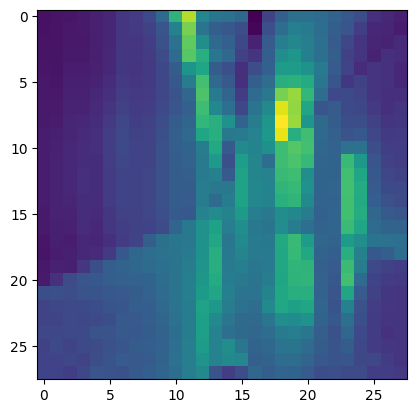

In [31]:
plt.imshow(X_train[0])

In [32]:
X_test = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = cv2.resize(img, (224, 224))
    X_test.append(img)
X_test = (np.array(X_test)/255.0).astype(float)

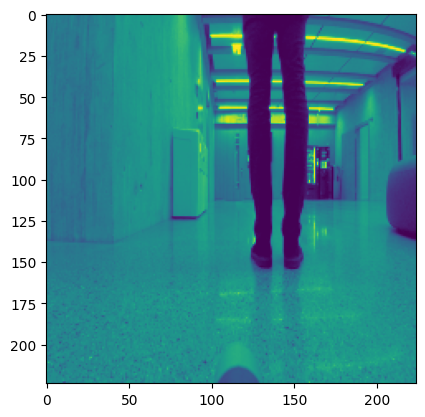

In [33]:
plt.imshow(X_test[-1])

In [34]:
X_test_lr = []
for i in range(len(test_df)):
    path = "training_mixed_set/unlabeled_set/"+test_df.iloc[i]["frame_id"]+"_512_512.jpg"
    img = cv2.imread(path,0)
    img = log_resize(img)
    X_test_lr.append(img)
X_test_lr = (np.array(X_test_lr)/255.0).astype(float)

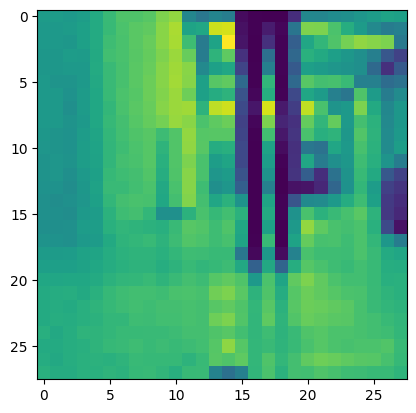

In [35]:
plt.imshow(X_test_lr[-1])

In [36]:
X_train = np.reshape(X_train,(-1,784))
X_train.shape

(3131, 784)

In [37]:
y_train = np.array(train_df["label"])
y_train.shape

(3131,)

In [38]:
X_test = np.reshape(X_test,(-1,224,224,1))
X_test.shape

(18470, 224, 224, 1)

In [39]:
X_test_lr = np.reshape(X_test_lr,(-1,784))
X_test_lr.shape

(18470, 784)

In [40]:
y_test = np.array(test_df["label"])
y_test = (y_test != 0).astype(int)
y_test.shape

(18470,)

In [41]:
sum(y_test == 0)

np.int64(12524)

In [42]:
sum(y_test == 1)

np.int64(5946)

# Utility Functions

In [43]:
def train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []
    val_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets)
                #spk_rec
        
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                val_data, val_targets = next(iter(val_dataloader))
                val_data = val_data.to(device)
                val_targets = val_targets.to(device)

                val_spk, val_mem = model(val_data.view(len(val_data), -1))

                val_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(model.num_steps):
                    val_loss += loss_fn(val_mem[step], val_targets)
                    #val_spk
        
            val_loss_epoch += val_loss.item()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
        print(f"Val loss at epoch: {e+1}: {val_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
    
    return train_losses,val_losses

In [44]:
class IncrementalLoss(nn.Module):
    def __init__(self, lambda_=0.1):
        super(IncrementalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_ = lambda_
        self.previous_weights = None 

    def set_previous_weights(self, model):
        self.previous_weights = {name: param.clone().detach() for name, param in model.named_parameters()}

    def forward(self, predictions, targets, model):
        loss_mse = self.mse(predictions, targets)

        if self.previous_weights is None:
            return loss_mse

        weight_penalty = 0.0
        param_count = 0
        for name, param in model.named_parameters():
            if name in self.previous_weights:
                diff = param - self.previous_weights[name]
                weight_penalty += torch.sum(diff ** 2)
                param_count += diff.numel()
        
    
        scale_factor = loss_mse.item() / (weight_penalty.item() + 1e-8)  
        total_loss = loss_mse + self.lambda_ * scale_factor * weight_penalty
        
        #print("MSE: ", loss_mse)
        #print("Weight penalty: ", self.lambda_ * scale_factor * weight_penalty)
    
        return total_loss

In [45]:
def magic_train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets, model)
        
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
    
    return train_losses

In [46]:
def compute_reconstruction_error(model,sample):
    spk,mem = model(sample)
    mem = torch.mean(mem,axis=0)
    mse = torch.nn.MSELoss()
    return mse(sample,mem).item()

# Magic Loop Pazzo Sgravato

In [47]:
# Cose da attenzionare:

# 1) Normalizzazione del lambda ===> Fatto
# 2) Pre-allenamento su un gruppo normale (senza usare incremental) ====> Fatto
# 3) Possibilità di rendere dinamico l'hidden layer (Future works)
# 4) Valutazione FP, FN al variare threshold ==> Fatto

In [48]:
class SAE(nn.Module):
    def __init__(self,num_inputs,num_hidden,num_steps=25,beta=0.95):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.beta = beta
        
        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_inputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [49]:
magic_sae = SAE(784,CODE_SIZE,num_steps=30)

In [50]:
magic_cnn = load_model("AD_Loop_base.keras")

In [51]:
magic_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,853 (4.94 MB)

 Trainable params: 431,617 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 863,236 (3.29 MB)

In [52]:
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999))

# Magic-SAE Pre-training

In [53]:
X_train = X_train[0:int(0.80*len(X_train))]
X_val = X_train[int(0.80*len(X_train)):]
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

In [54]:
pre_train_dataset = TensorDataset(X_train,X_train)
pre_train_dataloader = DataLoader(pre_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val,X_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = torch.nn.MSELoss()
train(magic_sae,pre_train_dataloader,val_dataloader,PRE_TRAIN_EPOCHS,loss_fn,optimizer)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 19.80it/s]


Train loss at epoch: 1: 210.71458053588867
Val loss at epoch: 1: 185.179319024086


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.35it/s]


Train loss at epoch: 2: 104.97419905662537
Val loss at epoch: 2: 104.40007221698761


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.03it/s]


Train loss at epoch: 3: 87.59048330783844
Val loss at epoch: 3: 86.99159562587738


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.13it/s]


Train loss at epoch: 4: 84.24676775932312
Val loss at epoch: 4: 83.63097703456879


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 22.16it/s]


Train loss at epoch: 5: 84.94660758972168
Val loss at epoch: 5: 84.7714763879776


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.43it/s]


Train loss at epoch: 6: 83.62417709827423
Val loss at epoch: 6: 83.18986856937408


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.81it/s]


Train loss at epoch: 7: 82.9381297826767
Val loss at epoch: 7: 82.51863729953766


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 22.05it/s]


Train loss at epoch: 8: 82.54585844278336
Val loss at epoch: 8: 82.25802284479141


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.05it/s]


Train loss at epoch: 9: 82.36138761043549
Val loss at epoch: 9: 82.34862411022186


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.12it/s]


Train loss at epoch: 10: 82.14920049905777
Val loss at epoch: 10: 81.91359978914261


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.02it/s]


Train loss at epoch: 11: 82.18749874830246
Val loss at epoch: 11: 82.04756546020508


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.96it/s]


Train loss at epoch: 12: 81.90584808588028
Val loss at epoch: 12: 81.78484207391739


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.12it/s]


Train loss at epoch: 13: 81.80435693264008
Val loss at epoch: 13: 81.72840738296509


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.59it/s]


Train loss at epoch: 14: 81.76819467544556
Val loss at epoch: 14: 81.55959141254425


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.07it/s]


Train loss at epoch: 15: 81.68317914009094
Val loss at epoch: 15: 81.45419698953629


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.40it/s]


Train loss at epoch: 16: 81.67323285341263
Val loss at epoch: 16: 81.3918868303299


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 21.29it/s]


Train loss at epoch: 17: 81.51150506734848
Val loss at epoch: 17: 81.27544724941254


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.92it/s]


Train loss at epoch: 18: 81.68868011236191
Val loss at epoch: 18: 81.48707669973373


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.03it/s]


Train loss at epoch: 19: 81.29888886213303
Val loss at epoch: 19: 81.34798508882523


100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.30it/s]

Train loss at epoch: 20: 81.42540454864502
Val loss at epoch: 20: 81.41248345375061


([210.71458053588867,
  104.97419905662537,
  87.59048330783844,
  84.24676775932312,
  84.94660758972168,
  83.62417709827423,
  82.9381297826767,
  82.54585844278336,
  82.36138761043549,
  82.14920049905777,
  82.18749874830246,
  81.90584808588028,
  81.80435693264008,
  81.76819467544556,
  81.68317914009094,
  81.67323285341263,
  81.51150506734848,
  81.68868011236191,
  81.29888886213303,
  81.42540454864502],
 [185.179319024086,
  104.40007221698761,
  86.99159562587738,
  83.63097703456879,
  84.7714763879776,
  83.18986856937408,
  82.51863729953766,
  82.25802284479141,
  82.34862411022186,
  81.91359978914261,
  82.04756546020508,
  81.78484207391739,
  81.72840738296509,
  81.55959141254425,
  81.45419698953629,
  81.3918868303299,
  81.27544724941254,
  81.48707669973373,
  81.34798508882523,
  81.41248345375061])

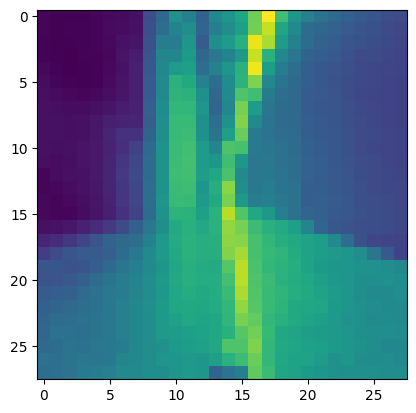

In [55]:
TRAIN_ID = 10
plt.imshow(X_train[TRAIN_ID].reshape(28,28))

In [56]:
magic_sae.eval()
a,b = magic_sae(torch.Tensor(X_train[TRAIN_ID]))

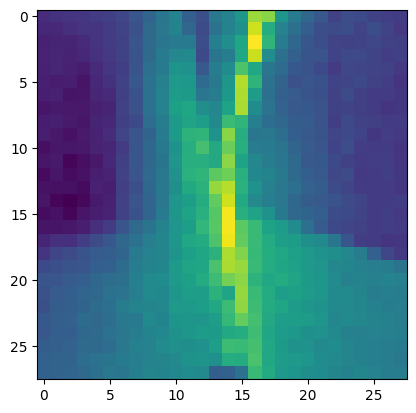

In [57]:
c = torch.mean(b,axis=0)
plt.imshow(c.detach().numpy().reshape(28,28))

# Threshold definition

In [58]:
magic_sae.eval()
spk,mem = magic_sae(X_train)
mem = torch.mean(mem,axis=0)
mse = torch.nn.MSELoss()
THR = mse(X_train,mem)
THR*SIGMA

tensor(0.0161, grad_fn=<MulBackward0>)

In [59]:
loss_fn = IncrementalLoss(lambda_=LAMBDA)
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-2, betas=(0.9, 0.999)) # Prova

In [60]:
frame_errors = []
preds = []
FP = 0
FN = 0 

for frame in range(len(X_test)):
    
    # Low res
    sample = X_test_lr[frame]
    #sample = cv2.resize(sample, (28, 28))
    #sample = log_resize(sample)
    sample = torch.Tensor(sample)
    sample = torch.reshape(sample,(-1,784))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)

    # Anomaly detected
    if frame_err > THR*SIGMA:
        
        preds.append(1)
        
        # TO-DO:
        # p = magic_cnn()
        #...
  
        if y_test[frame] == 0:
            FP += 1
            # Normal: We adapt the magic SAE
            print(f"Training on frame: {frame+1}")
            train_dataset = TensorDataset(sample,sample)
            train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False) 
            magic_train(magic_sae,train_dataloader,train_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)
            loss_fn.set_previous_weights(magic_sae)
        else:
            # Anomaly: Nothing to do here, we recognized the anomaly
            pass
    else:
        
        preds.append(0)
        
        if y_test[frame] == 1:
            FN += 1

Training on frame: 10


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.57it/s]


Train loss at epoch: 1: 1.294403076171875
Training on frame: 11


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 869.70263671875
Training on frame: 12


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 671.089599609375
Training on frame: 13


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 15.090729713439941
Training on frame: 14


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.33it/s]


Train loss at epoch: 1: 12.078534126281738
Training on frame: 15


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 11.608451843261719
Training on frame: 16


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 8.612293243408203
Training on frame: 17


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 7.787846565246582
Training on frame: 18


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 7.117685794830322
Training on frame: 19


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]

Train loss at epoch: 1: 5.679546356201172


Training on frame: 20


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]

Train loss at epoch: 1: 4.487749099731445


Training on frame: 21


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]

Train loss at epoch: 1: 4.040530681610107


Training on frame: 22


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 3.89715313911438
Training on frame: 23


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]

Train loss at epoch: 1: 3.270578622817993


Training on frame: 24


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]

Train loss at epoch: 1: 3.565788745880127


Training on frame: 25


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.88it/s]

Train loss at epoch: 1: 3.417897939682007


Training on frame: 26


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 3.6911754608154297
Training on frame: 27


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 3.4217538833618164
Training on frame: 28


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 3.534796714782715
Training on frame: 29


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.596316337585449
Training on frame: 30


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]

Train loss at epoch: 1: 3.328936815261841


Training on frame: 31


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]

Train loss at epoch: 1: 3.6226232051849365


Training on frame: 32


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]

Train loss at epoch: 1: 3.305938720703125


Training on frame: 33


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.12it/s]


Train loss at epoch: 1: 3.4464919567108154
Training on frame: 34


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 3.0099148750305176
Training on frame: 35


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.48it/s]


Train loss at epoch: 1: 2.788323163986206
Training on frame: 36


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Train loss at epoch: 1: 2.754269599914551
Training on frame: 37


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 2.80847430229187
Training on frame: 38


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 2.736940622329712
Training on frame: 39


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.5673537254333496
Training on frame: 40


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Train loss at epoch: 1: 2.4267520904541016
Training on frame: 41


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.88it/s]


Train loss at epoch: 1: 2.350036859512329
Training on frame: 42


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 2.3350515365600586
Training on frame: 43


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 2.158777952194214
Training on frame: 44


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 2.1966354846954346
Training on frame: 45


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 1.891506552696228
Training on frame: 46


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 1.9936869144439697
Training on frame: 47


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Train loss at epoch: 1: 1.7006491422653198
Training on frame: 48


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 1.907636284828186
Training on frame: 49


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.66it/s]


Train loss at epoch: 1: 1.7680190801620483
Training on frame: 50


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 1.8234024047851562
Training on frame: 51


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Train loss at epoch: 1: 1.8335416316986084
Training on frame: 52


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]


Train loss at epoch: 1: 1.5870885848999023
Training on frame: 53


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 1.613037109375
Training on frame: 54


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 2.237529754638672
Training on frame: 55


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 1.6609148979187012
Training on frame: 56


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.87it/s]


Train loss at epoch: 1: 1.5924772024154663
Training on frame: 57


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 1.684684157371521
Training on frame: 58


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 2.05900239944458
Training on frame: 59


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 1.712003231048584
Training on frame: 60


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 1.553063154220581
Training on frame: 61


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 1.706318974494934
Training on frame: 62


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Train loss at epoch: 1: 1.5877937078475952
Training on frame: 67


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 1.4032795429229736
Training on frame: 68


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 1.9803237915039062
Training on frame: 69


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 1.4271519184112549
Training on frame: 70


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


Train loss at epoch: 1: 1.4080448150634766
Training on frame: 71


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 1.4205429553985596
Training on frame: 72


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 1.348037838935852
Training on frame: 73


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 1.4351178407669067
Training on frame: 74


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 1.3873894214630127
Training on frame: 76


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 1.512094259262085
Training on frame: 78


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]

Train loss at epoch: 1: 1.4616175889968872


Training on frame: 80


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.17it/s]


Train loss at epoch: 1: 1.6730812788009644
Training on frame: 82


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]


Train loss at epoch: 1: 1.504970908164978
Training on frame: 83


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]

Train loss at epoch: 1: 1.3449292182922363


Training on frame: 84


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]

Train loss at epoch: 1: 1.6848689317703247


Training on frame: 85


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 2.751399517059326
Training on frame: 86


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.46it/s]


Train loss at epoch: 1: 1.5047297477722168
Training on frame: 87


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 1.850021243095398
Training on frame: 88


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 1.9479169845581055
Training on frame: 89


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss at epoch: 1: 1.5435950756072998
Training on frame: 93


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 1.7697404623031616
Training on frame: 98


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 1.7507433891296387
Training on frame: 99


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 1.7154213190078735
Training on frame: 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 1.6755486726760864
Training on frame: 101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 1.6761127710342407
Training on frame: 102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 1.4935493469238281
Training on frame: 103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 1.5050770044326782
Training on frame: 104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 1.602810263633728
Training on frame: 105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 1.6781587600708008
Training on frame: 106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.15it/s]


Train loss at epoch: 1: 1.6724228858947754
Training on frame: 107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 1.3946592807769775
Training on frame: 108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 1.7544548511505127
Training on frame: 110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 1.3758543729782104
Training on frame: 111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


Train loss at epoch: 1: 1.4590535163879395
Training on frame: 112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]


Train loss at epoch: 1: 1.9616262912750244
Training on frame: 113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 1.592042326927185
Training on frame: 114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 1.6511917114257812
Training on frame: 115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 1.6307902336120605
Training on frame: 116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 1.500239610671997
Training on frame: 117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 1.4387743473052979
Training on frame: 118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Train loss at epoch: 1: 1.406986951828003
Training on frame: 120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 1.569851279258728
Training on frame: 122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.51it/s]


Train loss at epoch: 1: 1.5376935005187988
Training on frame: 124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 1.4030669927597046
Training on frame: 128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 1.4496921300888062
Training on frame: 129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 1.4519764184951782
Training on frame: 130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.74it/s]


Train loss at epoch: 1: 1.5021106004714966
Training on frame: 132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 1.5012099742889404
Training on frame: 134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 1.4108437299728394
Training on frame: 135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 1.3794820308685303
Training on frame: 138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 1.3087570667266846
Training on frame: 139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 1.2988837957382202
Training on frame: 143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 1.7640308141708374
Training on frame: 146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 1.4123371839523315
Training on frame: 149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.10it/s]


Train loss at epoch: 1: 1.5639234781265259
Training on frame: 151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.06it/s]


Train loss at epoch: 1: 1.4657495021820068
Training on frame: 152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 1.3470144271850586
Training on frame: 154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


Train loss at epoch: 1: 1.564610481262207
Training on frame: 155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 1.2791639566421509
Training on frame: 157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 1.7239413261413574
Training on frame: 158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 1.5591593980789185
Training on frame: 160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 1.6963214874267578
Training on frame: 161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.74it/s]


Train loss at epoch: 1: 1.6191461086273193
Training on frame: 162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 1.7874857187271118
Training on frame: 163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 1.489803433418274
Training on frame: 165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 1.476538896560669
Training on frame: 174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 1.7968248128890991
Training on frame: 176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 1.5847104787826538
Training on frame: 177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 1.3934900760650635
Training on frame: 178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]

Train loss at epoch: 1: 1.4004237651824951


Training on frame: 181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 1.4529905319213867
Training on frame: 184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 1.5534334182739258
Training on frame: 189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 1.4100068807601929
Training on frame: 190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 1.4255870580673218
Training on frame: 191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 1.43321692943573
Training on frame: 192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Train loss at epoch: 1: 1.5651189088821411
Training on frame: 193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 1.4431896209716797
Training on frame: 194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 1.576051950454712
Training on frame: 195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.88it/s]


Train loss at epoch: 1: 1.2964200973510742
Training on frame: 197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 1.4033620357513428
Training on frame: 199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 1.429109811782837
Training on frame: 200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 2.0167129039764404
Training on frame: 204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 2.0487284660339355
Training on frame: 205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]

Train loss at epoch: 1: 1.572209358215332


Training on frame: 206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 1.591820478439331
Training on frame: 207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 1.951743721961975
Training on frame: 208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 1.4079411029815674
Training on frame: 209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 1.4118858575820923
Training on frame: 210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 1.6257193088531494
Training on frame: 212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 1.4273524284362793
Training on frame: 214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 1.4919328689575195
Training on frame: 215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 1.4892902374267578
Training on frame: 216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]

Train loss at epoch: 1: 1.6341553926467896


Training on frame: 217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.84it/s]


Train loss at epoch: 1: 1.6652495861053467
Training on frame: 218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 1.7810554504394531
Training on frame: 219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 2.935896873474121
Training on frame: 220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 2.1339163780212402
Training on frame: 221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 1.9617987871170044
Training on frame: 222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 2.3234360218048096
Training on frame: 223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.79it/s]


Train loss at epoch: 1: 2.059123992919922
Training on frame: 224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 1.6066317558288574
Training on frame: 225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 1.9981142282485962
Training on frame: 226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Train loss at epoch: 1: 1.862580418586731
Training on frame: 227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 1.6120829582214355
Training on frame: 228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.27it/s]


Train loss at epoch: 1: 2.0982232093811035
Training on frame: 229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 1.535504937171936
Training on frame: 230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 1.6506153345108032
Training on frame: 231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 1.5922417640686035
Training on frame: 232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 1.4920463562011719
Training on frame: 233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 1.7112056016921997
Training on frame: 234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 1.5158305168151855
Training on frame: 235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 1.710134506225586
Training on frame: 236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 1.334577202796936
Training on frame: 237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 1.8854961395263672
Training on frame: 238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]

Train loss at epoch: 1: 1.5375735759735107


Training on frame: 239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]

Train loss at epoch: 1: 1.463196039199829


Training on frame: 242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.86it/s]


Train loss at epoch: 1: 1.5466557741165161
Training on frame: 247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 1.9009628295898438
Training on frame: 248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 1.642242193222046
Training on frame: 253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 1.5942769050598145
Training on frame: 255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 1.4243797063827515
Training on frame: 256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 1.4001786708831787
Training on frame: 257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 1.601818561553955
Training on frame: 258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 3.217752456665039
Training on frame: 259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s]


Train loss at epoch: 1: 1.653649091720581
Training on frame: 260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Train loss at epoch: 1: 2.1058926582336426
Training on frame: 261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 3.4504241943359375
Training on frame: 262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss at epoch: 1: 3.0642528533935547
Training on frame: 263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 2.376918077468872
Training on frame: 264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 2.1852152347564697
Training on frame: 265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 2.0652835369110107
Training on frame: 266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 2.4292619228363037
Training on frame: 267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.110964059829712
Training on frame: 268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 2.665637969970703
Training on frame: 269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 2.0195422172546387
Training on frame: 270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Train loss at epoch: 1: 2.030076026916504
Training on frame: 271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 2.0992534160614014
Training on frame: 272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 3.5818705558776855
Training on frame: 273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 2.5351996421813965
Training on frame: 274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.507403612136841
Training on frame: 275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 3.017547130584717
Training on frame: 276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]

Train loss at epoch: 1: 2.63844895362854


Training on frame: 277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 2.484153985977173
Training on frame: 278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.16it/s]

Train loss at epoch: 1: 2.0626909732818604


Training on frame: 279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 2.306687831878662
Training on frame: 280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 2.1828019618988037
Training on frame: 281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 1.9944148063659668
Training on frame: 282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.7806596755981445
Training on frame: 283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 3.3310163021087646
Training on frame: 284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 2.618089437484741
Training on frame: 285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


Train loss at epoch: 1: 3.694783926010132
Training on frame: 286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 2.4801533222198486
Training on frame: 287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 2.4594337940216064
Training on frame: 288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 2.542795181274414
Training on frame: 289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]

Train loss at epoch: 1: 2.778088331222534


Training on frame: 290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.490553140640259
Training on frame: 291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 2.3869760036468506
Training on frame: 292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]

Train loss at epoch: 1: 2.7069079875946045


Training on frame: 293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


Train loss at epoch: 1: 2.2720282077789307
Training on frame: 294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.69it/s]


Train loss at epoch: 1: 2.1449508666992188
Training on frame: 295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.40it/s]


Train loss at epoch: 1: 2.2359516620635986
Training on frame: 296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]

Train loss at epoch: 1: 2.0350520610809326


Training on frame: 297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 1.9358329772949219
Training on frame: 298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 1.854688286781311
Training on frame: 299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 1.7345167398452759
Training on frame: 300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.1611249446868896
Training on frame: 301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 1.9696099758148193
Training on frame: 302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 2.038038492202759
Training on frame: 303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 1.7342629432678223
Training on frame: 304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 1.776887059211731
Training on frame: 305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 1.6393709182739258
Training on frame: 306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Train loss at epoch: 1: 2.0227417945861816
Training on frame: 307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 1.7764402627944946
Training on frame: 308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 1.5122723579406738
Training on frame: 309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 1.7105892896652222
Training on frame: 310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 1.9226155281066895
Training on frame: 311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 2.6306703090667725
Training on frame: 312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.93it/s]


Train loss at epoch: 1: 2.101968288421631
Training on frame: 313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 3.346238851547241
Training on frame: 314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 2.3795650005340576
Training on frame: 315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 2.6564977169036865
Training on frame: 316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 2.0356059074401855
Training on frame: 317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 2.225046396255493
Training on frame: 318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.76it/s]


Train loss at epoch: 1: 2.5600552558898926
Training on frame: 319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 2.191206693649292
Training on frame: 320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.65it/s]


Train loss at epoch: 1: 1.9777082204818726
Training on frame: 321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 1.7824457883834839
Training on frame: 322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.83it/s]


Train loss at epoch: 1: 2.711109161376953
Training on frame: 323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.47it/s]


Train loss at epoch: 1: 1.981522798538208
Training on frame: 324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 1.7067818641662598
Training on frame: 325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 2.028085470199585
Training on frame: 326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 2.1068079471588135
Training on frame: 327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Train loss at epoch: 1: 2.6582322120666504
Training on frame: 328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 1.9863508939743042
Training on frame: 329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 2.3478050231933594
Training on frame: 330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 1.774732232093811
Training on frame: 331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 1.8383138179779053
Training on frame: 332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 1.8926947116851807
Training on frame: 333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 1.6982817649841309
Training on frame: 334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]

Train loss at epoch: 1: 1.6616361141204834


Training on frame: 335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]

Train loss at epoch: 1: 1.7140841484069824


Training on frame: 336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]

Train loss at epoch: 1: 1.5285944938659668


Training on frame: 337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]

Train loss at epoch: 1: 2.054431676864624


Training on frame: 338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 1.6059554815292358
Training on frame: 339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]

Train loss at epoch: 1: 2.8112144470214844


Training on frame: 340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 2.0446064472198486
Training on frame: 341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 2.1894826889038086
Training on frame: 342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 2.7101471424102783
Training on frame: 343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 2.480787754058838
Training on frame: 344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 2.463139295578003
Training on frame: 345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 2.195450782775879
Training on frame: 346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 2.2459800243377686
Training on frame: 347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 2.603358268737793
Training on frame: 348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.96it/s]


Train loss at epoch: 1: 1.9871560335159302
Training on frame: 349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 1.9465065002441406
Training on frame: 350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 2.9822733402252197
Training on frame: 351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Train loss at epoch: 1: 2.8171114921569824
Training on frame: 352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.9698407649993896
Training on frame: 353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 2.3194520473480225
Training on frame: 354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 2.259500503540039
Training on frame: 355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 2.530738353729248
Training on frame: 356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 2.4052555561065674
Training on frame: 357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.1128785610198975
Training on frame: 358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 2.663856029510498
Training on frame: 359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


Train loss at epoch: 1: 2.21018648147583
Training on frame: 360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 2.278986930847168
Training on frame: 361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.62it/s]


Train loss at epoch: 1: 1.8670649528503418
Training on frame: 362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Train loss at epoch: 1: 2.2168662548065186
Training on frame: 363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Train loss at epoch: 1: 3.2256460189819336
Training on frame: 364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.4122374057769775
Training on frame: 365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 3.1567864418029785
Training on frame: 366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 2.371053457260132
Training on frame: 367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 2.906942129135132
Training on frame: 368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 2.3884382247924805
Training on frame: 369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 3.7856075763702393
Training on frame: 370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 2.381070375442505
Training on frame: 371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 2.565478563308716
Training on frame: 372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 2.737734079360962
Training on frame: 373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Train loss at epoch: 1: 2.3755102157592773
Training on frame: 374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 2.3805174827575684
Training on frame: 375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 2.2259278297424316
Training on frame: 376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 2.40940523147583
Training on frame: 377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.32it/s]

Train loss at epoch: 1: 3.081193685531616


Training on frame: 378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.18it/s]


Train loss at epoch: 1: 3.152456521987915
Training on frame: 379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 3.2367665767669678
Training on frame: 380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.1504716873168945
Training on frame: 381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Train loss at epoch: 1: 2.4857306480407715
Training on frame: 382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Train loss at epoch: 1: 2.313373327255249
Training on frame: 383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 2.2312018871307373
Training on frame: 384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 2.4192988872528076
Training on frame: 385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 2.1699821949005127
Training on frame: 386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.03it/s]


Train loss at epoch: 1: 2.1858627796173096
Training on frame: 387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 2.435852289199829
Training on frame: 388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]

Train loss at epoch: 1: 2.13080096244812


Training on frame: 389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 2.060150384902954
Training on frame: 390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 1.9205693006515503
Training on frame: 391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 2.543034076690674
Training on frame: 392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 1.8307998180389404
Training on frame: 393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 3.365802049636841
Training on frame: 394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 3.346322774887085
Training on frame: 395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.74it/s]


Train loss at epoch: 1: 4.514111518859863
Training on frame: 396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 2.9591615200042725
Training on frame: 397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.8262431621551514
Training on frame: 398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]

Train loss at epoch: 1: 3.807558298110962


Training on frame: 399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]

Train loss at epoch: 1: 4.108901500701904


Training on frame: 400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 3.6345818042755127
Training on frame: 401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 2.8807897567749023
Training on frame: 402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.118670701980591
Training on frame: 403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 3.4636738300323486
Training on frame: 404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 4.561773777008057
Training on frame: 405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.3807661533355713
Training on frame: 406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 3.4468350410461426
Training on frame: 407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 1: 3.6055591106414795
Training on frame: 408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 3.095276355743408
Training on frame: 409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.7488880157470703
Training on frame: 410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.1609160900115967
Training on frame: 411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.31it/s]


Train loss at epoch: 1: 3.693044662475586
Training on frame: 412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 3.5350959300994873
Training on frame: 413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 3.477701187133789
Training on frame: 414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 2.9496259689331055
Training on frame: 415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 3.13053297996521
Training on frame: 416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]

Train loss at epoch: 1: 3.5263330936431885


Training on frame: 417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]

Train loss at epoch: 1: 2.656301736831665


Training on frame: 418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 2.8027262687683105
Training on frame: 419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]

Train loss at epoch: 1: 2.738973379135132
Training on frame: 420



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 2.9456772804260254
Training on frame: 421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 2.8981432914733887
Training on frame: 422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.80393648147583
Training on frame: 423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 2.424612283706665
Training on frame: 424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 2.347721576690674
Training on frame: 425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 3.087838649749756
Training on frame: 426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 3.5930397510528564
Training on frame: 427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 3.5905373096466064
Training on frame: 428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]

Train loss at epoch: 1: 2.8536534309387207


Training on frame: 429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 2.4719505310058594
Training on frame: 430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 2.855794668197632
Training on frame: 431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 3.220400333404541
Training on frame: 432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 2.728069305419922
Training on frame: 433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 2.3737480640411377
Training on frame: 434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.74it/s]


Train loss at epoch: 1: 2.5377695560455322
Training on frame: 435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 2.487433433532715
Training on frame: 436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 3.0894644260406494
Training on frame: 437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 2.578479766845703
Training on frame: 438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.7539775371551514
Training on frame: 439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 3.9365787506103516
Training on frame: 440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 4.405454635620117
Training on frame: 441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 4.21987247467041
Training on frame: 442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 2.535133123397827
Training on frame: 443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Train loss at epoch: 1: 3.0391554832458496
Training on frame: 444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 2.8931591510772705
Training on frame: 445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 2.686131477355957
Training on frame: 446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 3.4636738300323486
Training on frame: 447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 2.6570098400115967
Training on frame: 448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 2.9577102661132812
Training on frame: 449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]

Train loss at epoch: 1: 2.827867269515991


Training on frame: 450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 2.94156551361084
Training on frame: 451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]

Train loss at epoch: 1: 2.843745231628418


Training on frame: 452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 2.745873212814331
Training on frame: 453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.60it/s]


Train loss at epoch: 1: 2.638435125350952
Training on frame: 454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.368375301361084
Training on frame: 455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 2.2976977825164795
Training on frame: 456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 2.2267556190490723
Training on frame: 457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Train loss at epoch: 1: 2.780515193939209
Training on frame: 458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.73it/s]


Train loss at epoch: 1: 3.72818922996521
Training on frame: 459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.83it/s]


Train loss at epoch: 1: 3.245340585708618
Training on frame: 460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.79it/s]


Train loss at epoch: 1: 2.727396249771118
Training on frame: 461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 2.7685916423797607
Training on frame: 462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 2.4821417331695557
Training on frame: 463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.08it/s]


Train loss at epoch: 1: 2.389326572418213
Training on frame: 464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


Train loss at epoch: 1: 2.3115615844726562
Training on frame: 465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.47it/s]


Train loss at epoch: 1: 2.3758163452148438
Training on frame: 466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 2.6091785430908203
Training on frame: 467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 3.6367366313934326
Training on frame: 468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 3.0952043533325195
Training on frame: 469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 3.0099875926971436
Training on frame: 470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.35it/s]


Train loss at epoch: 1: 2.493994951248169
Training on frame: 471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 2.692756175994873
Training on frame: 472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.6248035430908203
Training on frame: 473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.11it/s]


Train loss at epoch: 1: 3.0291969776153564
Training on frame: 474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


Train loss at epoch: 1: 2.584751844406128
Training on frame: 475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


Train loss at epoch: 1: 2.5333027839660645
Training on frame: 476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]

Train loss at epoch: 1: 2.3971967697143555


Training on frame: 477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 2.6253209114074707
Training on frame: 478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.78it/s]


Train loss at epoch: 1: 3.07662034034729
Training on frame: 479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 2.352522850036621
Training on frame: 480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]

Train loss at epoch: 1: 2.3640382289886475


Training on frame: 481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


Train loss at epoch: 1: 3.1698622703552246
Training on frame: 482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Train loss at epoch: 1: 2.41349196434021
Training on frame: 483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 2.8859260082244873
Training on frame: 484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 2.438278913497925
Training on frame: 485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 2.204465866088867
Training on frame: 486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 2.7938125133514404
Training on frame: 487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 2.520265817642212
Training on frame: 488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


Train loss at epoch: 1: 2.298020362854004
Training on frame: 489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


Train loss at epoch: 1: 3.387087821960449
Training on frame: 490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.81it/s]


Train loss at epoch: 1: 3.1054649353027344
Training on frame: 491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 3.1284611225128174
Training on frame: 492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.311765193939209
Training on frame: 493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.26it/s]


Train loss at epoch: 1: 2.431776762008667
Training on frame: 494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Train loss at epoch: 1: 3.3443217277526855
Training on frame: 495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 3.3970189094543457
Training on frame: 496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 2.9225220680236816
Training on frame: 497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 2.785529851913452
Training on frame: 498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 3.0234665870666504
Training on frame: 499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 2.3920812606811523
Training on frame: 500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.37it/s]


Train loss at epoch: 1: 2.3723785877227783
Training on frame: 501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.03it/s]


Train loss at epoch: 1: 2.362180471420288
Training on frame: 502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.18it/s]


Train loss at epoch: 1: 2.13960599899292
Training on frame: 503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.81it/s]


Train loss at epoch: 1: 2.4259438514709473
Training on frame: 504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.26it/s]


Train loss at epoch: 1: 3.0461325645446777
Training on frame: 505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.87it/s]


Train loss at epoch: 1: 2.4481284618377686
Training on frame: 506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.54it/s]


Train loss at epoch: 1: 4.177736759185791
Training on frame: 507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 3.1044106483459473
Training on frame: 508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 4.05023193359375
Training on frame: 509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 6.465916633605957
Training on frame: 510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


Train loss at epoch: 1: 3.034841775894165
Training on frame: 511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Train loss at epoch: 1: 3.326916456222534
Training on frame: 512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.16it/s]


Train loss at epoch: 1: 3.097222328186035
Training on frame: 513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


Train loss at epoch: 1: 3.237856388092041
Training on frame: 514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 3.2133445739746094
Training on frame: 515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


Train loss at epoch: 1: 3.2459518909454346
Training on frame: 516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 3.359438180923462
Training on frame: 517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 2.955949544906616
Training on frame: 518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 2.638357162475586
Training on frame: 519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.830479860305786
Training on frame: 520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 2.665052890777588
Training on frame: 521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 2.9075872898101807
Training on frame: 522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 2.449042797088623
Training on frame: 523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Train loss at epoch: 1: 2.7954070568084717
Training on frame: 524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 2.591480255126953
Training on frame: 525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.66it/s]


Train loss at epoch: 1: 2.437335252761841
Training on frame: 526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 3.577643394470215
Training on frame: 527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 3.1753017902374268
Training on frame: 528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 2.630858898162842
Training on frame: 529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


Train loss at epoch: 1: 2.6936376094818115
Training on frame: 530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.949141502380371
Training on frame: 531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.89it/s]


Train loss at epoch: 1: 2.828019380569458
Training on frame: 532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 3.3322346210479736
Training on frame: 533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 3.123530149459839
Training on frame: 534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.78it/s]


Train loss at epoch: 1: 3.0842299461364746
Training on frame: 535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 3.0109853744506836
Training on frame: 536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.50it/s]


Train loss at epoch: 1: 3.7049007415771484
Training on frame: 537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Train loss at epoch: 1: 2.9128756523132324
Training on frame: 538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 3.5508546829223633
Training on frame: 539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss at epoch: 1: 3.4828317165374756
Training on frame: 540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.53it/s]


Train loss at epoch: 1: 3.946427822113037
Training on frame: 541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


Train loss at epoch: 1: 3.6149346828460693
Training on frame: 542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 3.3253509998321533
Training on frame: 543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.445943593978882
Training on frame: 544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.2009527683258057
Training on frame: 545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 3.738638401031494
Training on frame: 546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]

Train loss at epoch: 1: 3.6555652618408203


Training on frame: 547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.16it/s]


Train loss at epoch: 1: 3.4478392601013184
Training on frame: 548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.3022940158843994
Training on frame: 549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 3.503051280975342
Training on frame: 550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 2.8549258708953857
Training on frame: 551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 3.342507839202881
Training on frame: 552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Train loss at epoch: 1: 2.8301689624786377
Training on frame: 553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Train loss at epoch: 1: 2.9204909801483154
Training on frame: 554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.42it/s]


Train loss at epoch: 1: 2.6004812717437744
Training on frame: 555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 2.6562905311584473
Training on frame: 556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 2.936044692993164
Training on frame: 557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 4.098795413970947
Training on frame: 558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 3.8282201290130615
Training on frame: 559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 1: 3.974796772003174
Training on frame: 560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Train loss at epoch: 1: 3.533936023712158
Training on frame: 561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 3.648111343383789
Training on frame: 562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.3633415699005127
Training on frame: 563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 3.157078504562378
Training on frame: 564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.1492273807525635
Training on frame: 565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.64it/s]


Train loss at epoch: 1: 3.6143617630004883
Training on frame: 566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]


Train loss at epoch: 1: 3.210452079772949
Training on frame: 567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 3.6622915267944336
Training on frame: 568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


Train loss at epoch: 1: 3.133641242980957
Training on frame: 569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 3.982225179672241
Training on frame: 570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 3.874692678451538
Training on frame: 571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 4.1803879737854
Training on frame: 572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.09it/s]


Train loss at epoch: 1: 4.231013298034668
Training on frame: 573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 3.861320734024048
Training on frame: 574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.85it/s]


Train loss at epoch: 1: 3.318411350250244
Training on frame: 575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 3.5311882495880127
Training on frame: 576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 4.006821632385254
Training on frame: 577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 3.7285146713256836
Training on frame: 578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 3.4612207412719727
Training on frame: 579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.14it/s]


Train loss at epoch: 1: 3.4874093532562256
Training on frame: 580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 3.330688953399658
Training on frame: 581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]


Train loss at epoch: 1: 3.596446990966797
Training on frame: 582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 2.920579433441162
Training on frame: 583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.529618978500366
Training on frame: 584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 3.2487456798553467
Training on frame: 585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 3.2369930744171143
Training on frame: 586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 3.3315792083740234
Training on frame: 587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 3.1654889583587646
Training on frame: 588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.59it/s]


Train loss at epoch: 1: 3.3625643253326416
Training on frame: 589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]

Train loss at epoch: 1: 3.287600040435791


Training on frame: 590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 3.039421558380127
Training on frame: 591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 2.6261322498321533
Training on frame: 592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 2.4048545360565186
Training on frame: 593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.4441699981689453
Training on frame: 594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.84it/s]


Train loss at epoch: 1: 3.37162709236145
Training on frame: 595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 2.5507400035858154
Training on frame: 596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


Train loss at epoch: 1: 2.588850259780884
Training on frame: 597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 2.8452229499816895
Training on frame: 598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.45it/s]


Train loss at epoch: 1: 2.6635630130767822
Training on frame: 599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 2.9998552799224854
Training on frame: 600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 1: 3.4754674434661865
Training on frame: 601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 2.850234270095825
Training on frame: 602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 3.1123974323272705
Training on frame: 603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 2.9102115631103516
Training on frame: 604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 1: 3.8391549587249756
Training on frame: 605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.2342631816864014
Training on frame: 606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]


Train loss at epoch: 1: 2.792905807495117
Training on frame: 607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 2.8813869953155518
Training on frame: 608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]

Train loss at epoch: 1: 3.0231335163116455


Training on frame: 609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 2.6592910289764404
Training on frame: 610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 2.5939481258392334
Training on frame: 611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.626621723175049
Training on frame: 612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 3.097088575363159
Training on frame: 613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.61it/s]


Train loss at epoch: 1: 2.9581410884857178
Training on frame: 614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 3.281191110610962
Training on frame: 615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 2.7978920936584473
Training on frame: 616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 2.689476251602173
Training on frame: 617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]


Train loss at epoch: 1: 2.976226568222046
Training on frame: 618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 3.945047616958618
Training on frame: 619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 3.2296621799468994
Training on frame: 620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 1: 2.8691604137420654
Training on frame: 621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 1: 3.656672477722168
Training on frame: 622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 3.436650037765503
Training on frame: 623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 2.662015199661255
Training on frame: 624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 2.6645822525024414
Training on frame: 625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 4.77065372467041
Training on frame: 626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.50it/s]


Train loss at epoch: 1: 3.8972418308258057
Training on frame: 627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.9958925247192383
Training on frame: 628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.4475488662719727
Training on frame: 629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 3.86507248878479
Training on frame: 630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.36it/s]


Train loss at epoch: 1: 4.247580528259277
Training on frame: 631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 3.752889633178711
Training on frame: 632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 3.523642063140869
Training on frame: 633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.74it/s]


Train loss at epoch: 1: 3.7411391735076904
Training on frame: 634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 3.353212594985962
Training on frame: 635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 3.1861870288848877
Training on frame: 636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.4270379543304443
Training on frame: 637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.51it/s]

Train loss at epoch: 1: 3.0746798515319824


Training on frame: 638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]

Train loss at epoch: 1: 2.8612349033355713


Training on frame: 639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]

Train loss at epoch: 1: 3.0543599128723145


Training on frame: 640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.45it/s]

Train loss at epoch: 1: 3.4703361988067627


Training on frame: 641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Train loss at epoch: 1: 3.96677303314209
Training on frame: 642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.7166850566864014
Training on frame: 643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 4.127252578735352
Training on frame: 644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.48it/s]


Train loss at epoch: 1: 3.116957426071167
Training on frame: 645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]


Train loss at epoch: 1: 2.928640127182007
Training on frame: 646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.6768524646759033
Training on frame: 647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.27970027923584
Training on frame: 648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 3.861949920654297
Training on frame: 649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 2.6815414428710938
Training on frame: 650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 2.8130064010620117
Training on frame: 651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 2.982207775115967
Training on frame: 652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 1: 2.5129177570343018
Training on frame: 653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.40it/s]


Train loss at epoch: 1: 2.6121184825897217
Training on frame: 654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 2.344644784927368
Training on frame: 655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 2.4865589141845703
Training on frame: 656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]

Train loss at epoch: 1: 2.2835326194763184


Training on frame: 657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.66it/s]

Train loss at epoch: 1: 2.8494632244110107


Training on frame: 658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]

Train loss at epoch: 1: 2.440200090408325


Training on frame: 659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 2.5667543411254883
Training on frame: 660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 2.146127939224243
Training on frame: 661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 2.558619976043701
Training on frame: 662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]

Train loss at epoch: 1: 2.2374660968780518


Training on frame: 663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 2.467104196548462
Training on frame: 664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.1184470653533936
Training on frame: 665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 2.1891298294067383
Training on frame: 666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 2.1517772674560547
Training on frame: 667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 1.883347988128662
Training on frame: 668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.85it/s]


Train loss at epoch: 1: 2.0750057697296143
Training on frame: 669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 2.0377254486083984
Training on frame: 670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 2.3481953144073486
Training on frame: 671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 2.311056613922119
Training on frame: 672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 1.9306583404541016
Training on frame: 673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 2.5645205974578857
Training on frame: 674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 1.808607578277588
Training on frame: 675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]

Train loss at epoch: 1: 2.138375759124756


Training on frame: 676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 2.350618600845337
Training on frame: 677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 2.594881772994995
Training on frame: 678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 3.0600082874298096
Training on frame: 679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 2.1245195865631104
Training on frame: 680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


Train loss at epoch: 1: 2.1369638442993164
Training on frame: 681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Train loss at epoch: 1: 2.3740127086639404
Training on frame: 682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.00it/s]


Train loss at epoch: 1: 2.0542283058166504
Training on frame: 683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 2.754652500152588
Training on frame: 684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 3.613471508026123
Training on frame: 685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.445373296737671
Training on frame: 686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 1: 3.1893579959869385
Training on frame: 687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.61it/s]


Train loss at epoch: 1: 2.723923683166504
Training on frame: 688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 2.7795677185058594
Training on frame: 689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 1: 2.6642813682556152
Training on frame: 690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 2.674276828765869
Training on frame: 691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 2.8752150535583496
Training on frame: 692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.673053026199341
Training on frame: 693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 2.5882222652435303
Training on frame: 694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 3.5380618572235107
Training on frame: 695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 3.3149800300598145
Training on frame: 696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 3.9116811752319336
Training on frame: 697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 3.054781913757324
Training on frame: 698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 3.2901554107666016
Training on frame: 699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 3.8268046379089355
Training on frame: 700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.8419241905212402
Training on frame: 701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.642958879470825
Training on frame: 702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 3.563291311264038
Training on frame: 703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.1519577503204346
Training on frame: 704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 2.999399423599243
Training on frame: 705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 3.5946877002716064
Training on frame: 706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 3.2148895263671875
Training on frame: 707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 3.692491292953491
Training on frame: 708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Train loss at epoch: 1: 3.178199291229248
Training on frame: 709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.46it/s]


Train loss at epoch: 1: 3.3164010047912598
Training on frame: 710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 2.751133918762207
Training on frame: 711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 3.045517921447754
Training on frame: 712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.67866587638855
Training on frame: 713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 3.463160514831543
Training on frame: 714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 2.8583824634552
Training on frame: 715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.716416358947754
Training on frame: 716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.2462666034698486
Training on frame: 717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 2.5859360694885254
Training on frame: 718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.462127685546875
Training on frame: 719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Train loss at epoch: 1: 2.854196071624756
Training on frame: 720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.5620460510253906
Training on frame: 721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 3.378511905670166
Training on frame: 722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 1: 4.01882791519165
Training on frame: 723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 4.400956153869629
Training on frame: 724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 4.772642135620117
Training on frame: 725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 5.865602493286133
Training on frame: 726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 6.757118225097656
Training on frame: 727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 5.326835632324219
Training on frame: 728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 3.528367280960083
Training on frame: 729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 4.54689359664917
Training on frame: 730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


Train loss at epoch: 1: 4.1449055671691895
Training on frame: 731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 4.584270477294922
Training on frame: 732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 4.667251110076904
Training on frame: 733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 5.066461563110352
Training on frame: 734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 5.306548595428467
Training on frame: 735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 1: 4.906097412109375
Training on frame: 736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 4.708763599395752
Training on frame: 737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.80it/s]


Train loss at epoch: 1: 4.8190412521362305
Training on frame: 738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.27it/s]


Train loss at epoch: 1: 4.487491130828857
Training on frame: 739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 5.55621862411499
Training on frame: 740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 3.980661392211914
Training on frame: 741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.91it/s]


Train loss at epoch: 1: 3.8712058067321777
Training on frame: 742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 4.122003078460693
Training on frame: 743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.440047264099121
Training on frame: 744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.01it/s]


Train loss at epoch: 1: 3.755854368209839
Training on frame: 745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 4.45393705368042
Training on frame: 746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 4.02510929107666
Training on frame: 747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.26it/s]


Train loss at epoch: 1: 4.579919338226318
Training on frame: 748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 3.6966803073883057
Training on frame: 749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 1: 3.486959934234619
Training on frame: 750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 3.1142385005950928
Training on frame: 751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]

Train loss at epoch: 1: 3.3200888633728027


Training on frame: 752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 1: 3.472464084625244
Training on frame: 753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 3.060648202896118
Training on frame: 754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 3.6671290397644043
Training on frame: 755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 3.651951789855957
Training on frame: 756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 2.8541619777679443
Training on frame: 757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 3.263509511947632
Training on frame: 758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 2.874861001968384
Training on frame: 759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 3.6109001636505127
Training on frame: 760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 3.035055637359619
Training on frame: 761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.034886360168457
Training on frame: 762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 2.946443557739258
Training on frame: 763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.58it/s]


Train loss at epoch: 1: 2.820286989212036
Training on frame: 764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 2.8239922523498535
Training on frame: 765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 2.7465624809265137
Training on frame: 766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.647080898284912
Training on frame: 767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.43it/s]


Train loss at epoch: 1: 3.131344795227051
Training on frame: 768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 7.115397930145264
Training on frame: 769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 5.908773422241211
Training on frame: 770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.78it/s]


Train loss at epoch: 1: 5.448266506195068
Training on frame: 771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


Train loss at epoch: 1: 3.739304542541504
Training on frame: 772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 4.061046600341797
Training on frame: 773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 3.8857460021972656
Training on frame: 774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 3.7794201374053955
Training on frame: 775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.00it/s]


Train loss at epoch: 1: 4.1642985343933105
Training on frame: 776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.21it/s]


Train loss at epoch: 1: 4.305325031280518
Training on frame: 777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.29it/s]


Train loss at epoch: 1: 4.172646522521973
Training on frame: 778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 4.753766059875488
Training on frame: 779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Train loss at epoch: 1: 4.120380878448486
Training on frame: 780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 3.5573670864105225
Training on frame: 781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 3.3455958366394043
Training on frame: 782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 3.7032744884490967
Training on frame: 783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 3.4512996673583984
Training on frame: 784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.4722540378570557
Training on frame: 785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.62it/s]


Train loss at epoch: 1: 3.8167080879211426
Training on frame: 786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 3.0889244079589844
Training on frame: 787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.405388593673706
Training on frame: 788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.1243903636932373
Training on frame: 789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 3.4377641677856445
Training on frame: 790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.1710267066955566
Training on frame: 791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 3.23088002204895
Training on frame: 792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 1: 3.3321197032928467
Training on frame: 793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 3.412196397781372
Training on frame: 794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Train loss at epoch: 1: 2.9195661544799805
Training on frame: 795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 3.002598285675049
Training on frame: 796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.25it/s]


Train loss at epoch: 1: 2.7766659259796143
Training on frame: 797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.11it/s]


Train loss at epoch: 1: 2.9486029148101807
Training on frame: 798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]


Train loss at epoch: 1: 3.0092267990112305
Training on frame: 799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 2.9069788455963135
Training on frame: 800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Train loss at epoch: 1: 3.4403953552246094
Training on frame: 801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 1: 4.7362494468688965
Training on frame: 802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.048330068588257
Training on frame: 803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss at epoch: 1: 3.893735408782959
Training on frame: 804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.53it/s]


Train loss at epoch: 1: 3.496934652328491
Training on frame: 805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 3.060790538787842
Training on frame: 806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Train loss at epoch: 1: 3.3684606552124023
Training on frame: 807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 4.0344696044921875
Training on frame: 808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 3.4516162872314453
Training on frame: 809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 3.028794288635254
Training on frame: 810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 3.402981996536255
Training on frame: 811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.7550270557403564
Training on frame: 812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.620615243911743
Training on frame: 813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 2.8469200134277344
Training on frame: 814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.83it/s]


Train loss at epoch: 1: 2.916527271270752
Training on frame: 815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


Train loss at epoch: 1: 2.7333741188049316
Training on frame: 816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.9550325870513916
Training on frame: 817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 4.04276704788208
Training on frame: 818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47it/s]


Train loss at epoch: 1: 3.0957865715026855
Training on frame: 819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.83it/s]


Train loss at epoch: 1: 3.4112613201141357
Training on frame: 820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.7489097118377686
Training on frame: 821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 3.1254560947418213
Training on frame: 822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 3.132051467895508
Training on frame: 823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 3.1326303482055664
Training on frame: 824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.10it/s]


Train loss at epoch: 1: 3.2072291374206543
Training on frame: 825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 3.306504487991333
Training on frame: 826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 3.1644444465637207
Training on frame: 827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 2.9775118827819824
Training on frame: 828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 2.370929718017578
Training on frame: 829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 2.8118906021118164
Training on frame: 830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 8.237186431884766
Training on frame: 831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 2.8255088329315186
Training on frame: 832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.140554666519165
Training on frame: 833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 3.6985487937927246
Training on frame: 834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 3.58819842338562
Training on frame: 835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 1: 3.436173439025879
Training on frame: 836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 3.3101744651794434
Training on frame: 837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


Train loss at epoch: 1: 3.1295273303985596
Training on frame: 838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 3.080888509750366
Training on frame: 839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.99it/s]


Train loss at epoch: 1: 3.847095012664795
Training on frame: 840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 3.670412063598633
Training on frame: 841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.51it/s]


Train loss at epoch: 1: 3.2219035625457764
Training on frame: 842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 2.9469430446624756
Training on frame: 843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 2.8083159923553467
Training on frame: 844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 2.6565775871276855
Training on frame: 845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 3.7408180236816406
Training on frame: 846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.45it/s]


Train loss at epoch: 1: 3.398369073867798
Training on frame: 847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 3.019770860671997
Training on frame: 848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 3.348026990890503
Training on frame: 849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.51it/s]


Train loss at epoch: 1: 2.9049627780914307
Training on frame: 850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 2.8238720893859863
Training on frame: 851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]

Train loss at epoch: 1: 3.5765433311462402


Training on frame: 852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]

Train loss at epoch: 1: 2.677527904510498


Training on frame: 853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.69it/s]


Train loss at epoch: 1: 3.8891239166259766
Training on frame: 854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]


Train loss at epoch: 1: 3.6385812759399414
Training on frame: 855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]

Train loss at epoch: 1: 3.1123406887054443


Training on frame: 856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.51it/s]


Train loss at epoch: 1: 2.941957473754883
Training on frame: 857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


Train loss at epoch: 1: 2.594628095626831
Training on frame: 858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 2.7827577590942383
Training on frame: 859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.761124610900879
Training on frame: 860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 2.778820753097534
Training on frame: 861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 3.61055850982666
Training on frame: 862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 2.860670328140259
Training on frame: 863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.5265889167785645
Training on frame: 864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 2.7073569297790527
Training on frame: 865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.48it/s]


Train loss at epoch: 1: 2.9413962364196777
Training on frame: 866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 2.8804397583007812
Training on frame: 867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 2.7883362770080566
Training on frame: 868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.41it/s]


Train loss at epoch: 1: 3.7842490673065186
Training on frame: 869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 2.95051908493042
Training on frame: 870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]

Train loss at epoch: 1: 3.31443452835083


Training on frame: 871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.57it/s]


Train loss at epoch: 1: 2.579676389694214
Training on frame: 872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 2.5607447624206543
Training on frame: 873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 1: 2.683992385864258
Training on frame: 874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.73it/s]


Train loss at epoch: 1: 3.0251145362854004
Training on frame: 875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 2.429741859436035
Training on frame: 876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.8081698417663574
Training on frame: 877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.57it/s]


Train loss at epoch: 1: 4.092057228088379
Training on frame: 878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 3.4234068393707275
Training on frame: 879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 3.1119704246520996
Training on frame: 880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 3.5376126766204834
Training on frame: 881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 2.95382022857666
Training on frame: 882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 4.091827392578125
Training on frame: 883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss at epoch: 1: 3.315650701522827
Training on frame: 884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.326338529586792
Training on frame: 885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.59it/s]

Train loss at epoch: 1: 3.238673686981201


Training on frame: 886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 3.2799232006073
Training on frame: 887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 3.643009662628174
Training on frame: 888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 2.987825870513916
Training on frame: 889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 2.9230990409851074
Training on frame: 890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 3.094120502471924
Training on frame: 891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 3.0731711387634277
Training on frame: 892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 3.4124667644500732
Training on frame: 893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]

Train loss at epoch: 1: 2.7871177196502686


Training on frame: 894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 2.519622802734375
Training on frame: 895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 2.428133726119995
Training on frame: 896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.323204517364502
Training on frame: 897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 2.715177297592163
Training on frame: 898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 2.7779338359832764
Training on frame: 899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.15it/s]


Train loss at epoch: 1: 3.412778615951538
Training on frame: 900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 3.126426935195923
Training on frame: 901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.13it/s]


Train loss at epoch: 1: 3.676715612411499
Training on frame: 902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 2.8758182525634766
Training on frame: 903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 2.4896469116210938
Training on frame: 904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.93it/s]


Train loss at epoch: 1: 2.332171678543091
Training on frame: 905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 2.902289867401123
Training on frame: 906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 2.7398815155029297
Training on frame: 907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 1: 2.2730867862701416
Training on frame: 908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Train loss at epoch: 1: 2.3342835903167725
Training on frame: 909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.78it/s]


Train loss at epoch: 1: 2.229957342147827
Training on frame: 910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.06074857711792
Training on frame: 911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 2.3727824687957764
Training on frame: 912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.8157589435577393
Training on frame: 913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.70it/s]


Train loss at epoch: 1: 2.598855972290039
Training on frame: 914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 2.2647411823272705
Training on frame: 915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 2.2608039379119873
Training on frame: 916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 2.439974784851074
Training on frame: 917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 2.3842148780822754
Training on frame: 918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.19it/s]


Train loss at epoch: 1: 2.192981719970703
Training on frame: 919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 2.081897497177124
Training on frame: 920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 1.8945215940475464
Training on frame: 921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 1.9622293710708618
Training on frame: 922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.79it/s]


Train loss at epoch: 1: 1.8768125772476196
Training on frame: 923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


Train loss at epoch: 1: 2.874656915664673
Training on frame: 924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Train loss at epoch: 1: 2.7251501083374023
Training on frame: 925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 2.619199275970459
Training on frame: 926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 2.350280523300171
Training on frame: 927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 1: 2.853588819503784
Training on frame: 928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.36it/s]


Train loss at epoch: 1: 2.4580821990966797
Training on frame: 929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.1240437030792236
Training on frame: 930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.3244380950927734
Training on frame: 931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Train loss at epoch: 1: 3.304178237915039
Training on frame: 932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.60it/s]


Train loss at epoch: 1: 2.9572675228118896
Training on frame: 933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.382596731185913
Training on frame: 934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 2.6566457748413086
Training on frame: 935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.30it/s]


Train loss at epoch: 1: 2.9755752086639404
Training on frame: 936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.12it/s]


Train loss at epoch: 1: 3.310512065887451
Training on frame: 937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 3.119349479675293
Training on frame: 938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.29it/s]


Train loss at epoch: 1: 4.444196701049805
Training on frame: 939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Train loss at epoch: 1: 3.220289707183838
Training on frame: 940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 2.9426589012145996
Training on frame: 941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 3.0183980464935303
Training on frame: 942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Train loss at epoch: 1: 3.6192731857299805
Training on frame: 943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 2.932577133178711
Training on frame: 944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 3.771707534790039
Training on frame: 945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 1: 3.2918550968170166
Training on frame: 946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


Train loss at epoch: 1: 3.3529534339904785
Training on frame: 947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.8499176502227783
Training on frame: 948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 1: 3.6019814014434814
Training on frame: 949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 3.003856658935547
Training on frame: 950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 2.9819767475128174
Training on frame: 951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 3.2241885662078857
Training on frame: 952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.09it/s]


Train loss at epoch: 1: 3.4010603427886963
Training on frame: 953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 2.978039026260376
Training on frame: 954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 3.045292377471924
Training on frame: 955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.48it/s]


Train loss at epoch: 1: 3.4722206592559814
Training on frame: 956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 3.4257659912109375
Training on frame: 957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 3.944326639175415
Training on frame: 958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 5.208510398864746
Training on frame: 959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 5.270627498626709
Training on frame: 960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.04it/s]


Train loss at epoch: 1: 5.29282283782959
Training on frame: 961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.73it/s]


Train loss at epoch: 1: 4.704341888427734
Training on frame: 962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 4.268333435058594
Training on frame: 963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.926873207092285
Training on frame: 964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 4.03826379776001
Training on frame: 965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 4.835180759429932
Training on frame: 966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 4.086964130401611
Training on frame: 967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 4.411344528198242
Training on frame: 968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 4.3553571701049805
Training on frame: 969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 3.880674362182617
Training on frame: 970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 1: 3.7302308082580566
Training on frame: 971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 3.6333460807800293
Training on frame: 972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 3.595461130142212
Training on frame: 973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.8227038383483887
Training on frame: 974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 3.784022808074951
Training on frame: 975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 3.738908052444458
Training on frame: 976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 1: 3.7298481464385986
Training on frame: 977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Train loss at epoch: 1: 3.109572172164917
Training on frame: 978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 4.36442232131958
Training on frame: 979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 3.5942800045013428
Training on frame: 980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.61it/s]


Train loss at epoch: 1: 3.6631336212158203
Training on frame: 981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 3.541511058807373
Training on frame: 982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.909147262573242
Training on frame: 983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 1: 3.5025978088378906
Training on frame: 984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 4.1802449226379395
Training on frame: 985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]


Train loss at epoch: 1: 3.3521857261657715
Training on frame: 986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 3.233527898788452
Training on frame: 987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 3.299654006958008
Training on frame: 988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 3.140775442123413
Training on frame: 989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.10it/s]


Train loss at epoch: 1: 3.295063018798828
Training on frame: 990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 3.123983383178711
Training on frame: 991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 4.009778022766113
Training on frame: 992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 3.778317928314209
Training on frame: 993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 3.885296106338501
Training on frame: 994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.171304941177368
Training on frame: 995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Train loss at epoch: 1: 3.0077157020568848
Training on frame: 996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 2.9052810668945312
Training on frame: 997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Train loss at epoch: 1: 3.100069284439087
Training on frame: 998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 2.836416721343994
Training on frame: 999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 2.806013584136963
Training on frame: 1000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 3.256117820739746
Training on frame: 1001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 3.1408886909484863
Training on frame: 1002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 2.9558587074279785
Training on frame: 1003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 3.1578733921051025
Training on frame: 1004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 3.072204113006592
Training on frame: 1005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]


Train loss at epoch: 1: 2.7123663425445557
Training on frame: 1006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 2.8534014225006104
Training on frame: 1007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 3.1392977237701416
Training on frame: 1008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 2.852071762084961
Training on frame: 1009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 3.940211534500122
Training on frame: 1010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 2.923842430114746
Training on frame: 1011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 2.849127769470215
Training on frame: 1012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 3.0168240070343018
Training on frame: 1013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 3.569417953491211
Training on frame: 1014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.425050735473633
Training on frame: 1015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 3.0552916526794434
Training on frame: 1016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 2.87104868888855
Training on frame: 1017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 2.8232288360595703
Training on frame: 1018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 2.3441357612609863
Training on frame: 1019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 3.534485101699829
Training on frame: 1020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.51it/s]


Train loss at epoch: 1: 2.503999710083008
Training on frame: 1021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


Train loss at epoch: 1: 2.6110475063323975
Training on frame: 1022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Train loss at epoch: 1: 2.7812306880950928
Training on frame: 1023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 2.5782406330108643
Training on frame: 1024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 2.903747797012329
Training on frame: 1025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 2.4764022827148438
Training on frame: 1026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.020019054412842
Training on frame: 1027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 2.344881534576416
Training on frame: 1028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.281730890274048
Training on frame: 1029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.903850555419922
Training on frame: 1030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 1: 2.880549907684326
Training on frame: 1031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 2.8616831302642822
Training on frame: 1032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 2.7359352111816406
Training on frame: 1033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 3.3344907760620117
Training on frame: 1034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


Train loss at epoch: 1: 2.6499195098876953
Training on frame: 1035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


Train loss at epoch: 1: 2.610267400741577
Training on frame: 1036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 2.3816659450531006
Training on frame: 1037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.2279415130615234
Training on frame: 1038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.89it/s]


Train loss at epoch: 1: 2.369218349456787
Training on frame: 1039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 2.406370162963867
Training on frame: 1040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 3.0113108158111572
Training on frame: 1041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 2.667451858520508
Training on frame: 1042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 2.519317626953125
Training on frame: 1043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 3.282862663269043
Training on frame: 1044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 2.531672239303589
Training on frame: 1045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Train loss at epoch: 1: 2.4672677516937256
Training on frame: 1046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 2.3480212688446045
Training on frame: 1047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 2.3911266326904297
Training on frame: 1048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.5431597232818604
Training on frame: 1049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.52726411819458
Training on frame: 1050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.53it/s]


Train loss at epoch: 1: 2.4030613899230957
Training on frame: 1051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 2.420119524002075
Training on frame: 1052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 2.2767086029052734
Training on frame: 1053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.72it/s]


Train loss at epoch: 1: 2.114182472229004
Training on frame: 1054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.252741575241089
Training on frame: 1055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 4.124422073364258
Training on frame: 1056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.73it/s]


Train loss at epoch: 1: 3.117499351501465
Training on frame: 1057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 2.690598487854004
Training on frame: 1058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 2.6112608909606934
Training on frame: 1059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 2.8319950103759766
Training on frame: 1060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 1: 2.854142427444458
Training on frame: 1061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.56it/s]


Train loss at epoch: 1: 3.1873888969421387
Training on frame: 1062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.47it/s]


Train loss at epoch: 1: 2.949507713317871
Training on frame: 1063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 3.002920389175415
Training on frame: 1064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 2.9070565700531006
Training on frame: 1065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 2.732776641845703
Training on frame: 1066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 2.6017680168151855
Training on frame: 1067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 2.3424153327941895
Training on frame: 1068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.35it/s]


Train loss at epoch: 1: 3.4168739318847656
Training on frame: 1069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 3.705091953277588
Training on frame: 1070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 2.668443202972412
Training on frame: 1071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 3.0226728916168213
Training on frame: 1072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Train loss at epoch: 1: 2.951547861099243
Training on frame: 1073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 2.7269625663757324
Training on frame: 1074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Train loss at epoch: 1: 2.9825196266174316
Training on frame: 1075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 2.8119542598724365
Training on frame: 1076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 2.9051616191864014
Training on frame: 1077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 2.721245288848877
Training on frame: 1078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.61it/s]


Train loss at epoch: 1: 2.612138509750366
Training on frame: 1079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.54it/s]


Train loss at epoch: 1: 3.5137016773223877
Training on frame: 1080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 2.7533223628997803
Training on frame: 1081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 2.6083984375
Training on frame: 1082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 2.661008834838867
Training on frame: 1083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 3.0881102085113525
Training on frame: 1084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 2.5998196601867676
Training on frame: 1085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 3.2311930656433105
Training on frame: 1086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.11it/s]


Train loss at epoch: 1: 3.3400139808654785
Training on frame: 1087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 2.5476832389831543
Training on frame: 1088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 3.4675920009613037
Training on frame: 1089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 4.0270185470581055
Training on frame: 1090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 4.312047004699707
Training on frame: 1091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]


Train loss at epoch: 1: 3.7665011882781982
Training on frame: 1092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 3.3861899375915527
Training on frame: 1093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.27it/s]


Train loss at epoch: 1: 3.7978973388671875
Training on frame: 1094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 1: 2.7044339179992676
Training on frame: 1095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 2.9673523902893066
Training on frame: 1096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 3.1590099334716797
Training on frame: 1097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 2.8143723011016846
Training on frame: 1098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Train loss at epoch: 1: 3.9913315773010254
Training on frame: 1099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 3.127549409866333
Training on frame: 1100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 2.894407033920288
Training on frame: 1101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 2.917743682861328
Training on frame: 1102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.182744026184082
Training on frame: 1103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


Train loss at epoch: 1: 3.6382155418395996
Training on frame: 1104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 3.2066335678100586
Training on frame: 1105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.8166592121124268
Training on frame: 1106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Train loss at epoch: 1: 3.200570821762085
Training on frame: 1107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 3.144998788833618
Training on frame: 1108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.769310712814331
Training on frame: 1109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 3.372751474380493
Training on frame: 1110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Train loss at epoch: 1: 2.5725533962249756
Training on frame: 1111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


Train loss at epoch: 1: 2.9589736461639404
Training on frame: 1112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Train loss at epoch: 1: 2.5481975078582764
Training on frame: 1113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Train loss at epoch: 1: 3.497842788696289
Training on frame: 1114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.83it/s]


Train loss at epoch: 1: 3.2996788024902344
Training on frame: 1115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 3.418266773223877
Training on frame: 1116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 3.997227668762207
Training on frame: 1117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 3.631390333175659
Training on frame: 1118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 1: 3.333627462387085
Training on frame: 1119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]


Train loss at epoch: 1: 3.3547329902648926
Training on frame: 1120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 3.76340651512146
Training on frame: 1121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.71it/s]


Train loss at epoch: 1: 3.3442914485931396
Training on frame: 1122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 3.8255438804626465
Training on frame: 1123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 4.133302688598633
Training on frame: 1124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 3.5255677700042725
Training on frame: 1125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]


Train loss at epoch: 1: 3.1747488975524902
Training on frame: 1126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 3.3226940631866455
Training on frame: 1127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 3.4280755519866943
Training on frame: 1128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.789632558822632
Training on frame: 1129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 3.2661008834838867
Training on frame: 1130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 3.627561330795288
Training on frame: 1131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 3.1318533420562744
Training on frame: 1132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.24it/s]


Train loss at epoch: 1: 2.6980433464050293
Training on frame: 1133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 2.8116252422332764
Training on frame: 1134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 3.035518169403076
Training on frame: 1135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 2.858203649520874
Training on frame: 1136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 3.3460605144500732
Training on frame: 1137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 3.241900682449341
Training on frame: 1138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 2.8339269161224365
Training on frame: 1139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 3.6097030639648438
Training on frame: 1140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 2.688730001449585
Training on frame: 1141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 2.9290623664855957
Training on frame: 1142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 2.463700532913208
Training on frame: 1143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Train loss at epoch: 1: 3.224987745285034
Training on frame: 1144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.913681983947754
Training on frame: 1145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 3.0561470985412598
Training on frame: 1146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.4567177295684814
Training on frame: 1147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 3.0665407180786133
Training on frame: 1148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.41it/s]


Train loss at epoch: 1: 2.800585985183716
Training on frame: 1149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.96it/s]


Train loss at epoch: 1: 3.367147445678711
Training on frame: 1150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 2.6857686042785645
Training on frame: 1151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 2.769170045852661
Training on frame: 1152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 1: 3.054413318634033
Training on frame: 1153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 1: 2.6446590423583984
Training on frame: 1154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]


Train loss at epoch: 1: 3.165163516998291
Training on frame: 1155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.6491360664367676
Training on frame: 1156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.58it/s]


Train loss at epoch: 1: 3.819727659225464
Training on frame: 1157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 2.7075510025024414
Training on frame: 1158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 2.70747971534729
Training on frame: 1159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


Train loss at epoch: 1: 2.9943196773529053
Training on frame: 1160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 3.081615686416626
Training on frame: 1161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 2.5202081203460693
Training on frame: 1162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 3.866701364517212
Training on frame: 1163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.79it/s]


Train loss at epoch: 1: 3.7408905029296875
Training on frame: 1164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 6.740540504455566
Training on frame: 1165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


Train loss at epoch: 1: 4.174663543701172
Training on frame: 1166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 4.450817108154297
Training on frame: 1167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.66it/s]


Train loss at epoch: 1: 3.5026967525482178
Training on frame: 1168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


Train loss at epoch: 1: 3.881028890609741
Training on frame: 1169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 3.972018241882324
Training on frame: 1170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 4.196747779846191
Training on frame: 1171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 4.395291328430176
Training on frame: 1172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.78it/s]


Train loss at epoch: 1: 3.872612237930298
Training on frame: 1173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 3.407459020614624
Training on frame: 1174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


Train loss at epoch: 1: 3.3806276321411133
Training on frame: 1175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 1: 3.008309841156006
Training on frame: 1176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Train loss at epoch: 1: 3.5214786529541016
Training on frame: 1177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 3.3588390350341797
Training on frame: 1178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 3.2184581756591797
Training on frame: 1179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


Train loss at epoch: 1: 3.909459352493286
Training on frame: 1180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 4.775725364685059
Training on frame: 1181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.94it/s]


Train loss at epoch: 1: 4.443371772766113
Training on frame: 1182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 3.8902781009674072
Training on frame: 1183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 3.8327691555023193
Training on frame: 1184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 3.969902992248535
Training on frame: 1185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 1: 3.5505590438842773
Training on frame: 1186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 4.027542591094971
Training on frame: 1187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 3.8480775356292725
Training on frame: 1188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.7431869506835938
Training on frame: 1189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 3.4633071422576904
Training on frame: 1190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 3.2803683280944824
Training on frame: 1191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Train loss at epoch: 1: 2.882736921310425
Training on frame: 1192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.6323492527008057
Training on frame: 1193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.56it/s]


Train loss at epoch: 1: 3.024362087249756
Training on frame: 1194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.186336040496826
Training on frame: 1195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 3.8434700965881348
Training on frame: 1196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.64866042137146
Training on frame: 1197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.26it/s]


Train loss at epoch: 1: 3.319688320159912
Training on frame: 1198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 3.0591611862182617
Training on frame: 1199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.16it/s]


Train loss at epoch: 1: 2.872084856033325
Training on frame: 1200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 3.162588596343994
Training on frame: 1201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.9319067001342773
Training on frame: 1202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 3.026663064956665
Training on frame: 1203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 2.7817013263702393
Training on frame: 1204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 1: 5.212435722351074
Training on frame: 1205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 2.944202423095703
Training on frame: 1206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.189490556716919
Training on frame: 1207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 2.850914478302002
Training on frame: 1208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.52061128616333
Training on frame: 1209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 3.129775047302246
Training on frame: 1210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.28it/s]


Train loss at epoch: 1: 3.787679433822632
Training on frame: 1211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]


Train loss at epoch: 1: 3.1917333602905273
Training on frame: 1212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


Train loss at epoch: 1: 3.474571943283081
Training on frame: 1213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 2.891512870788574
Training on frame: 1214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 3.5151801109313965
Training on frame: 1215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Train loss at epoch: 1: 2.911520004272461
Training on frame: 1216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 2.914928674697876
Training on frame: 1217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 2.926980972290039
Training on frame: 1218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 3.9063172340393066
Training on frame: 1219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 3.334399461746216
Training on frame: 1220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 3.112152576446533
Training on frame: 1221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.71626877784729
Training on frame: 1222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.57it/s]


Train loss at epoch: 1: 2.8936409950256348
Training on frame: 1223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 1: 3.03558611869812
Training on frame: 1224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.93it/s]


Train loss at epoch: 1: 3.3196232318878174
Training on frame: 1225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.7408275604248047
Training on frame: 1226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 3.3960633277893066
Training on frame: 1227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]


Train loss at epoch: 1: 4.294142246246338
Training on frame: 1228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.37it/s]


Train loss at epoch: 1: 4.064281463623047
Training on frame: 1229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 4.153875350952148
Training on frame: 1230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 3.8178048133850098
Training on frame: 1231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


Train loss at epoch: 1: 3.618913412094116
Training on frame: 1232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Train loss at epoch: 1: 3.7106921672821045
Training on frame: 1233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


Train loss at epoch: 1: 3.816969394683838
Training on frame: 1234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


Train loss at epoch: 1: 4.722586631774902
Training on frame: 1235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 4.35042667388916
Training on frame: 1236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Train loss at epoch: 1: 5.064209461212158
Training on frame: 1237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 3.3967020511627197
Training on frame: 1238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.46it/s]


Train loss at epoch: 1: 3.660088300704956
Training on frame: 1239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 3.9107117652893066
Training on frame: 1240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 3.550260066986084
Training on frame: 1241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 9.215426445007324
Training on frame: 1242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]


Train loss at epoch: 1: 3.5364720821380615
Training on frame: 1243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.9240546226501465
Training on frame: 1244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 4.6736159324646
Training on frame: 1245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 5.586666107177734
Training on frame: 1246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]


Train loss at epoch: 1: 4.4540324211120605
Training on frame: 1247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


Train loss at epoch: 1: 3.9284303188323975
Training on frame: 1248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 4.032731056213379
Training on frame: 1249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 3.9632577896118164
Training on frame: 1250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]


Train loss at epoch: 1: 4.493557929992676
Training on frame: 1251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 5.492214679718018
Training on frame: 1252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 3.863492965698242
Training on frame: 1253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 3.7372682094573975
Training on frame: 1254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Train loss at epoch: 1: 3.3612868785858154
Training on frame: 1255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


Train loss at epoch: 1: 3.1557772159576416
Training on frame: 1256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.64it/s]


Train loss at epoch: 1: 3.3773605823516846
Training on frame: 1257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.58it/s]


Train loss at epoch: 1: 3.3090012073516846
Training on frame: 1258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.69it/s]


Train loss at epoch: 1: 3.2570102214813232
Training on frame: 1259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 3.012883186340332
Training on frame: 1260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.43it/s]


Train loss at epoch: 1: 4.106288909912109
Training on frame: 1261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.2988932132720947
Training on frame: 1262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 4.313355922698975
Training on frame: 1263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 4.009779930114746
Training on frame: 1264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 3.0245842933654785
Training on frame: 1265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 3.267099142074585
Training on frame: 1266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 3.091801643371582
Training on frame: 1267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 3.3174970149993896
Training on frame: 1268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 1: 3.1239919662475586
Training on frame: 1269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.73it/s]


Train loss at epoch: 1: 3.431532621383667
Training on frame: 1270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 3.7062439918518066
Training on frame: 1271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 3.447770833969116
Training on frame: 1272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 3.576948642730713
Training on frame: 1273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.8967034816741943
Training on frame: 1274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 2.736398696899414
Training on frame: 1275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Train loss at epoch: 1: 2.7390637397766113
Training on frame: 1276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]


Train loss at epoch: 1: 2.6673507690429688
Training on frame: 1277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 3.476058006286621
Training on frame: 1278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 3.0098700523376465
Training on frame: 1279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 3.571408748626709
Training on frame: 1280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.36it/s]


Train loss at epoch: 1: 3.2561497688293457
Training on frame: 1281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 2.8179163932800293
Training on frame: 1282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.05it/s]


Train loss at epoch: 1: 2.650468111038208
Training on frame: 1283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.33it/s]


Train loss at epoch: 1: 2.931734085083008
Training on frame: 1284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 2.8081700801849365
Training on frame: 1285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Train loss at epoch: 1: 2.604337692260742
Training on frame: 1286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Train loss at epoch: 1: 2.4018163681030273
Training on frame: 1287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 2.356947183609009
Training on frame: 1288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 2.442262887954712
Training on frame: 1289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Train loss at epoch: 1: 2.1808080673217773
Training on frame: 1290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.73it/s]


Train loss at epoch: 1: 2.26884126663208
Training on frame: 1291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.842238664627075
Training on frame: 1292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 2.6706724166870117
Training on frame: 1293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.18it/s]


Train loss at epoch: 1: 2.6268503665924072
Training on frame: 1294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 2.194267511367798
Training on frame: 1295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 2.1097099781036377
Training on frame: 1296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 2.279672622680664
Training on frame: 1297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.1512489318847656
Training on frame: 1298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 2.4807209968566895
Training on frame: 1299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 1: 2.7883973121643066
Training on frame: 1300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 2.3129565715789795
Training on frame: 1301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


Train loss at epoch: 1: 2.8520240783691406
Training on frame: 1302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.31it/s]


Train loss at epoch: 1: 2.263859987258911
Training on frame: 1303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 2.1968514919281006
Training on frame: 1304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.0863637924194336
Training on frame: 1305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]


Train loss at epoch: 1: 2.585294008255005
Training on frame: 1306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Train loss at epoch: 1: 2.24950909614563
Training on frame: 1307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


Train loss at epoch: 1: 2.0617146492004395
Training on frame: 1308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.65it/s]


Train loss at epoch: 1: 2.1959826946258545
Training on frame: 1309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 2.817115545272827
Training on frame: 1310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 2.6811811923980713
Training on frame: 1311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]


Train loss at epoch: 1: 3.23138689994812
Training on frame: 1312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Train loss at epoch: 1: 2.3995015621185303
Training on frame: 1313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 1: 4.305089950561523
Training on frame: 1314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 3.0722360610961914
Training on frame: 1315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 3.0527801513671875
Training on frame: 1316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Train loss at epoch: 1: 2.9236321449279785
Training on frame: 1317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.26it/s]


Train loss at epoch: 1: 2.4834749698638916
Training on frame: 1318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 3.301509380340576
Training on frame: 1319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.17it/s]


Train loss at epoch: 1: 2.961341381072998
Training on frame: 1320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 2.6684374809265137
Training on frame: 1321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 2.9494454860687256
Training on frame: 1322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]


Train loss at epoch: 1: 3.0022008419036865
Training on frame: 1323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Train loss at epoch: 1: 2.990762233734131
Training on frame: 1324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.28it/s]


Train loss at epoch: 1: 2.8413844108581543
Training on frame: 1325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 3.5050442218780518
Training on frame: 1326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.4462430477142334
Training on frame: 1327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 2.8922879695892334
Training on frame: 1328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.50it/s]


Train loss at epoch: 1: 2.5998589992523193
Training on frame: 1329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 3.34517240524292
Training on frame: 1330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 2.469055652618408
Training on frame: 1331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 3.654709815979004
Training on frame: 1332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Train loss at epoch: 1: 3.154031276702881
Training on frame: 1333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 2.8841567039489746
Training on frame: 1334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.84it/s]


Train loss at epoch: 1: 3.4922094345092773
Training on frame: 1335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 2.8815598487854004
Training on frame: 1336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 3.6457951068878174
Training on frame: 1337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 2.6797566413879395
Training on frame: 1338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 2.775498867034912
Training on frame: 1339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 2.8342063426971436
Training on frame: 1340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 2.5989787578582764
Training on frame: 1341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 3.000128746032715
Training on frame: 1342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]


Train loss at epoch: 1: 2.5908427238464355
Training on frame: 1343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 2.8982419967651367
Training on frame: 1344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 2.885965585708618
Training on frame: 1345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 2.929131507873535
Training on frame: 1346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 2.7717018127441406
Training on frame: 1347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]


Train loss at epoch: 1: 2.7749860286712646
Training on frame: 1348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 3.0954995155334473
Training on frame: 1349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 2.564373016357422
Training on frame: 1350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 3.434685707092285
Training on frame: 1351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 2.39908766746521
Training on frame: 1352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 2.5865478515625
Training on frame: 1353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 2.057891607284546
Training on frame: 1354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


Train loss at epoch: 1: 2.3749465942382812
Training on frame: 1355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 2.5247342586517334
Training on frame: 1356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 2.446136474609375
Training on frame: 1357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 2.952117681503296
Training on frame: 1358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


Train loss at epoch: 1: 2.528869390487671
Training on frame: 1359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 2.3809285163879395
Training on frame: 1360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.56it/s]


Train loss at epoch: 1: 3.015683650970459
Training on frame: 1361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 2.7211692333221436
Training on frame: 1362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 2.573899269104004
Training on frame: 1363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 2.5088937282562256
Training on frame: 1364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.12it/s]


Train loss at epoch: 1: 2.4430313110351562
Training on frame: 1365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.35it/s]


Train loss at epoch: 1: 2.336878538131714
Training on frame: 1366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 2.915149211883545
Training on frame: 1367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.4090936183929443
Training on frame: 1368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 2.4039337635040283
Training on frame: 1369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Train loss at epoch: 1: 2.5413036346435547
Training on frame: 1370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 2.270080804824829
Training on frame: 1371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.16it/s]


Train loss at epoch: 1: 2.6983351707458496
Training on frame: 1372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 2.8302712440490723
Training on frame: 1373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Train loss at epoch: 1: 2.372577428817749
Training on frame: 1374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 2.4167115688323975
Training on frame: 1375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.48it/s]


Train loss at epoch: 1: 2.500232219696045
Training on frame: 1376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.9142515659332275
Training on frame: 1377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 2.8924527168273926
Training on frame: 1378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 2.7711260318756104
Training on frame: 1379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 2.3556647300720215
Training on frame: 1380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 2.7000110149383545
Training on frame: 1381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 2.3169660568237305
Training on frame: 1382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 2.543123960494995
Training on frame: 1383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 2.5071957111358643
Training on frame: 1384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 2.9510507583618164
Training on frame: 1385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.6254618167877197
Training on frame: 1386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


Train loss at epoch: 1: 3.0997185707092285
Training on frame: 1387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Train loss at epoch: 1: 2.4837183952331543
Training on frame: 1388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.1040096282958984
Training on frame: 1389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.38it/s]


Train loss at epoch: 1: 2.754927396774292
Training on frame: 1390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 3.0509045124053955
Training on frame: 1391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 2.7112021446228027
Training on frame: 1392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]


Train loss at epoch: 1: 2.742155075073242
Training on frame: 1393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 2.721303701400757
Training on frame: 1394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 2.7584567070007324
Training on frame: 1395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 2.4836924076080322
Training on frame: 1396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 3.17819881439209
Training on frame: 1397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]


Train loss at epoch: 1: 3.162396192550659
Training on frame: 1398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.350316286087036
Training on frame: 1399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 1: 2.4147095680236816
Training on frame: 1400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 3.223499298095703
Training on frame: 1401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.27it/s]


Train loss at epoch: 1: 2.601724147796631
Training on frame: 1402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.746058940887451
Training on frame: 1403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 2.856348991394043
Training on frame: 1404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.470505475997925
Training on frame: 1405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.5383224487304688
Training on frame: 1406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.86it/s]


Train loss at epoch: 1: 3.127347230911255
Training on frame: 1407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 3.4794914722442627
Training on frame: 1408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.74it/s]


Train loss at epoch: 1: 3.286715269088745
Training on frame: 1409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 3.253891706466675
Training on frame: 1410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 2.8064420223236084
Training on frame: 1411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 2.6262173652648926
Training on frame: 1412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.847255229949951
Training on frame: 1413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 1: 3.065460681915283
Training on frame: 1414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.41it/s]


Train loss at epoch: 1: 3.568474292755127
Training on frame: 1415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 3.267777681350708
Training on frame: 1416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47it/s]


Train loss at epoch: 1: 3.756328821182251
Training on frame: 1417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.77it/s]


Train loss at epoch: 1: 3.4799487590789795
Training on frame: 1418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Train loss at epoch: 1: 2.9701380729675293
Training on frame: 1419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]

Train loss at epoch: 1: 2.743750810623169


Training on frame: 1420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 3.277535915374756
Training on frame: 1421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 2.928598403930664
Training on frame: 1422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 2.884774923324585
Training on frame: 1423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 2.651207208633423
Training on frame: 1424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.67it/s]


Train loss at epoch: 1: 2.7728331089019775
Training on frame: 1425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.56it/s]


Train loss at epoch: 1: 3.218446969985962
Training on frame: 1426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 3.305152416229248
Training on frame: 1427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Train loss at epoch: 1: 2.903254270553589
Training on frame: 1428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.71it/s]


Train loss at epoch: 1: 3.0776007175445557
Training on frame: 1429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 3.5068397521972656
Training on frame: 1430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 3.146085739135742
Training on frame: 1431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.29it/s]


Train loss at epoch: 1: 2.9238698482513428
Training on frame: 1432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 2.9258556365966797
Training on frame: 1433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 3.7286624908447266
Training on frame: 1434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


Train loss at epoch: 1: 2.5491557121276855
Training on frame: 1435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 2.9826903343200684
Training on frame: 1436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.97it/s]


Train loss at epoch: 1: 2.7226974964141846
Training on frame: 1437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 2.4019241333007812
Training on frame: 1438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.61it/s]


Train loss at epoch: 1: 2.4130821228027344
Training on frame: 1439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 2.588967800140381
Training on frame: 1440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Train loss at epoch: 1: 2.4665963649749756
Training on frame: 1441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


Train loss at epoch: 1: 2.727184295654297
Training on frame: 1442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 2.329911231994629
Training on frame: 1443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Train loss at epoch: 1: 2.658398151397705
Training on frame: 1444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 2.3823394775390625
Training on frame: 1445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


Train loss at epoch: 1: 2.365194320678711
Training on frame: 1446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 2.959627866744995
Training on frame: 1447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


Train loss at epoch: 1: 2.8188538551330566
Training on frame: 1448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 3.3753437995910645
Training on frame: 1449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 3.127481698989868
Training on frame: 1450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 2.4744112491607666
Training on frame: 1451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 2.8414077758789062
Training on frame: 1452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 2.264221429824829
Training on frame: 1453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.4200499057769775
Training on frame: 1454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.08it/s]


Train loss at epoch: 1: 2.3892624378204346
Training on frame: 1455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


Train loss at epoch: 1: 3.0225350856781006
Training on frame: 1456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.71it/s]


Train loss at epoch: 1: 2.5040905475616455
Training on frame: 1457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 2.242088794708252
Training on frame: 1458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 2.3751955032348633
Training on frame: 1459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.7261765003204346
Training on frame: 1460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 2.7015273571014404
Training on frame: 1461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 2.2731029987335205
Training on frame: 1462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 3.615171194076538
Training on frame: 1463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 2.5201849937438965
Training on frame: 1464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 3.343759536743164
Training on frame: 1465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Train loss at epoch: 1: 3.1992204189300537
Training on frame: 1466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 2.9441726207733154
Training on frame: 1467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 2.6755030155181885
Training on frame: 1468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 2.7252819538116455
Training on frame: 1469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 3.0453286170959473
Training on frame: 1470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 2.864980697631836
Training on frame: 1471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 2.847897529602051
Training on frame: 1472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.48it/s]


Train loss at epoch: 1: 3.22084379196167
Training on frame: 1473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.74it/s]


Train loss at epoch: 1: 3.0932486057281494
Training on frame: 1474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 2.797816276550293
Training on frame: 1475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.48it/s]


Train loss at epoch: 1: 3.215763568878174
Training on frame: 1476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 3.2840518951416016
Training on frame: 1477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 2.729431390762329
Training on frame: 1478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 2.796116828918457
Training on frame: 1479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 2.6867904663085938
Training on frame: 1480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


Train loss at epoch: 1: 2.90714168548584
Training on frame: 1481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 2.2118730545043945
Training on frame: 1482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 2.1895804405212402
Training on frame: 1483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 2.4231889247894287
Training on frame: 1484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 2.147028684616089
Training on frame: 1485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.186119794845581
Training on frame: 1486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.372830867767334
Training on frame: 1487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.76it/s]


Train loss at epoch: 1: 2.7313880920410156
Training on frame: 1488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 3.623011350631714
Training on frame: 1489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.48it/s]


Train loss at epoch: 1: 3.5182673931121826
Training on frame: 1490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 1: 3.868178129196167
Training on frame: 1491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 4.602708339691162
Training on frame: 1492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 4.076145172119141
Training on frame: 1493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 3.904919385910034
Training on frame: 1494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.48it/s]


Train loss at epoch: 1: 4.71018648147583
Training on frame: 1495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 4.39398193359375
Training on frame: 1496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 3.8662376403808594
Training on frame: 1497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 1: 3.7954323291778564
Training on frame: 1498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.02it/s]


Train loss at epoch: 1: 3.7054443359375
Training on frame: 1499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.3531768321990967
Training on frame: 1500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.14it/s]


Train loss at epoch: 1: 3.388701915740967
Training on frame: 1501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Train loss at epoch: 1: 3.644319534301758
Training on frame: 1502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.70it/s]

Train loss at epoch: 1: 4.349052429199219


Training on frame: 1503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.11it/s]


Train loss at epoch: 1: 3.621511220932007
Training on frame: 1504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 3.3848228454589844
Training on frame: 1505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 3.4279913902282715
Training on frame: 1506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.74it/s]


Train loss at epoch: 1: 3.80975079536438
Training on frame: 1507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Train loss at epoch: 1: 3.51729154586792
Training on frame: 1508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 3.498772144317627
Training on frame: 1509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 3.2257394790649414
Training on frame: 1510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


Train loss at epoch: 1: 3.8089001178741455
Training on frame: 1511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 3.3352420330047607
Training on frame: 1512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.83it/s]


Train loss at epoch: 1: 3.591820001602173
Training on frame: 1513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 3.0459117889404297
Training on frame: 1514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 2.9681334495544434
Training on frame: 1515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 3.3811278343200684
Training on frame: 1516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 3.3255178928375244
Training on frame: 1517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 3.580526828765869
Training on frame: 1518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 3.220083236694336
Training on frame: 1519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.16it/s]


Train loss at epoch: 1: 3.2868616580963135
Training on frame: 1520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 1: 3.0358285903930664
Training on frame: 1521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40it/s]


Train loss at epoch: 1: 3.4449503421783447
Training on frame: 1522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 3.1662654876708984
Training on frame: 1523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 3.7486684322357178
Training on frame: 1524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]


Train loss at epoch: 1: 3.3913540840148926
Training on frame: 1525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


Train loss at epoch: 1: 3.2579171657562256
Training on frame: 1526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.7261879444122314
Training on frame: 1527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Train loss at epoch: 1: 3.565222978591919
Training on frame: 1528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.813974142074585
Training on frame: 1529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 3.5247185230255127
Training on frame: 1530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 4.1412458419799805
Training on frame: 1531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.14it/s]


Train loss at epoch: 1: 3.084195137023926
Training on frame: 1532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.035675048828125
Training on frame: 1533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 3.179978609085083
Training on frame: 1534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.18it/s]


Train loss at epoch: 1: 3.074650287628174
Training on frame: 1535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 4.106746673583984
Training on frame: 1536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Train loss at epoch: 1: 3.844982862472534
Training on frame: 1537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 3.953770637512207
Training on frame: 1538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.56it/s]


Train loss at epoch: 1: 3.0325591564178467
Training on frame: 1539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


Train loss at epoch: 1: 2.7837576866149902
Training on frame: 1540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.15it/s]


Train loss at epoch: 1: 3.082989454269409
Training on frame: 1541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


Train loss at epoch: 1: 3.2225892543792725
Training on frame: 1542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 1: 3.2895302772521973
Training on frame: 1543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 3.975299596786499
Training on frame: 1544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


Train loss at epoch: 1: 3.551565170288086
Training on frame: 1545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 3.6638479232788086
Training on frame: 1546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 3.0047760009765625
Training on frame: 1547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 2.8147177696228027
Training on frame: 1548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


Train loss at epoch: 1: 2.749235153198242
Training on frame: 1549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 3.1461117267608643
Training on frame: 1550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]


Train loss at epoch: 1: 4.014458179473877
Training on frame: 1551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 4.434599876403809
Training on frame: 1552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 2.7914986610412598
Training on frame: 1553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 4.955410480499268
Training on frame: 1554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 4.088032245635986
Training on frame: 1555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 3.3192615509033203
Training on frame: 1556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 3.4475154876708984
Training on frame: 1557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 3.4855294227600098
Training on frame: 1558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Train loss at epoch: 1: 3.6182172298431396
Training on frame: 1559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 3.605311155319214
Training on frame: 1560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 3.620554208755493
Training on frame: 1561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 3.3291308879852295
Training on frame: 1562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 3.005714178085327
Training on frame: 1563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 2.8512465953826904
Training on frame: 1564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 1: 2.6246378421783447
Training on frame: 1565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 3.082573652267456
Training on frame: 1566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 2.828784942626953
Training on frame: 1567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 3.0865840911865234
Training on frame: 1568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 2.6727256774902344
Training on frame: 1569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.4243292808532715
Training on frame: 1570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.54it/s]


Train loss at epoch: 1: 2.5857343673706055
Training on frame: 1571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 2.3868706226348877
Training on frame: 1572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]


Train loss at epoch: 1: 2.4177467823028564
Training on frame: 1573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 2.737649917602539
Training on frame: 1574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 2.5807900428771973
Training on frame: 1575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.69it/s]


Train loss at epoch: 1: 2.6936256885528564
Training on frame: 1576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 2.486637830734253
Training on frame: 1577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]


Train loss at epoch: 1: 2.228969097137451
Training on frame: 1578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 2.2635140419006348
Training on frame: 1579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 2.4807217121124268
Training on frame: 1580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


Train loss at epoch: 1: 2.5828444957733154
Training on frame: 1581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss at epoch: 1: 2.3518712520599365
Training on frame: 1582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 2.7597997188568115
Training on frame: 1583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 2.6660563945770264
Training on frame: 1584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.303509473800659
Training on frame: 1585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 1: 2.3479130268096924
Training on frame: 1586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Train loss at epoch: 1: 2.2267143726348877
Training on frame: 1587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 2.2593934535980225
Training on frame: 1588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 3.1614222526550293
Training on frame: 1589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 2.8422465324401855
Training on frame: 1590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 2.5993199348449707
Training on frame: 1591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 2.4597690105438232
Training on frame: 1592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 2.496119260787964
Training on frame: 1593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Train loss at epoch: 1: 2.4460413455963135
Training on frame: 1594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.80it/s]


Train loss at epoch: 1: 4.717073440551758
Training on frame: 1595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.53it/s]


Train loss at epoch: 1: 3.6661877632141113
Training on frame: 1596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Train loss at epoch: 1: 3.027578830718994
Training on frame: 1597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.63it/s]


Train loss at epoch: 1: 3.421409845352173
Training on frame: 1598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 3.8256077766418457
Training on frame: 1599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 4.169049263000488
Training on frame: 1600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 3.5841050148010254
Training on frame: 1601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 4.166128635406494
Training on frame: 1602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 3.647904872894287
Training on frame: 1603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 1: 3.7626073360443115
Training on frame: 1604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 3.205815076828003
Training on frame: 1605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 3.6498098373413086
Training on frame: 1606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]


Train loss at epoch: 1: 3.1440556049346924
Training on frame: 1607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 3.1959052085876465
Training on frame: 1608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 3.2993617057800293
Training on frame: 1609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 4.7251811027526855
Training on frame: 1610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 3.2995734214782715
Training on frame: 1611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Train loss at epoch: 1: 4.555616855621338
Training on frame: 1612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 3.4296209812164307
Training on frame: 1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 3.4627904891967773
Training on frame: 1614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 3.3995509147644043
Training on frame: 1615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 3.2048254013061523
Training on frame: 1616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.26it/s]


Train loss at epoch: 1: 3.7538211345672607
Training on frame: 1617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]


Train loss at epoch: 1: 3.4273033142089844
Training on frame: 1618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.18it/s]


Train loss at epoch: 1: 3.7338361740112305
Training on frame: 1619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 5.206028461456299
Training on frame: 1620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.11it/s]


Train loss at epoch: 1: 3.946577310562134
Training on frame: 1621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.93it/s]


Train loss at epoch: 1: 4.123196125030518
Training on frame: 1622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 3.2173609733581543
Training on frame: 1623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


Train loss at epoch: 1: 3.107428789138794
Training on frame: 1624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 3.179961681365967
Training on frame: 1625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]


Train loss at epoch: 1: 3.4633562564849854
Training on frame: 1626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 3.6444015502929688
Training on frame: 1627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 3.6058101654052734
Training on frame: 1628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 4.070230007171631
Training on frame: 1629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 3.3726601600646973
Training on frame: 1630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 3.5448925495147705
Training on frame: 1631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 3.3298001289367676
Training on frame: 1632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Train loss at epoch: 1: 3.1971428394317627
Training on frame: 1633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.92it/s]


Train loss at epoch: 1: 3.154060125350952
Training on frame: 1634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 2.9617834091186523
Training on frame: 1635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 3.6229753494262695
Training on frame: 1636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 3.2594661712646484
Training on frame: 1637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.45it/s]


Train loss at epoch: 1: 3.179330348968506
Training on frame: 1638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 3.3233513832092285
Training on frame: 1639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 3.2162861824035645
Training on frame: 1640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 3.175071954727173
Training on frame: 1641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 3.0168070793151855
Training on frame: 1642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.8287525177001953
Training on frame: 1643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Train loss at epoch: 1: 3.055893898010254
Training on frame: 1644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 3.024609088897705
Training on frame: 1645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 1: 2.7873098850250244
Training on frame: 1646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.274188995361328
Training on frame: 1647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 3.4782662391662598
Training on frame: 1648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 3.258413076400757
Training on frame: 1649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 3.7771706581115723
Training on frame: 1650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.48it/s]


Train loss at epoch: 1: 3.1100971698760986
Training on frame: 1651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 4.269960403442383
Training on frame: 1652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 3.0354371070861816
Training on frame: 1653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.31it/s]


Train loss at epoch: 1: 3.578505277633667
Training on frame: 1654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Train loss at epoch: 1: 2.881560802459717
Training on frame: 1655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.51it/s]


Train loss at epoch: 1: 2.7439048290252686
Training on frame: 1656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


Train loss at epoch: 1: 3.141937494277954
Training on frame: 1657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 3.760667324066162
Training on frame: 1658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]

Train loss at epoch: 1: 3.315920114517212


Training on frame: 1659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 2.808042287826538
Training on frame: 1660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 2.73158860206604
Training on frame: 1661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 2.775594472885132
Training on frame: 1662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


Train loss at epoch: 1: 2.901738166809082
Training on frame: 1663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 2.971572160720825
Training on frame: 1664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Train loss at epoch: 1: 3.299931049346924
Training on frame: 1665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Train loss at epoch: 1: 3.1557042598724365
Training on frame: 1666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.37it/s]


Train loss at epoch: 1: 2.6712021827697754
Training on frame: 1667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 2.767880439758301
Training on frame: 1668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train loss at epoch: 1: 2.9442100524902344
Training on frame: 1669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 3.359602928161621
Training on frame: 1670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Train loss at epoch: 1: 2.5879123210906982
Training on frame: 1671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


Train loss at epoch: 1: 2.689180612564087
Training on frame: 1672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]


Train loss at epoch: 1: 2.8421027660369873
Training on frame: 1673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.17it/s]


Train loss at epoch: 1: 2.6762020587921143
Training on frame: 1674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Train loss at epoch: 1: 2.8626039028167725
Training on frame: 1675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.72it/s]


Train loss at epoch: 1: 2.4014792442321777
Training on frame: 1676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 2.7200589179992676
Training on frame: 1677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.28it/s]


Train loss at epoch: 1: 3.3480682373046875
Training on frame: 1678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 2.6929407119750977
Training on frame: 1679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 2.543966293334961
Training on frame: 1680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 3.0016298294067383
Training on frame: 1681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.65it/s]


Train loss at epoch: 1: 2.6700704097747803
Training on frame: 1682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 3.145031213760376
Training on frame: 1683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 3.014801502227783
Training on frame: 1684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 1: 2.771824359893799
Training on frame: 1685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 3.2579126358032227
Training on frame: 1686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 3.1922247409820557
Training on frame: 1687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 3.532947540283203
Training on frame: 1688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 2.722583770751953
Training on frame: 1689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Train loss at epoch: 1: 2.6874804496765137
Training on frame: 1690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.94it/s]


Train loss at epoch: 1: 2.776949167251587
Training on frame: 1691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.17it/s]


Train loss at epoch: 1: 3.242267370223999
Training on frame: 1692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 2.9795491695404053
Training on frame: 1693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


Train loss at epoch: 1: 2.986705780029297
Training on frame: 1694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


Train loss at epoch: 1: 3.9935073852539062
Training on frame: 1695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.8997607231140137
Training on frame: 1696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]


Train loss at epoch: 1: 4.148125171661377
Training on frame: 1697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


Train loss at epoch: 1: 3.296854257583618
Training on frame: 1698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.0768423080444336
Training on frame: 1699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.47it/s]


Train loss at epoch: 1: 3.2431321144104004
Training on frame: 1700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 3.048832893371582
Training on frame: 1701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


Train loss at epoch: 1: 3.527212619781494
Training on frame: 1702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.85it/s]


Train loss at epoch: 1: 3.2595651149749756
Training on frame: 1703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.85it/s]


Train loss at epoch: 1: 3.5151312351226807
Training on frame: 1704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.76it/s]


Train loss at epoch: 1: 2.964829206466675
Training on frame: 1705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 3.160520553588867
Training on frame: 1706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 3.0430116653442383
Training on frame: 1707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 2.5279862880706787
Training on frame: 1708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 2.676374912261963
Training on frame: 1709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 3.1126818656921387
Training on frame: 1710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 3.1712350845336914
Training on frame: 1711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.77it/s]


Train loss at epoch: 1: 3.092759609222412
Training on frame: 1712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Train loss at epoch: 1: 2.7503764629364014
Training on frame: 1713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 1: 3.493880033493042
Training on frame: 1714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 2.8998003005981445
Training on frame: 1715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.35it/s]


Train loss at epoch: 1: 2.764387845993042
Training on frame: 1716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]

Train loss at epoch: 1: 3.0248265266418457


Training on frame: 1717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.51it/s]


Train loss at epoch: 1: 3.2251453399658203
Training on frame: 1718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 2.763929843902588
Training on frame: 1719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Train loss at epoch: 1: 2.5247080326080322
Training on frame: 1720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Train loss at epoch: 1: 2.8048155307769775
Training on frame: 1721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 2.241366147994995
Training on frame: 1722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.82588529586792
Training on frame: 1723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 2.57173490524292
Training on frame: 1724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 3.154327630996704
Training on frame: 1725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.91it/s]


Train loss at epoch: 1: 2.555973768234253
Training on frame: 1726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 2.3014421463012695
Training on frame: 1727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


Train loss at epoch: 1: 3.110121488571167
Training on frame: 1728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]


Train loss at epoch: 1: 2.4666123390197754
Training on frame: 1729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.56it/s]


Train loss at epoch: 1: 2.4249324798583984
Training on frame: 1730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


Train loss at epoch: 1: 2.2967517375946045
Training on frame: 1731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 2.3507745265960693
Training on frame: 1732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.3273158073425293
Training on frame: 1733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.56it/s]


Train loss at epoch: 1: 2.243067979812622
Training on frame: 1734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 2.4862866401672363
Training on frame: 1735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 2.92124080657959
Training on frame: 1736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 3.0136234760284424
Training on frame: 1737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.19it/s]


Train loss at epoch: 1: 2.198631525039673
Training on frame: 1738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.82it/s]


Train loss at epoch: 1: 2.604173183441162
Training on frame: 1739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train loss at epoch: 1: 2.82511043548584
Training on frame: 1740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 2.725001573562622
Training on frame: 1741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.18it/s]


Train loss at epoch: 1: 2.9434614181518555
Training on frame: 1742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 3.160550355911255
Training on frame: 1743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.810490608215332
Training on frame: 1744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 2.694532871246338
Training on frame: 1745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 2.586135149002075
Training on frame: 1746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 2.5619115829467773
Training on frame: 1747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


Train loss at epoch: 1: 3.1362481117248535
Training on frame: 1748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 3.107501268386841
Training on frame: 1749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Train loss at epoch: 1: 2.6355855464935303
Training on frame: 1750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 2.3338823318481445
Training on frame: 1751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 2.523136854171753
Training on frame: 1752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 2.753352642059326
Training on frame: 1753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.70it/s]


Train loss at epoch: 1: 2.4475862979888916
Training on frame: 1754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 2.9484622478485107
Training on frame: 1755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


Train loss at epoch: 1: 2.4585278034210205
Training on frame: 1756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 2.308934450149536
Training on frame: 1757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 2.5271432399749756
Training on frame: 1758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Train loss at epoch: 1: 2.3046367168426514
Training on frame: 1759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


Train loss at epoch: 1: 2.544023036956787
Training on frame: 1760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Train loss at epoch: 1: 2.3480629920959473
Training on frame: 1761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 2.3255112171173096
Training on frame: 1762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 2.3865489959716797
Training on frame: 1763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 2.565585136413574
Training on frame: 1764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.2485804557800293
Training on frame: 1765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 3.095025062561035
Training on frame: 1766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.8038554191589355
Training on frame: 1767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 2.6443397998809814
Training on frame: 1768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]


Train loss at epoch: 1: 2.737243890762329
Training on frame: 1769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 2.330535411834717
Training on frame: 1770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 2.6486732959747314
Training on frame: 1771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


Train loss at epoch: 1: 2.616326332092285
Training on frame: 1772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.42it/s]


Train loss at epoch: 1: 2.6093289852142334
Training on frame: 1773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 2.885021209716797
Training on frame: 1774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Train loss at epoch: 1: 2.4199886322021484
Training on frame: 1775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 3.381702423095703
Training on frame: 1776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 2.6649818420410156
Training on frame: 1777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 1: 2.6762359142303467
Training on frame: 1778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 2.499084234237671
Training on frame: 1779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.65it/s]


Train loss at epoch: 1: 2.3790671825408936
Training on frame: 1780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 2.6113719940185547
Training on frame: 1781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


Train loss at epoch: 1: 2.9401674270629883
Training on frame: 1782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.11175537109375
Training on frame: 1783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.38it/s]


Train loss at epoch: 1: 2.599574565887451
Training on frame: 1784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]

Train loss at epoch: 1: 2.525791645050049


Training on frame: 1785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.6891207695007324
Training on frame: 1786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 2.7742693424224854
Training on frame: 1787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 2.839656114578247
Training on frame: 1788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 2.292555093765259
Training on frame: 1789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 2.615860939025879
Training on frame: 1790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 2.232898473739624
Training on frame: 1791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 2.4146649837493896
Training on frame: 1792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 2.5130138397216797
Training on frame: 1793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 2.489102840423584
Training on frame: 1794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.33it/s]


Train loss at epoch: 1: 2.400238275527954
Training on frame: 1795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.01it/s]


Train loss at epoch: 1: 2.6406428813934326
Training on frame: 1796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.770012140274048
Training on frame: 1797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.70it/s]


Train loss at epoch: 1: 2.4384067058563232
Training on frame: 1798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 3.516707420349121
Training on frame: 1799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.59it/s]


Train loss at epoch: 1: 2.6698572635650635
Training on frame: 1800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 2.6184990406036377
Training on frame: 1801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.82it/s]


Train loss at epoch: 1: 2.3744521141052246
Training on frame: 1802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


Train loss at epoch: 1: 2.4572641849517822
Training on frame: 1803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


Train loss at epoch: 1: 3.3356404304504395
Training on frame: 1804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.0955862998962402
Training on frame: 1805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 2.8130931854248047
Training on frame: 1806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.82it/s]


Train loss at epoch: 1: 2.5308830738067627
Training on frame: 1807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 2.4646308422088623
Training on frame: 1808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.27it/s]


Train loss at epoch: 1: 2.62003493309021
Training on frame: 1809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


Train loss at epoch: 1: 2.428032398223877
Training on frame: 1810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 2.1738879680633545
Training on frame: 1811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 3.0845768451690674
Training on frame: 1812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 2.36784029006958
Training on frame: 1813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Train loss at epoch: 1: 2.586057186126709
Training on frame: 1814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.05it/s]


Train loss at epoch: 1: 2.5006041526794434
Training on frame: 1815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


Train loss at epoch: 1: 3.3176958560943604
Training on frame: 1816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


Train loss at epoch: 1: 2.668221950531006
Training on frame: 1817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 2.6919076442718506
Training on frame: 1818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.96it/s]


Train loss at epoch: 1: 2.957022190093994
Training on frame: 1819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.91it/s]


Train loss at epoch: 1: 3.210190534591675
Training on frame: 1820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


Train loss at epoch: 1: 2.5472562313079834
Training on frame: 1821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 2.745327949523926
Training on frame: 1822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 2.545056104660034
Training on frame: 1823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]


Train loss at epoch: 1: 4.330300807952881
Training on frame: 1824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]


Train loss at epoch: 1: 2.947249412536621
Training on frame: 1825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.867692708969116
Training on frame: 1826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 3.2778680324554443
Training on frame: 1827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 3.4054017066955566
Training on frame: 1828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Train loss at epoch: 1: 3.2024359703063965
Training on frame: 1829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.20it/s]


Train loss at epoch: 1: 2.6594600677490234
Training on frame: 1830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.58it/s]


Train loss at epoch: 1: 2.8682215213775635
Training on frame: 1831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.53it/s]


Train loss at epoch: 1: 3.1834254264831543
Training on frame: 1832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 3.2084622383117676
Training on frame: 1833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.63it/s]


Train loss at epoch: 1: 3.0407261848449707
Training on frame: 1834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


Train loss at epoch: 1: 2.8461081981658936
Training on frame: 1835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 2.644761085510254
Training on frame: 1836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 2.8521480560302734
Training on frame: 1837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


Train loss at epoch: 1: 2.8565049171447754
Training on frame: 1838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 2.7596473693847656
Training on frame: 1839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 2.893890380859375
Training on frame: 1840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.61it/s]


Train loss at epoch: 1: 3.2574820518493652
Training on frame: 1841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 3.022219181060791
Training on frame: 1842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


Train loss at epoch: 1: 3.5327980518341064
Training on frame: 1843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.1519856452941895
Training on frame: 1844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 3.2576208114624023
Training on frame: 1845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 2.8519277572631836
Training on frame: 1846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.955305576324463
Training on frame: 1847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 3.750619411468506
Training on frame: 1848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 2.851100206375122
Training on frame: 1849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Train loss at epoch: 1: 3.571195125579834
Training on frame: 1850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 2.974416494369507
Training on frame: 1851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.8137378692626953
Training on frame: 1852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.15it/s]


Train loss at epoch: 1: 2.75561261177063
Training on frame: 1853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 2.797973155975342
Training on frame: 1854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.36it/s]


Train loss at epoch: 1: 3.5952212810516357
Training on frame: 1855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.2782201766967773
Training on frame: 1856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 3.060576915740967
Training on frame: 1857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Train loss at epoch: 1: 2.9091951847076416
Training on frame: 1858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 2.499551773071289
Training on frame: 1859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.64it/s]


Train loss at epoch: 1: 2.6277575492858887
Training on frame: 1860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 2.3352439403533936
Training on frame: 1861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 2.4412641525268555
Training on frame: 1862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Train loss at epoch: 1: 2.5050151348114014
Training on frame: 1863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.6601788997650146
Training on frame: 1864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 2.4610369205474854
Training on frame: 1865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.33it/s]


Train loss at epoch: 1: 2.4148507118225098
Training on frame: 1866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.94it/s]


Train loss at epoch: 1: 2.6067404747009277
Training on frame: 1867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.39it/s]


Train loss at epoch: 1: 2.234469413757324
Training on frame: 1868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 2.8748316764831543
Training on frame: 1869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.57it/s]


Train loss at epoch: 1: 3.232335329055786
Training on frame: 1870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 2.236961603164673
Training on frame: 1871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 2.7946386337280273
Training on frame: 1872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 2.5593690872192383
Training on frame: 1873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 2.4722824096679688
Training on frame: 1874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 2.9608116149902344
Training on frame: 1875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 2.7903242111206055
Training on frame: 1876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 3.0324113368988037
Training on frame: 1877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.19it/s]


Train loss at epoch: 1: 2.7599031925201416
Training on frame: 1878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 2.51491117477417
Training on frame: 1879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 3.0813233852386475
Training on frame: 1880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 3.361358642578125
Training on frame: 1881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.981055736541748
Training on frame: 1882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 2.545971632003784
Training on frame: 1883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 2.707131862640381
Training on frame: 1884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.0115480422973633
Training on frame: 1885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 2.8432607650756836
Training on frame: 1886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 3.07198429107666
Training on frame: 1887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 3.20065975189209
Training on frame: 1888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 2.731255531311035
Training on frame: 1889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 3.1681277751922607
Training on frame: 1890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 2.5210189819335938
Training on frame: 1891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 2.5093891620635986
Training on frame: 1892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Train loss at epoch: 1: 2.2739875316619873
Training on frame: 1893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 2.8952596187591553
Training on frame: 1894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 2.556507110595703
Training on frame: 1895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.9543280601501465
Training on frame: 1896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 2.8880608081817627
Training on frame: 1897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.6038546562194824
Training on frame: 1898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 1: 3.030363082885742
Training on frame: 1899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 3.2022883892059326
Training on frame: 1900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 3.429159641265869
Training on frame: 1901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Train loss at epoch: 1: 3.0013232231140137
Training on frame: 1902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 3.089904546737671
Training on frame: 1903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 2.805860996246338
Training on frame: 1904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Train loss at epoch: 1: 2.9747674465179443
Training on frame: 1905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 2.9557323455810547
Training on frame: 1906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.2242238521575928
Training on frame: 1907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.8049869537353516
Training on frame: 1908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.12it/s]


Train loss at epoch: 1: 2.7125203609466553
Training on frame: 1909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 2.8551270961761475
Training on frame: 1910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 2.8271238803863525
Training on frame: 1911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


Train loss at epoch: 1: 2.726841688156128
Training on frame: 1912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.88it/s]


Train loss at epoch: 1: 2.7421510219573975
Training on frame: 1913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 2.629997968673706
Training on frame: 1914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.95it/s]


Train loss at epoch: 1: 2.8179547786712646
Training on frame: 1915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.0723249912261963
Training on frame: 1916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.7815723419189453
Training on frame: 1917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.29it/s]


Train loss at epoch: 1: 2.7698144912719727
Training on frame: 1918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


Train loss at epoch: 1: 2.7120895385742188
Training on frame: 1919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 2.6923582553863525
Training on frame: 1920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 2.549241304397583
Training on frame: 1921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.33it/s]


Train loss at epoch: 1: 2.6144044399261475
Training on frame: 1922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.27it/s]


Train loss at epoch: 1: 2.9394874572753906
Training on frame: 1923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.00it/s]


Train loss at epoch: 1: 2.753283977508545
Training on frame: 1924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.06it/s]


Train loss at epoch: 1: 2.880241870880127
Training on frame: 1925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 2.600494384765625
Training on frame: 1926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.89it/s]


Train loss at epoch: 1: 3.4829959869384766
Training on frame: 1927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.450228214263916
Training on frame: 1928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 2.6791694164276123
Training on frame: 1929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 2.591736078262329
Training on frame: 1930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 2.454211950302124
Training on frame: 1931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Train loss at epoch: 1: 3.0688459873199463
Training on frame: 1932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 2.3850464820861816
Training on frame: 1933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 2.9886884689331055
Training on frame: 1934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


Train loss at epoch: 1: 2.5326294898986816
Training on frame: 1935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.82it/s]


Train loss at epoch: 1: 2.571998119354248
Training on frame: 1936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Train loss at epoch: 1: 2.6772396564483643
Training on frame: 1937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 2.9634881019592285
Training on frame: 1938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 2.700967788696289
Training on frame: 1939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.26it/s]


Train loss at epoch: 1: 2.4759719371795654
Training on frame: 1940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.49it/s]


Train loss at epoch: 1: 2.434095859527588
Training on frame: 1941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.46it/s]


Train loss at epoch: 1: 3.1258304119110107
Training on frame: 1942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.91it/s]


Train loss at epoch: 1: 2.8668746948242188
Training on frame: 1943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 10.385636329650879
Training on frame: 1944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 4.3825483322143555
Training on frame: 1945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 3.5769193172454834
Training on frame: 1946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]


Train loss at epoch: 1: 4.1261067390441895
Training on frame: 1947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 3.6146085262298584
Training on frame: 1948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Train loss at epoch: 1: 3.8432958126068115
Training on frame: 1949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 3.2800872325897217
Training on frame: 1950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 3.577672004699707
Training on frame: 1951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 3.976250648498535
Training on frame: 1952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.11it/s]


Train loss at epoch: 1: 5.176586151123047
Training on frame: 1953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 4.941524982452393
Training on frame: 1954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Train loss at epoch: 1: 3.6828973293304443
Training on frame: 1955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.1291043758392334
Training on frame: 1956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Train loss at epoch: 1: 3.175842523574829
Training on frame: 1957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 3.0340864658355713
Training on frame: 1958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 3.3026678562164307
Training on frame: 1959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.576172113418579
Training on frame: 1960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]


Train loss at epoch: 1: 3.252837657928467
Training on frame: 1961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


Train loss at epoch: 1: 3.267472267150879
Training on frame: 1962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


Train loss at epoch: 1: 3.4424946308135986
Training on frame: 1963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 3.1521527767181396
Training on frame: 1964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.0969605445861816
Training on frame: 1965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


Train loss at epoch: 1: 2.9899497032165527
Training on frame: 1966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 3.4438681602478027
Training on frame: 1967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 1: 3.8707501888275146
Training on frame: 1968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 4.007472991943359
Training on frame: 1969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 3.483527898788452
Training on frame: 1970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 3.0482428073883057
Training on frame: 1971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 2.8437256813049316
Training on frame: 1972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 2.734666109085083
Training on frame: 1973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Train loss at epoch: 1: 3.256791830062866
Training on frame: 1974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.433058500289917
Training on frame: 1975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.1740784645080566
Training on frame: 1976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 3.6714353561401367
Training on frame: 1977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 3.213372230529785
Training on frame: 1978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.12it/s]


Train loss at epoch: 1: 3.7284703254699707
Training on frame: 1979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


Train loss at epoch: 1: 4.5098371505737305
Training on frame: 1980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 3.6502280235290527
Training on frame: 1981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 3.589665412902832
Training on frame: 1982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 2.811593532562256
Training on frame: 1983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 3.3767502307891846
Training on frame: 1984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Train loss at epoch: 1: 2.9655911922454834
Training on frame: 1985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 2.9543190002441406
Training on frame: 1986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 3.3883233070373535
Training on frame: 1987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 3.132594585418701
Training on frame: 1988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 2.689371347427368
Training on frame: 1989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.8040051460266113
Training on frame: 1990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 2.6628317832946777
Training on frame: 1991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 3.1280014514923096
Training on frame: 1992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 1: 3.341125249862671
Training on frame: 1993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.059448480606079
Training on frame: 1994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.36it/s]


Train loss at epoch: 1: 2.703808546066284
Training on frame: 1995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 3.042994260787964
Training on frame: 1996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 3.072460651397705
Training on frame: 1997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train loss at epoch: 1: 2.815196990966797
Training on frame: 1998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 2.8072733879089355
Training on frame: 1999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 2.951714515686035
Training on frame: 2000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 2.8445308208465576
Training on frame: 2001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 3.1856939792633057
Training on frame: 2002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 2.809080123901367
Training on frame: 2003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Train loss at epoch: 1: 2.9762229919433594
Training on frame: 2004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 2.630234956741333
Training on frame: 2005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 2.7929625511169434
Training on frame: 2006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 3.005622386932373
Training on frame: 2007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 2.563339948654175
Training on frame: 2008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 2.848389148712158
Training on frame: 2009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 3.403305768966675
Training on frame: 2010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


Train loss at epoch: 1: 3.5671417713165283
Training on frame: 2011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 1: 3.8500730991363525
Training on frame: 2012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.036008834838867
Training on frame: 2013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 3.0598058700561523
Training on frame: 2014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 3.0047836303710938
Training on frame: 2015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]


Train loss at epoch: 1: 3.8766071796417236
Training on frame: 2016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 3.7303028106689453
Training on frame: 2017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 5.066902160644531
Training on frame: 2018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 2.801274061203003
Training on frame: 2019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 2.8237104415893555
Training on frame: 2020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 2.6783807277679443
Training on frame: 2021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Train loss at epoch: 1: 3.640796184539795
Training on frame: 2022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.35it/s]


Train loss at epoch: 1: 2.550487756729126
Training on frame: 2023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.93it/s]


Train loss at epoch: 1: 2.929698944091797
Training on frame: 2024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.5204718112945557
Training on frame: 2025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 3.295708179473877
Training on frame: 2026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 3.114551067352295
Training on frame: 2027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.6609556674957275
Training on frame: 2028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 2.9039993286132812
Training on frame: 2029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 2.41626238822937
Training on frame: 2030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 2.9515233039855957
Training on frame: 2031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 2.5281636714935303
Training on frame: 2032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 2.574171543121338
Training on frame: 2033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 2.478943109512329
Training on frame: 2034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 2.648069143295288
Training on frame: 2035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 2.47853422164917
Training on frame: 2036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 2.457529306411743
Training on frame: 2037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.66it/s]


Train loss at epoch: 1: 2.2270333766937256
Training on frame: 2038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 2.2869880199432373
Training on frame: 2039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.12it/s]


Train loss at epoch: 1: 2.7840304374694824
Training on frame: 2040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 2.153672933578491
Training on frame: 2041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.26it/s]


Train loss at epoch: 1: 2.8709769248962402
Training on frame: 2042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 2.186790943145752
Training on frame: 2043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 2.3652758598327637
Training on frame: 2044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 2.3891875743865967
Training on frame: 2045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


Train loss at epoch: 1: 2.407721757888794
Training on frame: 2046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.96it/s]


Train loss at epoch: 1: 2.176330327987671
Training on frame: 2047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 2.378657817840576
Training on frame: 2048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.3261170387268066
Training on frame: 2049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 2.3747000694274902
Training on frame: 2050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 2.4315924644470215
Training on frame: 2051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.88it/s]


Train loss at epoch: 1: 2.6293351650238037
Training on frame: 2052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 2.5327517986297607
Training on frame: 2053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 2.979490280151367
Training on frame: 2054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 2.2329587936401367
Training on frame: 2055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 2.525604724884033
Training on frame: 2056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 3.1116621494293213
Training on frame: 2057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 2.9645729064941406
Training on frame: 2058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 2.942573308944702
Training on frame: 2059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 2.8042430877685547
Training on frame: 2060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 3.60837721824646
Training on frame: 2061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 2.454944610595703
Training on frame: 2062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.73it/s]


Train loss at epoch: 1: 2.7170956134796143
Training on frame: 2063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 2.6542797088623047
Training on frame: 2064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 2.4396893978118896
Training on frame: 2065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 3.1676676273345947
Training on frame: 2066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 2.7592506408691406
Training on frame: 2067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 2.6347553730010986
Training on frame: 2068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 3.125699043273926
Training on frame: 2069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


Train loss at epoch: 1: 2.3447329998016357
Training on frame: 2070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.65it/s]


Train loss at epoch: 1: 2.553314447402954
Training on frame: 2071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 1: 2.5766384601593018
Training on frame: 2072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 3.0438785552978516
Training on frame: 2073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.907735586166382
Training on frame: 2074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 2.8217380046844482
Training on frame: 2075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Train loss at epoch: 1: 2.7333686351776123
Training on frame: 2076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 2.860851764678955
Training on frame: 2077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 2.6064605712890625
Training on frame: 2078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.29it/s]


Train loss at epoch: 1: 2.68569016456604
Training on frame: 2079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 3.123549699783325
Training on frame: 2080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Train loss at epoch: 1: 2.539109230041504
Training on frame: 2081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.65it/s]


Train loss at epoch: 1: 2.3130955696105957
Training on frame: 2082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.70it/s]


Train loss at epoch: 1: 2.478379726409912
Training on frame: 2083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


Train loss at epoch: 1: 2.6787257194519043
Training on frame: 2084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 3.5729503631591797
Training on frame: 2085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.15it/s]


Train loss at epoch: 1: 3.723510980606079
Training on frame: 2086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


Train loss at epoch: 1: 4.229613780975342
Training on frame: 2087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 2.7183401584625244
Training on frame: 2088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.33it/s]


Train loss at epoch: 1: 3.095634937286377
Training on frame: 2089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]


Train loss at epoch: 1: 2.693002700805664
Training on frame: 2090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 3.0000579357147217
Training on frame: 2091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 3.4991869926452637
Training on frame: 2092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.8986477851867676
Training on frame: 2093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.57140851020813
Training on frame: 2094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 3.7478418350219727
Training on frame: 2095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.3552045822143555
Training on frame: 2096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 3.830589771270752
Training on frame: 2097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.0583627223968506
Training on frame: 2098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 3.184335470199585
Training on frame: 2099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 4.371644020080566
Training on frame: 2100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 3.1757190227508545
Training on frame: 2101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 2.7294540405273438
Training on frame: 2102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Train loss at epoch: 1: 3.2370758056640625
Training on frame: 2103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 2.9299075603485107
Training on frame: 2104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 3.5282678604125977
Training on frame: 2105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 2.9891395568847656
Training on frame: 2106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 3.300652027130127
Training on frame: 2107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 3.033413887023926
Training on frame: 2108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


Train loss at epoch: 1: 3.050384283065796
Training on frame: 2109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 3.1493725776672363
Training on frame: 2110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 3.1149446964263916
Training on frame: 2111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 3.3164784908294678
Training on frame: 2112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.79it/s]


Train loss at epoch: 1: 2.5856313705444336
Training on frame: 2113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 3.3281099796295166
Training on frame: 2114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 2.495001792907715
Training on frame: 2115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Train loss at epoch: 1: 3.092836618423462
Training on frame: 2116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 2.7288706302642822
Training on frame: 2117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 2.6583094596862793
Training on frame: 2118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 2.8439888954162598
Training on frame: 2119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 3.216479778289795
Training on frame: 2120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.29it/s]


Train loss at epoch: 1: 2.714036703109741
Training on frame: 2121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 2.7242581844329834
Training on frame: 2122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.754045248031616
Training on frame: 2123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 2.8037774562835693
Training on frame: 2124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 2.9591524600982666
Training on frame: 2125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Train loss at epoch: 1: 2.6686666011810303
Training on frame: 2126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 3.0044751167297363
Training on frame: 2127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Train loss at epoch: 1: 3.0976064205169678
Training on frame: 2128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 2.710268497467041
Training on frame: 2129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.76it/s]


Train loss at epoch: 1: 2.7275478839874268
Training on frame: 2130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 2.6092593669891357
Training on frame: 2131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]


Train loss at epoch: 1: 3.5533390045166016
Training on frame: 2132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 2.733675718307495
Training on frame: 2133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.07it/s]


Train loss at epoch: 1: 3.576206684112549
Training on frame: 2134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 2.9911179542541504
Training on frame: 2135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 3.6369330883026123
Training on frame: 2136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.81it/s]


Train loss at epoch: 1: 2.6880199909210205
Training on frame: 2137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 4.062451362609863
Training on frame: 2138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 3.4344918727874756
Training on frame: 2139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 3.1436431407928467
Training on frame: 2140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 3.034069061279297
Training on frame: 2141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 2.76731538772583
Training on frame: 2142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]


Train loss at epoch: 1: 3.0352282524108887
Training on frame: 2143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.34it/s]


Train loss at epoch: 1: 2.8718156814575195
Training on frame: 2144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 1: 2.5750772953033447
Training on frame: 2145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.582631826400757
Training on frame: 2146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 3.8005452156066895
Training on frame: 2147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Train loss at epoch: 1: 3.8030500411987305
Training on frame: 2148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 3.6175642013549805
Training on frame: 2149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 3.3073792457580566
Training on frame: 2150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.3455703258514404
Training on frame: 2151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.66it/s]


Train loss at epoch: 1: 3.7089245319366455
Training on frame: 2152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]


Train loss at epoch: 1: 3.33925199508667
Training on frame: 2153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 3.609454870223999
Training on frame: 2154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.10it/s]


Train loss at epoch: 1: 3.1754937171936035
Training on frame: 2155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 3.374929428100586
Training on frame: 2156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


Train loss at epoch: 1: 3.4234743118286133
Training on frame: 2157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]


Train loss at epoch: 1: 3.1117188930511475
Training on frame: 2158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.89it/s]


Train loss at epoch: 1: 3.2292416095733643
Training on frame: 2159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 6.9823455810546875
Training on frame: 2160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]


Train loss at epoch: 1: 3.2582218647003174
Training on frame: 2161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]


Train loss at epoch: 1: 16.468849182128906
Training on frame: 2162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Train loss at epoch: 1: 4.376931667327881
Training on frame: 2163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 3.822618007659912
Training on frame: 2164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 4.361364841461182
Training on frame: 2165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 4.081157207489014
Training on frame: 2166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]


Train loss at epoch: 1: 4.121249198913574
Training on frame: 2167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 4.058208465576172
Training on frame: 2168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.60it/s]


Train loss at epoch: 1: 4.833731174468994
Training on frame: 2169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Train loss at epoch: 1: 4.752626895904541
Training on frame: 2170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 7.683639049530029
Training on frame: 2171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.26it/s]


Train loss at epoch: 1: 5.4523138999938965
Training on frame: 2172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 3.623406410217285
Training on frame: 2173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 3.8521392345428467
Training on frame: 2174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 3.802945137023926
Training on frame: 2175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.203690767288208
Training on frame: 2176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 3.4952070713043213
Training on frame: 2177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.46it/s]


Train loss at epoch: 1: 4.329148292541504
Training on frame: 2178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 1: 3.5753750801086426
Training on frame: 2179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.72it/s]


Train loss at epoch: 1: 3.2773752212524414
Training on frame: 2180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 3.672744035720825
Training on frame: 2181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 3.1876380443573
Training on frame: 2182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 3.7462778091430664
Training on frame: 2183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.10it/s]


Train loss at epoch: 1: 3.2166459560394287
Training on frame: 2184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 1: 3.140859842300415
Training on frame: 2185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 2.6001622676849365
Training on frame: 2186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.7234671115875244
Training on frame: 2187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 3.645477056503296
Training on frame: 2188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 2.9025869369506836
Training on frame: 2189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 2.872514009475708
Training on frame: 2190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.01it/s]


Train loss at epoch: 1: 3.287078619003296
Training on frame: 2191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.04it/s]


Train loss at epoch: 1: 3.042625904083252
Training on frame: 2192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 3.6025679111480713
Training on frame: 2193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 3.0687289237976074
Training on frame: 2194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 3.146543502807617
Training on frame: 2195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 2.9165186882019043
Training on frame: 2196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 2.891179323196411
Training on frame: 2197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.33it/s]


Train loss at epoch: 1: 2.496988534927368
Training on frame: 2198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 4.329912185668945
Training on frame: 2199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 4.018100738525391
Training on frame: 2200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Train loss at epoch: 1: 6.901644706726074
Training on frame: 2201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 3.7309720516204834
Training on frame: 2202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.53it/s]


Train loss at epoch: 1: 4.685782432556152
Training on frame: 2203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 5.242677211761475
Training on frame: 2204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.82it/s]


Train loss at epoch: 1: 4.347815036773682
Training on frame: 2205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 4.642164707183838
Training on frame: 2206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 4.0876569747924805
Training on frame: 2207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 4.891606330871582
Training on frame: 2208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 4.556128978729248
Training on frame: 2209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 4.371996879577637
Training on frame: 2210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Train loss at epoch: 1: 4.064140796661377
Training on frame: 2211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 1: 4.119932174682617
Training on frame: 2212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]


Train loss at epoch: 1: 3.7696759700775146
Training on frame: 2213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 3.9123618602752686
Training on frame: 2214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 3.96950626373291
Training on frame: 2215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 3.6217126846313477
Training on frame: 2216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.34it/s]


Train loss at epoch: 1: 4.173531532287598
Training on frame: 2217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 3.558682918548584
Training on frame: 2218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 3.6363167762756348
Training on frame: 2219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 3.6716723442077637
Training on frame: 2220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 3.462618589401245
Training on frame: 2221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 3.4427285194396973
Training on frame: 2222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 3.716601848602295
Training on frame: 2223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 4.419195175170898
Training on frame: 2224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 3.9160823822021484
Training on frame: 2225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 3.204758405685425
Training on frame: 2226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Train loss at epoch: 1: 3.330571174621582
Training on frame: 2227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.91it/s]


Train loss at epoch: 1: 3.686098575592041
Training on frame: 2228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 3.484388828277588
Training on frame: 2229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 3.429330348968506
Training on frame: 2230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 3.2628636360168457
Training on frame: 2231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 3.052680253982544
Training on frame: 2232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 4.201137065887451
Training on frame: 2233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.07it/s]


Train loss at epoch: 1: 3.2584073543548584
Training on frame: 2234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.29it/s]


Train loss at epoch: 1: 3.775059938430786
Training on frame: 2235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.854135751724243
Training on frame: 2236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 3.0806849002838135
Training on frame: 2237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.21it/s]


Train loss at epoch: 1: 3.748750686645508
Training on frame: 2238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.70it/s]


Train loss at epoch: 1: 4.5671844482421875
Training on frame: 2239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 3.3279855251312256
Training on frame: 2240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 3.6279642581939697
Training on frame: 2241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 3.427805185317993
Training on frame: 2242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.081583023071289
Training on frame: 2243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.64it/s]


Train loss at epoch: 1: 3.102025270462036
Training on frame: 2244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 3.5483689308166504
Training on frame: 2245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 2.9974160194396973
Training on frame: 2246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 3.4387447834014893
Training on frame: 2247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 3.1372625827789307
Training on frame: 2248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 3.2914235591888428
Training on frame: 2249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 3.2015249729156494
Training on frame: 2250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 3.439100503921509
Training on frame: 2251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 2.8909432888031006
Training on frame: 2252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


Train loss at epoch: 1: 2.787677049636841
Training on frame: 2253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 2.7437989711761475
Training on frame: 2254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.8993842601776123
Training on frame: 2255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 2.5900001525878906
Training on frame: 2256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 2.762451171875
Training on frame: 2257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.73it/s]


Train loss at epoch: 1: 2.912470579147339
Training on frame: 2258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


Train loss at epoch: 1: 2.779467821121216
Training on frame: 2259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.02it/s]


Train loss at epoch: 1: 2.576667070388794
Training on frame: 2260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Train loss at epoch: 1: 2.5401501655578613
Training on frame: 2261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 2.849309206008911
Training on frame: 2262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.690153121948242
Training on frame: 2263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 2.7516400814056396
Training on frame: 2264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Train loss at epoch: 1: 2.759894609451294
Training on frame: 2265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Train loss at epoch: 1: 3.318286895751953
Training on frame: 2266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.102654218673706
Training on frame: 2267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 3.2443368434906006
Training on frame: 2268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 2.7500381469726562
Training on frame: 2269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 2.804619789123535
Training on frame: 2270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 1: 3.5157809257507324
Training on frame: 2271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 2.9358208179473877
Training on frame: 2272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 2.622056245803833
Training on frame: 2273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 3.105170965194702
Training on frame: 2274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.37it/s]


Train loss at epoch: 1: 2.6878662109375
Training on frame: 2275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 2.9639320373535156
Training on frame: 2276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.8040525913238525
Training on frame: 2277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.36it/s]


Train loss at epoch: 1: 2.5403571128845215
Training on frame: 2278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.5955920219421387
Training on frame: 2279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 2.6835544109344482
Training on frame: 2280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 2.759469509124756
Training on frame: 2281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


Train loss at epoch: 1: 2.3873353004455566
Training on frame: 2282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


Train loss at epoch: 1: 2.6339268684387207
Training on frame: 2283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


Train loss at epoch: 1: 3.1327250003814697
Training on frame: 2284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 1: 2.7267203330993652
Training on frame: 2285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.4014663696289062
Training on frame: 2286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 1: 2.285247564315796
Training on frame: 2287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 2.377047538757324
Training on frame: 2288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 2.231775999069214
Training on frame: 2289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 2.2681174278259277
Training on frame: 2290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Train loss at epoch: 1: 2.190950393676758
Training on frame: 2291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 2.634031057357788
Training on frame: 2292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Train loss at epoch: 1: 2.9266552925109863
Training on frame: 2293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 2.4865851402282715
Training on frame: 2294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 2.885885000228882
Training on frame: 2295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 1: 2.352184772491455
Training on frame: 2296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 2.928071975708008
Training on frame: 2297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.37it/s]


Train loss at epoch: 1: 2.3226702213287354
Training on frame: 2298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.244706392288208
Training on frame: 2299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 3.4069273471832275
Training on frame: 2300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 2.897672653198242
Training on frame: 2301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 2.357571840286255
Training on frame: 2302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 2.2179903984069824
Training on frame: 2303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.13it/s]


Train loss at epoch: 1: 2.3182120323181152
Training on frame: 2304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 2.0164594650268555
Training on frame: 2305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.56it/s]


Train loss at epoch: 1: 2.197451114654541
Training on frame: 2306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 2.208320140838623
Training on frame: 2307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 1.9175752401351929
Training on frame: 2308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 2.0752105712890625
Training on frame: 2309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 2.270059585571289
Training on frame: 2310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]


Train loss at epoch: 1: 4.946145057678223
Training on frame: 2311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 6.797079563140869
Training on frame: 2312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 2.9063403606414795
Training on frame: 2313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.18it/s]


Train loss at epoch: 1: 4.036558151245117
Training on frame: 2314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 3.0269296169281006
Training on frame: 2315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 3.2621045112609863
Training on frame: 2316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.30it/s]


Train loss at epoch: 1: 3.4835448265075684
Training on frame: 2317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 3.711724281311035
Training on frame: 2318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.56it/s]


Train loss at epoch: 1: 3.674668312072754
Training on frame: 2319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Train loss at epoch: 1: 2.96708083152771
Training on frame: 2320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.32it/s]


Train loss at epoch: 1: 2.915041923522949
Training on frame: 2321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 3.0064172744750977
Training on frame: 2322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 3.1984610557556152
Training on frame: 2323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


Train loss at epoch: 1: 3.3601207733154297
Training on frame: 2324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Train loss at epoch: 1: 5.003238677978516
Training on frame: 2325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 4.709313869476318
Training on frame: 2326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.59it/s]


Train loss at epoch: 1: 3.277357578277588
Training on frame: 2327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.7322888374328613
Training on frame: 2328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 3.6651811599731445
Training on frame: 2329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 2.973926305770874
Training on frame: 2330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 4.169858932495117
Training on frame: 2331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 3.1377906799316406
Training on frame: 2332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.44it/s]


Train loss at epoch: 1: 3.4385604858398438
Training on frame: 2333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.05it/s]


Train loss at epoch: 1: 3.407365083694458
Training on frame: 2334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 2.8295481204986572
Training on frame: 2335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Train loss at epoch: 1: 2.7761967182159424
Training on frame: 2336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.78it/s]


Train loss at epoch: 1: 2.799996852874756
Training on frame: 2337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 2.967850923538208
Training on frame: 2338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 3.5508852005004883
Training on frame: 2339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]


Train loss at epoch: 1: 3.0652620792388916
Training on frame: 2340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 3.2489168643951416
Training on frame: 2341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 3.1724092960357666
Training on frame: 2342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 2.936131715774536
Training on frame: 2343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.48it/s]


Train loss at epoch: 1: 3.6184279918670654
Training on frame: 2344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.044982671737671
Training on frame: 2345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.74it/s]


Train loss at epoch: 1: 3.21291184425354
Training on frame: 2346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Train loss at epoch: 1: 3.3077757358551025
Training on frame: 2347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 3.484034299850464
Training on frame: 2348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 4.588697910308838
Training on frame: 2349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Train loss at epoch: 1: 4.98801326751709
Training on frame: 2350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 3.831268072128296
Training on frame: 2351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]


Train loss at epoch: 1: 3.5179927349090576
Training on frame: 2352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 3.502660036087036
Training on frame: 2353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.6532211303710938
Training on frame: 2354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 3.234546422958374
Training on frame: 2355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 3.238374948501587
Training on frame: 2356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 1: 4.1687726974487305
Training on frame: 2357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 3.5816123485565186
Training on frame: 2358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 4.011142253875732
Training on frame: 2359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


Train loss at epoch: 1: 5.1452741622924805
Training on frame: 2360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 7.5507049560546875
Training on frame: 2361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.6565427780151367
Training on frame: 2362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 3.665285110473633
Training on frame: 2363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.56it/s]


Train loss at epoch: 1: 4.5076093673706055
Training on frame: 2364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Train loss at epoch: 1: 3.5342583656311035
Training on frame: 2365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 3.3515841960906982
Training on frame: 2366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 3.6079814434051514
Training on frame: 2367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 3.4205384254455566
Training on frame: 2368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Train loss at epoch: 1: 3.779486656188965
Training on frame: 2369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 4.158642768859863
Training on frame: 2370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.48it/s]


Train loss at epoch: 1: 3.5701828002929688
Training on frame: 2371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 3.0944278240203857
Training on frame: 2372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 3.0328478813171387
Training on frame: 2373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 2.9268789291381836
Training on frame: 2374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]


Train loss at epoch: 1: 2.9923532009124756
Training on frame: 2375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 1: 3.106278419494629
Training on frame: 2376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.156205654144287
Training on frame: 2377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 2.9741475582122803
Training on frame: 2378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 3.067378520965576
Training on frame: 2379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 3.0377774238586426
Training on frame: 2380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss at epoch: 1: 2.924614429473877
Training on frame: 2381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.909358024597168
Training on frame: 2382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.33it/s]


Train loss at epoch: 1: 3.346919059753418
Training on frame: 2383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 3.382606267929077
Training on frame: 2384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 1: 2.9601731300354004
Training on frame: 2385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 3.9600536823272705
Training on frame: 2386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 4.10759973526001
Training on frame: 2387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 2.898435354232788
Training on frame: 2388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 3.4133141040802
Training on frame: 2389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 3.106417417526245
Training on frame: 2390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 2.6133365631103516
Training on frame: 2391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 1: 3.178267002105713
Training on frame: 2392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 1: 2.6400842666625977
Training on frame: 2393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 2.978574275970459
Training on frame: 2394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 2.6434214115142822
Training on frame: 2395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.18it/s]


Train loss at epoch: 1: 2.6535139083862305
Training on frame: 2396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 2.9427623748779297
Training on frame: 2397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.94it/s]


Train loss at epoch: 1: 2.7518343925476074
Training on frame: 2398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 3.0505294799804688
Training on frame: 2399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.18it/s]


Train loss at epoch: 1: 2.85361909866333
Training on frame: 2400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 3.1174204349517822
Training on frame: 2401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 2.917175531387329
Training on frame: 2402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.64it/s]


Train loss at epoch: 1: 3.0629966259002686
Training on frame: 2403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 1: 3.3513357639312744
Training on frame: 2404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 2.8884613513946533
Training on frame: 2405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.99it/s]


Train loss at epoch: 1: 3.4785916805267334
Training on frame: 2406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.58it/s]


Train loss at epoch: 1: 3.3385419845581055
Training on frame: 2407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.2713558673858643
Training on frame: 2408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Train loss at epoch: 1: 3.1069564819335938
Training on frame: 2409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 3.1426799297332764
Training on frame: 2410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 3.6926987171173096
Training on frame: 2411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 3.04736328125
Training on frame: 2412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 3.004467487335205
Training on frame: 2413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.54it/s]


Train loss at epoch: 1: 2.9239096641540527
Training on frame: 2414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Train loss at epoch: 1: 3.600912570953369
Training on frame: 2415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


Train loss at epoch: 1: 3.353680372238159
Training on frame: 2416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.40it/s]


Train loss at epoch: 1: 2.9746851921081543
Training on frame: 2417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 3.6241073608398438
Training on frame: 2418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 2.604255199432373
Training on frame: 2419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.307772636413574
Training on frame: 2420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 3.250936985015869
Training on frame: 2421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.8724875450134277
Training on frame: 2422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]


Train loss at epoch: 1: 2.893359661102295
Training on frame: 2423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.4277634620666504
Training on frame: 2424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 2.8929169178009033
Training on frame: 2425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.95it/s]


Train loss at epoch: 1: 2.730210781097412
Training on frame: 2426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]


Train loss at epoch: 1: 2.8087379932403564
Training on frame: 2427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 2.4503486156463623
Training on frame: 2428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.30it/s]


Train loss at epoch: 1: 2.621248960494995
Training on frame: 2429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.09it/s]


Train loss at epoch: 1: 2.569467067718506
Training on frame: 2430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 2.783489465713501
Training on frame: 2431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]


Train loss at epoch: 1: 2.436704635620117
Training on frame: 2432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 2.1953346729278564
Training on frame: 2433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 2.1940739154815674
Training on frame: 2434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.46it/s]


Train loss at epoch: 1: 2.1775927543640137
Training on frame: 2435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.59it/s]


Train loss at epoch: 1: 2.5784311294555664
Training on frame: 2436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 2.91694974899292
Training on frame: 2437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.65it/s]


Train loss at epoch: 1: 2.3974804878234863
Training on frame: 2438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 2.2059519290924072
Training on frame: 2439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.39it/s]


Train loss at epoch: 1: 2.5906543731689453
Training on frame: 2440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]


Train loss at epoch: 1: 2.6894137859344482
Training on frame: 2441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47it/s]


Train loss at epoch: 1: 2.647449016571045
Training on frame: 2442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.687140464782715
Training on frame: 2443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 3.127835273742676
Training on frame: 2444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 2.3779475688934326
Training on frame: 2445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


Train loss at epoch: 1: 2.9170618057250977
Training on frame: 2446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 2.585523843765259
Training on frame: 2447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.09it/s]


Train loss at epoch: 1: 2.5927889347076416
Training on frame: 2448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 2.8002986907958984
Training on frame: 2449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 4.091911792755127
Training on frame: 2450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.82it/s]


Train loss at epoch: 1: 2.5702152252197266
Training on frame: 2451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.7888588905334473
Training on frame: 2452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 2.258373975753784
Training on frame: 2453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 3.1511361598968506
Training on frame: 2454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.8319966793060303
Training on frame: 2455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 2.8346314430236816
Training on frame: 2456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 3.16904616355896
Training on frame: 2457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 2.857271909713745
Training on frame: 2458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 3.006892204284668
Training on frame: 2459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 2.7620606422424316
Training on frame: 2460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 3.423823595046997
Training on frame: 2461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.26it/s]


Train loss at epoch: 1: 2.7210018634796143
Training on frame: 2462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 2.7733378410339355
Training on frame: 2463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.45it/s]


Train loss at epoch: 1: 2.3080453872680664
Training on frame: 2464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 3.3341898918151855
Training on frame: 2465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.24it/s]


Train loss at epoch: 1: 2.459061861038208
Training on frame: 2466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.7495572566986084
Training on frame: 2467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.548571825027466
Training on frame: 2468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Train loss at epoch: 1: 2.423034429550171
Training on frame: 2469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.6287193298339844
Training on frame: 2470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 2.6071903705596924
Training on frame: 2471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 2.4117650985717773
Training on frame: 2472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 2.569826602935791
Training on frame: 2473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 2.5553202629089355
Training on frame: 2474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.04it/s]


Train loss at epoch: 1: 2.18987774848938
Training on frame: 2475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Train loss at epoch: 1: 2.463610887527466
Training on frame: 2476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 2.8438637256622314
Training on frame: 2477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.16it/s]


Train loss at epoch: 1: 2.474360466003418
Training on frame: 2478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 2.425140142440796
Training on frame: 2479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.596210479736328
Training on frame: 2480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 2.4086313247680664
Training on frame: 2481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 2.9048116207122803
Training on frame: 2482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 2.590963125228882
Training on frame: 2483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 2.990135669708252
Training on frame: 2484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.4361257553100586
Training on frame: 2485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.33it/s]


Train loss at epoch: 1: 2.35538649559021
Training on frame: 2486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 3.106405019760132
Training on frame: 2487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Train loss at epoch: 1: 2.5279791355133057
Training on frame: 2488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.36it/s]


Train loss at epoch: 1: 2.640472412109375
Training on frame: 2489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.93it/s]


Train loss at epoch: 1: 2.234492778778076
Training on frame: 2490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 2.8747148513793945
Training on frame: 2491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.850111246109009
Training on frame: 2492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 2.4374961853027344
Training on frame: 2493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


Train loss at epoch: 1: 2.4041082859039307
Training on frame: 2494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 1: 2.6933233737945557
Training on frame: 2495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 2.7391109466552734
Training on frame: 2496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.835909843444824
Training on frame: 2497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 2.305422067642212
Training on frame: 2498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.7077529430389404
Training on frame: 2499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.25it/s]


Train loss at epoch: 1: 2.3565263748168945
Training on frame: 2500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 2.6790621280670166
Training on frame: 2501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Train loss at epoch: 1: 2.8310909271240234
Training on frame: 2502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Train loss at epoch: 1: 2.312541961669922
Training on frame: 2503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 2.293084144592285
Training on frame: 2504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Train loss at epoch: 1: 2.6454825401306152
Training on frame: 2505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.967825412750244
Training on frame: 2506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.15it/s]


Train loss at epoch: 1: 2.53452730178833
Training on frame: 2507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]


Train loss at epoch: 1: 2.9477977752685547
Training on frame: 2508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.24it/s]


Train loss at epoch: 1: 2.378586530685425
Training on frame: 2509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.93it/s]


Train loss at epoch: 1: 2.375343084335327
Training on frame: 2510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


Train loss at epoch: 1: 2.8221733570098877
Training on frame: 2511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.0074350833892822
Training on frame: 2512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 3.2503864765167236
Training on frame: 2513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.5540645122528076
Training on frame: 2514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 2.477491855621338
Training on frame: 2515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 2.682882070541382
Training on frame: 2516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.55it/s]


Train loss at epoch: 1: 2.8729329109191895
Training on frame: 2517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 2.823385715484619
Training on frame: 2518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 2.838148593902588
Training on frame: 2519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 2.858715295791626
Training on frame: 2520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.1961607933044434
Training on frame: 2521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.36it/s]


Train loss at epoch: 1: 2.630157709121704
Training on frame: 2522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 2.953707695007324
Training on frame: 2523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 2.4325191974639893
Training on frame: 2524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 2.793280601501465
Training on frame: 2525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.35it/s]


Train loss at epoch: 1: 3.067802667617798
Training on frame: 2526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]


Train loss at epoch: 1: 3.4897713661193848
Training on frame: 2527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 2.646331310272217
Training on frame: 2528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 1: 2.6393392086029053
Training on frame: 2529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.99it/s]


Train loss at epoch: 1: 2.643552303314209
Training on frame: 2530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.8977608680725098
Training on frame: 2531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.06it/s]


Train loss at epoch: 1: 2.755620002746582
Training on frame: 2532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.38it/s]


Train loss at epoch: 1: 2.7273547649383545
Training on frame: 2533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.55it/s]


Train loss at epoch: 1: 2.5034029483795166
Training on frame: 2534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.3326313495635986
Training on frame: 2535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 3.067110538482666
Training on frame: 2536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.5421924591064453
Training on frame: 2537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.93it/s]


Train loss at epoch: 1: 2.7343883514404297
Training on frame: 2538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 2.5808305740356445
Training on frame: 2539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 2.3259084224700928
Training on frame: 2540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 2.403158187866211
Training on frame: 2541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 1: 2.246943473815918
Training on frame: 2542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.12it/s]


Train loss at epoch: 1: 2.9228925704956055
Training on frame: 2543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 2.764477252960205
Training on frame: 2544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 2.3285014629364014
Training on frame: 2545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 3.15535831451416
Training on frame: 2546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 2.6293795108795166
Training on frame: 2547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 2.448296070098877
Training on frame: 2548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 2.364820718765259
Training on frame: 2549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.07it/s]


Train loss at epoch: 1: 3.0897581577301025
Training on frame: 2550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 2.764065742492676
Training on frame: 2551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 2.805771589279175
Training on frame: 2552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 2.89614200592041
Training on frame: 2553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 2.682222366333008
Training on frame: 2554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.26it/s]


Train loss at epoch: 1: 3.0668907165527344
Training on frame: 2555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.6488585472106934
Training on frame: 2556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.967519760131836
Training on frame: 2557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 3.5943448543548584
Training on frame: 2558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 6.0993733406066895
Training on frame: 2559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 4.685971260070801
Training on frame: 2560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 2.9908013343811035
Training on frame: 2561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 4.347185134887695
Training on frame: 2562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 4.7678022384643555
Training on frame: 2563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.98it/s]


Train loss at epoch: 1: 4.144996166229248
Training on frame: 2564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


Train loss at epoch: 1: 3.4579668045043945
Training on frame: 2565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.20it/s]


Train loss at epoch: 1: 3.393104076385498
Training on frame: 2566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


Train loss at epoch: 1: 3.0225870609283447
Training on frame: 2567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 3.3988261222839355
Training on frame: 2568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 3.783036231994629
Training on frame: 2569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 3.731461763381958
Training on frame: 2570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 3.729680061340332
Training on frame: 2571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


Train loss at epoch: 1: 3.725522518157959
Training on frame: 2572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Train loss at epoch: 1: 3.6055381298065186
Training on frame: 2573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 3.3919291496276855
Training on frame: 2574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.118522882461548
Training on frame: 2575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 3.147836685180664
Training on frame: 2576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.862483024597168
Training on frame: 2577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 3.0258238315582275
Training on frame: 2578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 3.6496474742889404
Training on frame: 2579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 2.9385581016540527
Training on frame: 2580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 1: 2.8843560218811035
Training on frame: 2581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Train loss at epoch: 1: 4.174792766571045
Training on frame: 2582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


Train loss at epoch: 1: 4.815217971801758
Training on frame: 2583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 9.713793754577637
Training on frame: 2584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.05it/s]


Train loss at epoch: 1: 3.941932201385498
Training on frame: 2585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 4.197423458099365
Training on frame: 2586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 4.137199878692627
Training on frame: 2587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 4.372344017028809
Training on frame: 2588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 4.014309883117676
Training on frame: 2589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Train loss at epoch: 1: 4.386741638183594
Training on frame: 2590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Train loss at epoch: 1: 5.085535526275635
Training on frame: 2591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 4.704128742218018
Training on frame: 2592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


Train loss at epoch: 1: 5.037205696105957
Training on frame: 2593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 4.378756046295166
Training on frame: 2594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 4.988935947418213
Training on frame: 2595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 4.0597124099731445
Training on frame: 2596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 3.9577784538269043
Training on frame: 2597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


Train loss at epoch: 1: 3.711346387863159
Training on frame: 2598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 3.3180391788482666
Training on frame: 2599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 3.9831461906433105
Training on frame: 2600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 3.8630192279815674
Training on frame: 2601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 3.8717429637908936
Training on frame: 2602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 3.793029546737671
Training on frame: 2603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 4.249337673187256
Training on frame: 2604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 3.766031503677368
Training on frame: 2605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.73it/s]


Train loss at epoch: 1: 3.7929720878601074
Training on frame: 2606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Train loss at epoch: 1: 3.6756372451782227
Training on frame: 2607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 3.9142441749572754
Training on frame: 2608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.687443971633911
Training on frame: 2609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.347289800643921
Training on frame: 2610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.04it/s]


Train loss at epoch: 1: 3.158106565475464
Training on frame: 2611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Train loss at epoch: 1: 3.3045644760131836
Training on frame: 2612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Train loss at epoch: 1: 2.923372745513916
Training on frame: 2613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 3.2138984203338623
Training on frame: 2614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 2.9309098720550537
Training on frame: 2615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Train loss at epoch: 1: 3.1679906845092773
Training on frame: 2616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 3.231437921524048
Training on frame: 2617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 2.8784406185150146
Training on frame: 2618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 3.8850815296173096
Training on frame: 2619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 3.2373404502868652
Training on frame: 2620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 3.6495020389556885
Training on frame: 2621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 3.1138172149658203
Training on frame: 2622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Train loss at epoch: 1: 3.571500778198242
Training on frame: 2623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.09it/s]


Train loss at epoch: 1: 3.02156662940979
Training on frame: 2624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.96it/s]


Train loss at epoch: 1: 2.9849727153778076
Training on frame: 2625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.21it/s]


Train loss at epoch: 1: 3.5822277069091797
Training on frame: 2626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 3.14921498298645
Training on frame: 2627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 3.141749382019043
Training on frame: 2628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 3.8366894721984863
Training on frame: 2629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47it/s]


Train loss at epoch: 1: 2.9215645790100098
Training on frame: 2630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 2.659945011138916
Training on frame: 2631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 2.9371442794799805
Training on frame: 2632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 1: 2.6826248168945312
Training on frame: 2633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.61it/s]


Train loss at epoch: 1: 2.727738857269287
Training on frame: 2634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.55it/s]


Train loss at epoch: 1: 3.460359811782837
Training on frame: 2635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 3.2592549324035645
Training on frame: 2636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 2.8359241485595703
Training on frame: 2637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 3.3385438919067383
Training on frame: 2638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 2.799375534057617
Training on frame: 2639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 2.580918550491333
Training on frame: 2640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.91it/s]


Train loss at epoch: 1: 2.3854820728302
Training on frame: 2641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 2.711000442504883
Training on frame: 2642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 2.457454204559326
Training on frame: 2643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Train loss at epoch: 1: 2.844440221786499
Training on frame: 2644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.089003086090088
Training on frame: 2645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 2.3732943534851074
Training on frame: 2646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.870683431625366
Training on frame: 2647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.78it/s]


Train loss at epoch: 1: 3.337855100631714
Training on frame: 2648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.2521281242370605
Training on frame: 2649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.54it/s]


Train loss at epoch: 1: 3.1921138763427734
Training on frame: 2650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]


Train loss at epoch: 1: 3.0173187255859375
Training on frame: 2651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 2.9819469451904297
Training on frame: 2652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 2.851545810699463
Training on frame: 2653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 1: 2.955378532409668
Training on frame: 2654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 3.126657009124756
Training on frame: 2655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 2.897146701812744
Training on frame: 2656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.8966660499572754
Training on frame: 2657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.35it/s]


Train loss at epoch: 1: 3.0102410316467285
Training on frame: 2658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.80it/s]


Train loss at epoch: 1: 2.3961708545684814
Training on frame: 2659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 2.433364152908325
Training on frame: 2660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 2.3058338165283203
Training on frame: 2661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 2.374039649963379
Training on frame: 2662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.04it/s]


Train loss at epoch: 1: 2.3531343936920166
Training on frame: 2663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 2.650345802307129
Training on frame: 2664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 2.512235403060913
Training on frame: 2665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.3826818466186523
Training on frame: 2666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 2.5118472576141357
Training on frame: 2667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.54661226272583
Training on frame: 2668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 2.540938377380371
Training on frame: 2669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 2.5517685413360596
Training on frame: 2670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 3.099601984024048
Training on frame: 2671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 2.5379161834716797
Training on frame: 2672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 3.0455164909362793
Training on frame: 2673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 2.154914140701294
Training on frame: 2674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 2.377816677093506
Training on frame: 2675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.72it/s]


Train loss at epoch: 1: 2.231350898742676
Training on frame: 2676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 2.0940327644348145
Training on frame: 2677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 3.0024971961975098
Training on frame: 2678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Train loss at epoch: 1: 2.6192495822906494
Training on frame: 2679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 2.543132781982422
Training on frame: 2680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 2.3089871406555176
Training on frame: 2681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.24it/s]


Train loss at epoch: 1: 2.430014133453369
Training on frame: 2682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


Train loss at epoch: 1: 2.3832051753997803
Training on frame: 2683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 2.6964199542999268
Training on frame: 2684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 2.357520818710327
Training on frame: 2685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.65it/s]


Train loss at epoch: 1: 2.408781051635742
Training on frame: 2686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 2.268846035003662
Training on frame: 2687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Train loss at epoch: 1: 2.2500081062316895
Training on frame: 2688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 2.583388328552246
Training on frame: 2689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


Train loss at epoch: 1: 2.907367706298828
Training on frame: 2690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 2.438286304473877
Training on frame: 2691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 2.8598906993865967
Training on frame: 2692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 2.382375955581665
Training on frame: 2693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 2.748415231704712
Training on frame: 2694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 2.421294689178467
Training on frame: 2695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Train loss at epoch: 1: 2.2129344940185547
Training on frame: 2696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


Train loss at epoch: 1: 2.771599292755127
Training on frame: 2697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.4351613521575928
Training on frame: 2698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.5260608196258545
Training on frame: 2699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 2.7960047721862793
Training on frame: 2700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.29it/s]


Train loss at epoch: 1: 2.333080530166626
Training on frame: 2701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 3.3051209449768066
Training on frame: 2702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 2.6443867683410645
Training on frame: 2703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.65it/s]


Train loss at epoch: 1: 3.571977138519287
Training on frame: 2704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 1: 2.380959987640381
Training on frame: 2705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.2077853679656982
Training on frame: 2706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 2.618417739868164
Training on frame: 2707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.909115791320801
Training on frame: 2708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.26it/s]


Train loss at epoch: 1: 2.4090287685394287
Training on frame: 2709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 2.6717288494110107
Training on frame: 2710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 2.9781341552734375
Training on frame: 2711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.60it/s]


Train loss at epoch: 1: 2.3240602016448975
Training on frame: 2712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


Train loss at epoch: 1: 3.717010021209717
Training on frame: 2713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 4.498851776123047
Training on frame: 2714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 7.395452499389648
Training on frame: 2715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 3.7285842895507812
Training on frame: 2716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 3.5376029014587402
Training on frame: 2717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 4.036750316619873
Training on frame: 2718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Train loss at epoch: 1: 3.556210517883301
Training on frame: 2719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 3.936163902282715
Training on frame: 2720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.12it/s]


Train loss at epoch: 1: 4.000160217285156
Training on frame: 2721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 4.799379348754883
Training on frame: 2722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 4.576226711273193
Training on frame: 2723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 4.667843818664551
Training on frame: 2724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.93it/s]


Train loss at epoch: 1: 3.6918232440948486
Training on frame: 2725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 3.444920301437378
Training on frame: 2726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 3.1508305072784424
Training on frame: 2727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 3.1096930503845215
Training on frame: 2728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.14it/s]


Train loss at epoch: 1: 3.157733678817749
Training on frame: 2729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 3.496086597442627
Training on frame: 2730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.16it/s]


Train loss at epoch: 1: 3.0480382442474365
Training on frame: 2731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 3.3296711444854736
Training on frame: 2732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 3.457824468612671
Training on frame: 2733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Train loss at epoch: 1: 3.4547133445739746
Training on frame: 2734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]

Train loss at epoch: 1: 3.2527780532836914


Training on frame: 2735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 3.0189144611358643
Training on frame: 2736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 2.9498772621154785
Training on frame: 2737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 2.8662109375
Training on frame: 2738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 3.141979932785034
Training on frame: 2739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.90it/s]


Train loss at epoch: 1: 3.0103530883789062
Training on frame: 2740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 2.9766616821289062
Training on frame: 2741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 2.7426695823669434
Training on frame: 2742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.62it/s]


Train loss at epoch: 1: 2.6937506198883057
Training on frame: 2743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.72it/s]


Train loss at epoch: 1: 2.5851540565490723
Training on frame: 2744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 2.976978302001953
Training on frame: 2745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 2.730541467666626
Training on frame: 2746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 2.508422374725342
Training on frame: 2747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.6486589908599854
Training on frame: 2748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 2.276820182800293
Training on frame: 2749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.56it/s]


Train loss at epoch: 1: 2.319202184677124
Training on frame: 2750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 2.55360746383667
Training on frame: 2751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 2.635765790939331
Training on frame: 2752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 1: 2.4549968242645264
Training on frame: 2753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 2.7031033039093018
Training on frame: 2754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.9446940422058105
Training on frame: 2755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.85it/s]


Train loss at epoch: 1: 2.6979546546936035
Training on frame: 2756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.66it/s]


Train loss at epoch: 1: 2.5875558853149414
Training on frame: 2757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 2.3627662658691406
Training on frame: 2758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 2.545102834701538
Training on frame: 2759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 2.241774320602417
Training on frame: 2760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 2.636115550994873
Training on frame: 2761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 2.628873825073242
Training on frame: 2762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.29it/s]


Train loss at epoch: 1: 2.435786724090576
Training on frame: 2763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 1: 2.3259377479553223
Training on frame: 2764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]


Train loss at epoch: 1: 2.196075677871704
Training on frame: 2765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 2.5938658714294434
Training on frame: 2766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.54it/s]


Train loss at epoch: 1: 2.4369781017303467
Training on frame: 2767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


Train loss at epoch: 1: 2.223221778869629
Training on frame: 2768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.53it/s]


Train loss at epoch: 1: 2.510955333709717
Training on frame: 2769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.16it/s]


Train loss at epoch: 1: 2.0036981105804443
Training on frame: 2770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 2.0810434818267822
Training on frame: 2771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.78it/s]


Train loss at epoch: 1: 2.002214193344116
Training on frame: 2772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]


Train loss at epoch: 1: 2.0830373764038086
Training on frame: 2773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]


Train loss at epoch: 1: 2.764590263366699
Training on frame: 2774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 2.2750346660614014
Training on frame: 2775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 2.2570295333862305
Training on frame: 2776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 2.709338665008545
Training on frame: 2777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 1: 2.6688621044158936
Training on frame: 2778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.79it/s]


Train loss at epoch: 1: 2.4494001865386963
Training on frame: 2779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 2.48510479927063
Training on frame: 2780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.93it/s]

Train loss at epoch: 1: 2.670713424682617


Training on frame: 2781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]

Train loss at epoch: 1: 2.4979312419891357


Training on frame: 2782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 2.551886558532715
Training on frame: 2783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.38it/s]


Train loss at epoch: 1: 2.8474721908569336
Training on frame: 2784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.83it/s]


Train loss at epoch: 1: 2.3886656761169434
Training on frame: 2785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 2.5653276443481445
Training on frame: 2786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 2.508951425552368
Training on frame: 2787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s]


Train loss at epoch: 1: 2.3582491874694824
Training on frame: 2788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 2.6580684185028076
Training on frame: 2789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 2.509366512298584
Training on frame: 2790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 2.5582165718078613
Training on frame: 2791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.05it/s]


Train loss at epoch: 1: 2.55151629447937
Training on frame: 2792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.27it/s]


Train loss at epoch: 1: 3.561518669128418
Training on frame: 2793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.9320240020751953
Training on frame: 2794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 3.0703117847442627
Training on frame: 2795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 2.916949987411499
Training on frame: 2796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 2.8730967044830322
Training on frame: 2797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 2.962261438369751
Training on frame: 2798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 2.926401376724243
Training on frame: 2799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.4516873359680176
Training on frame: 2800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.158841609954834
Training on frame: 2801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.53it/s]


Train loss at epoch: 1: 2.7274434566497803
Training on frame: 2802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


Train loss at epoch: 1: 3.4409375190734863
Training on frame: 2803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.05it/s]


Train loss at epoch: 1: 2.7238123416900635
Training on frame: 2804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 2.53489351272583
Training on frame: 2805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.218611240386963
Training on frame: 2806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


Train loss at epoch: 1: 2.29026198387146
Training on frame: 2807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


Train loss at epoch: 1: 2.97723388671875
Training on frame: 2808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 3.040757179260254
Training on frame: 2809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.985469341278076
Training on frame: 2810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.00it/s]


Train loss at epoch: 1: 2.77038836479187
Training on frame: 2811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 2.4808013439178467
Training on frame: 2812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Train loss at epoch: 1: 2.7502646446228027
Training on frame: 2813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.47it/s]


Train loss at epoch: 1: 2.6247432231903076
Training on frame: 2814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 2.49155592918396
Training on frame: 2815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.41it/s]


Train loss at epoch: 1: 3.2191009521484375
Training on frame: 2816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 2.50398325920105
Training on frame: 2817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 2.7056851387023926
Training on frame: 2818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 2.708709239959717
Training on frame: 2819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]


Train loss at epoch: 1: 3.1136069297790527
Training on frame: 2820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 3.118870735168457
Training on frame: 2821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 2.5131144523620605
Training on frame: 2822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 1: 3.2041726112365723
Training on frame: 2823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 2.6089954376220703
Training on frame: 2824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.87it/s]


Train loss at epoch: 1: 2.6704342365264893
Training on frame: 2825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 2.300370216369629
Training on frame: 2826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.45it/s]


Train loss at epoch: 1: 2.3043553829193115
Training on frame: 2827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.6158945560455322
Training on frame: 2828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 2.4056668281555176
Training on frame: 2829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 2.6235761642456055
Training on frame: 2830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 2.1341190338134766
Training on frame: 2831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 2.4199588298797607
Training on frame: 2832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 2.793735980987549
Training on frame: 2833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 2.5421302318573
Training on frame: 2834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]

Train loss at epoch: 1: 2.2852377891540527


Training on frame: 2835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 2.0447070598602295
Training on frame: 2836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.45it/s]


Train loss at epoch: 1: 2.1340973377227783
Training on frame: 2837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Train loss at epoch: 1: 2.2241697311401367
Training on frame: 2838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.140629529953003
Training on frame: 2839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.64it/s]


Train loss at epoch: 1: 2.1059114933013916
Training on frame: 2840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Train loss at epoch: 1: 2.320638656616211
Training on frame: 2841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 2.3471593856811523
Training on frame: 2842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 2.761639356613159
Training on frame: 2843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 2.51666259765625
Training on frame: 2844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 2.7231550216674805
Training on frame: 2845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Train loss at epoch: 1: 3.321545124053955
Training on frame: 2846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


Train loss at epoch: 1: 2.8458874225616455
Training on frame: 2847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 2.759761333465576
Training on frame: 2848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Train loss at epoch: 1: 2.5250508785247803
Training on frame: 2849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 2.535619020462036
Training on frame: 2850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 2.420989990234375
Training on frame: 2851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 1: 2.5631518363952637
Training on frame: 2852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 2.93385648727417
Training on frame: 2853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.08it/s]


Train loss at epoch: 1: 3.174910068511963
Training on frame: 2854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.54it/s]


Train loss at epoch: 1: 2.818725347518921
Training on frame: 2855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 2.8900368213653564
Training on frame: 2856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 3.18385648727417
Training on frame: 2857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 3.0480082035064697
Training on frame: 2858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Train loss at epoch: 1: 3.145604372024536
Training on frame: 2859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 2.8289244174957275
Training on frame: 2860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 2.7914695739746094
Training on frame: 2861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Train loss at epoch: 1: 3.242576837539673
Training on frame: 2862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 3.357595443725586
Training on frame: 2863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 11.09333610534668
Training on frame: 2864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 4.824573040008545
Training on frame: 2865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 4.014291763305664
Training on frame: 2866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Train loss at epoch: 1: 3.6849403381347656
Training on frame: 2867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 4.70644998550415
Training on frame: 2868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 4.689341068267822
Training on frame: 2869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.44it/s]


Train loss at epoch: 1: 4.600395679473877
Training on frame: 2870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 4.424006938934326
Training on frame: 2871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.80it/s]


Train loss at epoch: 1: 4.696300029754639
Training on frame: 2872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 5.618690490722656
Training on frame: 2873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 4.457916259765625
Training on frame: 2874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]

Train loss at epoch: 1: 3.3944003582000732


Training on frame: 2875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.889322280883789
Training on frame: 2876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 4.853220462799072
Training on frame: 2877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.12it/s]


Train loss at epoch: 1: 4.154788494110107
Training on frame: 2878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 3.9819936752319336
Training on frame: 2879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.97it/s]


Train loss at epoch: 1: 3.564246892929077
Training on frame: 2880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


Train loss at epoch: 1: 4.282215595245361
Training on frame: 2881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 3.490595817565918
Training on frame: 2882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 3.542036771774292
Training on frame: 2883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 3.9941587448120117
Training on frame: 2884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 3.996234893798828
Training on frame: 2885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 3.256624698638916
Training on frame: 2886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 3.3403360843658447
Training on frame: 2887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 4.191105365753174
Training on frame: 2888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 3.6563472747802734
Training on frame: 2889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 3.122835397720337
Training on frame: 2890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 3.2597575187683105
Training on frame: 2891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.58it/s]


Train loss at epoch: 1: 3.455232620239258
Training on frame: 2892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.35068678855896
Training on frame: 2893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 2.947352647781372
Training on frame: 2894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]


Train loss at epoch: 1: 3.4548754692077637
Training on frame: 2895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 2.9711897373199463
Training on frame: 2896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Train loss at epoch: 1: 2.9551937580108643
Training on frame: 2897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 3.3870601654052734
Training on frame: 2898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 2.881511926651001
Training on frame: 2899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 3.381204843521118
Training on frame: 2900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 2.561422824859619
Training on frame: 2901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.73it/s]


Train loss at epoch: 1: 3.6218185424804688
Training on frame: 2902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.22it/s]


Train loss at epoch: 1: 2.384915351867676
Training on frame: 2903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 2.8592116832733154
Training on frame: 2904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 2.2328402996063232
Training on frame: 2905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.08064866065979
Training on frame: 2906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 2.7079994678497314
Training on frame: 2907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.3574893474578857
Training on frame: 2908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 2.9114108085632324
Training on frame: 2909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.14it/s]


Train loss at epoch: 1: 2.7493786811828613
Training on frame: 2910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 2.073596239089966
Training on frame: 2911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 3.0422146320343018
Training on frame: 2912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.26it/s]


Train loss at epoch: 1: 2.4666566848754883
Training on frame: 2913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 3.0126748085021973
Training on frame: 2914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 2.480739116668701
Training on frame: 2915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 2.2683660984039307
Training on frame: 2916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 2.465198040008545
Training on frame: 2917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 2.3271961212158203
Training on frame: 2918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 2.4048221111297607
Training on frame: 2919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 2.6592588424682617
Training on frame: 2920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 2.2494850158691406
Training on frame: 2921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.06it/s]


Train loss at epoch: 1: 2.7596700191497803
Training on frame: 2922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 2.9023282527923584
Training on frame: 2923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 2.859241485595703
Training on frame: 2924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 2.605695962905884
Training on frame: 2925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 2.6147987842559814
Training on frame: 2926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.1737077236175537
Training on frame: 2927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 2.026028633117676
Training on frame: 2928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.74it/s]


Train loss at epoch: 1: 2.6385338306427
Training on frame: 2929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 2.2816810607910156
Training on frame: 2930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.25it/s]


Train loss at epoch: 1: 2.1978495121002197
Training on frame: 2931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 2.518312931060791
Training on frame: 2932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 1.9679416418075562
Training on frame: 2933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 2.7863709926605225
Training on frame: 2934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.62it/s]


Train loss at epoch: 1: 3.0555074214935303
Training on frame: 2935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.485976219177246
Training on frame: 2936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 2.6523804664611816
Training on frame: 2937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.2157440185546875
Training on frame: 2938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 2.3202812671661377
Training on frame: 2939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]

Train loss at epoch: 1: 2.8272922039031982


Training on frame: 2940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 2.485970973968506
Training on frame: 2941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train loss at epoch: 1: 2.916611671447754
Training on frame: 2942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.320584535598755
Training on frame: 2943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.4121508598327637
Training on frame: 2944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 2.907149314880371
Training on frame: 2945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Train loss at epoch: 1: 2.83302903175354
Training on frame: 2946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 1: 2.615933418273926
Training on frame: 2947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 2.3441970348358154
Training on frame: 2948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 2.300568103790283
Training on frame: 2949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.543836832046509
Training on frame: 2950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 2.188825845718384
Training on frame: 2951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 2.3487210273742676
Training on frame: 2952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 2.578463554382324
Training on frame: 2953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 2.278784990310669
Training on frame: 2954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.3260459899902344
Training on frame: 2955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 2.4435019493103027
Training on frame: 2956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 2.49784517288208
Training on frame: 2957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]

Train loss at epoch: 1: 2.070709705352783


Training on frame: 2958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 2.4483935832977295
Training on frame: 2959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 2.766101121902466
Training on frame: 2960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 2.214261770248413
Training on frame: 2961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 1: 2.3172380924224854
Training on frame: 2962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 2.5496413707733154
Training on frame: 2963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 2.8422012329101562
Training on frame: 2964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.0795376300811768
Training on frame: 2965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 2.137988567352295
Training on frame: 2966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 2.372814178466797
Training on frame: 2967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]


Train loss at epoch: 1: 2.189556121826172
Training on frame: 2968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 1: 2.886962413787842
Training on frame: 2969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


Train loss at epoch: 1: 2.47163987159729
Training on frame: 2970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 3.1344001293182373
Training on frame: 2971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 1: 2.725573778152466
Training on frame: 2972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Train loss at epoch: 1: 2.1544747352600098
Training on frame: 2973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.402467966079712
Training on frame: 2974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Train loss at epoch: 1: 2.6840262413024902
Training on frame: 2975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Train loss at epoch: 1: 2.1988446712493896
Training on frame: 2976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.337920904159546
Training on frame: 2977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.3354668617248535
Training on frame: 2978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.99it/s]


Train loss at epoch: 1: 2.3912429809570312
Training on frame: 2979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 2.556854248046875
Training on frame: 2980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 2.413889169692993
Training on frame: 2981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 2.2108213901519775
Training on frame: 2982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.2997469902038574
Training on frame: 2983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.34it/s]


Train loss at epoch: 1: 2.4771242141723633
Training on frame: 2984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 2.3213114738464355
Training on frame: 2985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 2.39815616607666
Training on frame: 2986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.1935856342315674
Training on frame: 2987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.32it/s]


Train loss at epoch: 1: 2.3396177291870117
Training on frame: 2988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 2.185468912124634
Training on frame: 2989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Train loss at epoch: 1: 2.5454392433166504
Training on frame: 2990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Train loss at epoch: 1: 2.3827297687530518
Training on frame: 2991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 2.5423202514648438
Training on frame: 2992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


Train loss at epoch: 1: 2.7121963500976562
Training on frame: 2993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.577928304672241
Training on frame: 2994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 3.3154685497283936
Training on frame: 2995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.665868043899536
Training on frame: 2996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Train loss at epoch: 1: 2.7983338832855225
Training on frame: 2997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.69it/s]


Train loss at epoch: 1: 2.4750800132751465
Training on frame: 2998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 2.9435923099517822
Training on frame: 2999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 2.7614967823028564
Training on frame: 3000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.624835968017578
Training on frame: 3001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 2.576052665710449
Training on frame: 3002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.93it/s]


Train loss at epoch: 1: 2.706068992614746
Training on frame: 3003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.3181610107421875
Training on frame: 3004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 2.6354568004608154
Training on frame: 3005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 2.705984354019165
Training on frame: 3006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 3.0632972717285156
Training on frame: 3007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.76it/s]


Train loss at epoch: 1: 2.7556066513061523
Training on frame: 3008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 2.588283061981201
Training on frame: 3009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.07it/s]


Train loss at epoch: 1: 3.415179491043091
Training on frame: 3010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.75it/s]


Train loss at epoch: 1: 3.1707184314727783
Training on frame: 3011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Train loss at epoch: 1: 3.6572256088256836
Training on frame: 3012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.20it/s]


Train loss at epoch: 1: 2.919241189956665
Training on frame: 3013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 2.4667327404022217
Training on frame: 3014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.84it/s]


Train loss at epoch: 1: 2.4947543144226074
Training on frame: 3015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.40it/s]


Train loss at epoch: 1: 2.4536972045898438
Training on frame: 3016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]


Train loss at epoch: 1: 2.449329137802124
Training on frame: 3017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.73it/s]


Train loss at epoch: 1: 2.610741138458252
Training on frame: 3018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.90it/s]


Train loss at epoch: 1: 2.5166897773742676
Training on frame: 3019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 2.704364061355591
Training on frame: 3020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 2.8263840675354004
Training on frame: 3021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 3.077437162399292
Training on frame: 3022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 3.0610709190368652
Training on frame: 3023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.83it/s]


Train loss at epoch: 1: 2.3805923461914062
Training on frame: 3024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 2.5942225456237793
Training on frame: 3025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 2.6445279121398926
Training on frame: 3026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Train loss at epoch: 1: 2.4950249195098877
Training on frame: 3027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 2.7475388050079346
Training on frame: 3028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 3.1816489696502686
Training on frame: 3029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.507009983062744
Training on frame: 3030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 2.995593786239624
Training on frame: 3031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Train loss at epoch: 1: 3.3121163845062256
Training on frame: 3032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 3.1795754432678223
Training on frame: 3033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


Train loss at epoch: 1: 3.2668886184692383
Training on frame: 3034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 2.6662344932556152
Training on frame: 3035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.831256628036499
Training on frame: 3036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]


Train loss at epoch: 1: 2.797658920288086
Training on frame: 3037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.5417709350585938
Training on frame: 3038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 2.5457570552825928
Training on frame: 3039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


Train loss at epoch: 1: 2.73190975189209
Training on frame: 3040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]


Train loss at epoch: 1: 2.361499547958374
Training on frame: 3041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 2.7514848709106445
Training on frame: 3042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 3.824130058288574
Training on frame: 3043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 2.8825299739837646
Training on frame: 3044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


Train loss at epoch: 1: 2.361497402191162
Training on frame: 3045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.51it/s]


Train loss at epoch: 1: 2.4359800815582275
Training on frame: 3046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.44it/s]


Train loss at epoch: 1: 2.2565882205963135
Training on frame: 3047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.6250250339508057
Training on frame: 3048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 2.491504430770874
Training on frame: 3049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 2.768923759460449
Training on frame: 3050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 2.679270029067993
Training on frame: 3051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 3.1437413692474365
Training on frame: 3052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 2.4178085327148438
Training on frame: 3053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 2.3700830936431885
Training on frame: 3054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 2.767181634902954
Training on frame: 3055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 2.6047310829162598
Training on frame: 3056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 3.037513256072998
Training on frame: 3057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 3.8409950733184814
Training on frame: 3058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Train loss at epoch: 1: 3.2725322246551514
Training on frame: 3059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.35it/s]


Train loss at epoch: 1: 2.9748692512512207
Training on frame: 3060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 2.713589906692505
Training on frame: 3061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 2.9941980838775635
Training on frame: 3062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 2.9597036838531494
Training on frame: 3063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 2.604444742202759
Training on frame: 3064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.71it/s]


Train loss at epoch: 1: 2.5901432037353516
Training on frame: 3065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 2.817081928253174
Training on frame: 3066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.53it/s]


Train loss at epoch: 1: 3.015859603881836
Training on frame: 3067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.44it/s]


Train loss at epoch: 1: 3.9073398113250732
Training on frame: 3068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 6.4506402015686035
Training on frame: 3069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.16it/s]


Train loss at epoch: 1: 6.4191060066223145
Training on frame: 3070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.75it/s]


Train loss at epoch: 1: 3.753801107406616
Training on frame: 3071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 4.128674507141113
Training on frame: 3072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.87it/s]


Train loss at epoch: 1: 3.7247257232666016
Training on frame: 3073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 4.110471725463867
Training on frame: 3074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 3.7132599353790283
Training on frame: 3075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 4.745249271392822
Training on frame: 3076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 4.63018798828125
Training on frame: 3077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 4.771343231201172
Training on frame: 3078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 4.293310642242432
Training on frame: 3079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 1: 3.363581418991089
Training on frame: 3080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 3.5824527740478516
Training on frame: 3081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]


Train loss at epoch: 1: 3.1613316535949707
Training on frame: 3082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.26it/s]


Train loss at epoch: 1: 3.16562819480896
Training on frame: 3083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.77it/s]


Train loss at epoch: 1: 3.257235288619995
Training on frame: 3084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.78it/s]


Train loss at epoch: 1: 3.2113759517669678
Training on frame: 3085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.96it/s]


Train loss at epoch: 1: 3.3369369506835938
Training on frame: 3086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.28it/s]


Train loss at epoch: 1: 3.2573959827423096
Training on frame: 3087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


Train loss at epoch: 1: 3.0609679222106934
Training on frame: 3088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.3438258171081543
Training on frame: 3089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.75it/s]


Train loss at epoch: 1: 2.8389322757720947
Training on frame: 3090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 1: 2.676534414291382
Training on frame: 3091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 3.141767740249634
Training on frame: 3092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 3.179863929748535
Training on frame: 3093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


Train loss at epoch: 1: 2.640300989151001
Training on frame: 3094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 2.814089059829712
Training on frame: 3095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 2.7569079399108887
Training on frame: 3096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.6757137775421143
Training on frame: 3097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.48it/s]


Train loss at epoch: 1: 2.489929437637329
Training on frame: 3098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.291562080383301
Training on frame: 3099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 2.8066256046295166
Training on frame: 3100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Train loss at epoch: 1: 2.4074361324310303
Training on frame: 3101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 2.387505054473877
Training on frame: 3102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 2.5396053791046143
Training on frame: 3103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.197033166885376
Training on frame: 3104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 2.2369651794433594
Training on frame: 3105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 2.5163185596466064
Training on frame: 3106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Train loss at epoch: 1: 2.370835542678833
Training on frame: 3107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.98it/s]


Train loss at epoch: 1: 2.1946680545806885
Training on frame: 3108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 1: 2.1728830337524414
Training on frame: 3109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 2.059204578399658
Training on frame: 3110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 1.8975800275802612
Training on frame: 3111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Train loss at epoch: 1: 2.5444819927215576
Training on frame: 3112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 2.4906668663024902
Training on frame: 3113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 2.8286406993865967
Training on frame: 3114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.50it/s]


Train loss at epoch: 1: 2.795614242553711
Training on frame: 3115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Train loss at epoch: 1: 2.3071329593658447
Training on frame: 3116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


Train loss at epoch: 1: 3.00125789642334
Training on frame: 3117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.14it/s]


Train loss at epoch: 1: 2.3034684658050537
Training on frame: 3118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.44it/s]

Train loss at epoch: 1: 2.358365535736084


Training on frame: 3119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]

Train loss at epoch: 1: 2.3066933155059814


Training on frame: 3120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 2.8476622104644775
Training on frame: 3121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 2.4925217628479004
Training on frame: 3122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]

Train loss at epoch: 1: 2.5689167976379395


Training on frame: 3123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]

Train loss at epoch: 1: 2.431497812271118


Training on frame: 3124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.35it/s]


Train loss at epoch: 1: 2.9700698852539062
Training on frame: 3125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]

Train loss at epoch: 1: 2.5635550022125244


Training on frame: 3126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train loss at epoch: 1: 2.202702760696411
Training on frame: 3127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


Train loss at epoch: 1: 3.2580137252807617
Training on frame: 3128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


Train loss at epoch: 1: 2.840693473815918
Training on frame: 3129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Train loss at epoch: 1: 3.125145673751831
Training on frame: 3130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Train loss at epoch: 1: 2.881197452545166
Training on frame: 3131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.07it/s]


Train loss at epoch: 1: 2.763239622116089
Training on frame: 3132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.65it/s]


Train loss at epoch: 1: 3.1044092178344727
Training on frame: 3133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Train loss at epoch: 1: 3.9285316467285156
Training on frame: 3134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.85it/s]


Train loss at epoch: 1: 3.176994800567627
Training on frame: 3135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 3.1393120288848877
Training on frame: 3136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Train loss at epoch: 1: 2.9636576175689697
Training on frame: 3137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]


Train loss at epoch: 1: 2.5312700271606445
Training on frame: 3138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 2.8960046768188477
Training on frame: 3139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 3.0659162998199463
Training on frame: 3140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 3.4962656497955322
Training on frame: 3141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 4.331628322601318
Training on frame: 3142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 3.635368824005127
Training on frame: 3143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 3.494612693786621
Training on frame: 3144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Train loss at epoch: 1: 3.0866546630859375
Training on frame: 3145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 3.0841925144195557
Training on frame: 3146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 3.1738712787628174
Training on frame: 3147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.40it/s]


Train loss at epoch: 1: 2.9636917114257812
Training on frame: 3148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


Train loss at epoch: 1: 3.4899520874023438
Training on frame: 3149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]


Train loss at epoch: 1: 2.7961230278015137
Training on frame: 3150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 3.1526260375976562
Training on frame: 3151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 2.799675703048706
Training on frame: 3152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 3.6341819763183594
Training on frame: 3153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 3.113271951675415
Training on frame: 3154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 3.296264171600342
Training on frame: 3155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.375398635864258
Training on frame: 3156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 2.7631707191467285
Training on frame: 3157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


Train loss at epoch: 1: 2.671933650970459
Training on frame: 3158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.90it/s]


Train loss at epoch: 1: 2.676161050796509
Training on frame: 3159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.17it/s]


Train loss at epoch: 1: 2.67435884475708
Training on frame: 3160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.93it/s]


Train loss at epoch: 1: 2.8615431785583496
Training on frame: 3161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 2.7490575313568115
Training on frame: 3162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 2.8150634765625
Training on frame: 3163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 2.3869729042053223
Training on frame: 3164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 2.410681962966919
Training on frame: 3165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 2.8589353561401367
Training on frame: 3166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 2.777935266494751
Training on frame: 3167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


Train loss at epoch: 1: 2.830687999725342
Training on frame: 3168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train loss at epoch: 1: 3.223893404006958
Training on frame: 3169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 2.43644118309021
Training on frame: 3170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


Train loss at epoch: 1: 2.8981101512908936
Training on frame: 3171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.9172163009643555
Training on frame: 3172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 2.7853450775146484
Training on frame: 3173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Train loss at epoch: 1: 2.4858641624450684
Training on frame: 3174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.16it/s]


Train loss at epoch: 1: 3.4571285247802734
Training on frame: 3175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.59it/s]


Train loss at epoch: 1: 2.4426488876342773
Training on frame: 3176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 2.9642367362976074
Training on frame: 3177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 1: 3.4768974781036377
Training on frame: 3178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.37it/s]


Train loss at epoch: 1: 3.0419509410858154
Training on frame: 3179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 3.4257431030273438
Training on frame: 3180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 1: 2.4205856323242188
Training on frame: 3181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 2.567012310028076
Training on frame: 3182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 2.4631459712982178
Training on frame: 3183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.637965679168701
Training on frame: 3184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 2.766923427581787
Training on frame: 3185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 2.5625689029693604
Training on frame: 3186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.20it/s]


Train loss at epoch: 1: 3.2454066276550293
Training on frame: 3187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train loss at epoch: 1: 3.345320463180542
Training on frame: 3188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 3.1508233547210693
Training on frame: 3189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.25it/s]


Train loss at epoch: 1: 3.0997862815856934
Training on frame: 3190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 3.0179944038391113
Training on frame: 3191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 2.8639848232269287
Training on frame: 3192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 2.390258550643921
Training on frame: 3193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.58it/s]


Train loss at epoch: 1: 2.4798624515533447
Training on frame: 3194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


Train loss at epoch: 1: 2.4390347003936768
Training on frame: 3195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 2.4389374256134033
Training on frame: 3196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


Train loss at epoch: 1: 2.4915056228637695
Training on frame: 3197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 2.503404378890991
Training on frame: 3198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.74it/s]


Train loss at epoch: 1: 2.2587175369262695
Training on frame: 3199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.56it/s]


Train loss at epoch: 1: 2.4784772396087646
Training on frame: 3200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 2.3976731300354004
Training on frame: 3201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 2.7772412300109863
Training on frame: 3202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 2.3587679862976074
Training on frame: 3203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 2.283297061920166
Training on frame: 3204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.0412516593933105
Training on frame: 3205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 2.423896074295044
Training on frame: 3206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 2.389570713043213
Training on frame: 3207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 2.9560887813568115
Training on frame: 3208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Train loss at epoch: 1: 3.192340850830078
Training on frame: 3209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.2456748485565186
Training on frame: 3210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.4589922428131104
Training on frame: 3211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.814479351043701
Training on frame: 3212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.5883636474609375
Training on frame: 3213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 2.6198737621307373
Training on frame: 3214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 3.2883965969085693
Training on frame: 3215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.15it/s]


Train loss at epoch: 1: 2.5706419944763184
Training on frame: 3216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 2.535942792892456
Training on frame: 3217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.58it/s]

Train loss at epoch: 1: 2.9902408123016357


Training on frame: 3218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.14it/s]


Train loss at epoch: 1: 3.119668483734131
Training on frame: 3219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train loss at epoch: 1: 3.020136833190918
Training on frame: 3220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 2.5975050926208496
Training on frame: 3221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]


Train loss at epoch: 1: 2.78120756149292
Training on frame: 3222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.98it/s]


Train loss at epoch: 1: 2.2587456703186035
Training on frame: 3223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 2.3807733058929443
Training on frame: 3224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Train loss at epoch: 1: 2.4715240001678467
Training on frame: 3225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Train loss at epoch: 1: 2.2527577877044678
Training on frame: 3226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 2.8002054691314697
Training on frame: 3227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 2.0884909629821777
Training on frame: 3228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.80it/s]


Train loss at epoch: 1: 2.1851038932800293
Training on frame: 3229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.05it/s]


Train loss at epoch: 1: 2.6723742485046387
Training on frame: 3230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 2.4652278423309326
Training on frame: 3231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 1: 2.8649120330810547
Training on frame: 3232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 2.363210678100586
Training on frame: 3233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.39it/s]


Train loss at epoch: 1: 2.713538646697998
Training on frame: 3234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 2.1726436614990234
Training on frame: 3235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 2.44398832321167
Training on frame: 3236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


Train loss at epoch: 1: 2.6522653102874756
Training on frame: 3237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.15it/s]


Train loss at epoch: 1: 2.8065683841705322
Training on frame: 3238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Train loss at epoch: 1: 3.028311252593994
Training on frame: 3239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Train loss at epoch: 1: 2.733372926712036
Training on frame: 3240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.36it/s]


Train loss at epoch: 1: 2.413057565689087
Training on frame: 3241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 2.333324432373047
Training on frame: 3242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 2.3805203437805176
Training on frame: 3243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 2.350454092025757
Training on frame: 3244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train loss at epoch: 1: 3.109510898590088
Training on frame: 3245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 3.035717010498047
Training on frame: 3246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.29it/s]


Train loss at epoch: 1: 2.483327627182007
Training on frame: 3247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Train loss at epoch: 1: 2.7091047763824463
Training on frame: 3248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 2.851681709289551
Training on frame: 3249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 3.1085305213928223
Training on frame: 3250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.492762804031372
Training on frame: 3251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 2.6813552379608154
Training on frame: 3252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 2.2130229473114014
Training on frame: 3253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 2.4307126998901367
Training on frame: 3254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]


Train loss at epoch: 1: 2.45888090133667
Training on frame: 3255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]


Train loss at epoch: 1: 2.689235210418701
Training on frame: 3256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.4153122901916504
Training on frame: 3257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.46it/s]


Train loss at epoch: 1: 2.4711554050445557
Training on frame: 3258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 2.6931793689727783
Training on frame: 3259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.73it/s]


Train loss at epoch: 1: 2.2639193534851074
Training on frame: 3260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 2.4557056427001953
Training on frame: 3261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.478046178817749
Training on frame: 3262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.55454683303833
Training on frame: 3263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.301562547683716
Training on frame: 3264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Train loss at epoch: 1: 2.6106293201446533
Training on frame: 3265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 2.4426634311676025
Training on frame: 3266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]


Train loss at epoch: 1: 2.283731460571289
Training on frame: 3267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 2.6874947547912598
Training on frame: 3268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 2.510688304901123
Training on frame: 3269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 2.528501510620117
Training on frame: 3270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]


Train loss at epoch: 1: 3.8610329627990723
Training on frame: 3271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.37it/s]


Train loss at epoch: 1: 2.483572244644165
Training on frame: 3272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 3.6029396057128906
Training on frame: 3273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 2.8352932929992676
Training on frame: 3274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


Train loss at epoch: 1: 3.447061538696289
Training on frame: 3275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.76it/s]


Train loss at epoch: 1: 3.0408332347869873
Training on frame: 3276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 2.6461360454559326
Training on frame: 3277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.82it/s]


Train loss at epoch: 1: 3.4225614070892334
Training on frame: 3278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 2.7352001667022705
Training on frame: 3279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 1: 4.165233612060547
Training on frame: 3280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 4.6747822761535645
Training on frame: 3281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 4.2908430099487305
Training on frame: 3282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.01it/s]


Train loss at epoch: 1: 3.823608875274658
Training on frame: 3283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.67it/s]


Train loss at epoch: 1: 3.6346328258514404
Training on frame: 3284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 3.6897823810577393
Training on frame: 3285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 5.841127872467041
Training on frame: 3286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 3.4749867916107178
Training on frame: 3287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 5.206060886383057
Training on frame: 3288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 3.3981311321258545
Training on frame: 3289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 3.703730821609497
Training on frame: 3290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 4.134934902191162
Training on frame: 3291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 3.5898516178131104
Training on frame: 3292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 3.354800224304199
Training on frame: 3293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Train loss at epoch: 1: 4.043242931365967
Training on frame: 3294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


Train loss at epoch: 1: 3.382636070251465
Training on frame: 3295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 3.175769805908203
Training on frame: 3296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 3.3443148136138916
Training on frame: 3297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 2.884345769882202
Training on frame: 3298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.14it/s]


Train loss at epoch: 1: 2.978426456451416
Training on frame: 3299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 2.9319498538970947
Training on frame: 3300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 3.3219971656799316
Training on frame: 3301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 3.296006441116333
Training on frame: 3302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 2.758178949356079
Training on frame: 3303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 4.057702541351318
Training on frame: 3304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


Train loss at epoch: 1: 3.246356248855591
Training on frame: 3305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 2.7628979682922363
Training on frame: 3306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 3.254542350769043
Training on frame: 3307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 2.6230833530426025
Training on frame: 3308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.98it/s]


Train loss at epoch: 1: 2.77146053314209
Training on frame: 3309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 2.770792245864868
Training on frame: 3310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 2.7314696311950684
Training on frame: 3311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Train loss at epoch: 1: 3.0919156074523926
Training on frame: 3312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


Train loss at epoch: 1: 3.131627321243286
Training on frame: 3313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Train loss at epoch: 1: 3.3007161617279053
Training on frame: 3314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 3.5022664070129395
Training on frame: 3315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 3.3943874835968018
Training on frame: 3316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.19174861907959
Training on frame: 3317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 2.6328213214874268
Training on frame: 3318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 3.0363645553588867
Training on frame: 3319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Train loss at epoch: 1: 2.898221731185913
Training on frame: 3320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.1136715412139893
Training on frame: 3321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 3.024991989135742
Training on frame: 3322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 2.8841586112976074
Training on frame: 3323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 2.930072784423828
Training on frame: 3324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]


Train loss at epoch: 1: 3.3657703399658203
Training on frame: 3325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 3.224693775177002
Training on frame: 3326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.974369764328003
Training on frame: 3327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.08it/s]


Train loss at epoch: 1: 2.670077323913574
Training on frame: 3328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 2.5353808403015137
Training on frame: 3329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.7793614864349365
Training on frame: 3330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


Train loss at epoch: 1: 6.892756462097168
Training on frame: 3331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


Train loss at epoch: 1: 5.295578956604004
Training on frame: 3332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.30it/s]


Train loss at epoch: 1: 5.82865047454834
Training on frame: 3333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 3.513082981109619
Training on frame: 3334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]


Train loss at epoch: 1: 3.4947292804718018
Training on frame: 3335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 3.5795352458953857
Training on frame: 3336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 3.623741865158081
Training on frame: 3337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.4299840927124023
Training on frame: 3338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 3.7245824337005615
Training on frame: 3339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 4.570053577423096
Training on frame: 3340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.41it/s]


Train loss at epoch: 1: 4.946841239929199
Training on frame: 3341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 3.682948589324951
Training on frame: 3342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 3.5885884761810303
Training on frame: 3343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


Train loss at epoch: 1: 3.1623384952545166
Training on frame: 3344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train loss at epoch: 1: 3.3361425399780273
Training on frame: 3345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train loss at epoch: 1: 3.124124765396118
Training on frame: 3346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.25it/s]


Train loss at epoch: 1: 3.1851751804351807
Training on frame: 3347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.73it/s]


Train loss at epoch: 1: 3.328082799911499
Training on frame: 3348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.27it/s]


Train loss at epoch: 1: 3.2512145042419434
Training on frame: 3349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 3.3670785427093506
Training on frame: 3350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]


Train loss at epoch: 1: 2.968998908996582
Training on frame: 3351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.15it/s]


Train loss at epoch: 1: 2.734423875808716
Training on frame: 3352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.72it/s]


Train loss at epoch: 1: 3.7730252742767334
Training on frame: 3353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]


Train loss at epoch: 1: 3.0075836181640625
Training on frame: 3354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.61it/s]


Train loss at epoch: 1: 3.6453421115875244
Training on frame: 3355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 3.3808460235595703
Training on frame: 3356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 3.4361233711242676
Training on frame: 3357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.66it/s]


Train loss at epoch: 1: 2.8692681789398193
Training on frame: 3358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.8527474403381348
Training on frame: 3359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]


Train loss at epoch: 1: 2.6967883110046387
Training on frame: 3360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.11it/s]


Train loss at epoch: 1: 3.515552282333374
Training on frame: 3361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Train loss at epoch: 1: 3.3073606491088867
Training on frame: 3362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 2.9815070629119873
Training on frame: 3363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


Train loss at epoch: 1: 3.6386191844940186
Training on frame: 3364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


Train loss at epoch: 1: 2.9534127712249756
Training on frame: 3365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.26it/s]


Train loss at epoch: 1: 3.189998149871826
Training on frame: 3366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.84it/s]


Train loss at epoch: 1: 2.7018563747406006
Training on frame: 3367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 3.0459518432617188
Training on frame: 3368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 3.402266263961792
Training on frame: 3369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 1: 3.1414005756378174
Training on frame: 3370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 3.03369402885437
Training on frame: 3371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 2.7961974143981934
Training on frame: 3372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.762890338897705
Training on frame: 3373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 2.6970911026000977
Training on frame: 3374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]


Train loss at epoch: 1: 3.408628463745117
Training on frame: 3375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 2.946638822555542
Training on frame: 3376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Train loss at epoch: 1: 3.2560083866119385
Training on frame: 3377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.27it/s]


Train loss at epoch: 1: 3.2722692489624023
Training on frame: 3378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 2.901580810546875
Training on frame: 3379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Train loss at epoch: 1: 3.1978907585144043
Training on frame: 3380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 2.8775529861450195
Training on frame: 3381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 2.933591604232788
Training on frame: 3382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 2.757589817047119
Training on frame: 3383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 2.956648349761963
Training on frame: 3384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 2.8593568801879883
Training on frame: 3385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 2.556973457336426
Training on frame: 3386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 2.49678897857666
Training on frame: 3387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 2.790540933609009
Training on frame: 3388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.629361152648926
Training on frame: 3389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.00it/s]


Train loss at epoch: 1: 2.4977200031280518
Training on frame: 3390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.59it/s]


Train loss at epoch: 1: 2.712146759033203
Training on frame: 3391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 2.3276495933532715
Training on frame: 3392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.580026388168335
Training on frame: 3393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 2.616821050643921
Training on frame: 3394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.6282622814178467
Training on frame: 3395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 1: 2.561206102371216
Training on frame: 3396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.96it/s]


Train loss at epoch: 1: 2.536360502243042
Training on frame: 3397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.14it/s]


Train loss at epoch: 1: 2.3339247703552246
Training on frame: 3398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.383718729019165
Training on frame: 3399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.88it/s]


Train loss at epoch: 1: 2.148432970046997
Training on frame: 3400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.73it/s]


Train loss at epoch: 1: 2.4451894760131836
Training on frame: 3401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.77it/s]


Train loss at epoch: 1: 2.309654474258423
Training on frame: 3402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.72it/s]


Train loss at epoch: 1: 2.414628028869629
Training on frame: 3403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


Train loss at epoch: 1: 2.757416009902954
Training on frame: 3404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 2.325364589691162
Training on frame: 3405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]


Train loss at epoch: 1: 2.945866584777832
Training on frame: 3406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


Train loss at epoch: 1: 2.4575135707855225
Training on frame: 3407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.193223237991333
Training on frame: 3408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.345742702484131
Training on frame: 3409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.76it/s]


Train loss at epoch: 1: 2.4781482219696045
Training on frame: 3410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]

Train loss at epoch: 1: 2.3672127723693848


Training on frame: 3411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Train loss at epoch: 1: 3.227266788482666
Training on frame: 3412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.6612889766693115
Training on frame: 3413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.28it/s]


Train loss at epoch: 1: 2.5705230236053467
Training on frame: 3414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.86it/s]


Train loss at epoch: 1: 2.2642180919647217
Training on frame: 3415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.167142152786255
Training on frame: 3416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.96it/s]


Train loss at epoch: 1: 2.471139669418335
Training on frame: 3417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.3782851696014404
Training on frame: 3418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.06it/s]


Train loss at epoch: 1: 2.4746007919311523
Training on frame: 3419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.83it/s]


Train loss at epoch: 1: 2.306147813796997
Training on frame: 3420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 2.2082505226135254
Training on frame: 3421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


Train loss at epoch: 1: 2.4332709312438965
Training on frame: 3422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 2.3296871185302734
Training on frame: 3423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 2.0865583419799805
Training on frame: 3424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 2.448439836502075
Training on frame: 3425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.26it/s]


Train loss at epoch: 1: 2.5481700897216797
Training on frame: 3426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.524878978729248
Training on frame: 3427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 2.0594468116760254
Training on frame: 3428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 3.056663990020752
Training on frame: 3429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]


Train loss at epoch: 1: 3.1813716888427734
Training on frame: 3430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


Train loss at epoch: 1: 2.7468008995056152
Training on frame: 3431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 3.511033535003662
Training on frame: 3432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.93it/s]


Train loss at epoch: 1: 2.815742254257202
Training on frame: 3433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 4.023169994354248
Training on frame: 3434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 2.6614294052124023
Training on frame: 3435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.57it/s]


Train loss at epoch: 1: 3.1868114471435547
Training on frame: 3436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Train loss at epoch: 1: 2.744549512863159
Training on frame: 3437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 2.791001081466675
Training on frame: 3438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 3.653804063796997
Training on frame: 3439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]


Train loss at epoch: 1: 3.039133310317993
Training on frame: 3440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.30it/s]


Train loss at epoch: 1: 3.0937235355377197
Training on frame: 3441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


Train loss at epoch: 1: 2.554415702819824
Training on frame: 3442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.483633518218994
Training on frame: 3443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 1: 2.7831640243530273
Training on frame: 3444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Train loss at epoch: 1: 2.7044601440429688
Training on frame: 3445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 3.067911148071289
Training on frame: 3446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.17it/s]


Train loss at epoch: 1: 2.7515816688537598
Training on frame: 3447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


Train loss at epoch: 1: 3.486301898956299
Training on frame: 3448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 2.8381640911102295
Training on frame: 3449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.14it/s]


Train loss at epoch: 1: 2.833383798599243
Training on frame: 3450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.72it/s]


Train loss at epoch: 1: 2.658214569091797
Training on frame: 3451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 2.412161350250244
Training on frame: 3452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 2.594787836074829
Training on frame: 3453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 2.514857292175293
Training on frame: 3454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 2.6768860816955566
Training on frame: 3455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 2.6422040462493896
Training on frame: 3456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 3.4569504261016846
Training on frame: 3457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 2.582294225692749
Training on frame: 3458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 2.1455156803131104
Training on frame: 3459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.45it/s]


Train loss at epoch: 1: 2.5718696117401123
Training on frame: 3460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Train loss at epoch: 1: 2.4276740550994873
Training on frame: 3461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 2.184392213821411
Training on frame: 3462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


Train loss at epoch: 1: 2.4337401390075684
Training on frame: 3463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 2.8640503883361816
Training on frame: 3464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 2.6644628047943115
Training on frame: 3465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 2.66317081451416
Training on frame: 3466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 4.339040279388428
Training on frame: 3467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 3.067776918411255
Training on frame: 3468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 3.1096577644348145
Training on frame: 3469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


Train loss at epoch: 1: 2.913707733154297
Training on frame: 3470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 2.514840602874756
Training on frame: 3471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 2.856158971786499
Training on frame: 3472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]


Train loss at epoch: 1: 3.0917015075683594
Training on frame: 3473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 2.8113269805908203
Training on frame: 3474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 3.092257499694824
Training on frame: 3475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


Train loss at epoch: 1: 3.163900852203369
Training on frame: 3476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 3.4474964141845703
Training on frame: 3477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.86it/s]


Train loss at epoch: 1: 3.258394241333008
Training on frame: 3478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Train loss at epoch: 1: 2.5928683280944824
Training on frame: 3479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 3.2174413204193115
Training on frame: 3480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Train loss at epoch: 1: 2.821599245071411
Training on frame: 3481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.07it/s]


Train loss at epoch: 1: 2.4869892597198486
Training on frame: 3482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


Train loss at epoch: 1: 2.6864681243896484
Training on frame: 3483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 2.6638879776000977
Training on frame: 3484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 3.4018924236297607
Training on frame: 3485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]

Train loss at epoch: 1: 2.8188750743865967


Training on frame: 3486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


Train loss at epoch: 1: 3.190150260925293
Training on frame: 3487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.14it/s]


Train loss at epoch: 1: 2.9106996059417725
Training on frame: 3488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 2.783090829849243
Training on frame: 3489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Train loss at epoch: 1: 3.416293144226074
Training on frame: 3490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.80it/s]


Train loss at epoch: 1: 2.8499767780303955
Training on frame: 3491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 4.518178939819336
Training on frame: 3492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 4.681774139404297
Training on frame: 3493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 2.9373714923858643
Training on frame: 3494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Train loss at epoch: 1: 4.0803070068359375
Training on frame: 3495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.00it/s]


Train loss at epoch: 1: 3.6753859519958496
Training on frame: 3496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 3.4532418251037598
Training on frame: 3497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 3.380762815475464
Training on frame: 3498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


Train loss at epoch: 1: 3.393209457397461
Training on frame: 3499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 3.370640754699707
Training on frame: 3500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 3.22125506401062
Training on frame: 3501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 3.382082462310791
Training on frame: 3502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]


Train loss at epoch: 1: 3.3488152027130127
Training on frame: 3503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 3.1741793155670166
Training on frame: 3504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.79it/s]


Train loss at epoch: 1: 2.7515106201171875
Training on frame: 3505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.93it/s]


Train loss at epoch: 1: 3.062838554382324
Training on frame: 3506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]

Train loss at epoch: 1: 3.4860715866088867


Training on frame: 3507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 3.3654024600982666
Training on frame: 3508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.20it/s]


Train loss at epoch: 1: 3.1153483390808105
Training on frame: 3509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.91it/s]


Train loss at epoch: 1: 3.0121824741363525
Training on frame: 3510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


Train loss at epoch: 1: 2.991469383239746
Training on frame: 3511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


Train loss at epoch: 1: 3.125791311264038
Training on frame: 3512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.87it/s]


Train loss at epoch: 1: 3.097914934158325
Training on frame: 3513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 3.0711851119995117
Training on frame: 3514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.34it/s]


Train loss at epoch: 1: 2.825652599334717
Training on frame: 3515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 3.3443994522094727
Training on frame: 3516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 3.3548102378845215
Training on frame: 3517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 3.3511769771575928
Training on frame: 3518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Train loss at epoch: 1: 3.1293601989746094
Training on frame: 3519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 2.9792885780334473
Training on frame: 3520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 3.289236068725586
Training on frame: 3521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.618373394012451
Training on frame: 3522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]


Train loss at epoch: 1: 2.6144747734069824
Training on frame: 3523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.72it/s]


Train loss at epoch: 1: 2.865506172180176
Training on frame: 3524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.66it/s]


Train loss at epoch: 1: 2.553727626800537
Training on frame: 3525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.55it/s]


Train loss at epoch: 1: 2.511798858642578
Training on frame: 3526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 2.59075927734375
Training on frame: 3527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.10it/s]


Train loss at epoch: 1: 3.197713851928711
Training on frame: 3528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 2.592588186264038
Training on frame: 3529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 1: 3.6886544227600098
Training on frame: 3530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


Train loss at epoch: 1: 2.5310275554656982
Training on frame: 3531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 3.2537596225738525
Training on frame: 3532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


Train loss at epoch: 1: 2.8129093647003174
Training on frame: 3533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.36it/s]


Train loss at epoch: 1: 2.7628862857818604
Training on frame: 3534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.9407620429992676
Training on frame: 3535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 2.848339319229126
Training on frame: 3536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.42it/s]


Train loss at epoch: 1: 3.2417590618133545
Training on frame: 3537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 2.8786518573760986
Training on frame: 3538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]

Train loss at epoch: 1: 2.674639940261841


Training on frame: 3539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Train loss at epoch: 1: 3.095012903213501
Training on frame: 3540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 2.595367670059204
Training on frame: 3541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.44645619392395
Training on frame: 3542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Train loss at epoch: 1: 2.4302594661712646
Training on frame: 3543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


Train loss at epoch: 1: 2.914076328277588
Training on frame: 3544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 1: 3.3497867584228516
Training on frame: 3545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]


Train loss at epoch: 1: 2.686945676803589
Training on frame: 3546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 2.756010055541992
Training on frame: 3547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.00it/s]


Train loss at epoch: 1: 2.8408586978912354
Training on frame: 3548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]


Train loss at epoch: 1: 2.5278818607330322
Training on frame: 3549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 3.052499532699585
Training on frame: 3550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.05it/s]


Train loss at epoch: 1: 2.7040414810180664
Training on frame: 3551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]


Train loss at epoch: 1: 2.9255149364471436
Training on frame: 3552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.18it/s]


Train loss at epoch: 1: 2.561821937561035
Training on frame: 3553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


Train loss at epoch: 1: 3.4510867595672607
Training on frame: 3554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.68it/s]


Train loss at epoch: 1: 2.542184352874756
Training on frame: 3555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Train loss at epoch: 1: 2.7964630126953125
Training on frame: 3556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.48it/s]


Train loss at epoch: 1: 2.660125255584717
Training on frame: 3557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]


Train loss at epoch: 1: 2.4291772842407227
Training on frame: 3558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 2.5063910484313965
Training on frame: 3559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Train loss at epoch: 1: 2.604069232940674
Training on frame: 3560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]

Train loss at epoch: 1: 2.8809149265289307


Training on frame: 3561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.40it/s]


Train loss at epoch: 1: 2.363518476486206
Training on frame: 3562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.49it/s]


Train loss at epoch: 1: 2.632538318634033
Training on frame: 3563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


Train loss at epoch: 1: 2.1410114765167236
Training on frame: 3564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 2.4911532402038574
Training on frame: 3565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 2.354600429534912
Training on frame: 3566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.08it/s]


Train loss at epoch: 1: 2.5672357082366943
Training on frame: 3567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 2.5243098735809326
Training on frame: 3568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Train loss at epoch: 1: 2.489645004272461
Training on frame: 3569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]


Train loss at epoch: 1: 2.5441017150878906
Training on frame: 3570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]


Train loss at epoch: 1: 2.2415409088134766
Training on frame: 3571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 2.325213670730591
Training on frame: 3572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.72it/s]


Train loss at epoch: 1: 3.9254367351531982
Training on frame: 3573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.61it/s]


Train loss at epoch: 1: 2.7279045581817627
Training on frame: 3574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.18it/s]


Train loss at epoch: 1: 3.2168891429901123
Training on frame: 3575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


Train loss at epoch: 1: 2.1725003719329834
Training on frame: 3576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 2.668050527572632
Training on frame: 3577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 2.491621255874634
Training on frame: 3578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


Train loss at epoch: 1: 3.511491298675537
Training on frame: 3579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Train loss at epoch: 1: 2.538132429122925
Training on frame: 3580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.16it/s]


Train loss at epoch: 1: 2.298645496368408
Training on frame: 3581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 2.871309757232666
Training on frame: 3582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.32it/s]


Train loss at epoch: 1: 2.203845500946045
Training on frame: 3583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.46it/s]


Train loss at epoch: 1: 2.21250581741333
Training on frame: 3584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.83it/s]


Train loss at epoch: 1: 2.0741381645202637
Training on frame: 3585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


Train loss at epoch: 1: 2.0732908248901367
Training on frame: 3586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 2.23783802986145
Training on frame: 3587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.05it/s]


Train loss at epoch: 1: 2.4191036224365234
Training on frame: 3588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.21it/s]


Train loss at epoch: 1: 2.7385337352752686
Training on frame: 3589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.78it/s]


Train loss at epoch: 1: 2.8870596885681152
Training on frame: 3590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 3.2940447330474854
Training on frame: 3591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 2.400298833847046
Training on frame: 3592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.85it/s]


Train loss at epoch: 1: 2.1378326416015625
Training on frame: 3593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Train loss at epoch: 1: 2.368640184402466
Training on frame: 3594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 2.115921974182129
Training on frame: 3595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss at epoch: 1: 2.473210096359253
Training on frame: 3596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 2.926307439804077
Training on frame: 3597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]


Train loss at epoch: 1: 2.1555283069610596
Training on frame: 3598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.97it/s]


Train loss at epoch: 1: 2.4274649620056152
Training on frame: 3599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Train loss at epoch: 1: 3.2748312950134277
Training on frame: 3600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 2.794586658477783
Training on frame: 3601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Train loss at epoch: 1: 2.5628139972686768
Training on frame: 3602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 2.1798810958862305
Training on frame: 3603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 3.1509358882904053
Training on frame: 3604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.4757609367370605
Training on frame: 3605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]


Train loss at epoch: 1: 3.4547455310821533
Training on frame: 3606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]


Train loss at epoch: 1: 3.0720791816711426
Training on frame: 3607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 3.0068180561065674
Training on frame: 3608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 3.3091869354248047
Training on frame: 3609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.69it/s]


Train loss at epoch: 1: 2.8527915477752686
Training on frame: 3610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 2.854430675506592
Training on frame: 3611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 1: 2.362454414367676
Training on frame: 3612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 2.7406535148620605
Training on frame: 3613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]


Train loss at epoch: 1: 2.7373855113983154
Training on frame: 3614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.37it/s]


Train loss at epoch: 1: 2.819396495819092
Training on frame: 3615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Train loss at epoch: 1: 3.056766986846924
Training on frame: 3616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


Train loss at epoch: 1: 2.7386863231658936
Training on frame: 3617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 2.6354892253875732
Training on frame: 3618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.85it/s]


Train loss at epoch: 1: 2.501681089401245
Training on frame: 3619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 3.019865036010742
Training on frame: 3620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.23it/s]


Train loss at epoch: 1: 2.97029972076416
Training on frame: 3621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.05it/s]


Train loss at epoch: 1: 2.662975549697876
Training on frame: 3622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


Train loss at epoch: 1: 2.7868905067443848
Training on frame: 3623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.72it/s]


Train loss at epoch: 1: 2.792853355407715
Training on frame: 3624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.5319089889526367
Training on frame: 3625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.450206995010376
Training on frame: 3626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 2.5486373901367188
Training on frame: 3627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Train loss at epoch: 1: 2.8156657218933105
Training on frame: 3628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.56it/s]


Train loss at epoch: 1: 2.8747549057006836
Training on frame: 3629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 2.4189538955688477
Training on frame: 3630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.5794200897216797
Training on frame: 3631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.380807638168335
Training on frame: 3632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.92it/s]


Train loss at epoch: 1: 2.3694934844970703
Training on frame: 3633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.59it/s]


Train loss at epoch: 1: 2.260329484939575
Training on frame: 3634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]


Train loss at epoch: 1: 2.1045279502868652
Training on frame: 3635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 2.6708929538726807
Training on frame: 3636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 2.6078672409057617
Training on frame: 3637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 2.612520456314087
Training on frame: 3638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 2.5303397178649902
Training on frame: 3639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 2.2601447105407715
Training on frame: 3640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Train loss at epoch: 1: 2.1929779052734375
Training on frame: 3641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]


Train loss at epoch: 1: 2.20261287689209
Training on frame: 3642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss at epoch: 1: 2.508329391479492
Training on frame: 3643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.08it/s]


Train loss at epoch: 1: 2.713291645050049
Training on frame: 3644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 2.332230806350708
Training on frame: 3645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.02it/s]


Train loss at epoch: 1: 2.2979674339294434
Training on frame: 3646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.89it/s]


Train loss at epoch: 1: 2.6224045753479004
Training on frame: 3647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 1: 2.6403167247772217
Training on frame: 3648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


Train loss at epoch: 1: 2.4495153427124023
Training on frame: 3649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 2.3585023880004883
Training on frame: 3650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.14it/s]


Train loss at epoch: 1: 2.2024996280670166
Training on frame: 3651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 3.14021897315979
Training on frame: 3652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 2.5906519889831543
Training on frame: 3653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 1: 2.354421854019165
Training on frame: 3654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 3.024953842163086
Training on frame: 3655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 2.308432102203369
Training on frame: 3656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Train loss at epoch: 1: 2.912935733795166
Training on frame: 3657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 2.8669238090515137
Training on frame: 3658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.51it/s]


Train loss at epoch: 1: 2.413804292678833
Training on frame: 3659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.70it/s]


Train loss at epoch: 1: 3.3126344680786133
Training on frame: 3660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 2.5109004974365234
Training on frame: 3661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 3.42592191696167
Training on frame: 3662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 3.629638433456421
Training on frame: 3663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.05it/s]


Train loss at epoch: 1: 3.0657236576080322
Training on frame: 3664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


Train loss at epoch: 1: 3.6413896083831787
Training on frame: 3665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


Train loss at epoch: 1: 3.369231700897217
Training on frame: 3666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.20it/s]


Train loss at epoch: 1: 3.0402626991271973
Training on frame: 3667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 3.00571608543396
Training on frame: 3668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 3.3938233852386475
Training on frame: 3669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


Train loss at epoch: 1: 3.1925857067108154
Training on frame: 3670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 5.651039123535156
Training on frame: 3671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 3.1072275638580322
Training on frame: 3672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 3.6012661457061768
Training on frame: 3673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 3.8355939388275146
Training on frame: 3674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 4.064062595367432
Training on frame: 3675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.55it/s]


Train loss at epoch: 1: 4.9701151847839355
Training on frame: 3676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 3.6196811199188232
Training on frame: 3677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.12it/s]


Train loss at epoch: 1: 3.3446474075317383
Training on frame: 3678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.61it/s]


Train loss at epoch: 1: 3.6477553844451904
Training on frame: 3679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.09it/s]


Train loss at epoch: 1: 3.535484790802002
Training on frame: 3680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 1: 3.035169839859009
Training on frame: 3681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.965949535369873
Training on frame: 3682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.018834114074707
Training on frame: 3683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 3.4885830879211426
Training on frame: 3684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


Train loss at epoch: 1: 2.8867924213409424
Training on frame: 3685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.09it/s]


Train loss at epoch: 1: 2.854316234588623
Training on frame: 3686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.92it/s]


Train loss at epoch: 1: 2.7365541458129883
Training on frame: 3687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


Train loss at epoch: 1: 3.4462907314300537
Training on frame: 3688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


Train loss at epoch: 1: 2.7423458099365234
Training on frame: 3689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.07it/s]


Train loss at epoch: 1: 2.8447508811950684
Training on frame: 3690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.01it/s]


Train loss at epoch: 1: 2.637441396713257
Training on frame: 3691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.66it/s]


Train loss at epoch: 1: 3.467548370361328
Training on frame: 3692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Train loss at epoch: 1: 2.6365134716033936
Training on frame: 3693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Train loss at epoch: 1: 3.016219139099121
Training on frame: 3694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.32it/s]


Train loss at epoch: 1: 3.371364116668701
Training on frame: 3695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Train loss at epoch: 1: 2.745929718017578
Training on frame: 3696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.19it/s]


Train loss at epoch: 1: 3.351748466491699
Training on frame: 3697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.18it/s]


Train loss at epoch: 1: 2.45489239692688
Training on frame: 3698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


Train loss at epoch: 1: 2.9290995597839355
Training on frame: 3699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


Train loss at epoch: 1: 3.183269500732422
Training on frame: 3700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]


Train loss at epoch: 1: 2.804818868637085
Training on frame: 3701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]


Train loss at epoch: 1: 2.511441469192505
Training on frame: 3702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


Train loss at epoch: 1: 2.3215434551239014
Training on frame: 3703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


Train loss at epoch: 1: 3.0729756355285645
Training on frame: 3704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train loss at epoch: 1: 2.6133196353912354
Training on frame: 3705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


Train loss at epoch: 1: 2.5590567588806152
Training on frame: 3706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]


Train loss at epoch: 1: 2.240990161895752
Training on frame: 3707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


Train loss at epoch: 1: 2.247833013534546
Training on frame: 3708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


Train loss at epoch: 1: 2.2698862552642822
Training on frame: 3709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


Train loss at epoch: 1: 2.2688772678375244
Training on frame: 3710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.87it/s]


Train loss at epoch: 1: 2.23158860206604
Training on frame: 3711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.1195154190063477
Training on frame: 3712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Train loss at epoch: 1: 2.099895477294922
Training on frame: 3713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 3.687459707260132
Training on frame: 3714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 4.053063869476318
Training on frame: 3715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]


Train loss at epoch: 1: 2.9695043563842773
Training on frame: 3716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


Train loss at epoch: 1: 2.6592154502868652
Training on frame: 3717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


Train loss at epoch: 1: 2.8818166255950928
Training on frame: 3718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.8049280643463135
Training on frame: 3719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 2.7748591899871826
Training on frame: 3720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]


Train loss at epoch: 1: 2.703594207763672
Training on frame: 3721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 3.1136181354522705
Training on frame: 3722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 1: 3.2062735557556152
Training on frame: 3723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.64it/s]


Train loss at epoch: 1: 3.4049980640411377
Training on frame: 3724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 2.844437837600708
Training on frame: 3725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 3.643437623977661
Training on frame: 3726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 3.2991645336151123
Training on frame: 3727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 3.0856094360351562
Training on frame: 3728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.12it/s]


Train loss at epoch: 1: 3.017834424972534
Training on frame: 3729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]


Train loss at epoch: 1: 3.321617364883423
Training on frame: 3730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


Train loss at epoch: 1: 3.1782875061035156
Training on frame: 3731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Train loss at epoch: 1: 2.7310454845428467
Training on frame: 3732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Train loss at epoch: 1: 3.0617425441741943
Training on frame: 3733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


Train loss at epoch: 1: 2.7151129245758057
Training on frame: 3734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


Train loss at epoch: 1: 2.9951252937316895
Training on frame: 3735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


Train loss at epoch: 1: 2.6757447719573975
Training on frame: 3736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.97it/s]


Train loss at epoch: 1: 2.7877728939056396
Training on frame: 3737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.49it/s]


Train loss at epoch: 1: 2.194300889968872
Training on frame: 3738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


Train loss at epoch: 1: 2.512558698654175
Training on frame: 3739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]


Train loss at epoch: 1: 2.3077523708343506
Training on frame: 3740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]


Train loss at epoch: 1: 2.2874364852905273
Training on frame: 3741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


Train loss at epoch: 1: 2.212381362915039
Training on frame: 3742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


Train loss at epoch: 1: 2.3785598278045654
Training on frame: 3743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


Train loss at epoch: 1: 2.823739767074585
Training on frame: 3744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


Train loss at epoch: 1: 2.404817581176758
Training on frame: 3745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Train loss at epoch: 1: 2.56474232673645
Training on frame: 3746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


Train loss at epoch: 1: 2.2832329273223877
Training on frame: 3747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.12it/s]


Train loss at epoch: 1: 2.4685709476470947
Training on frame: 3748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 2.485544204711914
Training on frame: 3749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 2.6488757133483887
Training on frame: 3750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.64it/s]


Train loss at epoch: 1: 2.2912566661834717
Training on frame: 3751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 2.925891637802124
Training on frame: 3752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.22it/s]


Train loss at epoch: 1: 2.2715678215026855
Training on frame: 3753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 2.664355516433716
Training on frame: 3754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]


Train loss at epoch: 1: 2.808627128601074
Training on frame: 3755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


Train loss at epoch: 1: 2.660844564437866
Training on frame: 3756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.66it/s]


Train loss at epoch: 1: 2.4771392345428467
Training on frame: 3757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


Train loss at epoch: 1: 2.9104161262512207
Training on frame: 3758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.82it/s]


Train loss at epoch: 1: 2.791907548904419
Training on frame: 3759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.31it/s]


Train loss at epoch: 1: 2.6223528385162354
Training on frame: 3760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Train loss at epoch: 1: 2.587480306625366
Training on frame: 3761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.23it/s]


Train loss at epoch: 1: 2.404881477355957
Training on frame: 3762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 2.6021981239318848
Training on frame: 3763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]


Train loss at epoch: 1: 2.5561370849609375
Training on frame: 3764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 2.4454431533813477
Training on frame: 3765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.91it/s]


Train loss at epoch: 1: 2.9535412788391113
Training on frame: 3766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.6071524620056152
Training on frame: 3767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 2.8068439960479736
Training on frame: 3768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


Train loss at epoch: 1: 2.608696460723877
Training on frame: 3769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.85it/s]


Train loss at epoch: 1: 2.6777803897857666
Training on frame: 3770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.95it/s]


Train loss at epoch: 1: 2.4176242351531982
Training on frame: 3771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.88it/s]


Train loss at epoch: 1: 2.6271862983703613
Training on frame: 3772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Train loss at epoch: 1: 2.529287099838257
Training on frame: 3773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Train loss at epoch: 1: 3.0523133277893066
Training on frame: 3774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 2.6659646034240723
Training on frame: 3775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Train loss at epoch: 1: 3.0249080657958984
Training on frame: 3776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 2.575352668762207
Training on frame: 3777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]


Train loss at epoch: 1: 3.0149073600769043
Training on frame: 3778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 2.4006941318511963
Training on frame: 3779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 2.801999092102051
Training on frame: 3780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 1: 2.6804006099700928
Training on frame: 3781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Train loss at epoch: 1: 2.412034511566162
Training on frame: 3782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 3.1837387084960938
Training on frame: 3783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]


Train loss at epoch: 1: 2.684128761291504
Training on frame: 3784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]


Train loss at epoch: 1: 2.3316659927368164
Training on frame: 3785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Train loss at epoch: 1: 2.5296249389648438
Training on frame: 3786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.952162265777588
Training on frame: 3787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 2.714808464050293
Training on frame: 3788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.11it/s]


Train loss at epoch: 1: 2.5180790424346924
Training on frame: 3789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train loss at epoch: 1: 2.474367141723633
Training on frame: 3790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]


Train loss at epoch: 1: 2.2500617504119873
Training on frame: 3791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.26it/s]


Train loss at epoch: 1: 2.9431135654449463
Training on frame: 3792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 2.548830986022949
Training on frame: 3793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


Train loss at epoch: 1: 3.06561017036438
Training on frame: 3794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


Train loss at epoch: 1: 2.594679117202759
Training on frame: 3795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 2.952004909515381
Training on frame: 3796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Train loss at epoch: 1: 2.8797242641448975
Training on frame: 3797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.31it/s]


Train loss at epoch: 1: 2.5371758937835693
Training on frame: 3798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 2.9854187965393066
Training on frame: 3799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 2.4725401401519775
Training on frame: 3800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 2.8726823329925537
Training on frame: 3801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 3.04884672164917
Training on frame: 3802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Train loss at epoch: 1: 2.5625762939453125
Training on frame: 3803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 3.7373671531677246
Training on frame: 3804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 2.6743037700653076
Training on frame: 3805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Train loss at epoch: 1: 3.0558605194091797
Training on frame: 3806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Train loss at epoch: 1: 2.557706117630005
Training on frame: 3807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 2.373797655105591
Training on frame: 3808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Train loss at epoch: 1: 2.2158427238464355
Training on frame: 3809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 2.5418152809143066
Training on frame: 3810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.377919912338257
Training on frame: 3811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.35it/s]


Train loss at epoch: 1: 2.2648370265960693
Training on frame: 3812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]


Train loss at epoch: 1: 2.9884142875671387
Training on frame: 3813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 2.54763126373291
Training on frame: 3814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.197188138961792
Training on frame: 3815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.2995212078094482
Training on frame: 3816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.164182662963867
Training on frame: 3817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.2760024070739746
Training on frame: 3818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]


Train loss at epoch: 1: 2.795790433883667
Training on frame: 3819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Train loss at epoch: 1: 2.5526771545410156
Training on frame: 3820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 16.544004440307617
Training on frame: 3821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.47it/s]


Train loss at epoch: 1: 6.07224178314209
Training on frame: 3822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


Train loss at epoch: 1: 4.3918962478637695
Training on frame: 3823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.30it/s]


Train loss at epoch: 1: 3.9182357788085938
Training on frame: 3824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Train loss at epoch: 1: 4.747225761413574
Training on frame: 3825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 5.058593273162842
Training on frame: 3826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 4.270993232727051
Training on frame: 3827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Train loss at epoch: 1: 4.5095906257629395
Training on frame: 3828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.64it/s]


Train loss at epoch: 1: 4.668848514556885
Training on frame: 3829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.29it/s]


Train loss at epoch: 1: 5.8485188484191895
Training on frame: 3830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 5.656552791595459
Training on frame: 3831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 4.956733703613281
Training on frame: 3832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 1: 4.049504280090332
Training on frame: 3833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 3.720350742340088
Training on frame: 3834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 3.2598259449005127
Training on frame: 3835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 3.3274571895599365
Training on frame: 3836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


Train loss at epoch: 1: 3.371171236038208
Training on frame: 3837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 3.1583428382873535
Training on frame: 3838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Train loss at epoch: 1: 3.303762912750244
Training on frame: 3839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 3.6155848503112793
Training on frame: 3840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 3.408808708190918
Training on frame: 3841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 3.146993637084961
Training on frame: 3842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 3.7712206840515137
Training on frame: 3843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 3.2217025756835938
Training on frame: 3844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.010890483856201
Training on frame: 3845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 2.8593454360961914
Training on frame: 3846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 2.9960391521453857
Training on frame: 3847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 3.293163537979126
Training on frame: 3848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.601814031600952
Training on frame: 3849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.96it/s]


Train loss at epoch: 1: 3.8960914611816406
Training on frame: 3850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


Train loss at epoch: 1: 4.028197765350342
Training on frame: 3851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 1: 3.001018524169922
Training on frame: 3852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 2.8130645751953125
Training on frame: 3853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 1: 2.819638729095459
Training on frame: 3854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 3.7940173149108887
Training on frame: 3855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]

Train loss at epoch: 1: 3.2366466522216797


Training on frame: 3856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.56it/s]


Train loss at epoch: 1: 3.136289358139038
Training on frame: 3857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Train loss at epoch: 1: 3.206493616104126
Training on frame: 3858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s]


Train loss at epoch: 1: 2.898580312728882
Training on frame: 3859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.42it/s]


Train loss at epoch: 1: 3.0953168869018555
Training on frame: 3860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


Train loss at epoch: 1: 3.3405187129974365
Training on frame: 3861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 2.904971122741699
Training on frame: 3862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 2.960930109024048
Training on frame: 3863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.0797080993652344
Training on frame: 3864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 2.588024616241455
Training on frame: 3865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 2.982897996902466
Training on frame: 3866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.867778778076172
Training on frame: 3867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.71it/s]


Train loss at epoch: 1: 2.3915843963623047
Training on frame: 3868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Train loss at epoch: 1: 2.707008123397827
Training on frame: 3869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]


Train loss at epoch: 1: 2.5320611000061035
Training on frame: 3870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 2.719541072845459
Training on frame: 3871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 2.779500961303711
Training on frame: 3872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 2.535383462905884
Training on frame: 3873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 2.465548038482666
Training on frame: 3874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.358477830886841
Training on frame: 3875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 2.8673298358917236
Training on frame: 3876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


Train loss at epoch: 1: 2.750157594680786
Training on frame: 3877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 3.674323558807373
Training on frame: 3878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 3.8286690711975098
Training on frame: 3879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 2.688133716583252
Training on frame: 3880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 3.0446763038635254
Training on frame: 3881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.2645132541656494
Training on frame: 3882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


Train loss at epoch: 1: 3.0662076473236084
Training on frame: 3883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 3.7971291542053223
Training on frame: 3884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 3.8217203617095947
Training on frame: 3885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.00it/s]


Train loss at epoch: 1: 3.566326856613159
Training on frame: 3886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.60it/s]


Train loss at epoch: 1: 3.206983804702759
Training on frame: 3887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 3.375260829925537
Training on frame: 3888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 3.707892656326294
Training on frame: 3889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.64it/s]


Train loss at epoch: 1: 3.5177536010742188
Training on frame: 3890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train loss at epoch: 1: 2.954984664916992
Training on frame: 3891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.595956802368164
Training on frame: 3892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 3.3811705112457275
Training on frame: 3893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.75it/s]


Train loss at epoch: 1: 4.0126495361328125
Training on frame: 3894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 3.2194952964782715
Training on frame: 3895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 3.754180669784546
Training on frame: 3896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Train loss at epoch: 1: 3.6374733448028564
Training on frame: 3897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.11it/s]


Train loss at epoch: 1: 4.251082897186279
Training on frame: 3898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.99it/s]


Train loss at epoch: 1: 3.0295915603637695
Training on frame: 3899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.27it/s]


Train loss at epoch: 1: 2.9832777976989746
Training on frame: 3900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Train loss at epoch: 1: 3.0882182121276855
Training on frame: 3901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 2.71956467628479
Training on frame: 3902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 2.6966612339019775
Training on frame: 3903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 2.647779703140259
Training on frame: 3904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 1: 2.765380859375
Training on frame: 3905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 2.8153162002563477
Training on frame: 3906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 2.7420380115509033
Training on frame: 3907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 2.715527296066284
Training on frame: 3908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


Train loss at epoch: 1: 3.0094258785247803
Training on frame: 3909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.15it/s]


Train loss at epoch: 1: 3.1669042110443115
Training on frame: 3910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.0676326751708984
Training on frame: 3911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]


Train loss at epoch: 1: 2.965782403945923
Training on frame: 3912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.45it/s]

Train loss at epoch: 1: 3.327735662460327


Training on frame: 3913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 3.038414716720581
Training on frame: 3914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.61it/s]

Train loss at epoch: 1: 3.0570003986358643


Training on frame: 3915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.00it/s]

Train loss at epoch: 1: 2.8269293308258057
Training on frame: 3916



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Train loss at epoch: 1: 3.3298115730285645
Training on frame: 3917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 2.610013484954834
Training on frame: 3918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.64it/s]


Train loss at epoch: 1: 2.511770009994507
Training on frame: 3919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 2.5383055210113525
Training on frame: 3920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 2.416154384613037
Training on frame: 3921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 2.5440597534179688
Training on frame: 3922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.17it/s]


Train loss at epoch: 1: 2.599640130996704
Training on frame: 3923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 2.4887335300445557
Training on frame: 3924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.23it/s]


Train loss at epoch: 1: 2.7052011489868164
Training on frame: 3925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 2.3144829273223877
Training on frame: 3926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 2.238889694213867
Training on frame: 3927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.73it/s]


Train loss at epoch: 1: 2.199517011642456
Training on frame: 3928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 2.250537872314453
Training on frame: 3929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 2.362354040145874
Training on frame: 3930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.67it/s]


Train loss at epoch: 1: 2.5486531257629395
Training on frame: 3931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.97it/s]


Train loss at epoch: 1: 3.524898052215576
Training on frame: 3932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]


Train loss at epoch: 1: 2.7998178005218506
Training on frame: 3933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 2.876450300216675
Training on frame: 3934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 2.758321762084961
Training on frame: 3935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 2.416728973388672
Training on frame: 3936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Train loss at epoch: 1: 3.11889910697937
Training on frame: 3937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 3.2730588912963867
Training on frame: 3938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Train loss at epoch: 1: 2.988400459289551
Training on frame: 3939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.79it/s]


Train loss at epoch: 1: 2.9583640098571777
Training on frame: 3940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.7613472938537598
Training on frame: 3941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Train loss at epoch: 1: 2.4318270683288574
Training on frame: 3942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 2.6530168056488037
Training on frame: 3943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.99it/s]


Train loss at epoch: 1: 2.589419364929199
Training on frame: 3944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.23it/s]


Train loss at epoch: 1: 2.6107068061828613
Training on frame: 3945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.50it/s]


Train loss at epoch: 1: 2.603168487548828
Training on frame: 3946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 2.374223232269287
Training on frame: 3947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 2.391111373901367
Training on frame: 3948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 2.519453525543213
Training on frame: 3949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 2.2947335243225098
Training on frame: 3950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.10it/s]

Train loss at epoch: 1: 2.309814214706421


Training on frame: 3951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 2.247357130050659
Training on frame: 3952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 2.1912779808044434
Training on frame: 3953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 2.25411319732666
Training on frame: 3954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.56it/s]


Train loss at epoch: 1: 2.4810030460357666
Training on frame: 3955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Train loss at epoch: 1: 2.2795677185058594
Training on frame: 3956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 2.172027587890625
Training on frame: 3957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 2.2512545585632324
Training on frame: 3958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 3.0311315059661865
Training on frame: 3959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 2.9613089561462402
Training on frame: 3960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 3.9336867332458496
Training on frame: 3961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.0572094917297363
Training on frame: 3962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.76it/s]


Train loss at epoch: 1: 3.4518489837646484
Training on frame: 3963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.98it/s]


Train loss at epoch: 1: 2.710660696029663
Training on frame: 3964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Train loss at epoch: 1: 2.7948977947235107
Training on frame: 3965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 2.796088933944702
Training on frame: 3966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]


Train loss at epoch: 1: 2.791628360748291
Training on frame: 3967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 2.359027862548828
Training on frame: 3968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Train loss at epoch: 1: 2.5045690536499023
Training on frame: 3969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.7623093128204346
Training on frame: 3970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.67it/s]


Train loss at epoch: 1: 2.9879636764526367
Training on frame: 3971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.42it/s]


Train loss at epoch: 1: 3.0263683795928955
Training on frame: 3972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 2.4172720909118652
Training on frame: 3973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 2.4795305728912354
Training on frame: 3974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.86it/s]


Train loss at epoch: 1: 2.621988534927368
Training on frame: 3975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 2.6530420780181885
Training on frame: 3976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 2.4946253299713135
Training on frame: 3977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 2.781487226486206
Training on frame: 3978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.9700403213500977
Training on frame: 3979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.0677645206451416
Training on frame: 3980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 2.839078426361084
Training on frame: 3981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 2.8563311100006104
Training on frame: 3982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.66it/s]


Train loss at epoch: 1: 2.6535587310791016
Training on frame: 3983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 3.1793367862701416
Training on frame: 3984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 3.1236889362335205
Training on frame: 3985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


Train loss at epoch: 1: 3.0058085918426514
Training on frame: 3986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


Train loss at epoch: 1: 2.7206127643585205
Training on frame: 3987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.78it/s]


Train loss at epoch: 1: 2.8954780101776123
Training on frame: 3988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.12it/s]


Train loss at epoch: 1: 2.503352165222168
Training on frame: 3989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Train loss at epoch: 1: 3.127366065979004
Training on frame: 3990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]


Train loss at epoch: 1: 3.119040012359619
Training on frame: 3991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 2.7045390605926514
Training on frame: 3992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.88it/s]


Train loss at epoch: 1: 2.836273670196533
Training on frame: 3993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 2.755967617034912
Training on frame: 3994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 2.9056668281555176
Training on frame: 3995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


Train loss at epoch: 1: 3.4122087955474854
Training on frame: 3996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]


Train loss at epoch: 1: 3.2450993061065674
Training on frame: 3997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 2.757429599761963
Training on frame: 3998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.33it/s]


Train loss at epoch: 1: 2.722257375717163
Training on frame: 3999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 3.1099472045898438
Training on frame: 4000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 1: 2.817444324493408
Training on frame: 4001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 2.6437387466430664
Training on frame: 4002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]


Train loss at epoch: 1: 3.0425796508789062
Training on frame: 4003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Train loss at epoch: 1: 2.6188955307006836
Training on frame: 4004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.16it/s]


Train loss at epoch: 1: 3.0008857250213623
Training on frame: 4005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 2.5717554092407227
Training on frame: 4006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 2.461918830871582
Training on frame: 4007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 2.717137098312378
Training on frame: 4008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]

Train loss at epoch: 1: 3.0114428997039795


Training on frame: 4009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Train loss at epoch: 1: 2.8364219665527344
Training on frame: 4010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]

Train loss at epoch: 1: 2.454132556915283


Training on frame: 4011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 2.706787586212158
Training on frame: 4012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]

Train loss at epoch: 1: 2.3874244689941406


Training on frame: 4013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


Train loss at epoch: 1: 3.6868371963500977
Training on frame: 4014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 2.590916156768799
Training on frame: 4015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.17it/s]

Train loss at epoch: 1: 2.624006986618042


Training on frame: 4016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.86it/s]


Train loss at epoch: 1: 2.60947847366333
Training on frame: 4017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 2.6174378395080566
Training on frame: 4018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 2.398009777069092
Training on frame: 4019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.74it/s]


Train loss at epoch: 1: 2.619161605834961
Training on frame: 4020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Train loss at epoch: 1: 2.513761520385742
Training on frame: 4021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 2.509946346282959
Training on frame: 4022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.94it/s]


Train loss at epoch: 1: 3.0458760261535645
Training on frame: 4023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 2.450861692428589
Training on frame: 4024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.14it/s]


Train loss at epoch: 1: 2.82562518119812
Training on frame: 4025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


Train loss at epoch: 1: 2.76774525642395
Training on frame: 4026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 2.523711919784546
Training on frame: 4027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 2.4883697032928467
Training on frame: 4028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 3.1600821018218994
Training on frame: 4029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Train loss at epoch: 1: 2.582887887954712
Training on frame: 4030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 2.8807740211486816
Training on frame: 4031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 2.4227068424224854
Training on frame: 4032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]


Train loss at epoch: 1: 3.1422951221466064
Training on frame: 4033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 4.33603572845459
Training on frame: 4034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 3.6046996116638184
Training on frame: 4035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 4.657951831817627
Training on frame: 4036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.01it/s]


Train loss at epoch: 1: 4.2602739334106445
Training on frame: 4037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]


Train loss at epoch: 1: 5.465217113494873
Training on frame: 4038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 3.5233888626098633
Training on frame: 4039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 3.2655558586120605
Training on frame: 4040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Train loss at epoch: 1: 3.652096748352051
Training on frame: 4041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 4.605114459991455
Training on frame: 4042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.29it/s]


Train loss at epoch: 1: 3.7991445064544678
Training on frame: 4043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.74it/s]


Train loss at epoch: 1: 4.039794921875
Training on frame: 4044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 3.5060465335845947
Training on frame: 4045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 5.165153980255127
Training on frame: 4046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


Train loss at epoch: 1: 5.620911121368408
Training on frame: 4047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.06it/s]


Train loss at epoch: 1: 8.085866928100586
Training on frame: 4048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 4.106093406677246
Training on frame: 4049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Train loss at epoch: 1: 3.9790399074554443
Training on frame: 4050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.50it/s]


Train loss at epoch: 1: 4.205724239349365
Training on frame: 4051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


Train loss at epoch: 1: 4.744881629943848
Training on frame: 4052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 5.220093250274658
Training on frame: 4053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.12it/s]


Train loss at epoch: 1: 4.511940002441406
Training on frame: 4054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


Train loss at epoch: 1: 4.577416896820068
Training on frame: 4055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 4.646623134613037
Training on frame: 4056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 4.480651378631592
Training on frame: 4057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.35it/s]


Train loss at epoch: 1: 4.08988094329834
Training on frame: 4058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 4.840991497039795
Training on frame: 4059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 4.015830993652344
Training on frame: 4060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 3.466951370239258
Training on frame: 4061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Train loss at epoch: 1: 3.4440367221832275
Training on frame: 4062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 3.5171220302581787
Training on frame: 4063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.23it/s]


Train loss at epoch: 1: 3.726447582244873
Training on frame: 4064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 4.066908836364746
Training on frame: 4065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 5.2402496337890625
Training on frame: 4066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


Train loss at epoch: 1: 4.0026350021362305
Training on frame: 4067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 3.7151153087615967
Training on frame: 4068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 4.069089412689209
Training on frame: 4069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 3.8277177810668945
Training on frame: 4070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 3.5587899684906006
Training on frame: 4071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


Train loss at epoch: 1: 3.4890880584716797
Training on frame: 4072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 3.6546685695648193
Training on frame: 4073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 4.875694751739502
Training on frame: 4074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Train loss at epoch: 1: 3.5894007682800293
Training on frame: 4075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.364884376525879
Training on frame: 4076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 4.168891429901123
Training on frame: 4077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.34it/s]


Train loss at epoch: 1: 3.528409957885742
Training on frame: 4078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 5.2795867919921875
Training on frame: 4079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.8745529651641846
Training on frame: 4080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.534715175628662
Training on frame: 4081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 3.1058285236358643
Training on frame: 4082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.31it/s]


Train loss at epoch: 1: 3.6881630420684814
Training on frame: 4083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 3.336728572845459
Training on frame: 4084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]


Train loss at epoch: 1: 3.410573959350586
Training on frame: 4085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Train loss at epoch: 1: 2.9462335109710693
Training on frame: 4086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.26it/s]


Train loss at epoch: 1: 3.2263240814208984
Training on frame: 4087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 3.0419013500213623
Training on frame: 4088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 4.1352691650390625
Training on frame: 4089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 2.9905407428741455
Training on frame: 4090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.64it/s]


Train loss at epoch: 1: 3.1779696941375732
Training on frame: 4091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.13it/s]


Train loss at epoch: 1: 3.0849151611328125
Training on frame: 4092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 3.5131466388702393
Training on frame: 4093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]

Train loss at epoch: 1: 3.1640207767486572


Training on frame: 4094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 3.0094265937805176
Training on frame: 4095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.6310129165649414
Training on frame: 4096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Train loss at epoch: 1: 2.829702377319336
Training on frame: 4097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.367487668991089
Training on frame: 4098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.9612388610839844
Training on frame: 4099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.24it/s]


Train loss at epoch: 1: 2.5221283435821533
Training on frame: 4100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


Train loss at epoch: 1: 2.468998670578003
Training on frame: 4101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]

Train loss at epoch: 1: 2.434809684753418


Training on frame: 4102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 2.4878339767456055
Training on frame: 4103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.3450398445129395
Training on frame: 4104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 2.7650694847106934
Training on frame: 4105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]


Train loss at epoch: 1: 2.496730327606201
Training on frame: 4106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Train loss at epoch: 1: 2.9847326278686523
Training on frame: 4107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.48it/s]


Train loss at epoch: 1: 2.761699914932251
Training on frame: 4108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 2.514577865600586
Training on frame: 4109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 2.831496238708496
Training on frame: 4110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 3.1506168842315674
Training on frame: 4111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 3.4070143699645996
Training on frame: 4112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.85it/s]


Train loss at epoch: 1: 2.8300681114196777
Training on frame: 4113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 2.4469776153564453
Training on frame: 4114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 3.183303117752075
Training on frame: 4115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.78it/s]


Train loss at epoch: 1: 2.526797294616699
Training on frame: 4116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 2.5032474994659424
Training on frame: 4117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


Train loss at epoch: 1: 2.600348949432373
Training on frame: 4118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 2.805954933166504
Training on frame: 4119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.92it/s]


Train loss at epoch: 1: 2.8338398933410645
Training on frame: 4120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Train loss at epoch: 1: 2.4176321029663086
Training on frame: 4121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 2.409194231033325
Training on frame: 4122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 2.345478057861328
Training on frame: 4123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


Train loss at epoch: 1: 2.3599510192871094
Training on frame: 4124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 3.0146400928497314
Training on frame: 4125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.17it/s]


Train loss at epoch: 1: 2.258401393890381
Training on frame: 4126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.32it/s]


Train loss at epoch: 1: 2.575347423553467
Training on frame: 4127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 2.9883480072021484
Training on frame: 4128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.12it/s]


Train loss at epoch: 1: 2.462838649749756
Training on frame: 4129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 2.932279109954834
Training on frame: 4130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.81it/s]


Train loss at epoch: 1: 2.7478408813476562
Training on frame: 4131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


Train loss at epoch: 1: 2.5104024410247803
Training on frame: 4132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 2.9503698348999023
Training on frame: 4133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 2.6655869483947754
Training on frame: 4134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.06it/s]


Train loss at epoch: 1: 2.894881010055542
Training on frame: 4135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 2.616964101791382
Training on frame: 4136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


Train loss at epoch: 1: 2.9945385456085205
Training on frame: 4137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 2.7397303581237793
Training on frame: 4138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 2.583433151245117
Training on frame: 4139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


Train loss at epoch: 1: 2.693202495574951
Training on frame: 4140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 2.4650487899780273
Training on frame: 4141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 2.685603141784668
Training on frame: 4142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]


Train loss at epoch: 1: 3.0053858757019043
Training on frame: 4143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 2.7314939498901367
Training on frame: 4144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.51it/s]


Train loss at epoch: 1: 2.5198216438293457
Training on frame: 4145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Train loss at epoch: 1: 2.8120787143707275
Training on frame: 4146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 3.0400729179382324
Training on frame: 4147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 2.510704278945923
Training on frame: 4148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.46it/s]


Train loss at epoch: 1: 2.450474262237549
Training on frame: 4149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.06it/s]


Train loss at epoch: 1: 2.556300163269043
Training on frame: 4150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 2.7941079139709473
Training on frame: 4151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.06it/s]


Train loss at epoch: 1: 2.735180377960205
Training on frame: 4152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 2.921855926513672
Training on frame: 4153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.66it/s]


Train loss at epoch: 1: 2.37957501411438
Training on frame: 4154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 2.895174026489258
Training on frame: 4155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 3.1909120082855225
Training on frame: 4156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Train loss at epoch: 1: 3.4781076908111572
Training on frame: 4157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Train loss at epoch: 1: 3.004194974899292
Training on frame: 4158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 1: 2.7377474308013916
Training on frame: 4159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Train loss at epoch: 1: 3.9714243412017822
Training on frame: 4160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.48it/s]


Train loss at epoch: 1: 2.941610097885132
Training on frame: 4161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 3.489891767501831
Training on frame: 4162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.69it/s]


Train loss at epoch: 1: 3.2389676570892334
Training on frame: 4163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.87it/s]


Train loss at epoch: 1: 3.5980725288391113
Training on frame: 4164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]

Train loss at epoch: 1: 2.6273465156555176


Training on frame: 4165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 2.647449016571045
Training on frame: 4166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 1: 3.1107020378112793
Training on frame: 4167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 2.744009494781494
Training on frame: 4168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


Train loss at epoch: 1: 2.862964630126953
Training on frame: 4169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 2.697319507598877
Training on frame: 4170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.085479736328125
Training on frame: 4171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 2.715672254562378
Training on frame: 4172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 3.895488977432251
Training on frame: 4173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 2.812541961669922
Training on frame: 4174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Train loss at epoch: 1: 2.9159750938415527
Training on frame: 4175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Train loss at epoch: 1: 3.9705591201782227
Training on frame: 4176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 3.2839596271514893
Training on frame: 4177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 3.2981584072113037
Training on frame: 4178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.58it/s]


Train loss at epoch: 1: 2.6164913177490234
Training on frame: 4179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 3.896705150604248
Training on frame: 4180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.25it/s]


Train loss at epoch: 1: 3.4210457801818848
Training on frame: 4181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 3.5561726093292236
Training on frame: 4182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 3.0346946716308594
Training on frame: 4183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 3.428069591522217
Training on frame: 4184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.45it/s]


Train loss at epoch: 1: 3.461068868637085
Training on frame: 4185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.3581976890563965
Training on frame: 4186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 2.910707473754883
Training on frame: 4187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 2.9659292697906494
Training on frame: 4188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 3.0827550888061523
Training on frame: 4189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Train loss at epoch: 1: 3.3860204219818115
Training on frame: 4190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.7755978107452393
Training on frame: 4191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


Train loss at epoch: 1: 3.0319464206695557
Training on frame: 4192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Train loss at epoch: 1: 3.1816012859344482
Training on frame: 4193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.5059001445770264
Training on frame: 4194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 3.2828404903411865
Training on frame: 4195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 3.1521668434143066
Training on frame: 4196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Train loss at epoch: 1: 3.4640016555786133
Training on frame: 4197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.29it/s]


Train loss at epoch: 1: 2.8108150959014893
Training on frame: 4198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.82it/s]


Train loss at epoch: 1: 3.0598971843719482
Training on frame: 4199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]


Train loss at epoch: 1: 2.723464012145996
Training on frame: 4200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 3.287722587585449
Training on frame: 4201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 2.8995516300201416
Training on frame: 4202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 2.9716060161590576
Training on frame: 4203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 3.197067975997925
Training on frame: 4204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 5.323210716247559
Training on frame: 4205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 18.875869750976562
Training on frame: 4206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 13.956069946289062
Training on frame: 4207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 5.66196346282959
Training on frame: 4208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 6.136814117431641
Training on frame: 4209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.37it/s]


Train loss at epoch: 1: 5.978529453277588
Training on frame: 4210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 5.62456750869751
Training on frame: 4211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 5.051541805267334
Training on frame: 4212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 6.927895545959473
Training on frame: 4213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 12.928515434265137
Training on frame: 4214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.38it/s]


Train loss at epoch: 1: 9.710261344909668
Training on frame: 4215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


Train loss at epoch: 1: 6.308650016784668
Training on frame: 4216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 4.839156150817871
Training on frame: 4217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 4.618276119232178
Training on frame: 4218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 4.836938381195068
Training on frame: 4219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 4.670310020446777
Training on frame: 4220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.83it/s]


Train loss at epoch: 1: 4.806277275085449
Training on frame: 4221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]

Train loss at epoch: 1: 5.366995811462402


Training on frame: 4222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


Train loss at epoch: 1: 7.222742557525635
Training on frame: 4223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Train loss at epoch: 1: 5.652603626251221
Training on frame: 4224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]

Train loss at epoch: 1: 4.7849907875061035


Training on frame: 4225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


Train loss at epoch: 1: 4.189736366271973
Training on frame: 4226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 4.11073112487793
Training on frame: 4227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.54it/s]


Train loss at epoch: 1: 4.293755531311035
Training on frame: 4228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Train loss at epoch: 1: 6.026465892791748
Training on frame: 4229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 4.6541748046875
Training on frame: 4230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.67it/s]


Train loss at epoch: 1: 4.311522483825684
Training on frame: 4231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Train loss at epoch: 1: 4.98166561126709
Training on frame: 4232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]


Train loss at epoch: 1: 4.780966758728027
Training on frame: 4233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 3.858003616333008
Training on frame: 4234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.67it/s]


Train loss at epoch: 1: 3.3973801136016846
Training on frame: 4235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.53it/s]


Train loss at epoch: 1: 3.9314093589782715
Training on frame: 4236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 3.616010904312134
Training on frame: 4237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.97it/s]


Train loss at epoch: 1: 4.072177886962891
Training on frame: 4238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]

Train loss at epoch: 1: 4.014278888702393


Training on frame: 4239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 3.706177234649658
Training on frame: 4240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.53it/s]


Train loss at epoch: 1: 4.115467548370361
Training on frame: 4241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 3.8355326652526855
Training on frame: 4242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.3630661964416504
Training on frame: 4243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 3.3272619247436523
Training on frame: 4244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 3.628638982772827
Training on frame: 4245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.70it/s]


Train loss at epoch: 1: 3.580997943878174
Training on frame: 4246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.49it/s]


Train loss at epoch: 1: 3.0839693546295166
Training on frame: 4247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 2.9361000061035156
Training on frame: 4248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 3.0935781002044678
Training on frame: 4249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 3.0894603729248047
Training on frame: 4250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


Train loss at epoch: 1: 4.099920272827148
Training on frame: 4251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.9444639682769775
Training on frame: 4252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.75it/s]


Train loss at epoch: 1: 3.275707960128784
Training on frame: 4253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 3.373652696609497
Training on frame: 4254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.76it/s]


Train loss at epoch: 1: 3.248837947845459
Training on frame: 4255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 3.230665445327759
Training on frame: 4256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.3999924659729004
Training on frame: 4257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 3.729412078857422
Training on frame: 4258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.422297477722168
Training on frame: 4259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 3.194678783416748
Training on frame: 4260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.29it/s]


Train loss at epoch: 1: 3.2917866706848145
Training on frame: 4261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 1: 3.3741910457611084
Training on frame: 4262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


Train loss at epoch: 1: 2.995798349380493
Training on frame: 4263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]


Train loss at epoch: 1: 3.2065844535827637
Training on frame: 4264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 3.987936019897461
Training on frame: 4265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.64it/s]


Train loss at epoch: 1: 3.0992908477783203
Training on frame: 4266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.76it/s]


Train loss at epoch: 1: 3.250185489654541
Training on frame: 4267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 2.7781007289886475
Training on frame: 4268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 3.7093231678009033
Training on frame: 4269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.31it/s]


Train loss at epoch: 1: 2.9589695930480957
Training on frame: 4270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 2.853217124938965
Training on frame: 4271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.08it/s]


Train loss at epoch: 1: 3.040973663330078
Training on frame: 4272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Train loss at epoch: 1: 2.8004519939422607
Training on frame: 4273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


Train loss at epoch: 1: 2.6171510219573975
Training on frame: 4274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 2.8450393676757812
Training on frame: 4275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.8643319606781006
Training on frame: 4276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 2.6793007850646973
Training on frame: 4277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 2.7308719158172607
Training on frame: 4278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 2.6698362827301025
Training on frame: 4279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 3.0439209938049316
Training on frame: 4280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.20it/s]


Train loss at epoch: 1: 2.797720432281494
Training on frame: 4281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 2.907940626144409
Training on frame: 4282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 3.2687478065490723
Training on frame: 4283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 3.4080429077148438
Training on frame: 4284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 3.2537829875946045
Training on frame: 4285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


Train loss at epoch: 1: 2.9157676696777344
Training on frame: 4286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.86it/s]


Train loss at epoch: 1: 2.8168232440948486
Training on frame: 4287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.8069493770599365
Training on frame: 4288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]


Train loss at epoch: 1: 2.707198143005371
Training on frame: 4289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 3.199758291244507
Training on frame: 4290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.39it/s]


Train loss at epoch: 1: 3.0131051540374756
Training on frame: 4291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 3.112210750579834
Training on frame: 4292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.10it/s]


Train loss at epoch: 1: 2.7032904624938965
Training on frame: 4293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


Train loss at epoch: 1: 2.7641916275024414
Training on frame: 4294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 1: 3.034062623977661
Training on frame: 4295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.26it/s]


Train loss at epoch: 1: 2.8829493522644043
Training on frame: 4296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 2.653064489364624
Training on frame: 4297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 3.222391366958618
Training on frame: 4298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 3.304023027420044
Training on frame: 4299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]


Train loss at epoch: 1: 3.3513147830963135
Training on frame: 4300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 3.4628803730010986
Training on frame: 4301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.76it/s]


Train loss at epoch: 1: 3.4129700660705566
Training on frame: 4302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 3.0192711353302
Training on frame: 4303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.12it/s]


Train loss at epoch: 1: 3.7488527297973633
Training on frame: 4304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


Train loss at epoch: 1: 3.205394983291626
Training on frame: 4305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


Train loss at epoch: 1: 2.930717706680298
Training on frame: 4306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 3.297266960144043
Training on frame: 4307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.82it/s]


Train loss at epoch: 1: 2.97047758102417
Training on frame: 4308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.07it/s]


Train loss at epoch: 1: 2.989004611968994
Training on frame: 4309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


Train loss at epoch: 1: 3.1098990440368652
Training on frame: 4310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.46it/s]


Train loss at epoch: 1: 3.909287929534912
Training on frame: 4311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]

Train loss at epoch: 1: 2.8789591789245605


Training on frame: 4312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 3.5046744346618652
Training on frame: 4313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Train loss at epoch: 1: 4.280214786529541
Training on frame: 4314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]

Train loss at epoch: 1: 3.315929651260376


Training on frame: 4315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.97it/s]


Train loss at epoch: 1: 3.192335844039917
Training on frame: 4316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Train loss at epoch: 1: 2.9566571712493896
Training on frame: 4317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.9159128665924072
Training on frame: 4318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Train loss at epoch: 1: 2.69527006149292
Training on frame: 4319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Train loss at epoch: 1: 3.3288722038269043
Training on frame: 4320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 3.5590717792510986
Training on frame: 4321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.85it/s]


Train loss at epoch: 1: 3.1156554222106934
Training on frame: 4322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.97it/s]

Train loss at epoch: 1: 2.8723459243774414


Training on frame: 4323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Train loss at epoch: 1: 2.9594030380249023
Training on frame: 4324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.21it/s]


Train loss at epoch: 1: 2.688478469848633
Training on frame: 4325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 2.6314749717712402
Training on frame: 4326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 2.6320576667785645
Training on frame: 4327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.03it/s]


Train loss at epoch: 1: 2.805213451385498
Training on frame: 4328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 2.779545545578003
Training on frame: 4329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 2.625641107559204
Training on frame: 4330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


Train loss at epoch: 1: 2.8361153602600098
Training on frame: 4331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 2.9698710441589355
Training on frame: 4332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 2.752009868621826
Training on frame: 4333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 3.2260184288024902
Training on frame: 4334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.46it/s]


Train loss at epoch: 1: 3.01546573638916
Training on frame: 4335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.31it/s]


Train loss at epoch: 1: 2.6842806339263916
Training on frame: 4336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


Train loss at epoch: 1: 2.9768872261047363
Training on frame: 4337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 2.524867296218872
Training on frame: 4338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.72it/s]


Train loss at epoch: 1: 3.139397144317627
Training on frame: 4339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 3.014326810836792
Training on frame: 4340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


Train loss at epoch: 1: 2.4728481769561768
Training on frame: 4341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.05it/s]


Train loss at epoch: 1: 2.7707386016845703
Training on frame: 4342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]


Train loss at epoch: 1: 2.777761936187744
Training on frame: 4343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]


Train loss at epoch: 1: 3.0505874156951904
Training on frame: 4344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.31it/s]


Train loss at epoch: 1: 2.430020332336426
Training on frame: 4345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.37it/s]


Train loss at epoch: 1: 2.747636556625366
Training on frame: 4346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.5553712844848633
Training on frame: 4347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 2.968947649002075
Training on frame: 4348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 2.9120569229125977
Training on frame: 4349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.26it/s]


Train loss at epoch: 1: 2.662954568862915
Training on frame: 4350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 3.048699378967285
Training on frame: 4351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Train loss at epoch: 1: 2.7841553688049316
Training on frame: 4352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train loss at epoch: 1: 2.649756669998169
Training on frame: 4353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 2.67419171333313
Training on frame: 4354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 3.3498408794403076
Training on frame: 4355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]


Train loss at epoch: 1: 2.479078531265259
Training on frame: 4356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.30it/s]


Train loss at epoch: 1: 2.5605385303497314
Training on frame: 4357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


Train loss at epoch: 1: 3.4629337787628174
Training on frame: 4358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Train loss at epoch: 1: 3.329394578933716
Training on frame: 4359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 2.726881265640259
Training on frame: 4360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.40it/s]


Train loss at epoch: 1: 2.844010353088379
Training on frame: 4361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 2.752793788909912
Training on frame: 4362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 2.5318288803100586
Training on frame: 4363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.84it/s]


Train loss at epoch: 1: 2.971282482147217
Training on frame: 4364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 2.927577257156372
Training on frame: 4365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.88it/s]


Train loss at epoch: 1: 2.813049554824829
Training on frame: 4366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.05it/s]


Train loss at epoch: 1: 3.7472190856933594
Training on frame: 4367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 2.4068243503570557
Training on frame: 4368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.5864481925964355
Training on frame: 4369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.70it/s]


Train loss at epoch: 1: 2.4598371982574463
Training on frame: 4370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.80it/s]


Train loss at epoch: 1: 2.4746313095092773
Training on frame: 4371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 2.264890193939209
Training on frame: 4372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 2.4714906215667725
Training on frame: 4373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 2.356916904449463
Training on frame: 4374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 2.741950035095215
Training on frame: 4375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.74it/s]


Train loss at epoch: 1: 2.7361202239990234
Training on frame: 4376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.92it/s]


Train loss at epoch: 1: 2.5759520530700684
Training on frame: 4377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


Train loss at epoch: 1: 2.5963079929351807
Training on frame: 4378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.07it/s]


Train loss at epoch: 1: 2.518061876296997
Training on frame: 4379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 1: 2.6960439682006836
Training on frame: 4380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 2.430077075958252
Training on frame: 4381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]


Train loss at epoch: 1: 2.6478734016418457
Training on frame: 4382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.09it/s]


Train loss at epoch: 1: 3.12609601020813
Training on frame: 4383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


Train loss at epoch: 1: 2.5321595668792725
Training on frame: 4384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.75it/s]


Train loss at epoch: 1: 2.5447325706481934
Training on frame: 4385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.22it/s]


Train loss at epoch: 1: 2.644336223602295
Training on frame: 4386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.56it/s]


Train loss at epoch: 1: 2.7101686000823975
Training on frame: 4387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Train loss at epoch: 1: 2.3936996459960938
Training on frame: 4388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 2.479590654373169
Training on frame: 4389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.78it/s]


Train loss at epoch: 1: 2.8449201583862305
Training on frame: 4390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.37it/s]


Train loss at epoch: 1: 2.617781639099121
Training on frame: 4391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.62it/s]


Train loss at epoch: 1: 2.8304622173309326
Training on frame: 4392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.80it/s]


Train loss at epoch: 1: 2.411781072616577
Training on frame: 4393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


Train loss at epoch: 1: 2.920048236846924
Training on frame: 4394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


Train loss at epoch: 1: 2.841407060623169
Training on frame: 4395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 2.923143148422241
Training on frame: 4396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


Train loss at epoch: 1: 3.2039999961853027
Training on frame: 4397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 3.7417993545532227
Training on frame: 4398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 3.121629476547241
Training on frame: 4399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.75it/s]


Train loss at epoch: 1: 2.834625720977783
Training on frame: 4400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 3.3814408779144287
Training on frame: 4401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 3.0491321086883545
Training on frame: 4402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.97it/s]


Train loss at epoch: 1: 2.812345027923584
Training on frame: 4403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.82it/s]


Train loss at epoch: 1: 2.9454092979431152
Training on frame: 4404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 2.900791645050049
Training on frame: 4405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 2.6320412158966064
Training on frame: 4406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 2.5994958877563477
Training on frame: 4407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.466092586517334
Training on frame: 4408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 2.6247236728668213
Training on frame: 4409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 2.621331214904785
Training on frame: 4410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 2.717463493347168
Training on frame: 4411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 2.5866403579711914
Training on frame: 4412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 3.3208887577056885
Training on frame: 4413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 3.023085117340088
Training on frame: 4414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 2.5302412509918213
Training on frame: 4415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss at epoch: 1: 2.972975492477417
Training on frame: 4416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.632272481918335
Training on frame: 4417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.32it/s]


Train loss at epoch: 1: 2.4343292713165283
Training on frame: 4418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 2.332932472229004
Training on frame: 4419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.73it/s]


Train loss at epoch: 1: 3.3707923889160156
Training on frame: 4420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 2.8269824981689453
Training on frame: 4421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.69it/s]

Train loss at epoch: 1: 4.09251070022583


Training on frame: 4422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Train loss at epoch: 1: 2.4804956912994385
Training on frame: 4423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 2.8442368507385254
Training on frame: 4424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.26it/s]


Train loss at epoch: 1: 3.1695401668548584
Training on frame: 4425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.37it/s]


Train loss at epoch: 1: 3.14690899848938
Training on frame: 4426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.28it/s]


Train loss at epoch: 1: 2.68916654586792
Training on frame: 4427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 3.2833003997802734
Training on frame: 4428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.12it/s]


Train loss at epoch: 1: 3.1977710723876953
Training on frame: 4429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 3.3296117782592773
Training on frame: 4430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Train loss at epoch: 1: 2.9116101264953613
Training on frame: 4431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 2.7360360622406006
Training on frame: 4432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 1: 2.707373857498169
Training on frame: 4433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.90it/s]


Train loss at epoch: 1: 2.813760280609131
Training on frame: 4434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 3.0117435455322266
Training on frame: 4435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.05it/s]


Train loss at epoch: 1: 2.739259719848633
Training on frame: 4436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


Train loss at epoch: 1: 2.72412371635437
Training on frame: 4437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.11it/s]


Train loss at epoch: 1: 2.5295703411102295
Training on frame: 4438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 2.5669331550598145
Training on frame: 4439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.26it/s]


Train loss at epoch: 1: 2.7154181003570557
Training on frame: 4440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.12it/s]


Train loss at epoch: 1: 2.3188893795013428
Training on frame: 4441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.75it/s]


Train loss at epoch: 1: 2.4516866207122803
Training on frame: 4442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.25it/s]


Train loss at epoch: 1: 2.36375093460083
Training on frame: 4443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 2.521721839904785
Training on frame: 4444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 2.8511314392089844
Training on frame: 4445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 2.6187663078308105
Training on frame: 4446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 3.1354405879974365
Training on frame: 4447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 4.13395881652832
Training on frame: 4448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.26it/s]


Train loss at epoch: 1: 2.599489688873291
Training on frame: 4449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


Train loss at epoch: 1: 2.580141067504883
Training on frame: 4450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


Train loss at epoch: 1: 2.8935205936431885
Training on frame: 4451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


Train loss at epoch: 1: 3.051219940185547
Training on frame: 4452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 3.4047274589538574
Training on frame: 4453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.47it/s]


Train loss at epoch: 1: 2.5266098976135254
Training on frame: 4454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


Train loss at epoch: 1: 2.9519691467285156
Training on frame: 4455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 2.654583215713501
Training on frame: 4456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Train loss at epoch: 1: 2.867302417755127
Training on frame: 4457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 2.8115334510803223
Training on frame: 4458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 2.8928120136260986
Training on frame: 4459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


Train loss at epoch: 1: 2.9784178733825684
Training on frame: 4460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.14it/s]


Train loss at epoch: 1: 2.6404168605804443
Training on frame: 4461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 2.8239922523498535
Training on frame: 4462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 2.9026222229003906
Training on frame: 4463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.00it/s]


Train loss at epoch: 1: 2.6260464191436768
Training on frame: 4464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.76it/s]


Train loss at epoch: 1: 2.9466001987457275
Training on frame: 4465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train loss at epoch: 1: 2.6969220638275146
Training on frame: 4466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.5329461097717285
Training on frame: 4467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train loss at epoch: 1: 2.364011287689209
Training on frame: 4468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Train loss at epoch: 1: 2.6207852363586426
Training on frame: 4469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]

Train loss at epoch: 1: 2.936890125274658


Training on frame: 4470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


Train loss at epoch: 1: 2.91009521484375
Training on frame: 4471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Train loss at epoch: 1: 2.5200366973876953
Training on frame: 4472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 2.33625864982605
Training on frame: 4473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.08it/s]


Train loss at epoch: 1: 2.4933993816375732
Training on frame: 4474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


Train loss at epoch: 1: 2.4081783294677734
Training on frame: 4475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 2.8464362621307373
Training on frame: 4476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 3.204939365386963
Training on frame: 4477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.25it/s]


Train loss at epoch: 1: 3.601430654525757
Training on frame: 4478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 2.7444608211517334
Training on frame: 4479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 3.526582956314087
Training on frame: 4480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 2.9101803302764893
Training on frame: 4481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]


Train loss at epoch: 1: 3.175774335861206
Training on frame: 4482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 3.498785972595215
Training on frame: 4483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.13it/s]


Train loss at epoch: 1: 3.118225574493408
Training on frame: 4484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 3.7113850116729736
Training on frame: 4485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


Train loss at epoch: 1: 3.6607131958007812
Training on frame: 4486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Train loss at epoch: 1: 3.428842544555664
Training on frame: 4487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


Train loss at epoch: 1: 3.691943645477295
Training on frame: 4488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.02it/s]


Train loss at epoch: 1: 3.1402132511138916
Training on frame: 4489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


Train loss at epoch: 1: 2.967233419418335
Training on frame: 4490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Train loss at epoch: 1: 2.9227519035339355
Training on frame: 4491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.1442208290100098
Training on frame: 4492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.70it/s]


Train loss at epoch: 1: 2.8364362716674805
Training on frame: 4493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.90it/s]


Train loss at epoch: 1: 2.7833433151245117
Training on frame: 4494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 2.896716356277466
Training on frame: 4495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.54it/s]


Train loss at epoch: 1: 2.8666326999664307
Training on frame: 4496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.56it/s]


Train loss at epoch: 1: 3.100691080093384
Training on frame: 4497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


Train loss at epoch: 1: 3.302539587020874
Training on frame: 4498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.05it/s]


Train loss at epoch: 1: 2.7997899055480957
Training on frame: 4499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.56it/s]


Train loss at epoch: 1: 2.6891889572143555
Training on frame: 4500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.91it/s]


Train loss at epoch: 1: 2.4729175567626953
Training on frame: 4501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 2.5164566040039062
Training on frame: 4502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 2.556143283843994
Training on frame: 4503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.15it/s]


Train loss at epoch: 1: 2.520517110824585
Training on frame: 4504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 2.6761038303375244
Training on frame: 4505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


Train loss at epoch: 1: 2.2101173400878906
Training on frame: 4506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.81it/s]


Train loss at epoch: 1: 3.1957595348358154
Training on frame: 4507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 1: 2.678724765777588
Training on frame: 4508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


Train loss at epoch: 1: 2.749117612838745
Training on frame: 4509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.81it/s]


Train loss at epoch: 1: 3.5453903675079346
Training on frame: 4510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.65195894241333
Training on frame: 4511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.4608843326568604
Training on frame: 4512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.35it/s]


Train loss at epoch: 1: 2.6642708778381348
Training on frame: 4513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.72it/s]


Train loss at epoch: 1: 2.436863422393799
Training on frame: 4514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


Train loss at epoch: 1: 2.4770240783691406
Training on frame: 4515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


Train loss at epoch: 1: 2.4913365840911865
Training on frame: 4516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.59it/s]


Train loss at epoch: 1: 2.7442574501037598
Training on frame: 4517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


Train loss at epoch: 1: 3.0145342350006104
Training on frame: 4518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.0508604049682617
Training on frame: 4519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Train loss at epoch: 1: 3.36348032951355
Training on frame: 4520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 2.6939878463745117
Training on frame: 4521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.48it/s]


Train loss at epoch: 1: 3.379082202911377
Training on frame: 4522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 2.3489718437194824
Training on frame: 4523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


Train loss at epoch: 1: 2.542998790740967
Training on frame: 4524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 2.8793046474456787
Training on frame: 4525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]


Train loss at epoch: 1: 2.2502012252807617
Training on frame: 4526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 3.127741575241089
Training on frame: 4527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 2.4173991680145264
Training on frame: 4528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.66it/s]


Train loss at epoch: 1: 2.702962875366211
Training on frame: 4529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train loss at epoch: 1: 2.731699228286743
Training on frame: 4530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]


Train loss at epoch: 1: 2.9461381435394287
Training on frame: 4531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Train loss at epoch: 1: 3.3909571170806885
Training on frame: 4532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Train loss at epoch: 1: 2.469207286834717
Training on frame: 4533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.89it/s]


Train loss at epoch: 1: 2.7749764919281006
Training on frame: 4534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.43it/s]


Train loss at epoch: 1: 2.9422669410705566
Training on frame: 4535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.56it/s]


Train loss at epoch: 1: 2.567995309829712
Training on frame: 4536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.14it/s]


Train loss at epoch: 1: 2.263486862182617
Training on frame: 4537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 2.6789534091949463
Training on frame: 4538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 2.347412586212158
Training on frame: 4539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.97it/s]


Train loss at epoch: 1: 2.407111883163452
Training on frame: 4540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 2.413790464401245
Training on frame: 4541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.27it/s]


Train loss at epoch: 1: 2.912240505218506
Training on frame: 4542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.21it/s]

Train loss at epoch: 1: 3.043346643447876


Training on frame: 4543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 2.6758546829223633
Training on frame: 4544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 3.5656943321228027
Training on frame: 4545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Train loss at epoch: 1: 3.1174190044403076
Training on frame: 4546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.6754496097564697
Training on frame: 4547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.2625608444213867
Training on frame: 4548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 3.683579683303833
Training on frame: 4549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.7693138122558594
Training on frame: 4550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 3.190483331680298
Training on frame: 4551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 3.5875532627105713
Training on frame: 4552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.64it/s]


Train loss at epoch: 1: 2.911639451980591
Training on frame: 4553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 2.7831246852874756
Training on frame: 4554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 3.076235294342041
Training on frame: 4555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 2.744486093521118
Training on frame: 4556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.60it/s]


Train loss at epoch: 1: 2.9476094245910645
Training on frame: 4557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Train loss at epoch: 1: 2.986438751220703
Training on frame: 4558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 2.6584620475769043
Training on frame: 4559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 1: 2.5223212242126465
Training on frame: 4560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 2.28363037109375
Training on frame: 4561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 3.3090226650238037
Training on frame: 4562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 2.418613910675049
Training on frame: 4563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 3.6878206729888916
Training on frame: 4564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 3.277517795562744
Training on frame: 4565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.0201992988586426
Training on frame: 4566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.5658349990844727
Training on frame: 4567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 3.075376510620117
Training on frame: 4568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 2.996549606323242
Training on frame: 4569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.96it/s]


Train loss at epoch: 1: 3.013124942779541
Training on frame: 4570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.53it/s]


Train loss at epoch: 1: 2.653184413909912
Training on frame: 4571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 3.013254165649414
Training on frame: 4572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 2.933941602706909
Training on frame: 4573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 3.202188730239868
Training on frame: 4574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 2.440880060195923
Training on frame: 4575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 2.7129459381103516
Training on frame: 4576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 2.6197431087493896
Training on frame: 4577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.170330047607422
Training on frame: 4578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 2.749377727508545
Training on frame: 4579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Train loss at epoch: 1: 3.2284913063049316
Training on frame: 4580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.61it/s]


Train loss at epoch: 1: 2.4471209049224854
Training on frame: 4581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]

Train loss at epoch: 1: 3.2618367671966553


Training on frame: 4582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 2.742802381515503
Training on frame: 4583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 2.931015968322754
Training on frame: 4584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 3.1124415397644043
Training on frame: 4585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 2.702178478240967
Training on frame: 4586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.4356489181518555
Training on frame: 4587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 3.1087403297424316
Training on frame: 4588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Train loss at epoch: 1: 2.6864728927612305
Training on frame: 4589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 2.545837879180908
Training on frame: 4590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 2.4179530143737793
Training on frame: 4591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 2.801485300064087
Training on frame: 4592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 2.6058340072631836
Training on frame: 4593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 2.9122989177703857
Training on frame: 4594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 2.9257166385650635
Training on frame: 4595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.4759464263916016
Training on frame: 4596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 2.5500524044036865
Training on frame: 4597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.352090835571289
Training on frame: 4598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.3716330528259277
Training on frame: 4599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 2.364828109741211
Training on frame: 4600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 2.191710948944092
Training on frame: 4601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 2.3563544750213623
Training on frame: 4602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


Train loss at epoch: 1: 2.6900877952575684
Training on frame: 4603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Train loss at epoch: 1: 2.5674071311950684
Training on frame: 4604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 2.7433149814605713
Training on frame: 4605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.706472396850586
Training on frame: 4606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.03it/s]


Train loss at epoch: 1: 3.2521660327911377
Training on frame: 4607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 2.5300426483154297
Training on frame: 4608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 2.8622097969055176
Training on frame: 4609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 2.9785070419311523
Training on frame: 4610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.84it/s]


Train loss at epoch: 1: 2.926434278488159
Training on frame: 4611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Train loss at epoch: 1: 2.4486563205718994
Training on frame: 4612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 2.626955032348633
Training on frame: 4613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 2.274789810180664
Training on frame: 4614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Train loss at epoch: 1: 2.664149761199951
Training on frame: 4615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.38it/s]


Train loss at epoch: 1: 2.4689600467681885
Training on frame: 4616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 2.436490058898926
Training on frame: 4617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 2.5249898433685303
Training on frame: 4618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Train loss at epoch: 1: 2.5981485843658447
Training on frame: 4619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Train loss at epoch: 1: 2.942835807800293
Training on frame: 4620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 3.5759530067443848
Training on frame: 4621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.62it/s]


Train loss at epoch: 1: 2.965028762817383
Training on frame: 4622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.342426300048828
Training on frame: 4623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.975116014480591
Training on frame: 4624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 2.850598096847534
Training on frame: 4625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 2.6450586318969727
Training on frame: 4626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 2.873119354248047
Training on frame: 4627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.2067596912384033
Training on frame: 4628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.81it/s]


Train loss at epoch: 1: 2.7765884399414062
Training on frame: 4629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.774052143096924
Training on frame: 4630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 2.3701207637786865
Training on frame: 4631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 2.677659034729004
Training on frame: 4632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.098020315170288
Training on frame: 4633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.689851999282837
Training on frame: 4634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 3.67563533782959
Training on frame: 4635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 3.607175350189209
Training on frame: 4636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 2.956017017364502
Training on frame: 4637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 12.390066146850586
Training on frame: 4638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 5.4405598640441895
Training on frame: 4639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 4.455826282501221
Training on frame: 4640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]


Train loss at epoch: 1: 4.585395812988281
Training on frame: 4641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 4.088030815124512
Training on frame: 4642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 4.000272750854492
Training on frame: 4643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 3.9277358055114746
Training on frame: 4644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


Train loss at epoch: 1: 4.3993730545043945
Training on frame: 4645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 8.056683540344238
Training on frame: 4646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 6.4479498863220215
Training on frame: 4647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.96863055229187
Training on frame: 4648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Train loss at epoch: 1: 3.353200912475586
Training on frame: 4649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.6431398391723633
Training on frame: 4650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 4.169325828552246
Training on frame: 4651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]

Train loss at epoch: 1: 4.202163219451904


Training on frame: 4652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 3.6395134925842285
Training on frame: 4653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 4.04191255569458
Training on frame: 4654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 4.265567779541016
Training on frame: 4655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 3.8755054473876953
Training on frame: 4656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 1: 4.11602783203125
Training on frame: 4657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 3.110985279083252
Training on frame: 4658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 4.285760402679443
Training on frame: 4659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.755204677581787
Training on frame: 4660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Train loss at epoch: 1: 3.3705151081085205
Training on frame: 4661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 3.9997317790985107
Training on frame: 4662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


Train loss at epoch: 1: 3.8901987075805664
Training on frame: 4663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.31it/s]


Train loss at epoch: 1: 3.375345230102539
Training on frame: 4664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


Train loss at epoch: 1: 3.3020284175872803
Training on frame: 4665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 3.2829654216766357
Training on frame: 4666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.35it/s]


Train loss at epoch: 1: 3.553192138671875
Training on frame: 4667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 2.913958787918091
Training on frame: 4668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.53it/s]


Train loss at epoch: 1: 2.9424524307250977
Training on frame: 4669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.53it/s]


Train loss at epoch: 1: 4.513503551483154
Training on frame: 4670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 4.071279048919678
Training on frame: 4671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


Train loss at epoch: 1: 2.868013381958008
Training on frame: 4672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 3.108261823654175
Training on frame: 4673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.32it/s]


Train loss at epoch: 1: 3.2931199073791504
Training on frame: 4674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.96it/s]


Train loss at epoch: 1: 3.543259620666504
Training on frame: 4675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 3.196453094482422
Training on frame: 4676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.21it/s]


Train loss at epoch: 1: 3.3336758613586426
Training on frame: 4677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 3.0269248485565186
Training on frame: 4678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


Train loss at epoch: 1: 3.079108953475952
Training on frame: 4679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 3.911304235458374
Training on frame: 4680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 3.796180248260498
Training on frame: 4681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 3.331432819366455
Training on frame: 4682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.3834147453308105
Training on frame: 4683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 3.3261587619781494
Training on frame: 4684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.67it/s]


Train loss at epoch: 1: 2.8594746589660645
Training on frame: 4685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.6478428840637207
Training on frame: 4686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 2.7837462425231934
Training on frame: 4687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 3.5239949226379395
Training on frame: 4688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.5351781845092773
Training on frame: 4689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 3.009894609451294
Training on frame: 4690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.0580286979675293
Training on frame: 4691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 3.2817323207855225
Training on frame: 4692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 3.1101858615875244
Training on frame: 4693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.901074171066284
Training on frame: 4694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 3.358098268508911
Training on frame: 4695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.5010578632354736
Training on frame: 4696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.31it/s]


Train loss at epoch: 1: 3.6984238624572754
Training on frame: 4697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.748116970062256
Training on frame: 4698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.105820655822754
Training on frame: 4699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.8645453453063965
Training on frame: 4700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.533411979675293
Training on frame: 4701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 3.638868570327759
Training on frame: 4702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 3.418180227279663
Training on frame: 4703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.81317400932312
Training on frame: 4704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.98it/s]


Train loss at epoch: 1: 3.59651255607605
Training on frame: 4705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.1990299224853516
Training on frame: 4706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 3.009007692337036
Training on frame: 4707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 2.9608774185180664
Training on frame: 4708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 3.4756717681884766
Training on frame: 4709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 3.5872814655303955
Training on frame: 4710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 3.4552106857299805
Training on frame: 4711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 3.170893907546997
Training on frame: 4712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


Train loss at epoch: 1: 4.001728057861328
Training on frame: 4713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 2.922744035720825
Training on frame: 4714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.937718629837036
Training on frame: 4715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


Train loss at epoch: 1: 2.8784286975860596
Training on frame: 4716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Train loss at epoch: 1: 2.8345236778259277
Training on frame: 4717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 3.572270393371582
Training on frame: 4718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.304542303085327
Training on frame: 4719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 3.789823293685913
Training on frame: 4720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.4091103076934814
Training on frame: 4721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Train loss at epoch: 1: 2.8700499534606934
Training on frame: 4722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.0788583755493164
Training on frame: 4723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.4770658016204834
Training on frame: 4724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Train loss at epoch: 1: 3.030398368835449
Training on frame: 4725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 3.1027183532714844
Training on frame: 4726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 2.9837682247161865
Training on frame: 4727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.89it/s]


Train loss at epoch: 1: 3.2118020057678223
Training on frame: 4728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 3.098761558532715
Training on frame: 4729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]


Train loss at epoch: 1: 3.3893325328826904
Training on frame: 4730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.564095973968506
Training on frame: 4731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 3.4406049251556396
Training on frame: 4732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.265120029449463
Training on frame: 4733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.31it/s]


Train loss at epoch: 1: 3.9014391899108887
Training on frame: 4734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 3.476949691772461
Training on frame: 4735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 3.2336199283599854
Training on frame: 4736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 3.1934807300567627
Training on frame: 4737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.9229819774627686
Training on frame: 4738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Train loss at epoch: 1: 2.838383913040161
Training on frame: 4739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]

Train loss at epoch: 1: 3.163578987121582


Training on frame: 4740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Train loss at epoch: 1: 3.509492874145508
Training on frame: 4741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 1: 2.726980209350586
Training on frame: 4742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 3.13421368598938
Training on frame: 4743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.6992249488830566
Training on frame: 4744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 2.580026149749756
Training on frame: 4745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]


Train loss at epoch: 1: 2.6830191612243652
Training on frame: 4746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 3.4144608974456787
Training on frame: 4747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.51it/s]


Train loss at epoch: 1: 2.968667984008789
Training on frame: 4748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 2.5867509841918945
Training on frame: 4749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


Train loss at epoch: 1: 2.721285343170166
Training on frame: 4750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 2.3669681549072266
Training on frame: 4751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 3.107302188873291
Training on frame: 4752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 2.728940963745117
Training on frame: 4753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 2.7668020725250244
Training on frame: 4754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 2.5039334297180176
Training on frame: 4755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 3.3281972408294678
Training on frame: 4756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 3.015941619873047
Training on frame: 4757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 2.9898183345794678
Training on frame: 4758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 2.665888547897339
Training on frame: 4759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.56it/s]


Train loss at epoch: 1: 2.6934053897857666
Training on frame: 4760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 2.70150089263916
Training on frame: 4761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


Train loss at epoch: 1: 3.105604410171509
Training on frame: 4762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 2.903888702392578
Training on frame: 4763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 3.312690019607544
Training on frame: 4764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.6538515090942383
Training on frame: 4765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 2.9210832118988037
Training on frame: 4766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 2.668255090713501
Training on frame: 4767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 2.8120555877685547
Training on frame: 4768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 2.63179349899292
Training on frame: 4769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 2.8239364624023438
Training on frame: 4770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 2.8455166816711426
Training on frame: 4771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 3.0331268310546875
Training on frame: 4772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 2.566493511199951
Training on frame: 4773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Train loss at epoch: 1: 2.442300796508789
Training on frame: 4774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 2.219669818878174
Training on frame: 4775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 2.6985394954681396
Training on frame: 4776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.29it/s]


Train loss at epoch: 1: 2.5042848587036133
Training on frame: 4777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.395312547683716
Training on frame: 4778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.12it/s]


Train loss at epoch: 1: 2.9506683349609375
Training on frame: 4779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 2.620971202850342
Training on frame: 4780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


Train loss at epoch: 1: 2.534733295440674
Training on frame: 4781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 2.7448031902313232
Training on frame: 4782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 2.6479573249816895
Training on frame: 4783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 3.7786834239959717
Training on frame: 4784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 2.5297627449035645
Training on frame: 4785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.542048692703247
Training on frame: 4786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.732602596282959
Training on frame: 4787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 2.6643073558807373
Training on frame: 4788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 2.9023547172546387
Training on frame: 4789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 2.503185749053955
Training on frame: 4790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 3.137707233428955
Training on frame: 4791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 2.8998584747314453
Training on frame: 4792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 3.2819643020629883
Training on frame: 4793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.0654022693634033
Training on frame: 4794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 2.879542827606201
Training on frame: 4795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 2.8171355724334717
Training on frame: 4796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 2.543630838394165
Training on frame: 4797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 2.8127660751342773
Training on frame: 4798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


Train loss at epoch: 1: 2.8575406074523926
Training on frame: 4799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 2.711273431777954
Training on frame: 4800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 2.513695478439331
Training on frame: 4801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 2.371408224105835
Training on frame: 4802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.324909210205078
Training on frame: 4803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.707474708557129
Training on frame: 4804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.3134429454803467
Training on frame: 4805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 2.904944896697998
Training on frame: 4806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 2.8148255348205566
Training on frame: 4807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 2.3744335174560547
Training on frame: 4808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 2.5314419269561768
Training on frame: 4809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.66it/s]


Train loss at epoch: 1: 2.607234001159668
Training on frame: 4810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 2.486243486404419
Training on frame: 4811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 2.298205852508545
Training on frame: 4812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 2.480506181716919
Training on frame: 4813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 2.78542423248291
Training on frame: 4814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 2.9804022312164307
Training on frame: 4815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 2.3958351612091064
Training on frame: 4816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.1352477073669434
Training on frame: 4817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 2.4148731231689453
Training on frame: 4818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 2.3726744651794434
Training on frame: 4819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 2.2789742946624756
Training on frame: 4820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.0368151664733887
Training on frame: 4821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 2.5303120613098145
Training on frame: 4822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.343571662902832
Training on frame: 4823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 2.3111908435821533
Training on frame: 4824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.872267246246338
Training on frame: 4825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 2.664918899536133
Training on frame: 4826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Train loss at epoch: 1: 3.8517773151397705
Training on frame: 4827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 2.623055934906006
Training on frame: 4828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 2.5718650817871094
Training on frame: 4829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.659153699874878
Training on frame: 4830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 2.5942821502685547
Training on frame: 4831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 2.441685199737549
Training on frame: 4832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


Train loss at epoch: 1: 2.852703094482422
Training on frame: 4833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Train loss at epoch: 1: 2.4053797721862793
Training on frame: 4834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 2.483673334121704
Training on frame: 4835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 2.250009775161743
Training on frame: 4836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 2.9659085273742676
Training on frame: 4837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 2.8454253673553467
Training on frame: 4838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.6814393997192383
Training on frame: 4839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 2.561988353729248
Training on frame: 4840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 2.533196210861206
Training on frame: 4841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.2261569499969482
Training on frame: 4842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 2.3689866065979004
Training on frame: 4843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.0143306255340576
Training on frame: 4844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.4068589210510254
Training on frame: 4845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 2.7191851139068604
Training on frame: 4846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 2.263627529144287
Training on frame: 4847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 2.2525689601898193
Training on frame: 4848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 2.490751266479492
Training on frame: 4849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.335395336151123
Training on frame: 4850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.378432512283325
Training on frame: 4851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.6121609210968018
Training on frame: 4852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Train loss at epoch: 1: 2.8728890419006348
Training on frame: 4853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 2.481776714324951
Training on frame: 4854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 2.8325250148773193
Training on frame: 4855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 2.4326863288879395
Training on frame: 4856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 2.4616692066192627
Training on frame: 4857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 3.2587883472442627
Training on frame: 4858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 2.671861410140991
Training on frame: 4859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 4.3049116134643555
Training on frame: 4860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 2.843841791152954
Training on frame: 4861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.7946088314056396
Training on frame: 4862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 3.7613003253936768
Training on frame: 4863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 2.865769147872925
Training on frame: 4864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.7808947563171387
Training on frame: 4865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.637237071990967
Training on frame: 4866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.156179666519165
Training on frame: 4867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.8432576656341553
Training on frame: 4868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 2.3361921310424805
Training on frame: 4869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 2.329502582550049
Training on frame: 4870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 2.19604754447937
Training on frame: 4871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.4136319160461426
Training on frame: 4872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 2.372896194458008
Training on frame: 4873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.5643811225891113
Training on frame: 4874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.326930046081543
Training on frame: 4875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.7685558795928955
Training on frame: 4876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 3.1465227603912354
Training on frame: 4877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Train loss at epoch: 1: 2.7764410972595215
Training on frame: 4878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 2.9618842601776123
Training on frame: 4879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 2.6815407276153564
Training on frame: 4880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.086634635925293
Training on frame: 4881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 2.641812324523926
Training on frame: 4882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 4.245720863342285
Training on frame: 4883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 2.8346173763275146
Training on frame: 4884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 3.236821413040161
Training on frame: 4885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 3.155766487121582
Training on frame: 4886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.8703274726867676
Training on frame: 4887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.86it/s]


Train loss at epoch: 1: 2.8853869438171387
Training on frame: 4888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.802983522415161
Training on frame: 4889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 2.730262517929077
Training on frame: 4890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 2.6123151779174805
Training on frame: 4891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.557016372680664
Training on frame: 4892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 2.5108370780944824
Training on frame: 4893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 2.681807041168213
Training on frame: 4894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 3.063508987426758
Training on frame: 4895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Train loss at epoch: 1: 2.5902554988861084
Training on frame: 4896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 2.827279806137085
Training on frame: 4897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 3.062407970428467
Training on frame: 4898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 3.2767255306243896
Training on frame: 4899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 2.7528839111328125
Training on frame: 4900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.580199718475342
Training on frame: 4901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.610059976577759
Training on frame: 4902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 2.413616895675659
Training on frame: 4903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 1: 2.3810808658599854
Training on frame: 4904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 2.5013558864593506
Training on frame: 4905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.5270822048187256
Training on frame: 4906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.9075307846069336
Training on frame: 4907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 2.3880178928375244
Training on frame: 4908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 2.6365737915039062
Training on frame: 4909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 5.1089558601379395
Training on frame: 4910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 4.840194225311279
Training on frame: 4911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 2.893005609512329
Training on frame: 4912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.196770429611206
Training on frame: 4913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.028707981109619
Training on frame: 4914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.724524974822998
Training on frame: 4915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Train loss at epoch: 1: 2.7717506885528564
Training on frame: 4916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.181474447250366
Training on frame: 4917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 3.352707624435425
Training on frame: 4918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 3.0683019161224365
Training on frame: 4919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 2.777998685836792
Training on frame: 4920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Train loss at epoch: 1: 2.6112987995147705
Training on frame: 4921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.9720511436462402
Training on frame: 4922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.9316558837890625
Training on frame: 4923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 2.891493082046509
Training on frame: 4924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.2420480251312256
Training on frame: 4925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 2.754793167114258
Training on frame: 4926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 2.8095543384552
Training on frame: 4927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 3.178278684616089
Training on frame: 4928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.287357807159424
Training on frame: 4929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.87it/s]


Train loss at epoch: 1: 3.492103338241577
Training on frame: 4930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.0929720401763916
Training on frame: 4931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 2.975527286529541
Training on frame: 4932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 2.5624217987060547
Training on frame: 4933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.157442808151245
Training on frame: 4934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 3.077637195587158
Training on frame: 4935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.201054334640503
Training on frame: 4936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 2.8372695446014404
Training on frame: 4937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 2.846756935119629
Training on frame: 4938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Train loss at epoch: 1: 2.7564032077789307
Training on frame: 4939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 2.5777461528778076
Training on frame: 4940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.34114146232605
Training on frame: 4941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 2.7917065620422363
Training on frame: 4942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Train loss at epoch: 1: 2.6675984859466553
Training on frame: 4943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 2.692993640899658
Training on frame: 4944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 2.427166700363159
Training on frame: 4945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 2.372483730316162
Training on frame: 4946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 2.2325210571289062
Training on frame: 4947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 2.2162561416625977
Training on frame: 4948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 2.8505804538726807
Training on frame: 4949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 3.0757064819335938
Training on frame: 4950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.43it/s]


Train loss at epoch: 1: 2.5466558933258057
Training on frame: 4951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 2.733717679977417
Training on frame: 4952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 2.698223829269409
Training on frame: 4953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.6488735675811768
Training on frame: 4954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 2.5915703773498535
Training on frame: 4955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 2.7018473148345947
Training on frame: 4956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 2.215642213821411
Training on frame: 4957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.451145887374878
Training on frame: 4958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 2.690053701400757
Training on frame: 4959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 2.9160003662109375
Training on frame: 4960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 2.403017520904541
Training on frame: 4961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 2.7297251224517822
Training on frame: 4962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 2.350393772125244
Training on frame: 4963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.427772045135498
Training on frame: 4964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 2.2947354316711426
Training on frame: 4965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.4126551151275635
Training on frame: 4966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 3.8545126914978027
Training on frame: 4967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.04it/s]


Train loss at epoch: 1: 3.775099039077759
Training on frame: 4968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 2.6584153175354004
Training on frame: 4969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 3.122713088989258
Training on frame: 4970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.30it/s]


Train loss at epoch: 1: 2.9874751567840576
Training on frame: 4971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 3.142970561981201
Training on frame: 4972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Train loss at epoch: 1: 2.8036463260650635
Training on frame: 4973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]

Train loss at epoch: 1: 3.3461480140686035


Training on frame: 4974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Train loss at epoch: 1: 3.4442505836486816
Training on frame: 4975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 3.029473304748535
Training on frame: 4976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


Train loss at epoch: 1: 2.661102533340454
Training on frame: 4977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Train loss at epoch: 1: 3.168276309967041
Training on frame: 4978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.7432923316955566
Training on frame: 4979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 2.7441556453704834
Training on frame: 4980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 2.9574837684631348
Training on frame: 4981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]

Train loss at epoch: 1: 2.8851897716522217


Training on frame: 4982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 2.867384672164917
Training on frame: 4983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.11it/s]


Train loss at epoch: 1: 2.83109450340271
Training on frame: 4984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.17it/s]


Train loss at epoch: 1: 2.4822494983673096
Training on frame: 4985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.50it/s]


Train loss at epoch: 1: 3.0799930095672607
Training on frame: 4986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.83it/s]


Train loss at epoch: 1: 2.8514418601989746
Training on frame: 4987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 2.5404856204986572
Training on frame: 4988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 2.799321413040161
Training on frame: 4989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.99it/s]


Train loss at epoch: 1: 2.5600228309631348
Training on frame: 4990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.32it/s]


Train loss at epoch: 1: 2.851321220397949
Training on frame: 4991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 3.2940597534179688
Training on frame: 4992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.15it/s]


Train loss at epoch: 1: 3.062042474746704
Training on frame: 4993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.66it/s]


Train loss at epoch: 1: 3.2797789573669434
Training on frame: 4994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 2.357661008834839
Training on frame: 4995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Train loss at epoch: 1: 3.2570064067840576
Training on frame: 4996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


Train loss at epoch: 1: 2.8848659992218018
Training on frame: 4997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.3776321411132812
Training on frame: 4998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]


Train loss at epoch: 1: 2.9466781616210938
Training on frame: 4999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.3923518657684326
Training on frame: 5000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.35it/s]


Train loss at epoch: 1: 3.546168088912964
Training on frame: 5001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 3.4172146320343018
Training on frame: 5002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 3.0968403816223145
Training on frame: 5003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 4.267333030700684
Training on frame: 5004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


Train loss at epoch: 1: 4.076892852783203
Training on frame: 5005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 3.4774863719940186
Training on frame: 5006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.5294575691223145
Training on frame: 5007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.421971321105957
Training on frame: 5008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.378864049911499
Training on frame: 5009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]

Train loss at epoch: 1: 3.4572718143463135


Training on frame: 5010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 2.973153829574585
Training on frame: 5011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 3.004267454147339
Training on frame: 5012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 1: 2.9270293712615967
Training on frame: 5013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Train loss at epoch: 1: 2.8104701042175293
Training on frame: 5014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 3.4050395488739014
Training on frame: 5015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 2.7327892780303955
Training on frame: 5016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 3.110395669937134
Training on frame: 5017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 1: 2.9488794803619385
Training on frame: 5018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.9372141361236572
Training on frame: 5019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.211414098739624
Training on frame: 5020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s]


Train loss at epoch: 1: 3.1322081089019775
Training on frame: 5021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Train loss at epoch: 1: 2.8838303089141846
Training on frame: 5022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.8309998512268066
Training on frame: 5023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.42it/s]


Train loss at epoch: 1: 3.522338628768921
Training on frame: 5024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.08it/s]


Train loss at epoch: 1: 3.805940628051758
Training on frame: 5025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.918632745742798
Training on frame: 5026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 2.8352816104888916
Training on frame: 5027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.67it/s]


Train loss at epoch: 1: 2.7496278285980225
Training on frame: 5028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 2.5780985355377197
Training on frame: 5029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 2.7517807483673096
Training on frame: 5030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Train loss at epoch: 1: 2.5285542011260986
Training on frame: 5031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 2.797067403793335
Training on frame: 5032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.00it/s]


Train loss at epoch: 1: 2.7229247093200684
Training on frame: 5033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 2.3402981758117676
Training on frame: 5034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 3.042893648147583
Training on frame: 5035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 2.3138699531555176
Training on frame: 5036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 2.773735284805298
Training on frame: 5037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]


Train loss at epoch: 1: 2.2900543212890625
Training on frame: 5038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 2.275419235229492
Training on frame: 5039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 2.3413808345794678
Training on frame: 5040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 2.4597597122192383
Training on frame: 5041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.12it/s]


Train loss at epoch: 1: 2.2838265895843506
Training on frame: 5042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 2.351799488067627
Training on frame: 5043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 2.513946533203125
Training on frame: 5044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 2.3016602993011475
Training on frame: 5045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.7867374420166016
Training on frame: 5046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Train loss at epoch: 1: 2.770303726196289
Training on frame: 5047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 2.7042977809906006
Training on frame: 5048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]


Train loss at epoch: 1: 3.4483141899108887
Training on frame: 5049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Train loss at epoch: 1: 4.720389366149902
Training on frame: 5050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]

Train loss at epoch: 1: 3.1423470973968506


Training on frame: 5051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 2.8217313289642334
Training on frame: 5052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 2.9585208892822266
Training on frame: 5053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 2.990266799926758
Training on frame: 5054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 3.0777699947357178
Training on frame: 5055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.898763656616211
Training on frame: 5056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.27it/s]


Train loss at epoch: 1: 2.680798053741455
Training on frame: 5057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.84it/s]


Train loss at epoch: 1: 3.522711753845215
Training on frame: 5058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 2.7326979637145996
Training on frame: 5059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 3.1343178749084473
Training on frame: 5060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


Train loss at epoch: 1: 2.7892045974731445
Training on frame: 5061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.1172988414764404
Training on frame: 5062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 2.671999454498291
Training on frame: 5063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 3.3738958835601807
Training on frame: 5064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.0910282135009766
Training on frame: 5065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.075162649154663
Training on frame: 5066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 3.3127706050872803
Training on frame: 5067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Train loss at epoch: 1: 3.186066150665283
Training on frame: 5068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 3.235201835632324
Training on frame: 5069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


Train loss at epoch: 1: 2.9555857181549072
Training on frame: 5070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 2.842266321182251
Training on frame: 5071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.11it/s]


Train loss at epoch: 1: 2.9826979637145996
Training on frame: 5072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.875856637954712
Training on frame: 5073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 3.009568691253662
Training on frame: 5074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.2062408924102783
Training on frame: 5075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 2.76778507232666
Training on frame: 5076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 2.5943610668182373
Training on frame: 5077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 2.5631189346313477
Training on frame: 5078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.101829767227173
Training on frame: 5079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 2.614370584487915
Training on frame: 5080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.008955240249634
Training on frame: 5081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.331831932067871
Training on frame: 5082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 2.696481227874756
Training on frame: 5083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.823798179626465
Training on frame: 5084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 2.289567232131958
Training on frame: 5085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 2.243563652038574
Training on frame: 5086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 2.4251747131347656
Training on frame: 5087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 2.515902519226074
Training on frame: 5088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 3.788517951965332
Training on frame: 5089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.6985793113708496
Training on frame: 5090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.72it/s]


Train loss at epoch: 1: 2.277374267578125
Training on frame: 5091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 2.661254644393921
Training on frame: 5092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.271831512451172
Training on frame: 5093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 2.67472243309021
Training on frame: 5094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 2.5784552097320557
Training on frame: 5095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.2903144359588623
Training on frame: 5096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 2.6999998092651367
Training on frame: 5097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 2.3799240589141846
Training on frame: 5098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Train loss at epoch: 1: 2.4021003246307373
Training on frame: 5099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 1: 2.500465154647827
Training on frame: 5100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 2.698206663131714
Training on frame: 5101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]


Train loss at epoch: 1: 3.356943368911743
Training on frame: 5102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.50it/s]


Train loss at epoch: 1: 2.5090508460998535
Training on frame: 5103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.318530797958374
Training on frame: 5104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 2.4906325340270996
Training on frame: 5105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 2.296376943588257
Training on frame: 5106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 2.411712169647217
Training on frame: 5107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.36it/s]


Train loss at epoch: 1: 2.891368865966797
Training on frame: 5108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 2.496166229248047
Training on frame: 5109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 2.3320980072021484
Training on frame: 5110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 2.3807315826416016
Training on frame: 5111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 2.09018611907959
Training on frame: 5112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 2.5638701915740967
Training on frame: 5113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 2.1314759254455566
Training on frame: 5114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 2.0939464569091797
Training on frame: 5115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.1594643592834473
Training on frame: 5116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.6079001426696777
Training on frame: 5117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 2.3576552867889404
Training on frame: 5118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 2.262307643890381
Training on frame: 5119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 3.1530518531799316
Training on frame: 5120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 2.730167865753174
Training on frame: 5121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.313253402709961
Training on frame: 5122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 1: 2.282940626144409
Training on frame: 5123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 2.190394878387451
Training on frame: 5124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.333986759185791
Training on frame: 5125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 2.68379545211792
Training on frame: 5126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Train loss at epoch: 1: 2.1980392932891846
Training on frame: 5127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.70it/s]


Train loss at epoch: 1: 2.081336498260498
Training on frame: 5128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


Train loss at epoch: 1: 3.0263686180114746
Training on frame: 5129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 5.453734397888184
Training on frame: 5130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 2.8857407569885254
Training on frame: 5131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 2.903334140777588
Training on frame: 5132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 2.9699137210845947
Training on frame: 5133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 3.0055441856384277
Training on frame: 5134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 3.0722525119781494
Training on frame: 5135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.1996426582336426
Training on frame: 5136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 3.3823657035827637
Training on frame: 5137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 4.143634796142578
Training on frame: 5138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.508056640625
Training on frame: 5139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Train loss at epoch: 1: 2.9447021484375
Training on frame: 5140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 2.8953728675842285
Training on frame: 5141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 3.0548226833343506
Training on frame: 5142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.019836902618408
Training on frame: 5143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 3.0438525676727295
Training on frame: 5144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.0205299854278564
Training on frame: 5145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.0901997089385986
Training on frame: 5146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.9023218154907227
Training on frame: 5147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.539501667022705
Training on frame: 5148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 2.804457187652588
Training on frame: 5149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 2.4099364280700684
Training on frame: 5150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Train loss at epoch: 1: 2.505859136581421
Training on frame: 5151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 2.932511329650879
Training on frame: 5152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 2.861391305923462
Training on frame: 5153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 2.5849382877349854
Training on frame: 5154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 4.524111270904541
Training on frame: 5155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.192462205886841
Training on frame: 5156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 3.5380141735076904
Training on frame: 5157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 2.472860813140869
Training on frame: 5158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 2.780855417251587
Training on frame: 5159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.405769109725952
Training on frame: 5160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.003169536590576
Training on frame: 5161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.72it/s]


Train loss at epoch: 1: 2.5028626918792725
Training on frame: 5162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.350492238998413
Training on frame: 5163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.51it/s]


Train loss at epoch: 1: 2.7329697608947754
Training on frame: 5164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.4920942783355713
Training on frame: 5165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Train loss at epoch: 1: 2.8005623817443848
Training on frame: 5166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 2.813460111618042
Training on frame: 5167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 2.80653715133667
Training on frame: 5168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 3.5874133110046387
Training on frame: 5169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 2.612135410308838
Training on frame: 5170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 2.558260202407837
Training on frame: 5171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 2.2581188678741455
Training on frame: 5172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 2.410919666290283
Training on frame: 5173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.875251531600952
Training on frame: 5174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 2.9393630027770996
Training on frame: 5175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 2.835629463195801
Training on frame: 5176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 2.57649302482605
Training on frame: 5177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 2.7308993339538574
Training on frame: 5178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 2.9478092193603516
Training on frame: 5179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 2.943948268890381
Training on frame: 5180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 4.12999153137207
Training on frame: 5181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 3.2132046222686768
Training on frame: 5182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 2.948868751525879
Training on frame: 5183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 2.9110946655273438
Training on frame: 5184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 4.25792121887207
Training on frame: 5185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Train loss at epoch: 1: 3.547804832458496
Training on frame: 5186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 2.90267014503479
Training on frame: 5187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 2.8585305213928223
Training on frame: 5188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 2.9351272583007812
Training on frame: 5189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 3.019486665725708
Training on frame: 5190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 2.730118751525879
Training on frame: 5191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 2.6968228816986084
Training on frame: 5192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 2.4410040378570557
Training on frame: 5193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 2.7256999015808105
Training on frame: 5194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.0495975017547607
Training on frame: 5195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 2.7539222240448
Training on frame: 5196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 2.636425256729126
Training on frame: 5197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 2.7845113277435303
Training on frame: 5198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 2.7664897441864014
Training on frame: 5199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.0422301292419434
Training on frame: 5200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


Train loss at epoch: 1: 2.951780319213867
Training on frame: 5201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.14072322845459
Training on frame: 5202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 2.7916367053985596
Training on frame: 5203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 3.42708683013916
Training on frame: 5204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 3.185027599334717
Training on frame: 5205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


Train loss at epoch: 1: 2.9507131576538086
Training on frame: 5206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.06040358543396
Training on frame: 5207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.28326678276062
Training on frame: 5208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.8178131580352783
Training on frame: 5209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 3.9423210620880127
Training on frame: 5210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.364434003829956
Training on frame: 5211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 2.835008382797241
Training on frame: 5212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.82it/s]


Train loss at epoch: 1: 3.0019519329071045
Training on frame: 5213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.1522507667541504
Training on frame: 5214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 2.7879247665405273
Training on frame: 5215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.7503058910369873
Training on frame: 5216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 2.943913698196411
Training on frame: 5217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 2.8874447345733643
Training on frame: 5218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.6083405017852783
Training on frame: 5219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]

Train loss at epoch: 1: 2.9074039459228516


Training on frame: 5220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 2.6234023571014404
Training on frame: 5221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 2.641129970550537
Training on frame: 5222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.35894775390625
Training on frame: 5223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 3.1480162143707275
Training on frame: 5224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 2.7722220420837402
Training on frame: 5225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 2.5768136978149414
Training on frame: 5226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.0310168266296387
Training on frame: 5227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 3.180746078491211
Training on frame: 5228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 2.8278918266296387
Training on frame: 5229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 2.304198980331421
Training on frame: 5230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 2.8111588954925537
Training on frame: 5231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 2.6459383964538574
Training on frame: 5232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.83it/s]


Train loss at epoch: 1: 2.3971242904663086
Training on frame: 5233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 2.5086100101470947
Training on frame: 5234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 2.585481882095337
Training on frame: 5235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 2.9979820251464844
Training on frame: 5236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 2.865220785140991
Training on frame: 5237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.5054218769073486
Training on frame: 5238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 2.645277738571167
Training on frame: 5239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 2.697052478790283
Training on frame: 5240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]


Train loss at epoch: 1: 2.801529884338379
Training on frame: 5241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 2.644418716430664
Training on frame: 5242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.36it/s]


Train loss at epoch: 1: 2.832232713699341
Training on frame: 5243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 2.493319511413574
Training on frame: 5244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 2.478870153427124
Training on frame: 5245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 2.8761978149414062
Training on frame: 5246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.507690906524658
Training on frame: 5247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 2.712676525115967
Training on frame: 5248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 2.3577771186828613
Training on frame: 5249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 2.6627583503723145
Training on frame: 5250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 2.2116446495056152
Training on frame: 5251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.055755853652954
Training on frame: 5252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 2.489309787750244
Training on frame: 5253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 2.646843671798706
Training on frame: 5254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 2.5343852043151855
Training on frame: 5255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 3.26645827293396
Training on frame: 5256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 2.6994895935058594
Training on frame: 5257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.625121593475342
Training on frame: 5258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.6471974849700928
Training on frame: 5259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.76it/s]


Train loss at epoch: 1: 4.192782402038574
Training on frame: 5260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.086791515350342
Training on frame: 5261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


Train loss at epoch: 1: 3.4955086708068848
Training on frame: 5262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


Train loss at epoch: 1: 3.437494993209839
Training on frame: 5263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 2.944460391998291
Training on frame: 5264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


Train loss at epoch: 1: 4.390446662902832
Training on frame: 5265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 3.3983895778656006
Training on frame: 5266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.5485808849334717
Training on frame: 5267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 4.41068696975708
Training on frame: 5268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 3.194924831390381
Training on frame: 5269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 3.321141004562378
Training on frame: 5270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 3.4716687202453613
Training on frame: 5271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 3.377429246902466
Training on frame: 5272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Train loss at epoch: 1: 3.0320770740509033
Training on frame: 5273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 3.8333206176757812
Training on frame: 5274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.7375850677490234
Training on frame: 5275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.3491878509521484
Training on frame: 5276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.848332166671753
Training on frame: 5277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 2.697554111480713
Training on frame: 5278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 2.8186464309692383
Training on frame: 5279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.589852809906006
Training on frame: 5280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.17556095123291
Training on frame: 5281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 3.127486228942871
Training on frame: 5282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.149505853652954
Training on frame: 5283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 3.548260450363159
Training on frame: 5284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 3.2854652404785156
Training on frame: 5285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.3480591773986816
Training on frame: 5286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 2.8583736419677734
Training on frame: 5287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.8231091499328613
Training on frame: 5288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.761137008666992
Training on frame: 5289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 2.552159070968628
Training on frame: 5290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.126542091369629
Training on frame: 5291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.847421646118164
Training on frame: 5292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 2.6589088439941406
Training on frame: 5293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 2.8027215003967285
Training on frame: 5294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 3.3773410320281982
Training on frame: 5295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 2.685256004333496
Training on frame: 5296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.278913736343384
Training on frame: 5297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s]


Train loss at epoch: 1: 2.9486751556396484
Training on frame: 5298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.611891269683838
Training on frame: 5299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.5065383911132812
Training on frame: 5300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 2.630182981491089
Training on frame: 5301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Train loss at epoch: 1: 2.749558687210083
Training on frame: 5302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 2.6160776615142822
Training on frame: 5303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.04it/s]


Train loss at epoch: 1: 3.529695510864258
Training on frame: 5304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 2.994779586791992
Training on frame: 5305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 3.1073122024536133
Training on frame: 5306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.75it/s]


Train loss at epoch: 1: 3.2271335124969482
Training on frame: 5307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 3.5432724952697754
Training on frame: 5308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.3956353664398193
Training on frame: 5309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 2.6324875354766846
Training on frame: 5310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.27it/s]


Train loss at epoch: 1: 2.6134960651397705
Training on frame: 5311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 3.420464515686035
Training on frame: 5312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 2.6641623973846436
Training on frame: 5313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 5.894546031951904
Training on frame: 5314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 4.223644256591797
Training on frame: 5315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 3.019465684890747
Training on frame: 5316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 3.1046457290649414
Training on frame: 5317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 3.16211199760437
Training on frame: 5318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 3.1475985050201416
Training on frame: 5319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 4.448658466339111
Training on frame: 5320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 3.5426108837127686
Training on frame: 5321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 4.312649250030518
Training on frame: 5322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]


Train loss at epoch: 1: 2.8789126873016357
Training on frame: 5323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 3.536184549331665
Training on frame: 5324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 3.636993408203125
Training on frame: 5325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.3175904750823975
Training on frame: 5326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 3.14640474319458
Training on frame: 5327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 4.966446399688721
Training on frame: 5328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Train loss at epoch: 1: 3.282058000564575
Training on frame: 5329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


Train loss at epoch: 1: 3.8317439556121826
Training on frame: 5330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 3.462111711502075
Training on frame: 5331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Train loss at epoch: 1: 4.036864280700684
Training on frame: 5332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.3521687984466553
Training on frame: 5333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.288939952850342
Training on frame: 5334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Train loss at epoch: 1: 3.2600979804992676
Training on frame: 5335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.639615774154663
Training on frame: 5336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.2362422943115234
Training on frame: 5337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]

Train loss at epoch: 1: 3.3196394443511963


Training on frame: 5338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 3.0080931186676025
Training on frame: 5339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 2.9786782264709473
Training on frame: 5340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.015458583831787
Training on frame: 5341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.62it/s]


Train loss at epoch: 1: 3.0138370990753174
Training on frame: 5342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 2.8014934062957764
Training on frame: 5343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.05519962310791
Training on frame: 5344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.3115789890289307
Training on frame: 5345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 2.6756556034088135
Training on frame: 5346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.803180456161499
Training on frame: 5347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 2.9124183654785156
Training on frame: 5348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.10it/s]


Train loss at epoch: 1: 2.4292690753936768
Training on frame: 5349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 2.6244544982910156
Training on frame: 5350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 2.379941940307617
Training on frame: 5351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 2.8752102851867676
Training on frame: 5352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 2.761361598968506
Training on frame: 5353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.486881732940674
Training on frame: 5354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 4.860645771026611
Training on frame: 5355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 3.535191059112549
Training on frame: 5356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.1471681594848633
Training on frame: 5357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.44551420211792
Training on frame: 5358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 3.0063140392303467
Training on frame: 5359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.57it/s]


Train loss at epoch: 1: 2.8917150497436523
Training on frame: 5360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.16it/s]


Train loss at epoch: 1: 3.884077548980713
Training on frame: 5361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 4.020072937011719
Training on frame: 5362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.21it/s]


Train loss at epoch: 1: 3.110292911529541
Training on frame: 5363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.150045871734619
Training on frame: 5364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 3.378730297088623
Training on frame: 5365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.01it/s]


Train loss at epoch: 1: 2.883350372314453
Training on frame: 5366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 3.5589609146118164
Training on frame: 5367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 2.935668468475342
Training on frame: 5368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 4.094883918762207
Training on frame: 5369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 3.33817195892334
Training on frame: 5370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.88it/s]


Train loss at epoch: 1: 2.9447803497314453
Training on frame: 5371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Train loss at epoch: 1: 3.4874789714813232
Training on frame: 5372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 2.780118942260742
Training on frame: 5373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.0291242599487305
Training on frame: 5374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.8049511909484863
Training on frame: 5375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.206735849380493
Training on frame: 5376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


Train loss at epoch: 1: 3.438832998275757
Training on frame: 5377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 3.216824769973755
Training on frame: 5378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 2.833502769470215
Training on frame: 5379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 2.555682420730591
Training on frame: 5380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.7713186740875244
Training on frame: 5381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.121152877807617
Training on frame: 5382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.0967648029327393
Training on frame: 5383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 3.1169443130493164
Training on frame: 5384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 3.4966909885406494
Training on frame: 5385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.64it/s]


Train loss at epoch: 1: 3.2296786308288574
Training on frame: 5386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 2.8621222972869873
Training on frame: 5387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 2.6366841793060303
Training on frame: 5388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 2.572117328643799
Training on frame: 5389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 2.6586830615997314
Training on frame: 5390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 2.805842638015747
Training on frame: 5391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.066673994064331
Training on frame: 5392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 2.740110158920288
Training on frame: 5393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 2.755063772201538
Training on frame: 5394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.1328980922698975
Training on frame: 5395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 2.9092836380004883
Training on frame: 5396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.772402763366699
Training on frame: 5397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 2.622178554534912
Training on frame: 5398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 2.970606565475464
Training on frame: 5399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.36it/s]


Train loss at epoch: 1: 2.4532155990600586
Training on frame: 5400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.72it/s]


Train loss at epoch: 1: 2.389392137527466
Training on frame: 5401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.05it/s]


Train loss at epoch: 1: 2.698732852935791
Training on frame: 5402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 2.7017364501953125
Training on frame: 5403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 2.770372152328491
Training on frame: 5404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 2.7161176204681396
Training on frame: 5405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 2.9014010429382324
Training on frame: 5406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 2.728482961654663
Training on frame: 5407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 2.5337347984313965
Training on frame: 5408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


Train loss at epoch: 1: 2.679835319519043
Training on frame: 5409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 2.512805461883545
Training on frame: 5410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 2.886854410171509
Training on frame: 5411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.606381893157959
Training on frame: 5412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 2.8853139877319336
Training on frame: 5413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 3.1626596450805664
Training on frame: 5414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 2.6718809604644775
Training on frame: 5415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 3.0137202739715576
Training on frame: 5416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.2359042167663574
Training on frame: 5417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 2.8157246112823486
Training on frame: 5418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.11it/s]


Train loss at epoch: 1: 2.9263863563537598
Training on frame: 5419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.503056287765503
Training on frame: 5420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.1348471641540527
Training on frame: 5421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 2.8651084899902344
Training on frame: 5422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.7856390476226807
Training on frame: 5423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.88it/s]


Train loss at epoch: 1: 2.698930025100708
Training on frame: 5424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 2.9241578578948975
Training on frame: 5425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.0944571495056152
Training on frame: 5426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.02it/s]


Train loss at epoch: 1: 3.1552493572235107
Training on frame: 5427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 3.424745798110962
Training on frame: 5428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 2.8668253421783447
Training on frame: 5429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.506909132003784
Training on frame: 5430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 2.938732862472534
Training on frame: 5431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.389106273651123
Training on frame: 5432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 2.5599327087402344
Training on frame: 5433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 2.624237298965454
Training on frame: 5434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 2.5049221515655518
Training on frame: 5435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.1156084537506104
Training on frame: 5436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 3.405402660369873
Training on frame: 5437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 2.5169920921325684
Training on frame: 5438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 3.1139631271362305
Training on frame: 5439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.76it/s]


Train loss at epoch: 1: 2.890831470489502
Training on frame: 5440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 3.5978262424468994
Training on frame: 5441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.69it/s]


Train loss at epoch: 1: 2.7634637355804443
Training on frame: 5442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 3.124986171722412
Training on frame: 5443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 2.2888906002044678
Training on frame: 5444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 2.4726011753082275
Training on frame: 5445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.87it/s]


Train loss at epoch: 1: 3.325108528137207
Training on frame: 5446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 2.580382823944092
Training on frame: 5447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 2.4170641899108887
Training on frame: 5448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.433211326599121
Training on frame: 5449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.5837674140930176
Training on frame: 5450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 2.153595209121704
Training on frame: 5451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.327211380004883
Training on frame: 5452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.116802930831909
Training on frame: 5453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 10.304159164428711
Training on frame: 5454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.12it/s]


Train loss at epoch: 1: 5.225638389587402
Training on frame: 5455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 3.657378673553467
Training on frame: 5456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 3.7392523288726807
Training on frame: 5457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.8508706092834473
Training on frame: 5458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 3.9557313919067383
Training on frame: 5459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 4.371006488800049
Training on frame: 5460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 4.579391002655029
Training on frame: 5461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 6.312185764312744
Training on frame: 5462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 5.3892292976379395
Training on frame: 5463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 4.925632953643799
Training on frame: 5464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 3.7699103355407715
Training on frame: 5465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 3.284294605255127
Training on frame: 5466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.4870991706848145
Training on frame: 5467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.753817081451416
Training on frame: 5468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.2471065521240234
Training on frame: 5469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.550654411315918
Training on frame: 5470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.5869300365448
Training on frame: 5471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.85it/s]


Train loss at epoch: 1: 4.101710796356201
Training on frame: 5472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 3.4175174236297607
Training on frame: 5473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 4.025538444519043
Training on frame: 5474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 3.7412500381469727
Training on frame: 5475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 3.234821081161499
Training on frame: 5476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 3.6916489601135254
Training on frame: 5477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.5744786262512207
Training on frame: 5478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.6520981788635254
Training on frame: 5479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 3.6396467685699463
Training on frame: 5480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.2149429321289062
Training on frame: 5481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 2.799696683883667
Training on frame: 5482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.0829930305480957
Training on frame: 5483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.3417327404022217
Training on frame: 5484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.099588394165039
Training on frame: 5485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 2.887406349182129
Training on frame: 5486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 2.99538516998291
Training on frame: 5487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.5247573852539062
Training on frame: 5488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 3.6636204719543457
Training on frame: 5489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.0551772117614746
Training on frame: 5490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 2.623457431793213
Training on frame: 5491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.2474558353424072
Training on frame: 5492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 2.6360785961151123
Training on frame: 5493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 3.5784406661987305
Training on frame: 5494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.326653242111206
Training on frame: 5495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.285323143005371
Training on frame: 5496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47it/s]


Train loss at epoch: 1: 3.241579055786133
Training on frame: 5497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 2.926806688308716
Training on frame: 5498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 2.779784917831421
Training on frame: 5499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 2.6916561126708984
Training on frame: 5500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 2.692471504211426
Training on frame: 5501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.280700445175171
Training on frame: 5502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.5245299339294434
Training on frame: 5503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 3.1218674182891846
Training on frame: 5504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 3.586042642593384
Training on frame: 5505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.71it/s]


Train loss at epoch: 1: 2.95495343208313
Training on frame: 5506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.2504985332489014
Training on frame: 5507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.3282339572906494
Training on frame: 5508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.108989953994751
Training on frame: 5509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.2704644203186035
Training on frame: 5510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.9089412689208984
Training on frame: 5511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Train loss at epoch: 1: 2.866093397140503
Training on frame: 5512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 2.672980785369873
Training on frame: 5513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.97it/s]


Train loss at epoch: 1: 2.9767796993255615
Training on frame: 5514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.34it/s]


Train loss at epoch: 1: 2.6843485832214355
Training on frame: 5515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.628098726272583
Training on frame: 5516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 2.345978260040283
Training on frame: 5517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.435098886489868
Training on frame: 5518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 2.2688043117523193
Training on frame: 5519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.2386083602905273
Training on frame: 5520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 2.763669490814209
Training on frame: 5521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Train loss at epoch: 1: 2.431210517883301
Training on frame: 5522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Train loss at epoch: 1: 3.022925853729248
Training on frame: 5523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 2.8570358753204346
Training on frame: 5524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 2.4979989528656006
Training on frame: 5525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.34it/s]


Train loss at epoch: 1: 2.5076239109039307
Training on frame: 5526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.0242316722869873
Training on frame: 5527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 2.4921042919158936
Training on frame: 5528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 2.9915852546691895
Training on frame: 5529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 2.151623249053955
Training on frame: 5530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.92it/s]


Train loss at epoch: 1: 2.457087755203247
Training on frame: 5531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.4257078170776367
Training on frame: 5532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 3.08447265625
Training on frame: 5533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.2684390544891357
Training on frame: 5534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 2.2996602058410645
Training on frame: 5535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 2.785033702850342
Training on frame: 5536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 2.306631088256836
Training on frame: 5537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.841036081314087
Training on frame: 5538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 2.4106035232543945
Training on frame: 5539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 2.0511674880981445
Training on frame: 5540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 2.9875636100769043
Training on frame: 5541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Train loss at epoch: 1: 2.2490134239196777
Training on frame: 5542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.426710844039917
Training on frame: 5543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 4.149484157562256
Training on frame: 5544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 2.699652671813965
Training on frame: 5545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 2.471266269683838
Training on frame: 5546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 2.406444549560547
Training on frame: 5547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 2.484955310821533
Training on frame: 5548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 2.809643030166626
Training on frame: 5549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 2.883638858795166
Training on frame: 5550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.4711809158325195
Training on frame: 5551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.16it/s]


Train loss at epoch: 1: 2.7379631996154785
Training on frame: 5552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 4.070370674133301
Training on frame: 5553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Train loss at epoch: 1: 2.8204994201660156
Training on frame: 5554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


Train loss at epoch: 1: 3.311711072921753
Training on frame: 5555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.817570686340332
Training on frame: 5556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 3.5698840618133545
Training on frame: 5557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.512085199356079
Training on frame: 5558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]


Train loss at epoch: 1: 3.0117251873016357
Training on frame: 5559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 2.941904306411743
Training on frame: 5560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 4.293708801269531
Training on frame: 5561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.825855016708374
Training on frame: 5562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.1179885864257812
Training on frame: 5563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.82it/s]


Train loss at epoch: 1: 3.2644824981689453
Training on frame: 5564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 2.828813314437866
Training on frame: 5565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 2.654426097869873
Training on frame: 5566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 4.787670135498047
Training on frame: 5567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 3.011265516281128
Training on frame: 5568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 2.849794387817383
Training on frame: 5569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.126936912536621
Training on frame: 5570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.67it/s]


Train loss at epoch: 1: 3.049452543258667
Training on frame: 5571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


Train loss at epoch: 1: 3.590203046798706
Training on frame: 5572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 3.560343027114868
Training on frame: 5573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 3.1814486980438232
Training on frame: 5574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 2.811136245727539
Training on frame: 5575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 2.9285435676574707
Training on frame: 5576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 2.8792731761932373
Training on frame: 5577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 3.0211822986602783
Training on frame: 5578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 2.9927237033843994
Training on frame: 5579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.6212353706359863
Training on frame: 5580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.5554957389831543
Training on frame: 5581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 2.769232988357544
Training on frame: 5582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s]


Train loss at epoch: 1: 3.6541175842285156
Training on frame: 5583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 3.0791938304901123
Training on frame: 5584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 2.9757320880889893
Training on frame: 5585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.8621177673339844
Training on frame: 5586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 2.9382410049438477
Training on frame: 5587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 3.36869740486145
Training on frame: 5588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.6530110836029053
Training on frame: 5589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 3.923617362976074
Training on frame: 5590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Train loss at epoch: 1: 3.010620594024658
Training on frame: 5591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.8530900478363037
Training on frame: 5592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.4173057079315186
Training on frame: 5593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.4566421508789062
Training on frame: 5594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 3.6840944290161133
Training on frame: 5595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.1567070484161377
Training on frame: 5596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 3.7926418781280518
Training on frame: 5597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.159578800201416
Training on frame: 5598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 2.7984492778778076
Training on frame: 5599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 2.8444604873657227
Training on frame: 5600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 2.843937635421753
Training on frame: 5601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 2.899796962738037
Training on frame: 5602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 2.8713231086730957
Training on frame: 5603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 3.581794500350952
Training on frame: 5604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.5299746990203857
Training on frame: 5605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 2.9186553955078125
Training on frame: 5606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 2.995009183883667
Training on frame: 5607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 2.8628058433532715
Training on frame: 5608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 3.397861957550049
Training on frame: 5609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 2.665846347808838
Training on frame: 5610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.576263904571533
Training on frame: 5611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.38it/s]


Train loss at epoch: 1: 2.6171746253967285
Training on frame: 5612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.5119125843048096
Training on frame: 5613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.21it/s]


Train loss at epoch: 1: 2.8459885120391846
Training on frame: 5614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 2.960369825363159
Training on frame: 5615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 2.932720422744751
Training on frame: 5616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 3.742056369781494
Training on frame: 5617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.75174617767334
Training on frame: 5618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Train loss at epoch: 1: 2.9788320064544678
Training on frame: 5619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 3.013159990310669
Training on frame: 5620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.246770143508911
Training on frame: 5621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.6046032905578613
Training on frame: 5622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.889573097229004
Training on frame: 5623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.37it/s]


Train loss at epoch: 1: 3.763047218322754
Training on frame: 5624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.87it/s]


Train loss at epoch: 1: 2.849315881729126
Training on frame: 5625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.535214900970459
Training on frame: 5626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 2.624325752258301
Training on frame: 5627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 2.407975435256958
Training on frame: 5628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 2.611609935760498
Training on frame: 5629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 2.565430164337158
Training on frame: 5630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 3.267457962036133
Training on frame: 5631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 3.213710069656372
Training on frame: 5632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 2.8662967681884766
Training on frame: 5633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 2.828679323196411
Training on frame: 5634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.8133738040924072
Training on frame: 5635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 2.7626051902770996
Training on frame: 5636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 2.9070892333984375
Training on frame: 5637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]

Train loss at epoch: 1: 3.2005105018615723


Training on frame: 5638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.9750092029571533
Training on frame: 5639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.0949881076812744
Training on frame: 5640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.614332914352417
Training on frame: 5641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.9689197540283203
Training on frame: 5642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.58it/s]

Train loss at epoch: 1: 2.496466875076294


Training on frame: 5643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 2.9742355346679688
Training on frame: 5644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.9834258556365967
Training on frame: 5645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 1: 3.5720174312591553
Training on frame: 5646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.8878235816955566
Training on frame: 5647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]

Train loss at epoch: 1: 2.6794228553771973


Training on frame: 5648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.3400955200195312
Training on frame: 5649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 2.873363971710205
Training on frame: 5650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 2.6290693283081055
Training on frame: 5651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 3.1526803970336914
Training on frame: 5652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 2.959179401397705
Training on frame: 5653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.67it/s]


Train loss at epoch: 1: 3.2304816246032715
Training on frame: 5654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 2.9611425399780273
Training on frame: 5655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 2.877420663833618
Training on frame: 5656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 2.937190055847168
Training on frame: 5657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.3701674938201904
Training on frame: 5658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 2.5375075340270996
Training on frame: 5659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.231616497039795
Training on frame: 5660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 2.57834529876709
Training on frame: 5661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 2.7327160835266113
Training on frame: 5662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 2.2869651317596436
Training on frame: 5663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.5617823600769043
Training on frame: 5664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.03it/s]


Train loss at epoch: 1: 2.878326892852783
Training on frame: 5665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 2.7437236309051514
Training on frame: 5666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 2.2523720264434814
Training on frame: 5667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 2.558692693710327
Training on frame: 5668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 1: 2.1491222381591797
Training on frame: 5669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 2.265787363052368
Training on frame: 5670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Train loss at epoch: 1: 2.54595685005188
Training on frame: 5671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 2.960123300552368
Training on frame: 5672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 2.4702682495117188
Training on frame: 5673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


Train loss at epoch: 1: 2.3806095123291016
Training on frame: 5674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 2.8084981441497803
Training on frame: 5675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 2.7887539863586426
Training on frame: 5676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 2.685398578643799
Training on frame: 5677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 2.580483913421631
Training on frame: 5678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.360151767730713
Training on frame: 5679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 2.5098438262939453
Training on frame: 5680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 2.6555819511413574
Training on frame: 5681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Train loss at epoch: 1: 2.890845775604248
Training on frame: 5682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.96it/s]


Train loss at epoch: 1: 2.6125574111938477
Training on frame: 5683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 2.5802884101867676
Training on frame: 5684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 2.2689661979675293
Training on frame: 5685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 2.7989370822906494
Training on frame: 5686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.46it/s]


Train loss at epoch: 1: 2.889853000640869
Training on frame: 5687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.871696949005127
Training on frame: 5688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 2.908787727355957
Training on frame: 5689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 2.818148374557495
Training on frame: 5690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 2.4649605751037598
Training on frame: 5691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 2.715930223464966
Training on frame: 5692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.019968271255493
Training on frame: 5693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.5672309398651123
Training on frame: 5694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.422267436981201
Training on frame: 5695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 2.4624063968658447
Training on frame: 5696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 2.8406760692596436
Training on frame: 5697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 2.5146658420562744
Training on frame: 5698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 2.704148054122925
Training on frame: 5699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 2.6367995738983154
Training on frame: 5700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.0619630813598633
Training on frame: 5701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.3693299293518066
Training on frame: 5702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 2.8525874614715576
Training on frame: 5703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 2.625525712966919
Training on frame: 5704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.335416793823242
Training on frame: 5705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.827852249145508
Training on frame: 5706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 2.5447428226470947
Training on frame: 5707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 2.9685845375061035
Training on frame: 5708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 2.5871920585632324
Training on frame: 5709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 2.87081241607666
Training on frame: 5710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 2.520167112350464
Training on frame: 5711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 2.8727054595947266
Training on frame: 5712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 2.6889755725860596
Training on frame: 5713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.8662729263305664
Training on frame: 5714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 2.533747911453247
Training on frame: 5715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 2.6498420238494873
Training on frame: 5716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 2.379446029663086
Training on frame: 5717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 2.381455421447754
Training on frame: 5718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 3.092440605163574
Training on frame: 5719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 3.260625123977661
Training on frame: 5720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 2.7223827838897705
Training on frame: 5721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]

Train loss at epoch: 1: 3.8448233604431152


Training on frame: 5722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.0396289825439453
Training on frame: 5723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 2.8673057556152344
Training on frame: 5724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 2.65417742729187
Training on frame: 5725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.65000319480896
Training on frame: 5726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 2.985466718673706
Training on frame: 5727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 2.4364805221557617
Training on frame: 5728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 2.4879744052886963
Training on frame: 5729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.65it/s]


Train loss at epoch: 1: 2.5004401206970215
Training on frame: 5730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 2.4759633541107178
Training on frame: 5731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.3508362770080566
Training on frame: 5732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 3.4353084564208984
Training on frame: 5733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Train loss at epoch: 1: 2.8267221450805664
Training on frame: 5734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 2.7015557289123535
Training on frame: 5735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Train loss at epoch: 1: 3.3814809322357178
Training on frame: 5736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.6482901573181152
Training on frame: 5737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.68001127243042
Training on frame: 5738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 4.434260845184326
Training on frame: 5739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Train loss at epoch: 1: 3.3831849098205566
Training on frame: 5740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 3.7627053260803223
Training on frame: 5741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 3.2804064750671387
Training on frame: 5742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 2.9738712310791016
Training on frame: 5743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 3.7710273265838623
Training on frame: 5744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.228882074356079
Training on frame: 5745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 3.494403839111328
Training on frame: 5746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.1442623138427734
Training on frame: 5747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.85it/s]


Train loss at epoch: 1: 3.6282472610473633
Training on frame: 5748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.76it/s]


Train loss at epoch: 1: 3.1016359329223633
Training on frame: 5749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.2282049655914307
Training on frame: 5750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 2.9317445755004883
Training on frame: 5751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 3.0264458656311035
Training on frame: 5752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Train loss at epoch: 1: 3.3281164169311523
Training on frame: 5753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 2.803234815597534
Training on frame: 5754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 3.398540735244751
Training on frame: 5755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.7243294715881348
Training on frame: 5756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 3.0087435245513916
Training on frame: 5757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 2.9657962322235107
Training on frame: 5758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 3.357106924057007
Training on frame: 5759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 3.2597687244415283
Training on frame: 5760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.82it/s]


Train loss at epoch: 1: 3.7698545455932617
Training on frame: 5761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.796513319015503
Training on frame: 5762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.1676878929138184
Training on frame: 5763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 2.895642042160034
Training on frame: 5764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 3.302473306655884
Training on frame: 5765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.239859104156494
Training on frame: 5766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 2.679859161376953
Training on frame: 5767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Train loss at epoch: 1: 3.506249189376831
Training on frame: 5768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 3.7092113494873047
Training on frame: 5769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.58it/s]


Train loss at epoch: 1: 2.7607641220092773
Training on frame: 5770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 2.7001397609710693
Training on frame: 5771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.3819820880889893
Training on frame: 5772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Train loss at epoch: 1: 3.360304832458496
Training on frame: 5773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.717921495437622
Training on frame: 5774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 3.8379077911376953
Training on frame: 5775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.21it/s]


Train loss at epoch: 1: 3.3191418647766113
Training on frame: 5776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 4.2938103675842285
Training on frame: 5777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 2.9023308753967285
Training on frame: 5778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 2.752821683883667
Training on frame: 5779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.0465586185455322
Training on frame: 5780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 2.6417291164398193
Training on frame: 5781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 2.6598362922668457
Training on frame: 5782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.0907230377197266
Training on frame: 5783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 2.578819990158081
Training on frame: 5784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 2.8503594398498535
Training on frame: 5785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.0349273681640625
Training on frame: 5786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 2.5501790046691895
Training on frame: 5787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 2.401984930038452
Training on frame: 5788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 2.3207755088806152
Training on frame: 5789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 3.0863401889801025
Training on frame: 5790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 2.4764578342437744
Training on frame: 5791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 2.3433916568756104
Training on frame: 5792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 2.575471878051758
Training on frame: 5793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


Train loss at epoch: 1: 2.697657346725464
Training on frame: 5794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 2.522338390350342
Training on frame: 5795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 2.731346368789673
Training on frame: 5796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 2.47772216796875
Training on frame: 5797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 2.9467225074768066
Training on frame: 5798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 2.721158981323242
Training on frame: 5799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 2.6650681495666504
Training on frame: 5800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 2.5886735916137695
Training on frame: 5801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 3.4531161785125732
Training on frame: 5802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.4036693572998047
Training on frame: 5803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.6578550338745117
Training on frame: 5804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 3.0768532752990723
Training on frame: 5805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.88it/s]


Train loss at epoch: 1: 3.1078402996063232
Training on frame: 5806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.970555305480957
Training on frame: 5807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 3.220069408416748
Training on frame: 5808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.8385846614837646
Training on frame: 5809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.5265557765960693
Training on frame: 5810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Train loss at epoch: 1: 3.256368398666382
Training on frame: 5811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 3.0729851722717285
Training on frame: 5812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.5077567100524902
Training on frame: 5813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 2.8412516117095947
Training on frame: 5814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 2.7762577533721924
Training on frame: 5815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 3.609452962875366
Training on frame: 5816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.83it/s]


Train loss at epoch: 1: 6.86997652053833
Training on frame: 5817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 5.249471187591553
Training on frame: 5818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


Train loss at epoch: 1: 3.473003625869751
Training on frame: 5819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.7053771018981934
Training on frame: 5820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 3.423888683319092
Training on frame: 5821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 3.7933921813964844
Training on frame: 5822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 3.6359872817993164
Training on frame: 5823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 4.101357936859131
Training on frame: 5824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]

Train loss at epoch: 1: 4.239445209503174


Training on frame: 5825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]

Train loss at epoch: 1: 3.768751859664917


Training on frame: 5826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.80it/s]


Train loss at epoch: 1: 3.943189859390259
Training on frame: 5827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 3.1639468669891357
Training on frame: 5828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.3036696910858154
Training on frame: 5829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]

Train loss at epoch: 1: 3.242766857147217


Training on frame: 5830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]

Train loss at epoch: 1: 3.247959613800049


Training on frame: 5831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.8799850940704346
Training on frame: 5832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Train loss at epoch: 1: 3.1979994773864746
Training on frame: 5833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.939568042755127
Training on frame: 5834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.10it/s]


Train loss at epoch: 1: 3.370225429534912
Training on frame: 5835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 3.3999407291412354
Training on frame: 5836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 3.250720977783203
Training on frame: 5837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.7050859928131104
Training on frame: 5838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.4473507404327393
Training on frame: 5839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 3.055051326751709
Training on frame: 5840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.8172268867492676
Training on frame: 5841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 3.5822067260742188
Training on frame: 5842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 2.968552350997925
Training on frame: 5843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.688809394836426
Training on frame: 5844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.2294399738311768
Training on frame: 5845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 3.2078521251678467
Training on frame: 5846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 3.3342232704162598
Training on frame: 5847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.57it/s]


Train loss at epoch: 1: 3.5145864486694336
Training on frame: 5848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.3472952842712402
Training on frame: 5849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.036135196685791
Training on frame: 5850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.7657058238983154
Training on frame: 5851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 2.8334429264068604
Training on frame: 5852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.096341133117676
Training on frame: 5853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.189624547958374
Training on frame: 5854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 3.4781012535095215
Training on frame: 5855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 3.122123956680298
Training on frame: 5856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 4.010537624359131
Training on frame: 5857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 3.0271804332733154
Training on frame: 5858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Train loss at epoch: 1: 3.115055561065674
Training on frame: 5859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 2.6876866817474365
Training on frame: 5860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 4.038413047790527
Training on frame: 5861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 2.933816432952881
Training on frame: 5862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 2.9294471740722656
Training on frame: 5863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.189326047897339
Training on frame: 5864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 2.6577107906341553
Training on frame: 5865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.164608955383301
Training on frame: 5866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 2.718141555786133
Training on frame: 5867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 2.6708176136016846
Training on frame: 5868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 2.4738216400146484
Training on frame: 5869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 2.483105421066284
Training on frame: 5870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Train loss at epoch: 1: 2.302708625793457
Training on frame: 5871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 2.43583607673645
Training on frame: 5872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 2.126744508743286
Training on frame: 5873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.89it/s]


Train loss at epoch: 1: 2.1397974491119385
Training on frame: 5874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 2.437549352645874
Training on frame: 5875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 2.2703232765197754
Training on frame: 5876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 2.6454200744628906
Training on frame: 5877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 2.4835658073425293
Training on frame: 5878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 2.597933530807495
Training on frame: 5879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 2.293275833129883
Training on frame: 5880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.242520332336426
Training on frame: 5881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.0138497352600098
Training on frame: 5882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 2.2778830528259277
Training on frame: 5883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.31it/s]


Train loss at epoch: 1: 2.144772529602051
Training on frame: 5884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.61it/s]


Train loss at epoch: 1: 2.062492847442627
Training on frame: 5885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 2.003322124481201
Training on frame: 5886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.224139928817749
Training on frame: 5887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 2.467810869216919
Training on frame: 5888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.61it/s]


Train loss at epoch: 1: 2.4815545082092285
Training on frame: 5889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.21it/s]


Train loss at epoch: 1: 2.20796799659729
Training on frame: 5890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Train loss at epoch: 1: 2.058316946029663
Training on frame: 5891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 2.516014575958252
Training on frame: 5892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 2.313854932785034
Training on frame: 5893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 2.1594295501708984
Training on frame: 5894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]


Train loss at epoch: 1: 2.5974950790405273
Training on frame: 5895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 2.3483941555023193
Training on frame: 5896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.064365863800049
Training on frame: 5897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 2.2674171924591064
Training on frame: 5898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.2390756607055664
Training on frame: 5899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.2331466674804688
Training on frame: 5900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 2.3436360359191895
Training on frame: 5901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.62it/s]


Train loss at epoch: 1: 2.2463290691375732
Training on frame: 5902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 2.123318910598755
Training on frame: 5903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.4074923992156982
Training on frame: 5904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 2.2866299152374268
Training on frame: 5905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.264009475708008
Training on frame: 5906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 2.0547120571136475
Training on frame: 5907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 1.9734920263290405
Training on frame: 5908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 2.430647134780884
Training on frame: 5909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 2.7142865657806396
Training on frame: 5910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.57it/s]


Train loss at epoch: 1: 1.9627563953399658
Training on frame: 5911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 2.381981611251831
Training on frame: 5912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 3.122020721435547
Training on frame: 5913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Train loss at epoch: 1: 4.45389986038208
Training on frame: 5914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 3.80277943611145
Training on frame: 5915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 5.195398330688477
Training on frame: 5916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.1625733375549316
Training on frame: 5917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Train loss at epoch: 1: 3.2854201793670654
Training on frame: 5918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 4.250488758087158
Training on frame: 5919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.3982925415039062
Training on frame: 5920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.53it/s]


Train loss at epoch: 1: 3.9987261295318604
Training on frame: 5921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.5312907695770264
Training on frame: 5922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 3.451205253601074
Training on frame: 5923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.319167137145996
Training on frame: 5924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Train loss at epoch: 1: 3.2319188117980957
Training on frame: 5925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.3081741333007812
Training on frame: 5926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 3.1422512531280518
Training on frame: 5927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.374887704849243
Training on frame: 5928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 4.419425964355469
Training on frame: 5929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.642144203186035
Training on frame: 5930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 4.094387531280518
Training on frame: 5931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 3.1671833992004395
Training on frame: 5932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.69it/s]


Train loss at epoch: 1: 3.296523094177246
Training on frame: 5933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.06it/s]


Train loss at epoch: 1: 2.9861502647399902
Training on frame: 5934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.22it/s]


Train loss at epoch: 1: 2.947056770324707
Training on frame: 5935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.837307453155518
Training on frame: 5936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 3.9590210914611816
Training on frame: 5937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.90it/s]


Train loss at epoch: 1: 3.1260111331939697
Training on frame: 5938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 3.085062265396118
Training on frame: 5939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 2.812211036682129
Training on frame: 5940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.2995800971984863
Training on frame: 5941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 3.3600661754608154
Training on frame: 5942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 3.1176950931549072
Training on frame: 5943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.3562264442443848
Training on frame: 5944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 4.477541923522949
Training on frame: 5945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Train loss at epoch: 1: 3.2009782791137695
Training on frame: 5946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.9610815048217773
Training on frame: 5947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 2.7881176471710205
Training on frame: 5948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]

Train loss at epoch: 1: 3.40700626373291


Training on frame: 5949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]

Train loss at epoch: 1: 3.0023772716522217


Training on frame: 5950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.2487058639526367
Training on frame: 5951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 4.100650787353516
Training on frame: 5952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 5.410385608673096
Training on frame: 5953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 3.3126003742218018
Training on frame: 5954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 4.136875629425049
Training on frame: 5955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 2.8207030296325684
Training on frame: 5956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 3.0825002193450928
Training on frame: 5957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 2.8198719024658203
Training on frame: 5958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 3.052896738052368
Training on frame: 5959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 3.1331324577331543
Training on frame: 5960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.4068799018859863
Training on frame: 5961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 4.140141487121582
Training on frame: 5962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.82it/s]

Train loss at epoch: 1: 2.7956573963165283


Training on frame: 5963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 2.520183801651001
Training on frame: 5964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 2.7076971530914307
Training on frame: 5965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 2.5688157081604004
Training on frame: 5966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 2.6716794967651367
Training on frame: 5967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 3.124948501586914
Training on frame: 5968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 2.8033435344696045
Training on frame: 5969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


Train loss at epoch: 1: 2.873892307281494
Training on frame: 5970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 3.08919620513916
Training on frame: 5971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 2.6758761405944824
Training on frame: 5972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 2.667015552520752
Training on frame: 5973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.50it/s]


Train loss at epoch: 1: 2.252129077911377
Training on frame: 5974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.3279435634613037
Training on frame: 5975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 2.930070400238037
Training on frame: 5976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 2.5161917209625244
Training on frame: 5977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 2.9491465091705322
Training on frame: 5978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 2.216481924057007
Training on frame: 5979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 2.6192123889923096
Training on frame: 5980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 3.0936102867126465
Training on frame: 5981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 2.405606269836426
Training on frame: 5982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.91it/s]


Train loss at epoch: 1: 2.157294750213623
Training on frame: 5983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 2.1086018085479736
Training on frame: 5984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 2.0311620235443115
Training on frame: 5985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 2.483128309249878
Training on frame: 5986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 2.2569186687469482
Training on frame: 5987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 4.34507417678833
Training on frame: 5988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


Train loss at epoch: 1: 3.1479673385620117
Training on frame: 5989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.85it/s]


Train loss at epoch: 1: 2.8255245685577393
Training on frame: 5990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.4098310470581055
Training on frame: 5991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 2.9501030445098877
Training on frame: 5992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Train loss at epoch: 1: 2.3312857151031494
Training on frame: 5993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 3.97152042388916
Training on frame: 5994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 2.5991156101226807
Training on frame: 5995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 4.328405857086182
Training on frame: 5996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 4.2852020263671875
Training on frame: 5997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 3.525132656097412
Training on frame: 5998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 4.001832485198975
Training on frame: 5999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 2.861135482788086
Training on frame: 6000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 3.5244503021240234
Training on frame: 6001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.364696502685547
Training on frame: 6002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 4.045860767364502
Training on frame: 6003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.7212345600128174
Training on frame: 6004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 3.706289291381836
Training on frame: 6005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 5.786519527435303
Training on frame: 6006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.0091636180877686
Training on frame: 6007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 2.9384500980377197
Training on frame: 6008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 4.047689914703369
Training on frame: 6009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Train loss at epoch: 1: 2.9801456928253174
Training on frame: 6010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 3.028627872467041
Training on frame: 6011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.7856366634368896
Training on frame: 6012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.62it/s]


Train loss at epoch: 1: 3.109243631362915
Training on frame: 6013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 3.4645798206329346
Training on frame: 6014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 3.9789178371429443
Training on frame: 6015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.0474441051483154
Training on frame: 6016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 3.632615327835083
Training on frame: 6017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 3.0821292400360107
Training on frame: 6018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.23it/s]


Train loss at epoch: 1: 3.0721993446350098
Training on frame: 6019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 2.733599901199341
Training on frame: 6020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 3.202746868133545
Training on frame: 6021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 3.0530664920806885
Training on frame: 6022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.29it/s]


Train loss at epoch: 1: 2.6386640071868896
Training on frame: 6023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.31it/s]


Train loss at epoch: 1: 3.3329975605010986
Training on frame: 6024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.89it/s]


Train loss at epoch: 1: 2.7753427028656006
Training on frame: 6025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.5924906730651855
Training on frame: 6026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.6233251094818115
Training on frame: 6027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 2.650820255279541
Training on frame: 6028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 2.3606433868408203
Training on frame: 6029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.9838826656341553
Training on frame: 6030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.18it/s]


Train loss at epoch: 1: 2.897299289703369
Training on frame: 6031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]

Train loss at epoch: 1: 4.02199649810791


Training on frame: 6032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 2.923105001449585
Training on frame: 6033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 2.503274917602539
Training on frame: 6034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.17it/s]


Train loss at epoch: 1: 2.9447879791259766
Training on frame: 6035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 2.7339041233062744
Training on frame: 6036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 2.8228042125701904
Training on frame: 6037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 3.044949769973755
Training on frame: 6038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.1591343879699707
Training on frame: 6039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 3.173051118850708
Training on frame: 6040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 3.1404526233673096
Training on frame: 6041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.217754602432251
Training on frame: 6042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 2.7156307697296143
Training on frame: 6043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]

Train loss at epoch: 1: 2.8519365787506104


Training on frame: 6044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]

Train loss at epoch: 1: 3.1026456356048584


Training on frame: 6045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.1506357192993164
Training on frame: 6046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.823418617248535
Training on frame: 6047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 3.01310658454895
Training on frame: 6048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.74it/s]


Train loss at epoch: 1: 3.159952402114868
Training on frame: 6049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 3.1925668716430664
Training on frame: 6050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 2.5768814086914062
Training on frame: 6051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


Train loss at epoch: 1: 2.9191417694091797
Training on frame: 6052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.4930012226104736
Training on frame: 6053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.4594779014587402
Training on frame: 6054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 2.9279444217681885
Training on frame: 6055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 4.773331165313721
Training on frame: 6056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 2.841456890106201
Training on frame: 6057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 2.89841365814209
Training on frame: 6058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.844670295715332
Training on frame: 6059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.8714163303375244
Training on frame: 6060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.2881340980529785
Training on frame: 6061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.3031890392303467
Training on frame: 6062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 2.5783257484436035
Training on frame: 6063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 2.805474042892456
Training on frame: 6064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 2.6491434574127197
Training on frame: 6065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Train loss at epoch: 1: 3.9008898735046387
Training on frame: 6066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 4.2276225090026855
Training on frame: 6067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 2.931309700012207
Training on frame: 6068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.55it/s]


Train loss at epoch: 1: 2.934014081954956
Training on frame: 6069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 2.9494078159332275
Training on frame: 6070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.14it/s]


Train loss at epoch: 1: 3.02547287940979
Training on frame: 6071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 2.9074866771698
Training on frame: 6072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 3.7142558097839355
Training on frame: 6073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 2.9765233993530273
Training on frame: 6074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 3.0815017223358154
Training on frame: 6075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.023484706878662
Training on frame: 6076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 2.821979522705078
Training on frame: 6077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.5152382850646973
Training on frame: 6078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Train loss at epoch: 1: 2.736572027206421
Training on frame: 6079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 2.9441800117492676
Training on frame: 6080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Train loss at epoch: 1: 3.002828598022461
Training on frame: 6081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 3.093294858932495
Training on frame: 6082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 2.672074794769287
Training on frame: 6083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 2.5934152603149414
Training on frame: 6084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 2.4842946529388428
Training on frame: 6085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 2.3859786987304688
Training on frame: 6086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 2.3597545623779297
Training on frame: 6087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.7148633003234863
Training on frame: 6088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 2.985262393951416
Training on frame: 6089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 2.7891845703125
Training on frame: 6090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Train loss at epoch: 1: 2.673255681991577
Training on frame: 6091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.75it/s]


Train loss at epoch: 1: 2.8853657245635986
Training on frame: 6092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 2.878469228744507
Training on frame: 6093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 2.482166290283203
Training on frame: 6094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 2.6367251873016357
Training on frame: 6095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 2.4602696895599365
Training on frame: 6096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.265561103820801
Training on frame: 6097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Train loss at epoch: 1: 2.266181707382202
Training on frame: 6098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.1232430934906006
Training on frame: 6099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.035661220550537
Training on frame: 6100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 2.628549575805664
Training on frame: 6101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 3.061375141143799
Training on frame: 6102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 2.919182777404785
Training on frame: 6103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.322347402572632
Training on frame: 6104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.4974429607391357
Training on frame: 6105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 2.9176735877990723
Training on frame: 6106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.5969362258911133
Training on frame: 6107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 4.577198028564453
Training on frame: 6108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.41it/s]


Train loss at epoch: 1: 3.5030105113983154
Training on frame: 6109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 3.154168128967285
Training on frame: 6110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 26.22156524658203
Training on frame: 6111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 3.9150593280792236
Training on frame: 6112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 7.811356544494629
Training on frame: 6113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Train loss at epoch: 1: 6.7263054847717285
Training on frame: 6114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]


Train loss at epoch: 1: 5.817872524261475
Training on frame: 6115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 5.200732707977295
Training on frame: 6116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 4.631562232971191
Training on frame: 6117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 5.017780303955078
Training on frame: 6118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 8.213225364685059
Training on frame: 6119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.89it/s]


Train loss at epoch: 1: 29.71531867980957
Training on frame: 6120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 9.202690124511719
Training on frame: 6121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 5.509722709655762
Training on frame: 6122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


Train loss at epoch: 1: 5.886453628540039
Training on frame: 6123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 5.2901763916015625
Training on frame: 6124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 5.554243087768555
Training on frame: 6125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 5.794200897216797
Training on frame: 6126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 7.617908954620361
Training on frame: 6127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 6.07208251953125
Training on frame: 6128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 7.855393886566162
Training on frame: 6129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 9.342690467834473
Training on frame: 6130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 5.654042720794678
Training on frame: 6131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 5.783994197845459
Training on frame: 6132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 5.014729976654053
Training on frame: 6133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 4.586631774902344
Training on frame: 6134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.08it/s]


Train loss at epoch: 1: 4.672613143920898
Training on frame: 6135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 5.114599704742432
Training on frame: 6136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 5.398468971252441
Training on frame: 6137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 4.720380783081055
Training on frame: 6138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 5.140661716461182
Training on frame: 6139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 4.706839084625244
Training on frame: 6140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 4.119734764099121
Training on frame: 6141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 4.041759490966797
Training on frame: 6142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 4.1787848472595215
Training on frame: 6143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.16it/s]


Train loss at epoch: 1: 3.903916358947754
Training on frame: 6144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 3.687469959259033
Training on frame: 6145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 5.35892391204834
Training on frame: 6146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.67it/s]


Train loss at epoch: 1: 4.026961803436279
Training on frame: 6147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 3.9478986263275146
Training on frame: 6148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 4.057476043701172
Training on frame: 6149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.7992703914642334
Training on frame: 6150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 3.368722915649414
Training on frame: 6151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.69it/s]


Train loss at epoch: 1: 3.884502649307251
Training on frame: 6152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.4435982704162598
Training on frame: 6153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 3.5756607055664062
Training on frame: 6154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.4589741230010986
Training on frame: 6155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 3.732311725616455
Training on frame: 6156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.8963921070098877
Training on frame: 6157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 3.5574419498443604
Training on frame: 6158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 3.302708864212036
Training on frame: 6159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.647649049758911
Training on frame: 6160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 3.258326768875122
Training on frame: 6161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.7048721313476562
Training on frame: 6162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.323554515838623
Training on frame: 6163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 2.9415767192840576
Training on frame: 6164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.16it/s]


Train loss at epoch: 1: 4.182218074798584
Training on frame: 6165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.877696990966797
Training on frame: 6166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.87it/s]


Train loss at epoch: 1: 3.0112907886505127
Training on frame: 6167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 2.713930368423462
Training on frame: 6168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.7644217014312744
Training on frame: 6169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 2.577556848526001
Training on frame: 6170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.26it/s]


Train loss at epoch: 1: 3.1474061012268066
Training on frame: 6171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.0160915851593018
Training on frame: 6172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 2.86660099029541
Training on frame: 6173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 2.45447039604187
Training on frame: 6174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 2.65261173248291
Training on frame: 6175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 2.5889291763305664
Training on frame: 6176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.956752300262451
Training on frame: 6177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.4393959045410156
Training on frame: 6178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.175785779953003
Training on frame: 6179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.4183106422424316
Training on frame: 6180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 2.931508779525757
Training on frame: 6181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.77it/s]


Train loss at epoch: 1: 3.0310981273651123
Training on frame: 6182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.26it/s]


Train loss at epoch: 1: 2.876049518585205
Training on frame: 6183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Train loss at epoch: 1: 2.6764650344848633
Training on frame: 6184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.1951587200164795
Training on frame: 6185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 3.1536271572113037
Training on frame: 6186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 3.066995620727539
Training on frame: 6187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 2.694793701171875
Training on frame: 6188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 2.685480833053589
Training on frame: 6189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 3.536839723587036
Training on frame: 6190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.006147861480713
Training on frame: 6191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 2.8389968872070312
Training on frame: 6192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.4421417713165283
Training on frame: 6193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 2.6334872245788574
Training on frame: 6194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.754439353942871
Training on frame: 6195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 2.8455586433410645
Training on frame: 6196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 2.6998794078826904
Training on frame: 6197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]


Train loss at epoch: 1: 2.573122978210449
Training on frame: 6198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 3.077887535095215
Training on frame: 6199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 2.5764667987823486
Training on frame: 6200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.3253586292266846
Training on frame: 6201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 2.2994139194488525
Training on frame: 6202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 2.7280514240264893
Training on frame: 6203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 2.838930606842041
Training on frame: 6204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 2.315727472305298
Training on frame: 6205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 2.501082181930542
Training on frame: 6206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 3.36422061920166
Training on frame: 6207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 2.9349818229675293
Training on frame: 6208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 2.8207762241363525
Training on frame: 6209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 2.5062179565429688
Training on frame: 6210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.902921438217163
Training on frame: 6211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.5163662433624268
Training on frame: 6212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 3.0420284271240234
Training on frame: 6213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 4.270444869995117
Training on frame: 6214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 3.2580201625823975
Training on frame: 6215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 4.12092399597168
Training on frame: 6216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 2.9015016555786133
Training on frame: 6217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 2.952913284301758
Training on frame: 6218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 2.9015021324157715
Training on frame: 6219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 3.3655383586883545
Training on frame: 6220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 3.0463850498199463
Training on frame: 6221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.482961416244507
Training on frame: 6222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 2.8025472164154053
Training on frame: 6223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.473125457763672
Training on frame: 6224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Train loss at epoch: 1: 2.8578121662139893
Training on frame: 6225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 2.53308367729187
Training on frame: 6226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


Train loss at epoch: 1: 2.932332992553711
Training on frame: 6227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 2.7432701587677
Training on frame: 6228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 3.1671688556671143
Training on frame: 6229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.753307819366455
Training on frame: 6230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 2.975708246231079
Training on frame: 6231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.0426154136657715
Training on frame: 6232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.563734769821167
Training on frame: 6233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 2.763514757156372
Training on frame: 6234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.6892335414886475
Training on frame: 6235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.25it/s]


Train loss at epoch: 1: 2.5488739013671875
Training on frame: 6236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.0919854640960693
Training on frame: 6237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.183581590652466
Training on frame: 6238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 2.4854204654693604
Training on frame: 6239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]

Train loss at epoch: 1: 2.6429929733276367


Training on frame: 6240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 2.897979736328125
Training on frame: 6241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 2.720916986465454
Training on frame: 6242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 1: 3.6214067935943604
Training on frame: 6243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.640293598175049
Training on frame: 6244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 2.8103432655334473
Training on frame: 6245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 2.6641321182250977
Training on frame: 6246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 2.738372564315796
Training on frame: 6247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.8281049728393555
Training on frame: 6248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 2.8802616596221924
Training on frame: 6249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 3.3443143367767334
Training on frame: 6250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.45it/s]


Train loss at epoch: 1: 3.2071452140808105
Training on frame: 6251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 2.7920682430267334
Training on frame: 6252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Train loss at epoch: 1: 2.7543821334838867
Training on frame: 6253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 2.3970906734466553
Training on frame: 6254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 3.557215929031372
Training on frame: 6255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.096186876296997
Training on frame: 6256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.065335512161255
Training on frame: 6257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 2.5931015014648438
Training on frame: 6258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.7897133827209473
Training on frame: 6259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 2.89225697517395
Training on frame: 6260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.1427667140960693
Training on frame: 6261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 3.049470901489258
Training on frame: 6262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 2.9264519214630127
Training on frame: 6263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 4.335206031799316
Training on frame: 6264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.83it/s]


Train loss at epoch: 1: 3.079120635986328
Training on frame: 6265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 2.7214808464050293
Training on frame: 6266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 3.1450228691101074
Training on frame: 6267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 2.718651294708252
Training on frame: 6268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.440305471420288
Training on frame: 6269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Train loss at epoch: 1: 2.6073029041290283
Training on frame: 6270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 2.771416425704956
Training on frame: 6271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.66it/s]


Train loss at epoch: 1: 2.897198438644409
Training on frame: 6272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 2.6156387329101562
Training on frame: 6273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Train loss at epoch: 1: 2.5949203968048096
Training on frame: 6274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 2.3514184951782227
Training on frame: 6275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 3.3177449703216553
Training on frame: 6276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.9983551502227783
Training on frame: 6277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 2.4553608894348145
Training on frame: 6278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 2.5351712703704834
Training on frame: 6279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Train loss at epoch: 1: 2.420701742172241
Training on frame: 6280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 2.5158050060272217
Training on frame: 6281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Train loss at epoch: 1: 2.8101627826690674
Training on frame: 6282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.122148275375366
Training on frame: 6283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 2.637563705444336
Training on frame: 6284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.50it/s]


Train loss at epoch: 1: 3.380326747894287
Training on frame: 6285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


Train loss at epoch: 1: 3.5966827869415283
Training on frame: 6286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 3.3682360649108887
Training on frame: 6287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 2.943131446838379
Training on frame: 6288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.5698442459106445
Training on frame: 6289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 2.7912561893463135
Training on frame: 6290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.1850523948669434
Training on frame: 6291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 3.0988588333129883
Training on frame: 6292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.054316282272339
Training on frame: 6293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 2.927501916885376
Training on frame: 6294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.384829521179199
Training on frame: 6295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 1: 2.6985111236572266
Training on frame: 6296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 4.216228008270264
Training on frame: 6297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.161879777908325
Training on frame: 6298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


Train loss at epoch: 1: 3.2357561588287354
Training on frame: 6299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.01it/s]


Train loss at epoch: 1: 3.7372660636901855
Training on frame: 6300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 2.9474987983703613
Training on frame: 6301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 2.8838555812835693
Training on frame: 6302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.9370031356811523
Training on frame: 6303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.5993447303771973
Training on frame: 6304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 2.801910877227783
Training on frame: 6305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.8476595878601074
Training on frame: 6306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 2.5815725326538086
Training on frame: 6307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 2.657991647720337
Training on frame: 6308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 3.004237651824951
Training on frame: 6309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.05it/s]


Train loss at epoch: 1: 2.346426248550415
Training on frame: 6310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.99it/s]


Train loss at epoch: 1: 2.9483184814453125
Training on frame: 6311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.73it/s]


Train loss at epoch: 1: 2.6045520305633545
Training on frame: 6312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 2.7685744762420654
Training on frame: 6313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 3.5295894145965576
Training on frame: 6314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 9.825006484985352
Training on frame: 6315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 6.308528900146484
Training on frame: 6316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


Train loss at epoch: 1: 3.3315298557281494
Training on frame: 6317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 3.9914026260375977
Training on frame: 6318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.5101680755615234
Training on frame: 6319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.05it/s]


Train loss at epoch: 1: 3.362645387649536
Training on frame: 6320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.522861957550049
Training on frame: 6321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 5.947275161743164
Training on frame: 6322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 5.348719596862793
Training on frame: 6323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 17.157442092895508
Training on frame: 6324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.60it/s]


Train loss at epoch: 1: 3.814227819442749
Training on frame: 6325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 5.954659461975098
Training on frame: 6326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 4.357118606567383
Training on frame: 6327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 4.9116387367248535
Training on frame: 6328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 4.780248165130615
Training on frame: 6329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 5.731553554534912
Training on frame: 6330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 5.252533435821533
Training on frame: 6331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 7.848020076751709
Training on frame: 6332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 7.831966400146484
Training on frame: 6333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 5.209421634674072
Training on frame: 6334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 4.194655895233154
Training on frame: 6335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 3.849742889404297
Training on frame: 6336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 3.9735045433044434
Training on frame: 6337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 4.037076950073242
Training on frame: 6338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.7907629013061523
Training on frame: 6339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 4.2671942710876465
Training on frame: 6340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 4.0182390213012695
Training on frame: 6341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 4.389564514160156
Training on frame: 6342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 4.069095611572266
Training on frame: 6343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 4.523086071014404
Training on frame: 6344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.8947768211364746
Training on frame: 6345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 3.5061450004577637
Training on frame: 6346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.9576518535614014
Training on frame: 6347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 4.9748430252075195
Training on frame: 6348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.2776565551757812
Training on frame: 6349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 5.042906761169434
Training on frame: 6350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 4.264412879943848
Training on frame: 6351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 3.304824113845825
Training on frame: 6352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 3.6542792320251465
Training on frame: 6353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 4.023088455200195
Training on frame: 6354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.41it/s]


Train loss at epoch: 1: 3.3128809928894043
Training on frame: 6355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 3.6233935356140137
Training on frame: 6356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Train loss at epoch: 1: 4.194246768951416
Training on frame: 6357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.937540292739868
Training on frame: 6358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.4409432411193848
Training on frame: 6359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 3.109283685684204
Training on frame: 6360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 2.9878926277160645
Training on frame: 6361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 2.9150230884552
Training on frame: 6362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 1: 3.2029402256011963
Training on frame: 6363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


Train loss at epoch: 1: 3.3527631759643555
Training on frame: 6364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 3.0811662673950195
Training on frame: 6365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.62it/s]


Train loss at epoch: 1: 3.113703727722168
Training on frame: 6366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.669884443283081
Training on frame: 6367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.2543511390686035
Training on frame: 6368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 2.8626105785369873
Training on frame: 6369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.223140239715576
Training on frame: 6370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 2.721839427947998
Training on frame: 6371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.3883707523345947
Training on frame: 6372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 3.2079131603240967
Training on frame: 6373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 2.7352049350738525
Training on frame: 6374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 3.3810458183288574
Training on frame: 6375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.436814069747925
Training on frame: 6376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 2.8411943912506104
Training on frame: 6377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 2.734555721282959
Training on frame: 6378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.552642822265625
Training on frame: 6379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 3.5980112552642822
Training on frame: 6380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 2.7872629165649414
Training on frame: 6381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 2.3398303985595703
Training on frame: 6382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.459406852722168
Training on frame: 6383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 2.409123182296753
Training on frame: 6384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 2.4697184562683105
Training on frame: 6385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.4385600090026855
Training on frame: 6386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Train loss at epoch: 1: 2.9834229946136475
Training on frame: 6387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 3.6938371658325195
Training on frame: 6388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 3.257861375808716
Training on frame: 6389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.0791428089141846
Training on frame: 6390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 2.705841064453125
Training on frame: 6391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.685981512069702
Training on frame: 6392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 1: 2.8878400325775146
Training on frame: 6393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Train loss at epoch: 1: 2.899630069732666
Training on frame: 6394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 2.891810655593872
Training on frame: 6395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 3.0434765815734863
Training on frame: 6396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.97it/s]


Train loss at epoch: 1: 2.3670148849487305
Training on frame: 6397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.928727865219116
Training on frame: 6398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 2.344029664993286
Training on frame: 6399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 2.7825071811676025
Training on frame: 6400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 2.4558327198028564
Training on frame: 6401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 2.7661595344543457
Training on frame: 6402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 2.7818126678466797
Training on frame: 6403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 2.3399486541748047
Training on frame: 6404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.4783413410186768
Training on frame: 6405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


Train loss at epoch: 1: 2.326948881149292
Training on frame: 6406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 2.988826274871826
Training on frame: 6407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 2.6508147716522217
Training on frame: 6408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 3.0145366191864014
Training on frame: 6409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.3008675575256348
Training on frame: 6410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.678441286087036
Training on frame: 6411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 2.917865037918091
Training on frame: 6412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 2.6710259914398193
Training on frame: 6413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.8029732704162598
Training on frame: 6414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.005690336227417
Training on frame: 6415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.7744879722595215
Training on frame: 6416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.0976715087890625
Training on frame: 6417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 3.231001615524292
Training on frame: 6418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.3137590885162354
Training on frame: 6419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 2.765993595123291
Training on frame: 6420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 3.0048627853393555
Training on frame: 6421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 2.7700066566467285
Training on frame: 6422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 2.579618453979492
Training on frame: 6423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.7559189796447754
Training on frame: 6424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 2.9759438037872314
Training on frame: 6425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 2.685107469558716
Training on frame: 6426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.64it/s]


Train loss at epoch: 1: 2.5776779651641846
Training on frame: 6427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 3.7695093154907227
Training on frame: 6428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 3.2444934844970703
Training on frame: 6429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 3.2826783657073975
Training on frame: 6430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.0456466674804688
Training on frame: 6431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.922964572906494
Training on frame: 6432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.5902695655822754
Training on frame: 6433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 2.8128161430358887
Training on frame: 6434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]

Train loss at epoch: 1: 2.7235941886901855


Training on frame: 6435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 2.873882532119751
Training on frame: 6436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 2.7532474994659424
Training on frame: 6437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 2.388174295425415
Training on frame: 6438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.2940194606781006
Training on frame: 6439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.072068929672241
Training on frame: 6440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.083446741104126
Training on frame: 6441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Train loss at epoch: 1: 2.624703884124756
Training on frame: 6442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 2.4535858631134033
Training on frame: 6443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.2850732803344727
Training on frame: 6444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.18190860748291
Training on frame: 6445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 2.3123719692230225
Training on frame: 6446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 3.2220876216888428
Training on frame: 6447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 2.656338930130005
Training on frame: 6448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 2.5723602771759033
Training on frame: 6449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.228163242340088
Training on frame: 6450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.544029474258423
Training on frame: 6451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 2.913429021835327
Training on frame: 6452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.908095598220825
Training on frame: 6453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 2.904522657394409
Training on frame: 6454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.54it/s]


Train loss at epoch: 1: 2.796076774597168
Training on frame: 6455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


Train loss at epoch: 1: 3.301612377166748
Training on frame: 6456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 3.318474054336548
Training on frame: 6457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.0778915882110596
Training on frame: 6458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.200144052505493
Training on frame: 6459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 2.8281493186950684
Training on frame: 6460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 2.7160277366638184
Training on frame: 6461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 2.710209608078003
Training on frame: 6462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Train loss at epoch: 1: 2.934749126434326
Training on frame: 6463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 3.159349203109741
Training on frame: 6464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 2.627885341644287
Training on frame: 6465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 2.627535104751587
Training on frame: 6466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 3.174933910369873
Training on frame: 6467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 2.5485308170318604
Training on frame: 6468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 2.720057964324951
Training on frame: 6469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 2.798950672149658
Training on frame: 6470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 3.1750192642211914
Training on frame: 6471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 2.8764102458953857
Training on frame: 6472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 2.6378982067108154
Training on frame: 6473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 3.3803181648254395
Training on frame: 6474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.5990912914276123
Training on frame: 6475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.934250593185425
Training on frame: 6476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 2.536451816558838
Training on frame: 6477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 2.988297462463379
Training on frame: 6478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 2.317004680633545
Training on frame: 6479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 2.3775405883789062
Training on frame: 6480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.75174617767334
Training on frame: 6481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 2.713871479034424
Training on frame: 6482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 2.9898483753204346
Training on frame: 6483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.4751453399658203
Training on frame: 6484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 2.5714826583862305
Training on frame: 6485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 2.8521931171417236
Training on frame: 6486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]

Train loss at epoch: 1: 2.726001739501953


Training on frame: 6487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 3.14097261428833
Training on frame: 6488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 2.796783208847046
Training on frame: 6489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 2.4985430240631104
Training on frame: 6490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 2.8201966285705566
Training on frame: 6491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Train loss at epoch: 1: 3.168065309524536
Training on frame: 6492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 2.7061116695404053
Training on frame: 6493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 4.914924621582031
Training on frame: 6494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 7.59794807434082
Training on frame: 6495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.5596277713775635
Training on frame: 6496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 3.236417770385742
Training on frame: 6497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.276367664337158
Training on frame: 6498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 2.9969282150268555
Training on frame: 6499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.1831464767456055
Training on frame: 6500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 4.335089206695557
Training on frame: 6501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 4.376951217651367
Training on frame: 6502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.5888984203338623
Training on frame: 6503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.401026964187622
Training on frame: 6504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 3.157395601272583
Training on frame: 6505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 2.898639440536499
Training on frame: 6506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 3.424208879470825
Training on frame: 6507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.0909948348999023
Training on frame: 6508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 2.85846209526062
Training on frame: 6509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.7555975914001465
Training on frame: 6510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 2.871493339538574
Training on frame: 6511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 2.8457233905792236
Training on frame: 6512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.7678730487823486
Training on frame: 6513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.088766574859619
Training on frame: 6514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 2.9200518131256104
Training on frame: 6515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 2.667236089706421
Training on frame: 6516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 2.916642189025879
Training on frame: 6517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 2.6145923137664795
Training on frame: 6518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 2.634990930557251
Training on frame: 6519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.11it/s]


Train loss at epoch: 1: 2.7732839584350586
Training on frame: 6520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 3.701284170150757
Training on frame: 6521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.0590405464172363
Training on frame: 6522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.564889669418335
Training on frame: 6523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 2.5596580505371094
Training on frame: 6524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.538580894470215
Training on frame: 6525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 2.524674415588379
Training on frame: 6526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 2.3295392990112305
Training on frame: 6527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


Train loss at epoch: 1: 2.558669090270996
Training on frame: 6528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.8664841651916504
Training on frame: 6529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 2.9701802730560303
Training on frame: 6530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.84it/s]


Train loss at epoch: 1: 2.385174036026001
Training on frame: 6531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Train loss at epoch: 1: 2.47577166557312
Training on frame: 6532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.1777400970458984
Training on frame: 6533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.236626625061035
Training on frame: 6534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 2.287590503692627
Training on frame: 6535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 2.367394208908081
Training on frame: 6536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.41it/s]


Train loss at epoch: 1: 2.4557507038116455
Training on frame: 6537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 2.772010087966919
Training on frame: 6538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 2.949058771133423
Training on frame: 6539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 2.485523223876953
Training on frame: 6540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.3955588340759277
Training on frame: 6541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 2.2669219970703125
Training on frame: 6542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 2.803327798843384
Training on frame: 6543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.450603485107422
Training on frame: 6544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 3.181631565093994
Training on frame: 6545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.7724270820617676
Training on frame: 6546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 2.3273115158081055
Training on frame: 6547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 2.2713799476623535
Training on frame: 6548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 2.1784234046936035
Training on frame: 6549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 2.0805366039276123
Training on frame: 6550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 2.4528510570526123
Training on frame: 6551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.315626621246338
Training on frame: 6552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Train loss at epoch: 1: 2.6229376792907715
Training on frame: 6553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 2.269665241241455
Training on frame: 6554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 2.4382758140563965
Training on frame: 6555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.375211000442505
Training on frame: 6556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 2.7754945755004883
Training on frame: 6557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]

Train loss at epoch: 1: 2.116661310195923


Training on frame: 6558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]

Train loss at epoch: 1: 2.246708631515503


Training on frame: 6559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.12it/s]


Train loss at epoch: 1: 2.3415613174438477
Training on frame: 6560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 3.0081093311309814
Training on frame: 6561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.7355756759643555
Training on frame: 6562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.4540791511535645
Training on frame: 6563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 3.5248398780822754
Training on frame: 6564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 2.43080472946167
Training on frame: 6565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.4089345932006836
Training on frame: 6566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.2747442722320557
Training on frame: 6567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 2.4750263690948486
Training on frame: 6568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.62it/s]


Train loss at epoch: 1: 2.391763925552368
Training on frame: 6569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 2.5822207927703857
Training on frame: 6570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 2.814605236053467
Training on frame: 6571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.4942123889923096
Training on frame: 6572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 2.5830390453338623
Training on frame: 6573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.3849194049835205
Training on frame: 6574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.586991548538208
Training on frame: 6575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 2.5501022338867188
Training on frame: 6576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 2.574176788330078
Training on frame: 6577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 2.9190545082092285
Training on frame: 6578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 2.6061861515045166
Training on frame: 6579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 2.958353281021118
Training on frame: 6580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 2.5206174850463867
Training on frame: 6581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.45it/s]


Train loss at epoch: 1: 2.3933510780334473
Training on frame: 6582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 2.6225616931915283
Training on frame: 6583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]


Train loss at epoch: 1: 2.1471424102783203
Training on frame: 6584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 2.2041659355163574
Training on frame: 6585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 2.2912557125091553
Training on frame: 6586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 2.1280250549316406
Training on frame: 6587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 2.711932897567749
Training on frame: 6588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.143627882003784
Training on frame: 6589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.1791350841522217
Training on frame: 6590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 2.9183366298675537
Training on frame: 6591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 2.295766592025757
Training on frame: 6592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 2.154758930206299
Training on frame: 6593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Train loss at epoch: 1: 2.5908234119415283
Training on frame: 6594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.57558536529541
Training on frame: 6595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.8962178230285645
Training on frame: 6596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.18it/s]


Train loss at epoch: 1: 2.4130561351776123
Training on frame: 6597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.1086859703063965
Training on frame: 6598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 2.2211766242980957
Training on frame: 6599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 2.582195997238159
Training on frame: 6600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 2.267695903778076
Training on frame: 6601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.1091878414154053
Training on frame: 6602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 2.522447347640991
Training on frame: 6603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.598163604736328
Training on frame: 6604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 2.7319605350494385
Training on frame: 6605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 2.441663980484009
Training on frame: 6606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 2.476701498031616
Training on frame: 6607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 2.6187984943389893
Training on frame: 6608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Train loss at epoch: 1: 2.1942873001098633
Training on frame: 6609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.8823282718658447
Training on frame: 6610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.366425037384033
Training on frame: 6611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.50it/s]


Train loss at epoch: 1: 2.4999914169311523
Training on frame: 6612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Train loss at epoch: 1: 2.1981732845306396
Training on frame: 6613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 2.8807268142700195
Training on frame: 6614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 2.6156928539276123
Training on frame: 6615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 3.001943826675415
Training on frame: 6616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 2.9319684505462646
Training on frame: 6617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.7699596881866455
Training on frame: 6618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.60it/s]


Train loss at epoch: 1: 3.1034200191497803
Training on frame: 6619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 4.902278900146484
Training on frame: 6620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.1090009212493896
Training on frame: 6621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Train loss at epoch: 1: 2.893171548843384
Training on frame: 6622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.9239113330841064
Training on frame: 6623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 2.7497472763061523
Training on frame: 6624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 2.913468360900879
Training on frame: 6625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.6983532905578613
Training on frame: 6626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.2315478324890137
Training on frame: 6627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 2.6980323791503906
Training on frame: 6628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.9112164974212646
Training on frame: 6629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 2.763012647628784
Training on frame: 6630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.0720205307006836
Training on frame: 6631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.920590400695801
Training on frame: 6632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 3.184390068054199
Training on frame: 6633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 2.5882084369659424
Training on frame: 6634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.4280953407287598
Training on frame: 6635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 2.6893820762634277
Training on frame: 6636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 3.1504385471343994
Training on frame: 6637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 2.979071855545044
Training on frame: 6638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.1897857189178467
Training on frame: 6639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 2.9996914863586426
Training on frame: 6640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 2.8708910942077637
Training on frame: 6641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 2.7221152782440186
Training on frame: 6642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 2.585740804672241
Training on frame: 6643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 2.764815330505371
Training on frame: 6644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 2.932366132736206
Training on frame: 6645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 2.7992238998413086
Training on frame: 6646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.999110221862793
Training on frame: 6647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Train loss at epoch: 1: 2.6973536014556885
Training on frame: 6648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 2.630816698074341
Training on frame: 6649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 2.5081465244293213
Training on frame: 6650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.75it/s]


Train loss at epoch: 1: 2.953049421310425
Training on frame: 6651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.397709846496582
Training on frame: 6652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


Train loss at epoch: 1: 2.9212372303009033
Training on frame: 6653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 2.5738236904144287
Training on frame: 6654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 2.541520357131958
Training on frame: 6655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 3.1227359771728516
Training on frame: 6656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Train loss at epoch: 1: 3.9699008464813232
Training on frame: 6657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 3.458688735961914
Training on frame: 6658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 2.6293623447418213
Training on frame: 6659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


Train loss at epoch: 1: 2.924774646759033
Training on frame: 6660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.638902425765991
Training on frame: 6661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 2.326935291290283
Training on frame: 6662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 2.6271398067474365
Training on frame: 6663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.10it/s]


Train loss at epoch: 1: 3.1096715927124023
Training on frame: 6664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 2.4454445838928223
Training on frame: 6665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.474152088165283
Training on frame: 6666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 2.4474070072174072
Training on frame: 6667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 2.7916102409362793
Training on frame: 6668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 2.2323830127716064
Training on frame: 6669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 2.9283976554870605
Training on frame: 6670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 2.6370649337768555
Training on frame: 6671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 2.4104995727539062
Training on frame: 6672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 2.701615333557129
Training on frame: 6673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 2.6822152137756348
Training on frame: 6674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.7580158710479736
Training on frame: 6675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.076019525527954
Training on frame: 6676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 2.8797662258148193
Training on frame: 6677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 2.8480591773986816
Training on frame: 6678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 2.682732343673706
Training on frame: 6679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 2.690770387649536
Training on frame: 6680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.4996707439422607
Training on frame: 6681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Train loss at epoch: 1: 2.775230884552002
Training on frame: 6682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Train loss at epoch: 1: 2.862856149673462
Training on frame: 6683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 1: 2.711986780166626
Training on frame: 6684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.3579142093658447
Training on frame: 6685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 2.3041818141937256
Training on frame: 6686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 2.6957972049713135
Training on frame: 6687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 2.6863906383514404
Training on frame: 6688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.0149030685424805
Training on frame: 6689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.81it/s]


Train loss at epoch: 1: 3.0323996543884277
Training on frame: 6690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 2.812788963317871
Training on frame: 6691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 3.399796485900879
Training on frame: 6692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.84it/s]


Train loss at epoch: 1: 2.4392566680908203
Training on frame: 6693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 2.867170572280884
Training on frame: 6694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 2.5391366481781006
Training on frame: 6695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 2.316235303878784
Training on frame: 6696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.6138036251068115
Training on frame: 6697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 2.2950222492218018
Training on frame: 6698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 2.454434633255005
Training on frame: 6699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 2.1813478469848633
Training on frame: 6700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 2.0822019577026367
Training on frame: 6701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 2.282068967819214
Training on frame: 6702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.40it/s]


Train loss at epoch: 1: 1.9653183221817017
Training on frame: 6703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 2.2539119720458984
Training on frame: 6704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.037184715270996
Training on frame: 6705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 2.0409629344940186
Training on frame: 6706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.4466640949249268
Training on frame: 6707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 2.3609912395477295
Training on frame: 6708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.1087374687194824
Training on frame: 6709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.5651638507843018
Training on frame: 6710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 2.237074136734009
Training on frame: 6711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.287543535232544
Training on frame: 6712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 2.583994150161743
Training on frame: 6713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 2.3006014823913574
Training on frame: 6714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 2.5175325870513916
Training on frame: 6715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]


Train loss at epoch: 1: 2.3352785110473633
Training on frame: 6716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train loss at epoch: 1: 2.2697854042053223
Training on frame: 6717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 3.0615487098693848
Training on frame: 6718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.891984701156616
Training on frame: 6719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 3.59133243560791
Training on frame: 6720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]

Train loss at epoch: 1: 2.8958706855773926


Training on frame: 6721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 3.1508820056915283
Training on frame: 6722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 2.6420159339904785
Training on frame: 6723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.93it/s]


Train loss at epoch: 1: 2.8752338886260986
Training on frame: 6724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 2.4784326553344727
Training on frame: 6725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.33it/s]


Train loss at epoch: 1: 2.903054714202881
Training on frame: 6726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 2.469083786010742
Training on frame: 6727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 2.734107732772827
Training on frame: 6728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.594569683074951
Training on frame: 6729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 2.63494610786438
Training on frame: 6730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.2284445762634277
Training on frame: 6731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 2.7754948139190674
Training on frame: 6732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 2.5644617080688477
Training on frame: 6733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 2.3927040100097656
Training on frame: 6734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 2.288757801055908
Training on frame: 6735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.5798609256744385
Training on frame: 6736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.6210200786590576
Training on frame: 6737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 2.2737510204315186
Training on frame: 6738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 2.282545328140259
Training on frame: 6739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 2.1888468265533447
Training on frame: 6740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.75it/s]


Train loss at epoch: 1: 2.5727007389068604
Training on frame: 6741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 2.203942060470581
Training on frame: 6742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 2.4983439445495605
Training on frame: 6743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 2.3735287189483643
Training on frame: 6744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 2.4891786575317383
Training on frame: 6745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 2.344942092895508
Training on frame: 6746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 2.45002818107605
Training on frame: 6747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 2.364511728286743
Training on frame: 6748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.176287889480591
Training on frame: 6749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 3.6152188777923584
Training on frame: 6750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]


Train loss at epoch: 1: 2.439814567565918
Training on frame: 6751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.27it/s]


Train loss at epoch: 1: 3.2446162700653076
Training on frame: 6752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 2.998931646347046
Training on frame: 6753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.877765417098999
Training on frame: 6754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Train loss at epoch: 1: 2.707350015640259
Training on frame: 6755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 2.600738048553467
Training on frame: 6756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 2.9505209922790527
Training on frame: 6757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.6592164039611816
Training on frame: 6758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.189913272857666
Training on frame: 6759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 2.64082932472229
Training on frame: 6760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.0484607219696045
Training on frame: 6761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 2.8491554260253906
Training on frame: 6762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.7015416622161865
Training on frame: 6763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 2.2955174446105957
Training on frame: 6764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 2.588315486907959
Training on frame: 6765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 2.4702064990997314
Training on frame: 6766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.150501251220703
Training on frame: 6767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.0368378162384033
Training on frame: 6768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.0568437576293945
Training on frame: 6769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Train loss at epoch: 1: 2.5214951038360596
Training on frame: 6770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 2.654527187347412
Training on frame: 6771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 2.2775349617004395
Training on frame: 6772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 2.4711594581604004
Training on frame: 6773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 2.5255396366119385
Training on frame: 6774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.6083450317382812
Training on frame: 6775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 2.4513566493988037
Training on frame: 6776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 1: 2.9307093620300293
Training on frame: 6777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Train loss at epoch: 1: 2.617218017578125
Training on frame: 6778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 2.7840044498443604
Training on frame: 6779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.42it/s]


Train loss at epoch: 1: 2.4288742542266846
Training on frame: 6780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 2.5096235275268555
Training on frame: 6781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 2.3997464179992676
Training on frame: 6782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 2.3995680809020996
Training on frame: 6783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 2.5940303802490234
Training on frame: 6784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.2422783374786377
Training on frame: 6785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 2.5311851501464844
Training on frame: 6786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 2.184981346130371
Training on frame: 6787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 2.599900245666504
Training on frame: 6788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 2.752274990081787
Training on frame: 6789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 3.1222217082977295
Training on frame: 6790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 2.4593169689178467
Training on frame: 6791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 2.5682015419006348
Training on frame: 6792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 2.34325909614563
Training on frame: 6793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 2.1673080921173096
Training on frame: 6794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 2.310253620147705
Training on frame: 6795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 2.097768783569336
Training on frame: 6796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 2.5139338970184326
Training on frame: 6797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 2.6591527462005615
Training on frame: 6798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 2.65103816986084
Training on frame: 6799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 2.8977463245391846
Training on frame: 6800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 2.1486995220184326
Training on frame: 6801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 2.2963593006134033
Training on frame: 6802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 1.9678131341934204
Training on frame: 6803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 3.0754857063293457
Training on frame: 6804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 2.3424201011657715
Training on frame: 6805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 2.251915454864502
Training on frame: 6806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Train loss at epoch: 1: 2.4658777713775635
Training on frame: 6807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.22it/s]


Train loss at epoch: 1: 2.2154598236083984
Training on frame: 6808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.114699363708496
Training on frame: 6809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 2.2091970443725586
Training on frame: 6810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 2.345458507537842
Training on frame: 6811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.704652786254883
Training on frame: 6812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 2.191882371902466
Training on frame: 6813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 2.537205219268799
Training on frame: 6814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.750112533569336
Training on frame: 6815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 3.0115067958831787
Training on frame: 6816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 2.318636417388916
Training on frame: 6817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.72it/s]


Train loss at epoch: 1: 3.429654598236084
Training on frame: 6818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 2.4424386024475098
Training on frame: 6819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 3.196082353591919
Training on frame: 6820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.113295078277588
Training on frame: 6821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 2.256413221359253
Training on frame: 6822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 3.034883499145508
Training on frame: 6823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s]


Train loss at epoch: 1: 2.672957420349121
Training on frame: 6824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.40it/s]


Train loss at epoch: 1: 2.5025131702423096
Training on frame: 6825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 2.9085476398468018
Training on frame: 6826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 2.574504852294922
Training on frame: 6827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 2.50073504447937
Training on frame: 6828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 3.4366297721862793
Training on frame: 6829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Train loss at epoch: 1: 2.5821752548217773
Training on frame: 6830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 2.657561779022217
Training on frame: 6831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 2.868394374847412
Training on frame: 6832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 2.5296924114227295
Training on frame: 6833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Train loss at epoch: 1: 2.796678066253662
Training on frame: 6834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 2.447641134262085
Training on frame: 6835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.101853609085083
Training on frame: 6836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 2.4083707332611084
Training on frame: 6837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 3.1173362731933594
Training on frame: 6838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 2.4490344524383545
Training on frame: 6839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 2.8675103187561035
Training on frame: 6840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 2.5309739112854004
Training on frame: 6841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 2.420259714126587
Training on frame: 6842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 2.3207924365997314
Training on frame: 6843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 2.4497947692871094
Training on frame: 6844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 2.539079427719116
Training on frame: 6845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 2.2823970317840576
Training on frame: 6846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.447134494781494
Training on frame: 6847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 2.591789484024048
Training on frame: 6848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.72it/s]


Train loss at epoch: 1: 3.3090476989746094
Training on frame: 6849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 2.950240135192871
Training on frame: 6850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.9437460899353027
Training on frame: 6851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 2.9573287963867188
Training on frame: 6852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.77it/s]


Train loss at epoch: 1: 2.537595272064209
Training on frame: 6853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 2.400761842727661
Training on frame: 6854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.51it/s]


Train loss at epoch: 1: 2.9075405597686768
Training on frame: 6855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]


Train loss at epoch: 1: 2.3025853633880615
Training on frame: 6856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 2.738736391067505
Training on frame: 6857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


Train loss at epoch: 1: 2.378994941711426
Training on frame: 6858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 2.3550620079040527
Training on frame: 6859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 2.466766119003296
Training on frame: 6860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 2.4046874046325684
Training on frame: 6861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 2.2541964054107666
Training on frame: 6862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 2.385551691055298
Training on frame: 6863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 2.459533214569092
Training on frame: 6864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.414790153503418
Training on frame: 6865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 2.800631284713745
Training on frame: 6866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.571084499359131
Training on frame: 6867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 3.097273826599121
Training on frame: 6868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Train loss at epoch: 1: 2.7740283012390137
Training on frame: 6869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 2.6198744773864746
Training on frame: 6870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 2.8074452877044678
Training on frame: 6871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 2.690338611602783
Training on frame: 6872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 2.5047690868377686
Training on frame: 6873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Train loss at epoch: 1: 2.456005334854126
Training on frame: 6874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


Train loss at epoch: 1: 2.7749712467193604
Training on frame: 6875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


Train loss at epoch: 1: 2.8939220905303955
Training on frame: 6876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.558966875076294
Training on frame: 6877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 2.427520275115967
Training on frame: 6878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Train loss at epoch: 1: 3.13464093208313
Training on frame: 6879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Train loss at epoch: 1: 2.707759141921997
Training on frame: 6880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 2.7673394680023193
Training on frame: 6881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.373093843460083
Training on frame: 6882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.2627575397491455
Training on frame: 6883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 3.270923614501953
Training on frame: 6884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


Train loss at epoch: 1: 3.554075241088867
Training on frame: 6885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.675661087036133
Training on frame: 6886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.0020556449890137
Training on frame: 6887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.7057852745056152
Training on frame: 6888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


Train loss at epoch: 1: 2.722538948059082
Training on frame: 6889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 3.1708223819732666
Training on frame: 6890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 2.5372703075408936
Training on frame: 6891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.39it/s]


Train loss at epoch: 1: 3.781860828399658
Training on frame: 6892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 2.4957468509674072
Training on frame: 6893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 2.970881462097168
Training on frame: 6894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.1424643993377686
Training on frame: 6895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.9014503955841064
Training on frame: 6896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.3524580001831055
Training on frame: 6897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 2.7374892234802246
Training on frame: 6898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 2.79099702835083
Training on frame: 6899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 3.7749340534210205
Training on frame: 6900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 3.6324894428253174
Training on frame: 6901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.5051510334014893
Training on frame: 6902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.409649610519409
Training on frame: 6903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.061786413192749
Training on frame: 6904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.820314407348633
Training on frame: 6905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 2.985799789428711
Training on frame: 6906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.166325569152832
Training on frame: 6907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]


Train loss at epoch: 1: 3.4481124877929688
Training on frame: 6908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 3.22558856010437
Training on frame: 6909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.3240866661071777
Training on frame: 6910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 3.67817759513855
Training on frame: 6911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.6742031574249268
Training on frame: 6912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.3692679405212402
Training on frame: 6913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.57it/s]


Train loss at epoch: 1: 2.9696688652038574
Training on frame: 6914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Train loss at epoch: 1: 2.9692254066467285
Training on frame: 6915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Train loss at epoch: 1: 3.164466619491577
Training on frame: 6916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.4922544956207275
Training on frame: 6917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 2.7572429180145264
Training on frame: 6918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Train loss at epoch: 1: 3.1020517349243164
Training on frame: 6919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Train loss at epoch: 1: 3.4666614532470703
Training on frame: 6920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.0257434844970703
Training on frame: 6921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 2.6629884243011475
Training on frame: 6922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Train loss at epoch: 1: 2.6572141647338867
Training on frame: 6923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 2.4717061519622803
Training on frame: 6924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 2.5639195442199707
Training on frame: 6925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 2.60684871673584
Training on frame: 6926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.327986240386963
Training on frame: 6927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 2.8004119396209717
Training on frame: 6928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 2.372826099395752
Training on frame: 6929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 3.7360734939575195
Training on frame: 6930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 2.7059438228607178
Training on frame: 6931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 4.1208367347717285
Training on frame: 6932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.84it/s]


Train loss at epoch: 1: 2.832200765609741
Training on frame: 6933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 3.3173696994781494
Training on frame: 6934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 2.61763596534729
Training on frame: 6935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 3.265101432800293
Training on frame: 6936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 3.225132465362549
Training on frame: 6937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s]


Train loss at epoch: 1: 2.7249650955200195
Training on frame: 6938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.0424728393554688
Training on frame: 6939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 2.7658982276916504
Training on frame: 6940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 3.3991198539733887
Training on frame: 6941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.090444326400757
Training on frame: 6942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


Train loss at epoch: 1: 3.0370395183563232
Training on frame: 6943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


Train loss at epoch: 1: 2.757561206817627
Training on frame: 6944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 2.7682721614837646
Training on frame: 6945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 2.736199378967285
Training on frame: 6946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 2.522456407546997
Training on frame: 6947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 2.632678270339966
Training on frame: 6948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 2.566603422164917
Training on frame: 6949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 3.2100043296813965
Training on frame: 6950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.020075798034668
Training on frame: 6951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Train loss at epoch: 1: 2.7210183143615723
Training on frame: 6952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.3401849269866943
Training on frame: 6953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 2.757808208465576
Training on frame: 6954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.4551138877868652
Training on frame: 6955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 2.3514187335968018
Training on frame: 6956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 2.267144203186035
Training on frame: 6957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 2.960301399230957
Training on frame: 6958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.926724672317505
Training on frame: 6959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 2.807112455368042
Training on frame: 6960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.5351927280426025
Training on frame: 6961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 2.8812620639801025
Training on frame: 6962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Train loss at epoch: 1: 3.65476655960083
Training on frame: 6963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.31it/s]


Train loss at epoch: 1: 2.7061073780059814
Training on frame: 6964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


Train loss at epoch: 1: 2.6639063358306885
Training on frame: 6965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 3.2300422191619873
Training on frame: 6966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.485353946685791
Training on frame: 6967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 3.1988534927368164
Training on frame: 6968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.1293110847473145
Training on frame: 6969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 2.55189847946167
Training on frame: 6970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.64it/s]

Train loss at epoch: 1: 2.8122174739837646


Training on frame: 6971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 2.420835256576538
Training on frame: 6972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 2.459392547607422
Training on frame: 6973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]


Train loss at epoch: 1: 2.596766471862793
Training on frame: 6974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 2.4266138076782227
Training on frame: 6975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 2.471329927444458
Training on frame: 6976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 2.7567379474639893
Training on frame: 6977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 3.0645930767059326
Training on frame: 6978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 2.427603006362915
Training on frame: 6979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 2.4064760208129883
Training on frame: 6980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.51088285446167
Training on frame: 6981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 2.6654679775238037
Training on frame: 6982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 2.5643796920776367
Training on frame: 6983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 2.7325191497802734
Training on frame: 6984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.350525140762329
Training on frame: 6985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.762176275253296
Training on frame: 6986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 2.7478833198547363
Training on frame: 6987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 2.6817471981048584
Training on frame: 6988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 2.938746929168701
Training on frame: 6989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.36it/s]


Train loss at epoch: 1: 2.956474781036377
Training on frame: 6990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.888615369796753
Training on frame: 6991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.9652926921844482
Training on frame: 6992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 3.1982314586639404
Training on frame: 6993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 2.750020980834961
Training on frame: 6994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 2.8115742206573486
Training on frame: 6995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 2.793391704559326
Training on frame: 6996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 3.294396162033081
Training on frame: 6997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 2.9351232051849365
Training on frame: 6998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 2.8944833278656006
Training on frame: 6999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 2.9877030849456787
Training on frame: 7000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 2.6583125591278076
Training on frame: 7001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.0888514518737793
Training on frame: 7002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.802316188812256
Training on frame: 7003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 2.68654727935791
Training on frame: 7004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 2.552302837371826
Training on frame: 7005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 2.4669718742370605
Training on frame: 7006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 2.3809187412261963
Training on frame: 7007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 2.6799917221069336
Training on frame: 7008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Train loss at epoch: 1: 2.2124314308166504
Training on frame: 7009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 2.9510703086853027
Training on frame: 7010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 2.7483229637145996
Training on frame: 7011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.2757363319396973
Training on frame: 7012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 2.3903398513793945
Training on frame: 7013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.4059274196624756
Training on frame: 7014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 2.242950439453125
Training on frame: 7015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Train loss at epoch: 1: 2.4281060695648193
Training on frame: 7016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 2.422072410583496
Training on frame: 7017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 2.755034923553467
Training on frame: 7018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 2.784048318862915
Training on frame: 7019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 2.3634278774261475
Training on frame: 7020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 1: 2.9279820919036865
Training on frame: 7021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 2.725442409515381
Training on frame: 7022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 2.6591570377349854
Training on frame: 7023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 2.651050090789795
Training on frame: 7024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 2.4150514602661133
Training on frame: 7025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.34it/s]


Train loss at epoch: 1: 2.384512186050415
Training on frame: 7026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 2.1996991634368896
Training on frame: 7027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 2.334665060043335
Training on frame: 7028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 2.757361650466919
Training on frame: 7029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 2.7151365280151367
Training on frame: 7030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 2.4539363384246826
Training on frame: 7031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.251995325088501
Training on frame: 7032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 2.2971787452697754
Training on frame: 7033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 2.60347580909729
Training on frame: 7034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 2.614481210708618
Training on frame: 7035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 2.4901938438415527
Training on frame: 7036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 2.9162306785583496
Training on frame: 7037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.0306198596954346
Training on frame: 7038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Train loss at epoch: 1: 2.592759132385254
Training on frame: 7039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 2.8500895500183105
Training on frame: 7040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 3.0730276107788086
Training on frame: 7041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 2.6457977294921875
Training on frame: 7042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 2.8160598278045654
Training on frame: 7043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 2.9711530208587646
Training on frame: 7044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.2446820735931396
Training on frame: 7045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 3.1364920139312744
Training on frame: 7046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.319645404815674
Training on frame: 7047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.3455111980438232
Training on frame: 7048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 2.2720980644226074
Training on frame: 7049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.69it/s]


Train loss at epoch: 1: 2.646577835083008
Training on frame: 7050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Train loss at epoch: 1: 2.534446954727173
Training on frame: 7051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


Train loss at epoch: 1: 2.958974599838257
Training on frame: 7052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 2.7818474769592285
Training on frame: 7053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.9412002563476562
Training on frame: 7054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 5.35597562789917
Training on frame: 7055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 3.4033327102661133
Training on frame: 7056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.539036989212036
Training on frame: 7057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.6904919147491455
Training on frame: 7058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 3.428576707839966
Training on frame: 7059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 3.534937620162964
Training on frame: 7060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.3075106143951416
Training on frame: 7061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.40it/s]


Train loss at epoch: 1: 3.775480270385742
Training on frame: 7062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.1877524852752686
Training on frame: 7063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.443793296813965
Training on frame: 7064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.9879798889160156
Training on frame: 7065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 2.9946889877319336
Training on frame: 7066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.58it/s]


Train loss at epoch: 1: 3.321524143218994
Training on frame: 7067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.170231342315674
Training on frame: 7068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 2.9457874298095703
Training on frame: 7069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 2.706115484237671
Training on frame: 7070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.9157021045684814
Training on frame: 7071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Train loss at epoch: 1: 3.0256848335266113
Training on frame: 7072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 2.639690637588501
Training on frame: 7073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 2.779946804046631
Training on frame: 7074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.25it/s]


Train loss at epoch: 1: 2.682626962661743
Training on frame: 7075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.79396390914917
Training on frame: 7076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 2.4979372024536133
Training on frame: 7077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 2.9086921215057373
Training on frame: 7078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 2.5310516357421875
Training on frame: 7079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.466154098510742
Training on frame: 7080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Train loss at epoch: 1: 2.6702446937561035
Training on frame: 7081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 2.2918219566345215
Training on frame: 7082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Train loss at epoch: 1: 2.73473858833313
Training on frame: 7083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.37it/s]


Train loss at epoch: 1: 2.187680244445801
Training on frame: 7084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 2.8248674869537354
Training on frame: 7085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 2.3060548305511475
Training on frame: 7086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 2.671743631362915
Training on frame: 7087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 2.308563232421875
Training on frame: 7088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.849670648574829
Training on frame: 7089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.3349404335021973
Training on frame: 7090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 2.318789482116699
Training on frame: 7091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 2.667044162750244
Training on frame: 7092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.5257821083068848
Training on frame: 7093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 2.272623062133789
Training on frame: 7094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.82it/s]


Train loss at epoch: 1: 2.563664197921753
Training on frame: 7095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.322390079498291
Training on frame: 7096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 2.4917960166931152
Training on frame: 7097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Train loss at epoch: 1: 3.033548593521118
Training on frame: 7098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 3.0738067626953125
Training on frame: 7099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 3.148141860961914
Training on frame: 7100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 2.8082618713378906
Training on frame: 7101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.6417315006256104
Training on frame: 7102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.413544178009033
Training on frame: 7103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 3.0869548320770264
Training on frame: 7104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 4.862748622894287
Training on frame: 7105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 5.359251976013184
Training on frame: 7106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 3.8965837955474854
Training on frame: 7107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 4.376953125
Training on frame: 7108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


Train loss at epoch: 1: 3.730929136276245
Training on frame: 7109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 3.617138385772705
Training on frame: 7110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 4.001498699188232
Training on frame: 7111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.9190497398376465
Training on frame: 7112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 4.025998115539551
Training on frame: 7113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.628551721572876
Training on frame: 7114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 3.4203996658325195
Training on frame: 7115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.6924355030059814
Training on frame: 7116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.142796039581299
Training on frame: 7117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.28289794921875
Training on frame: 7118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.84it/s]


Train loss at epoch: 1: 3.298429489135742
Training on frame: 7119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 1: 4.89478063583374
Training on frame: 7120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 4.169042587280273
Training on frame: 7121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 5.292293071746826
Training on frame: 7122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.27it/s]


Train loss at epoch: 1: 4.656508922576904
Training on frame: 7123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 4.055318832397461
Training on frame: 7124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 3.9894814491271973
Training on frame: 7125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s]


Train loss at epoch: 1: 4.178350448608398
Training on frame: 7126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 3.5955278873443604
Training on frame: 7127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.32it/s]


Train loss at epoch: 1: 4.368777751922607
Training on frame: 7128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]

Train loss at epoch: 1: 4.377922534942627


Training on frame: 7129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 4.136001110076904
Training on frame: 7130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 3.584804058074951
Training on frame: 7131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 3.965036392211914
Training on frame: 7132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 3.5990982055664062
Training on frame: 7133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.8860371112823486
Training on frame: 7134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 4.110856533050537
Training on frame: 7135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 4.3423566818237305
Training on frame: 7136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.966644287109375
Training on frame: 7137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 3.3261375427246094
Training on frame: 7138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 3.1993696689605713
Training on frame: 7139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 3.0416555404663086
Training on frame: 7140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 11.119586944580078
Training on frame: 7141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Train loss at epoch: 1: 6.096127510070801
Training on frame: 7142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 4.232086181640625
Training on frame: 7143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 4.775391101837158
Training on frame: 7144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


Train loss at epoch: 1: 4.500688076019287
Training on frame: 7145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 4.569256782531738
Training on frame: 7146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.93it/s]


Train loss at epoch: 1: 4.338988780975342
Training on frame: 7147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 4.960947036743164
Training on frame: 7148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 5.987508773803711
Training on frame: 7149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 5.988231182098389
Training on frame: 7150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 3.7820394039154053
Training on frame: 7151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]


Train loss at epoch: 1: 3.7652955055236816
Training on frame: 7152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.9325108528137207
Training on frame: 7153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.915402412414551
Training on frame: 7154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 4.2732625007629395
Training on frame: 7155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]


Train loss at epoch: 1: 4.568961143493652
Training on frame: 7156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 4.401729106903076
Training on frame: 7157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]

Train loss at epoch: 1: 4.327761173248291


Training on frame: 7158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 4.005521774291992
Training on frame: 7159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Train loss at epoch: 1: 3.608588695526123
Training on frame: 7160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.86it/s]


Train loss at epoch: 1: 3.6006155014038086
Training on frame: 7161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 4.06386137008667
Training on frame: 7162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 3.938438653945923
Training on frame: 7163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 4.324062824249268
Training on frame: 7164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.663756847381592
Training on frame: 7165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 4.182906150817871
Training on frame: 7166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.7126660346984863
Training on frame: 7167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Train loss at epoch: 1: 3.710216522216797
Training on frame: 7168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.5463368892669678
Training on frame: 7169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.60it/s]


Train loss at epoch: 1: 3.2250897884368896
Training on frame: 7170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss at epoch: 1: 3.4882712364196777
Training on frame: 7171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.9015729427337646
Training on frame: 7172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 2.9730851650238037
Training on frame: 7173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.2003555297851562
Training on frame: 7174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 3.1783649921417236
Training on frame: 7175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 2.9324543476104736
Training on frame: 7176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 3.425082206726074
Training on frame: 7177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 1: 2.938934803009033
Training on frame: 7178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Train loss at epoch: 1: 2.8569557666778564
Training on frame: 7179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.25it/s]


Train loss at epoch: 1: 3.1067066192626953
Training on frame: 7180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 1: 2.974238634109497
Training on frame: 7181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 2.8813252449035645
Training on frame: 7182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.2254486083984375
Training on frame: 7183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 2.8470726013183594
Training on frame: 7184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.9570305347442627
Training on frame: 7185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 3.3999431133270264
Training on frame: 7186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 2.801456928253174
Training on frame: 7187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]

Train loss at epoch: 1: 3.6894166469573975


Training on frame: 7188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 2.7404978275299072
Training on frame: 7189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 2.9366753101348877
Training on frame: 7190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 2.490783214569092
Training on frame: 7191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 2.995959520339966
Training on frame: 7192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]

Train loss at epoch: 1: 2.3806185722351074


Training on frame: 7193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.4646599292755127
Training on frame: 7194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.0562872886657715
Training on frame: 7195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.678990125656128
Training on frame: 7196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.75it/s]


Train loss at epoch: 1: 2.628903388977051
Training on frame: 7197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 2.8252222537994385
Training on frame: 7198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Train loss at epoch: 1: 2.8295810222625732
Training on frame: 7199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 2.8752524852752686
Training on frame: 7200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.9152872562408447
Training on frame: 7201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]


Train loss at epoch: 1: 2.9419450759887695
Training on frame: 7202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 2.799482822418213
Training on frame: 7203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 3.8061017990112305
Training on frame: 7204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 2.8748559951782227
Training on frame: 7205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 4.027280330657959
Training on frame: 7206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 3.131549596786499
Training on frame: 7207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.0247621536254883
Training on frame: 7208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 2.9190874099731445
Training on frame: 7209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 3.1072096824645996
Training on frame: 7210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 3.406747579574585
Training on frame: 7211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 3.284832239151001
Training on frame: 7212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.033876419067383
Training on frame: 7213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.1405680179595947
Training on frame: 7214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 3.2855238914489746
Training on frame: 7215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.202608823776245
Training on frame: 7216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 3.311544179916382
Training on frame: 7217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.1527035236358643
Training on frame: 7218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]


Train loss at epoch: 1: 3.3921544551849365
Training on frame: 7219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 2.925506591796875
Training on frame: 7220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 3.2979037761688232
Training on frame: 7221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.053812265396118
Training on frame: 7222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 2.9207260608673096
Training on frame: 7223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 3.032221555709839
Training on frame: 7224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 2.665417194366455
Training on frame: 7225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 2.765596866607666
Training on frame: 7226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 2.659001111984253
Training on frame: 7227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 2.413860321044922
Training on frame: 7228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 2.6169991493225098
Training on frame: 7229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.553337335586548
Training on frame: 7230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 3.0785703659057617
Training on frame: 7231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.7953994274139404
Training on frame: 7232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 2.8452682495117188
Training on frame: 7233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 3.0394086837768555
Training on frame: 7234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 2.9030282497406006
Training on frame: 7235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.1334927082061768
Training on frame: 7236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 3.884906053543091
Training on frame: 7237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.14it/s]


Train loss at epoch: 1: 2.669656276702881
Training on frame: 7238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 3.8284401893615723
Training on frame: 7239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 3.3105790615081787
Training on frame: 7240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.12it/s]


Train loss at epoch: 1: 3.0632009506225586
Training on frame: 7241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 2.7503726482391357
Training on frame: 7242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 2.913975954055786
Training on frame: 7243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.70it/s]


Train loss at epoch: 1: 3.067180871963501
Training on frame: 7244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.906606674194336
Training on frame: 7245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 2.913867235183716
Training on frame: 7246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 2.8497257232666016
Training on frame: 7247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.3643221855163574
Training on frame: 7248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 2.8398187160491943
Training on frame: 7249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


Train loss at epoch: 1: 6.122200012207031
Training on frame: 7250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 4.13916540145874
Training on frame: 7251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 5.464755058288574
Training on frame: 7252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 4.053498268127441
Training on frame: 7253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]


Train loss at epoch: 1: 4.337629795074463
Training on frame: 7254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 4.098477363586426
Training on frame: 7255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Train loss at epoch: 1: 3.72137451171875
Training on frame: 7256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 4.0876665115356445
Training on frame: 7257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 4.970242023468018
Training on frame: 7258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.39it/s]


Train loss at epoch: 1: 5.135226726531982
Training on frame: 7259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 4.980238437652588
Training on frame: 7260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 4.098433971405029
Training on frame: 7261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 3.8086369037628174
Training on frame: 7262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 5.1030192375183105
Training on frame: 7263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 5.949034690856934
Training on frame: 7264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 4.295644283294678
Training on frame: 7265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 5.090695858001709
Training on frame: 7266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 4.209462642669678
Training on frame: 7267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.79it/s]


Train loss at epoch: 1: 3.9987447261810303
Training on frame: 7268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 4.449373722076416
Training on frame: 7269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 4.773362159729004
Training on frame: 7270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.9049503803253174
Training on frame: 7271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 4.091996669769287
Training on frame: 7272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 3.497877836227417
Training on frame: 7273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 3.615617275238037
Training on frame: 7274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 4.192141056060791
Training on frame: 7275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 3.9185099601745605
Training on frame: 7276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.7381560802459717
Training on frame: 7277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 4.57354211807251
Training on frame: 7278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Train loss at epoch: 1: 3.7467732429504395
Training on frame: 7279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.76it/s]


Train loss at epoch: 1: 3.2556357383728027
Training on frame: 7280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.34it/s]


Train loss at epoch: 1: 3.190457820892334
Training on frame: 7281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 2.9588499069213867
Training on frame: 7282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 4.390024662017822
Training on frame: 7283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 4.373661041259766
Training on frame: 7284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]


Train loss at epoch: 1: 4.757527828216553
Training on frame: 7285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 4.61505126953125
Training on frame: 7286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.36it/s]


Train loss at epoch: 1: 3.6425704956054688
Training on frame: 7287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 4.017808437347412
Training on frame: 7288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.9848031997680664
Training on frame: 7289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.9608702659606934
Training on frame: 7290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.6455578804016113
Training on frame: 7291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.6819510459899902
Training on frame: 7292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 3.6093997955322266
Training on frame: 7293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 4.270139217376709
Training on frame: 7294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 3.593295097351074
Training on frame: 7295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 3.648726463317871
Training on frame: 7296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Train loss at epoch: 1: 3.2818198204040527
Training on frame: 7297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 4.254899024963379
Training on frame: 7298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 3.1433908939361572
Training on frame: 7299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.2953555583953857
Training on frame: 7300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 4.356949329376221
Training on frame: 7301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.3556156158447266
Training on frame: 7302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 3.525994300842285
Training on frame: 7303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 3.156097888946533
Training on frame: 7304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 2.889021873474121
Training on frame: 7305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 4.228264331817627
Training on frame: 7306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.193711757659912
Training on frame: 7307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.18it/s]


Train loss at epoch: 1: 3.622972249984741
Training on frame: 7308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 6.694097518920898
Training on frame: 7309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 3.9727706909179688
Training on frame: 7310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Train loss at epoch: 1: 4.117697715759277
Training on frame: 7311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 4.313197612762451
Training on frame: 7312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 3.5223846435546875
Training on frame: 7313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.0083885192871094
Training on frame: 7314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 3.3589868545532227
Training on frame: 7315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 3.213557243347168
Training on frame: 7316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 4.287103176116943
Training on frame: 7317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.69it/s]


Train loss at epoch: 1: 4.284363746643066
Training on frame: 7318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.065633773803711
Training on frame: 7319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 3.1660478115081787
Training on frame: 7320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.259429931640625
Training on frame: 7321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 3.3360249996185303
Training on frame: 7322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.99it/s]


Train loss at epoch: 1: 3.0708460807800293
Training on frame: 7323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]


Train loss at epoch: 1: 3.249966859817505
Training on frame: 7324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 3.2583377361297607
Training on frame: 7325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 3.3815677165985107
Training on frame: 7326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 4.0967512130737305
Training on frame: 7327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.9048428535461426
Training on frame: 7328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Train loss at epoch: 1: 3.4343905448913574
Training on frame: 7329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 3.893634080886841
Training on frame: 7330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 2.8954215049743652
Training on frame: 7331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.303190231323242
Training on frame: 7332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 3.499734401702881
Training on frame: 7333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.186938524246216
Training on frame: 7334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 2.9518492221832275
Training on frame: 7335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 2.8604447841644287
Training on frame: 7336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.6221444606781006
Training on frame: 7337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.835756540298462
Training on frame: 7338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.57it/s]


Train loss at epoch: 1: 3.018298625946045
Training on frame: 7339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 2.4707422256469727
Training on frame: 7340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 2.5111677646636963
Training on frame: 7341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 2.388890504837036
Training on frame: 7342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 2.449950695037842
Training on frame: 7343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 2.362595796585083
Training on frame: 7344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Train loss at epoch: 1: 2.6151015758514404
Training on frame: 7345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 2.5341787338256836
Training on frame: 7346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 2.460244655609131
Training on frame: 7347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 3.0494656562805176
Training on frame: 7348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 3.2105355262756348
Training on frame: 7349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 2.908087968826294
Training on frame: 7350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 2.707094192504883
Training on frame: 7351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 3.146883010864258
Training on frame: 7352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.1783676147460938
Training on frame: 7353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 3.9848649501800537
Training on frame: 7354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 4.559243202209473
Training on frame: 7355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.4917287826538086
Training on frame: 7356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 3.437182664871216
Training on frame: 7357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.1787450313568115
Training on frame: 7358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 3.0473697185516357
Training on frame: 7359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 3.080921173095703
Training on frame: 7360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.2441868782043457
Training on frame: 7361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 3.3950881958007812
Training on frame: 7362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.1523962020874023
Training on frame: 7363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.1030333042144775
Training on frame: 7364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.76it/s]

Train loss at epoch: 1: 3.4876770973205566


Training on frame: 7365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 3.041459798812866
Training on frame: 7366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 2.7864699363708496
Training on frame: 7367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 2.686461925506592
Training on frame: 7368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 2.8523333072662354
Training on frame: 7369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 2.9173927307128906
Training on frame: 7370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 2.504000425338745
Training on frame: 7371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.5546278953552246
Training on frame: 7372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


Train loss at epoch: 1: 3.064436197280884
Training on frame: 7373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.002429723739624
Training on frame: 7374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.052625894546509
Training on frame: 7375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 3.0034279823303223
Training on frame: 7376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Train loss at epoch: 1: 4.003225803375244
Training on frame: 7377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 2.8102035522460938
Training on frame: 7378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.0395495891571045
Training on frame: 7379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 2.8977863788604736
Training on frame: 7380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 3.4504234790802
Training on frame: 7381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 2.7849137783050537
Training on frame: 7382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 3.836308002471924
Training on frame: 7383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.1423449516296387
Training on frame: 7384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 2.666414499282837
Training on frame: 7385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.42it/s]


Train loss at epoch: 1: 3.607901096343994
Training on frame: 7386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 3.2301018238067627
Training on frame: 7387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 3.3225674629211426
Training on frame: 7388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.144167423248291
Training on frame: 7389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.452113389968872
Training on frame: 7390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.5732712745666504
Training on frame: 7391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.8565289974212646
Training on frame: 7392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 3.2992453575134277
Training on frame: 7393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 3.4524521827697754
Training on frame: 7394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.3197996616363525
Training on frame: 7395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Train loss at epoch: 1: 2.772470712661743
Training on frame: 7396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 2.991161584854126
Training on frame: 7397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 2.918109655380249
Training on frame: 7398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 2.994464874267578
Training on frame: 7399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 3.3117692470550537
Training on frame: 7400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 2.8491528034210205
Training on frame: 7401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 2.580178737640381
Training on frame: 7402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 3.317124128341675
Training on frame: 7403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.1264808177948
Training on frame: 7404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 2.987988233566284
Training on frame: 7405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 2.6774754524230957
Training on frame: 7406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.89it/s]


Train loss at epoch: 1: 2.847123622894287
Training on frame: 7407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 3.6808388233184814
Training on frame: 7408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.40it/s]


Train loss at epoch: 1: 3.4968421459198
Training on frame: 7409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.9881768226623535
Training on frame: 7410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 4.13695764541626
Training on frame: 7411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.9569365978240967
Training on frame: 7412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.543743848800659
Training on frame: 7413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 4.3812761306762695
Training on frame: 7414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 3.972989320755005
Training on frame: 7415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 4.079601764678955
Training on frame: 7416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 3.4651827812194824
Training on frame: 7417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 3.895371437072754
Training on frame: 7418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.26776385307312
Training on frame: 7419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.144472122192383
Training on frame: 7420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.0018203258514404
Training on frame: 7421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s]


Train loss at epoch: 1: 3.265610694885254
Training on frame: 7422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.1597824096679688
Training on frame: 7423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 2.9313786029815674
Training on frame: 7424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.46602725982666
Training on frame: 7425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 2.9290146827697754
Training on frame: 7426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 4.156550407409668
Training on frame: 7427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 4.559749603271484
Training on frame: 7428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.0712130069732666
Training on frame: 7429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.675403118133545
Training on frame: 7430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 3.4425926208496094
Training on frame: 7431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.1667606830596924
Training on frame: 7432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 2.8770036697387695
Training on frame: 7433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.136950969696045
Training on frame: 7434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.878706693649292
Training on frame: 7435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.028108596801758
Training on frame: 7436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.41it/s]


Train loss at epoch: 1: 3.714370012283325
Training on frame: 7437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 3.4432291984558105
Training on frame: 7438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 2.9781484603881836
Training on frame: 7439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.0135629177093506
Training on frame: 7440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 3.2778801918029785
Training on frame: 7441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.2418830394744873
Training on frame: 7442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.1056904792785645
Training on frame: 7443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.0535757541656494
Training on frame: 7444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 3.9519779682159424
Training on frame: 7445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]


Train loss at epoch: 1: 3.3888704776763916
Training on frame: 7446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.90it/s]


Train loss at epoch: 1: 2.9747133255004883
Training on frame: 7447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 2.8811182975769043
Training on frame: 7448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 2.7938830852508545
Training on frame: 7449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 2.732862949371338
Training on frame: 7450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 2.8591699600219727
Training on frame: 7451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


Train loss at epoch: 1: 2.6085970401763916
Training on frame: 7452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 2.4586992263793945
Training on frame: 7453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.63it/s]


Train loss at epoch: 1: 2.7244462966918945
Training on frame: 7454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.5340781211853027
Training on frame: 7455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 2.9527430534362793
Training on frame: 7456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 2.852207899093628
Training on frame: 7457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.8566925525665283
Training on frame: 7458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.5281379222869873
Training on frame: 7459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 3.3134853839874268
Training on frame: 7460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]

Train loss at epoch: 1: 2.8718035221099854


Training on frame: 7461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 2.9370625019073486
Training on frame: 7462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Train loss at epoch: 1: 2.5370779037475586
Training on frame: 7463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.092015027999878
Training on frame: 7464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 2.9754796028137207
Training on frame: 7465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]

Train loss at epoch: 1: 3.194017171859741


Training on frame: 7466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 2.8814892768859863
Training on frame: 7467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 3.7144477367401123
Training on frame: 7468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 5.1194329261779785
Training on frame: 7469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 4.343432426452637
Training on frame: 7470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 4.947376728057861
Training on frame: 7471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 5.3527140617370605
Training on frame: 7472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.49it/s]


Train loss at epoch: 1: 4.017073631286621
Training on frame: 7473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 4.2603864669799805
Training on frame: 7474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 4.292109489440918
Training on frame: 7475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 5.3407769203186035
Training on frame: 7476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 5.52498197555542
Training on frame: 7477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 4.046877861022949
Training on frame: 7478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 4.4205546379089355
Training on frame: 7479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 4.208207607269287
Training on frame: 7480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 4.379872798919678
Training on frame: 7481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 4.107828617095947
Training on frame: 7482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 4.108243465423584
Training on frame: 7483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 4.134641170501709
Training on frame: 7484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 4.219925403594971
Training on frame: 7485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 3.5208871364593506
Training on frame: 7486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 3.235689163208008
Training on frame: 7487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.4024996757507324
Training on frame: 7488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.3579041957855225
Training on frame: 7489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.6204817295074463
Training on frame: 7490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.6509289741516113
Training on frame: 7491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 3.5431923866271973
Training on frame: 7492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 4.384517192840576
Training on frame: 7493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.6639161109924316
Training on frame: 7494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.82it/s]


Train loss at epoch: 1: 4.179754734039307
Training on frame: 7495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.297750234603882
Training on frame: 7496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 4.070736408233643
Training on frame: 7497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.624265193939209
Training on frame: 7498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.27it/s]


Train loss at epoch: 1: 3.0644938945770264
Training on frame: 7499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.5370590686798096
Training on frame: 7500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.401279926300049
Training on frame: 7501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.1480817794799805
Training on frame: 7502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Train loss at epoch: 1: 3.9104881286621094
Training on frame: 7503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.390573501586914
Training on frame: 7504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.590104579925537
Training on frame: 7505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 3.284752368927002
Training on frame: 7506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 3.323662519454956
Training on frame: 7507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.3771119117736816
Training on frame: 7508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.2395267486572266
Training on frame: 7509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 2.92142391204834
Training on frame: 7510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 3.3564345836639404
Training on frame: 7511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.991267681121826
Training on frame: 7512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Train loss at epoch: 1: 3.5590529441833496
Training on frame: 7513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.419459104537964
Training on frame: 7514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 2.6133956909179688
Training on frame: 7515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 2.694075107574463
Training on frame: 7516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 2.9864087104797363
Training on frame: 7517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.0617587566375732
Training on frame: 7518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.7257912158966064
Training on frame: 7519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.199115514755249
Training on frame: 7520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 3.461648464202881
Training on frame: 7521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.0200164318084717
Training on frame: 7522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.942755937576294
Training on frame: 7523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 2.8860342502593994
Training on frame: 7524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 2.7750532627105713
Training on frame: 7525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 2.9029107093811035
Training on frame: 7526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 2.973381996154785
Training on frame: 7527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 2.7113137245178223
Training on frame: 7528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 2.6694464683532715
Training on frame: 7529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Train loss at epoch: 1: 2.5625579357147217
Training on frame: 7530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 2.5301406383514404
Training on frame: 7531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 3.2984094619750977
Training on frame: 7532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 2.9530210494995117
Training on frame: 7533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.9393956661224365
Training on frame: 7534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 2.7284698486328125
Training on frame: 7535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 5.662652492523193
Training on frame: 7536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 5.894448280334473
Training on frame: 7537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.393169403076172
Training on frame: 7538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.7526581287384033
Training on frame: 7539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.5818839073181152
Training on frame: 7540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.916595220565796
Training on frame: 7541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 4.471812725067139
Training on frame: 7542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 4.756051540374756
Training on frame: 7543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 5.883894920349121
Training on frame: 7544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.60it/s]


Train loss at epoch: 1: 5.0337724685668945
Training on frame: 7545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.572911262512207
Training on frame: 7546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.55it/s]


Train loss at epoch: 1: 3.8268814086914062
Training on frame: 7547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.7778000831604004
Training on frame: 7548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.832812786102295
Training on frame: 7549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.5411057472229004
Training on frame: 7550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.7322793006896973
Training on frame: 7551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.889995574951172
Training on frame: 7552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 4.2067999839782715
Training on frame: 7553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.9769322872161865
Training on frame: 7554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.926851272583008
Training on frame: 7555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.38it/s]


Train loss at epoch: 1: 3.3125686645507812
Training on frame: 7556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 2.883096218109131
Training on frame: 7557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.3804047107696533
Training on frame: 7558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.2921807765960693
Training on frame: 7559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


Train loss at epoch: 1: 3.5251872539520264
Training on frame: 7560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 3.8476994037628174
Training on frame: 7561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.473855972290039
Training on frame: 7562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.1760077476501465
Training on frame: 7563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 2.8113865852355957
Training on frame: 7564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 3.2492802143096924
Training on frame: 7565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.292667865753174
Training on frame: 7566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 4.954976558685303
Training on frame: 7567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 4.314596652984619
Training on frame: 7568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.9279088973999023
Training on frame: 7569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.346670150756836
Training on frame: 7570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 3.948981761932373
Training on frame: 7571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Train loss at epoch: 1: 3.3388259410858154
Training on frame: 7572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 4.238790988922119
Training on frame: 7573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 4.054132461547852
Training on frame: 7574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.4823756217956543
Training on frame: 7575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.60467529296875
Training on frame: 7576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.6734189987182617
Training on frame: 7577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]


Train loss at epoch: 1: 4.437266826629639
Training on frame: 7578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]


Train loss at epoch: 1: 4.689314365386963
Training on frame: 7579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 3.955617904663086
Training on frame: 7580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.36it/s]


Train loss at epoch: 1: 3.7783851623535156
Training on frame: 7581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]


Train loss at epoch: 1: 3.600135564804077
Training on frame: 7582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.310039758682251
Training on frame: 7583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 4.1944661140441895
Training on frame: 7584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 3.8082265853881836
Training on frame: 7585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 3.5355257987976074
Training on frame: 7586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 4.069676876068115
Training on frame: 7587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 3.8222413063049316
Training on frame: 7588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


Train loss at epoch: 1: 3.5486886501312256
Training on frame: 7589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 3.437910556793213
Training on frame: 7590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.88230037689209
Training on frame: 7591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 3.477076530456543
Training on frame: 7592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 3.478813886642456
Training on frame: 7593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.1387970447540283
Training on frame: 7594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 2.9780008792877197
Training on frame: 7595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.0571489334106445
Training on frame: 7596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.2069334983825684
Training on frame: 7597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 2.730189323425293
Training on frame: 7598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 2.9981653690338135
Training on frame: 7599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 4.083054065704346
Training on frame: 7600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.147714138031006
Training on frame: 7601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 2.8297531604766846
Training on frame: 7602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.300530195236206
Training on frame: 7603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 3.6193721294403076
Training on frame: 7604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 4.134140491485596
Training on frame: 7605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.55it/s]


Train loss at epoch: 1: 5.261186599731445
Training on frame: 7606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 3.0732712745666504
Training on frame: 7607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 4.297449588775635
Training on frame: 7608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.4231433868408203
Training on frame: 7609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.190310001373291
Training on frame: 7610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 3.603949546813965
Training on frame: 7611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.739262342453003
Training on frame: 7612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 3.4392292499542236
Training on frame: 7613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 3.862299680709839
Training on frame: 7614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.717649221420288
Training on frame: 7615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 3.690338134765625
Training on frame: 7616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.45it/s]


Train loss at epoch: 1: 3.4929885864257812
Training on frame: 7617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.5769121646881104
Training on frame: 7618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.03it/s]


Train loss at epoch: 1: 4.257443904876709
Training on frame: 7619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 3.0313868522644043
Training on frame: 7620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 4.170302867889404
Training on frame: 7621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.4991278648376465
Training on frame: 7622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.457538604736328
Training on frame: 7623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 4.586658000946045
Training on frame: 7624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.82it/s]


Train loss at epoch: 1: 3.552623987197876
Training on frame: 7625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.4034924507141113
Training on frame: 7626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.8906667232513428
Training on frame: 7627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.5796544551849365
Training on frame: 7628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.387263059616089
Training on frame: 7629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.6825296878814697
Training on frame: 7630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.150320053100586
Training on frame: 7631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 3.7527616024017334
Training on frame: 7632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.1457552909851074
Training on frame: 7633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 3.421964645385742
Training on frame: 7634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.1246390342712402
Training on frame: 7635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 3.8699426651000977
Training on frame: 7636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 2.9636223316192627
Training on frame: 7637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.26it/s]


Train loss at epoch: 1: 3.096104383468628
Training on frame: 7638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.873664617538452
Training on frame: 7639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 3.163076400756836
Training on frame: 7640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.2136785984039307
Training on frame: 7641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 2.9142534732818604
Training on frame: 7642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 3.277010440826416
Training on frame: 7643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 3.4564812183380127
Training on frame: 7644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 2.623755693435669
Training on frame: 7645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 21.09659194946289
Training on frame: 7646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.95it/s]


Train loss at epoch: 1: 6.20656681060791
Training on frame: 7647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 5.9929938316345215
Training on frame: 7648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 6.024870872497559
Training on frame: 7649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Train loss at epoch: 1: 6.025299549102783
Training on frame: 7650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 5.303510665893555
Training on frame: 7651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 8.326147079467773
Training on frame: 7652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.57it/s]


Train loss at epoch: 1: 16.18880844116211
Training on frame: 7653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 9.691184997558594
Training on frame: 7654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 5.725042819976807
Training on frame: 7655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 5.386105060577393
Training on frame: 7656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 4.719588756561279
Training on frame: 7657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 5.2162861824035645
Training on frame: 7658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 6.546201705932617
Training on frame: 7659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 5.744214057922363
Training on frame: 7660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 7.011899471282959
Training on frame: 7661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.60it/s]


Train loss at epoch: 1: 6.043385982513428
Training on frame: 7662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 6.125878810882568
Training on frame: 7663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 5.061038494110107
Training on frame: 7664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 4.452969074249268
Training on frame: 7665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 4.89350700378418
Training on frame: 7666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 5.54140043258667
Training on frame: 7667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 4.904467582702637
Training on frame: 7668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 5.03640604019165
Training on frame: 7669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 4.778203010559082
Training on frame: 7670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 4.703776836395264
Training on frame: 7671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 4.102792263031006
Training on frame: 7672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


Train loss at epoch: 1: 4.475707054138184
Training on frame: 7673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.9787323474884033
Training on frame: 7674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 4.237470626831055
Training on frame: 7675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.8883256912231445
Training on frame: 7676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.9365222454071045
Training on frame: 7677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 4.3989410400390625
Training on frame: 7678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.5771570205688477
Training on frame: 7679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 3.9100451469421387
Training on frame: 7680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.4799396991729736
Training on frame: 7681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.21it/s]


Train loss at epoch: 1: 4.4634857177734375
Training on frame: 7682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Train loss at epoch: 1: 3.8486831188201904
Training on frame: 7683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 3.268311023712158
Training on frame: 7684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.566514492034912
Training on frame: 7685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.0774881839752197
Training on frame: 7686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 3.1681127548217773
Training on frame: 7687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.2815263271331787
Training on frame: 7688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.45it/s]


Train loss at epoch: 1: 3.6145124435424805
Training on frame: 7689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 3.539067029953003
Training on frame: 7690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 3.7745985984802246
Training on frame: 7691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.1400136947631836
Training on frame: 7692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 3.0031347274780273
Training on frame: 7693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.9904472827911377
Training on frame: 7694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.48it/s]


Train loss at epoch: 1: 3.0752720832824707
Training on frame: 7695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 3.7797276973724365
Training on frame: 7696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


Train loss at epoch: 1: 3.3842649459838867
Training on frame: 7697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 3.1418087482452393
Training on frame: 7698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 3.041840076446533
Training on frame: 7699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.9330906867980957
Training on frame: 7700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.83it/s]


Train loss at epoch: 1: 4.122959136962891
Training on frame: 7701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.997215747833252
Training on frame: 7702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.169325590133667
Training on frame: 7703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87it/s]


Train loss at epoch: 1: 3.621886730194092
Training on frame: 7704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.026808738708496
Training on frame: 7705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 2.818375587463379
Training on frame: 7706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 2.740806818008423
Training on frame: 7707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


Train loss at epoch: 1: 3.050542116165161
Training on frame: 7708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.12it/s]


Train loss at epoch: 1: 2.7972075939178467
Training on frame: 7709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 3.186716079711914
Training on frame: 7710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.60it/s]


Train loss at epoch: 1: 3.0545132160186768
Training on frame: 7711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.933300256729126
Training on frame: 7712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.33it/s]


Train loss at epoch: 1: 3.0839579105377197
Training on frame: 7713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.755568504333496
Training on frame: 7714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.1004514694213867
Training on frame: 7715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.9336459636688232
Training on frame: 7716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 2.664013147354126
Training on frame: 7717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 2.704235076904297
Training on frame: 7718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.7470343112945557
Training on frame: 7719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 3.6973090171813965
Training on frame: 7720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 2.895172595977783
Training on frame: 7721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 2.9883198738098145
Training on frame: 7722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]


Train loss at epoch: 1: 3.320106267929077
Training on frame: 7723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 2.890204429626465
Training on frame: 7724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 2.9849936962127686
Training on frame: 7725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.36it/s]


Train loss at epoch: 1: 2.8837945461273193
Training on frame: 7726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.837897777557373
Training on frame: 7727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.8319993019104004
Training on frame: 7728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


Train loss at epoch: 1: 2.9000449180603027
Training on frame: 7729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 2.9078166484832764
Training on frame: 7730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 2.982084035873413
Training on frame: 7731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 2.5416953563690186
Training on frame: 7732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 2.4335172176361084
Training on frame: 7733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.83it/s]


Train loss at epoch: 1: 2.729578971862793
Training on frame: 7734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.0065994262695312
Training on frame: 7735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.1340384483337402
Training on frame: 7736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 3.837296724319458
Training on frame: 7737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.1830384731292725
Training on frame: 7738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]

Train loss at epoch: 1: 3.8109233379364014


Training on frame: 7739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 2.9869303703308105
Training on frame: 7740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.345211982727051
Training on frame: 7741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 3.1707024574279785
Training on frame: 7742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.5826897621154785
Training on frame: 7743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.4664909839630127
Training on frame: 7744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


Train loss at epoch: 1: 3.6130166053771973
Training on frame: 7745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.108705520629883
Training on frame: 7746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 2.9346261024475098
Training on frame: 7747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.0165698528289795
Training on frame: 7748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss at epoch: 1: 2.798966646194458
Training on frame: 7749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 2.7289443016052246
Training on frame: 7750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.3816726207733154
Training on frame: 7751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.3998138904571533
Training on frame: 7752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 2.9273884296417236
Training on frame: 7753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 3.02485728263855
Training on frame: 7754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 2.7251811027526855
Training on frame: 7755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 2.667417526245117
Training on frame: 7756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 3.421485424041748
Training on frame: 7757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.182945966720581
Training on frame: 7758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.734478235244751
Training on frame: 7759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 3.6350598335266113
Training on frame: 7760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Train loss at epoch: 1: 2.7360002994537354
Training on frame: 7761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 4.52675199508667
Training on frame: 7762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 4.717634201049805
Training on frame: 7763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 5.671722888946533
Training on frame: 7764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 5.161102771759033
Training on frame: 7765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 4.556159019470215
Training on frame: 7766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 4.480405330657959
Training on frame: 7767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 4.118300914764404
Training on frame: 7768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 5.649524211883545
Training on frame: 7769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 5.311097621917725
Training on frame: 7770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 5.082515716552734
Training on frame: 7771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 4.37332820892334
Training on frame: 7772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.09it/s]


Train loss at epoch: 1: 5.4746503829956055
Training on frame: 7773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 4.079991817474365
Training on frame: 7774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 5.046847343444824
Training on frame: 7775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 4.891495704650879
Training on frame: 7776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 4.820660591125488
Training on frame: 7777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 5.176791667938232
Training on frame: 7778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 4.949392318725586
Training on frame: 7779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 4.506925106048584
Training on frame: 7780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 4.357093334197998
Training on frame: 7781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 4.231401443481445
Training on frame: 7782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 4.039901256561279
Training on frame: 7783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 5.237953186035156
Training on frame: 7784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.9780819416046143
Training on frame: 7785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 4.389019966125488
Training on frame: 7786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.6833975315093994
Training on frame: 7787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 3.700227975845337
Training on frame: 7788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 5.181517601013184
Training on frame: 7789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 4.680108547210693
Training on frame: 7790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.824618101119995
Training on frame: 7791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.9179623126983643
Training on frame: 7792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 4.330015182495117
Training on frame: 7793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 3.655219554901123
Training on frame: 7794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.493422746658325
Training on frame: 7795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.6403262615203857
Training on frame: 7796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.849891185760498
Training on frame: 7797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.1747703552246094
Training on frame: 7798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.349398374557495
Training on frame: 7799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 4.059232234954834
Training on frame: 7800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 4.321503162384033
Training on frame: 7801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 4.3729567527771
Training on frame: 7802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 3.6670174598693848
Training on frame: 7803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.5787065029144287
Training on frame: 7804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 3.3189237117767334
Training on frame: 7805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 3.56099271774292
Training on frame: 7806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.581502676010132
Training on frame: 7807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.95it/s]


Train loss at epoch: 1: 4.169170379638672
Training on frame: 7808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.505293607711792
Training on frame: 7809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.4919331073760986
Training on frame: 7810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 3.2265660762786865
Training on frame: 7811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 4.481934070587158
Training on frame: 7812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 7.435914993286133
Training on frame: 7813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Train loss at epoch: 1: 3.8755686283111572
Training on frame: 7814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Train loss at epoch: 1: 3.836524486541748
Training on frame: 7815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 4.157719612121582
Training on frame: 7816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 4.5706987380981445
Training on frame: 7817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 4.470721244812012
Training on frame: 7818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 4.305076599121094
Training on frame: 7819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 5.1969523429870605
Training on frame: 7820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 4.010433197021484
Training on frame: 7821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 4.427123546600342
Training on frame: 7822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 3.5286648273468018
Training on frame: 7823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 3.9158573150634766
Training on frame: 7824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 4.01648473739624
Training on frame: 7825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 3.738644599914551
Training on frame: 7826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 4.2817254066467285
Training on frame: 7827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 4.335481643676758
Training on frame: 7828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.44it/s]


Train loss at epoch: 1: 3.5753238201141357
Training on frame: 7829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.947258949279785
Training on frame: 7830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 3.716961145401001
Training on frame: 7831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 3.4746134281158447
Training on frame: 7832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.474013328552246
Training on frame: 7833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.4112555980682373
Training on frame: 7834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.4989850521087646
Training on frame: 7835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.9743077754974365
Training on frame: 7836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.76it/s]


Train loss at epoch: 1: 4.074080467224121
Training on frame: 7837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 3.651986598968506
Training on frame: 7838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.56it/s]


Train loss at epoch: 1: 3.896634340286255
Training on frame: 7839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.22it/s]


Train loss at epoch: 1: 3.2625932693481445
Training on frame: 7840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 3.1770291328430176
Training on frame: 7841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 3.2612221240997314
Training on frame: 7842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 4.068273067474365
Training on frame: 7843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


Train loss at epoch: 1: 3.629859447479248
Training on frame: 7844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 3.1578235626220703
Training on frame: 7845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.016446828842163
Training on frame: 7846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 3.261341094970703
Training on frame: 7847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.4550516605377197
Training on frame: 7848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.39it/s]


Train loss at epoch: 1: 3.1493189334869385
Training on frame: 7849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 3.1318373680114746
Training on frame: 7850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 3.8377625942230225
Training on frame: 7851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.3908705711364746
Training on frame: 7852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.494154214859009
Training on frame: 7853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.8578898906707764
Training on frame: 7854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.5606727600097656
Training on frame: 7855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.4405786991119385
Training on frame: 7856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.3107972145080566
Training on frame: 7857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.7001516819000244
Training on frame: 7858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.0250802040100098
Training on frame: 7859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 4.023812770843506
Training on frame: 7860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.1347923278808594
Training on frame: 7861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 4.630611419677734
Training on frame: 7862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 9.538646697998047
Training on frame: 7863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 7.292835235595703
Training on frame: 7864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Train loss at epoch: 1: 5.271114349365234
Training on frame: 7865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 5.093197822570801
Training on frame: 7866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.93it/s]


Train loss at epoch: 1: 4.34154748916626
Training on frame: 7867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 4.997396469116211
Training on frame: 7868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 4.640493869781494
Training on frame: 7869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 4.774418354034424
Training on frame: 7870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 5.191225528717041
Training on frame: 7871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 7.869271278381348
Training on frame: 7872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.13it/s]


Train loss at epoch: 1: 5.151402473449707
Training on frame: 7873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Train loss at epoch: 1: 4.033262252807617
Training on frame: 7874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 5.45229434967041
Training on frame: 7875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.12it/s]


Train loss at epoch: 1: 4.167112827301025
Training on frame: 7876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 4.109827518463135
Training on frame: 7877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.849823474884033
Training on frame: 7878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.488519668579102
Training on frame: 7879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 4.121004104614258
Training on frame: 7880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.64it/s]


Train loss at epoch: 1: 4.645582675933838
Training on frame: 7881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 1: 5.262016773223877
Training on frame: 7882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.06it/s]


Train loss at epoch: 1: 4.177095413208008
Training on frame: 7883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 4.366353511810303
Training on frame: 7884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 3.873338460922241
Training on frame: 7885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.526049852371216
Training on frame: 7886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.693635940551758
Training on frame: 7887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Train loss at epoch: 1: 3.7808690071105957
Training on frame: 7888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.7639007568359375
Training on frame: 7889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Train loss at epoch: 1: 3.2322499752044678
Training on frame: 7890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 3.387913942337036
Training on frame: 7891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.5328991413116455
Training on frame: 7892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.9604716300964355
Training on frame: 7893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.7592663764953613
Training on frame: 7894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]

Train loss at epoch: 1: 3.4573605060577393


Training on frame: 7895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.02it/s]

Train loss at epoch: 1: 2.9364914894104004


Training on frame: 7896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.51it/s]

Train loss at epoch: 1: 3.7271833419799805


Training on frame: 7897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 3.375474691390991
Training on frame: 7898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.888012170791626
Training on frame: 7899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.2837777137756348
Training on frame: 7900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.0101914405822754
Training on frame: 7901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 3.4923765659332275
Training on frame: 7902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.1040446758270264
Training on frame: 7903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 3.7290573120117188
Training on frame: 7904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 3.33369517326355
Training on frame: 7905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 3.695736885070801
Training on frame: 7906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.919024705886841
Training on frame: 7907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 2.925532341003418
Training on frame: 7908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.779768943786621
Training on frame: 7909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 2.6517956256866455
Training on frame: 7910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 2.7323148250579834
Training on frame: 7911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 2.740712881088257
Training on frame: 7912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 2.9130942821502686
Training on frame: 7913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.152541399002075
Training on frame: 7914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.497978687286377
Training on frame: 7915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 4.730478286743164
Training on frame: 7916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.83it/s]


Train loss at epoch: 1: 2.8327829837799072
Training on frame: 7917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 2.9599266052246094
Training on frame: 7918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 2.8194992542266846
Training on frame: 7919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 3.605036497116089
Training on frame: 7920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.564639091491699
Training on frame: 7921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


Train loss at epoch: 1: 3.908076047897339
Training on frame: 7922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.870698928833008
Training on frame: 7923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 3.3574910163879395
Training on frame: 7924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 4.0342230796813965
Training on frame: 7925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 4.524698257446289
Training on frame: 7926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 5.387159824371338
Training on frame: 7927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 4.920325756072998
Training on frame: 7928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 6.475759506225586
Training on frame: 7929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 4.125003337860107
Training on frame: 7930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 4.232179164886475
Training on frame: 7931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 4.13855504989624
Training on frame: 7932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 4.791006088256836
Training on frame: 7933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 4.826422214508057
Training on frame: 7934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Train loss at epoch: 1: 4.351583480834961
Training on frame: 7935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 3.974729299545288
Training on frame: 7936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.77it/s]


Train loss at epoch: 1: 4.13236665725708
Training on frame: 7937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 4.8355302810668945
Training on frame: 7938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 4.313190460205078
Training on frame: 7939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Train loss at epoch: 1: 3.6755013465881348
Training on frame: 7940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 3.827495813369751
Training on frame: 7941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.6063222885131836
Training on frame: 7942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Train loss at epoch: 1: 4.32567834854126
Training on frame: 7943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 4.09188985824585
Training on frame: 7944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 4.534344673156738
Training on frame: 7945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.894721508026123
Training on frame: 7946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 3.8145527839660645
Training on frame: 7947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.9634897708892822
Training on frame: 7948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.6828622817993164
Training on frame: 7949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 4.220834255218506
Training on frame: 7950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]

Train loss at epoch: 1: 4.111155033111572


Training on frame: 7951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.792816638946533
Training on frame: 7952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 6.031278133392334
Training on frame: 7953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.50it/s]


Train loss at epoch: 1: 3.754056930541992
Training on frame: 7954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 4.227547645568848
Training on frame: 7955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 4.562349319458008
Training on frame: 7956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Train loss at epoch: 1: 3.955521583557129
Training on frame: 7957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.06it/s]


Train loss at epoch: 1: 3.6400814056396484
Training on frame: 7958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.7819199562072754
Training on frame: 7959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Train loss at epoch: 1: 3.799783706665039
Training on frame: 7960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.920719861984253
Training on frame: 7961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.76it/s]


Train loss at epoch: 1: 4.833889007568359
Training on frame: 7962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 3.5849623680114746
Training on frame: 7963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 3.987224578857422
Training on frame: 7964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


Train loss at epoch: 1: 3.3602912425994873
Training on frame: 7965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.16it/s]


Train loss at epoch: 1: 3.65567684173584
Training on frame: 7966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 3.7084343433380127
Training on frame: 7967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 3.55570912361145
Training on frame: 7968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.6345417499542236
Training on frame: 7969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]

Train loss at epoch: 1: 3.2442450523376465


Training on frame: 7970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.96it/s]


Train loss at epoch: 1: 3.3642215728759766
Training on frame: 7971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 3.8907523155212402
Training on frame: 7972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 3.2219066619873047
Training on frame: 7973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.290120840072632
Training on frame: 7974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]

Train loss at epoch: 1: 3.4978108406066895


Training on frame: 7975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.8515565395355225
Training on frame: 7976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 3.670924186706543
Training on frame: 7977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 4.0280046463012695
Training on frame: 7978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Train loss at epoch: 1: 3.1678619384765625
Training on frame: 7979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.0892562866210938
Training on frame: 7980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.373408079147339
Training on frame: 7981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.0438714027404785
Training on frame: 7982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 2.848177909851074
Training on frame: 7983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 3.5436222553253174
Training on frame: 7984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 3.379767417907715
Training on frame: 7985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 3.099048137664795
Training on frame: 7986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 3.0655300617218018
Training on frame: 7987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 2.8177125453948975
Training on frame: 7988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 2.8635964393615723
Training on frame: 7989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Train loss at epoch: 1: 3.392265796661377
Training on frame: 7990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.60it/s]


Train loss at epoch: 1: 2.85170316696167
Training on frame: 7991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 3.7362799644470215
Training on frame: 7992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 3.070422410964966
Training on frame: 7993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 2.651124954223633
Training on frame: 7994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.260331630706787
Training on frame: 7995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 2.966043710708618
Training on frame: 7996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 2.6139039993286133
Training on frame: 7997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.38it/s]


Train loss at epoch: 1: 3.7534632682800293
Training on frame: 7998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 3.2633070945739746
Training on frame: 7999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.195211410522461
Training on frame: 8000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 3.766263008117676
Training on frame: 8001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.84it/s]


Train loss at epoch: 1: 3.242295742034912
Training on frame: 8002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.0477795600891113
Training on frame: 8003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.2998101711273193
Training on frame: 8004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.767892837524414
Training on frame: 8005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 3.8043811321258545
Training on frame: 8006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.4193062782287598
Training on frame: 8007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 4.037237644195557
Training on frame: 8008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 3.5905258655548096
Training on frame: 8009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.7034993171691895
Training on frame: 8010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 4.351113319396973
Training on frame: 8011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 2.9980037212371826
Training on frame: 8012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss at epoch: 1: 4.096084117889404
Training on frame: 8013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 5.438962936401367
Training on frame: 8014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.3979063034057617
Training on frame: 8015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.7958412170410156
Training on frame: 8016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 3.834390878677368
Training on frame: 8017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.8985517024993896
Training on frame: 8018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.5503716468811035
Training on frame: 8019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 3.556239128112793
Training on frame: 8020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 4.138830661773682
Training on frame: 8021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.5456697940826416
Training on frame: 8022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 3.6657676696777344
Training on frame: 8023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.9088404178619385
Training on frame: 8024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.108214855194092
Training on frame: 8025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 3.621952533721924
Training on frame: 8026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.1339375972747803
Training on frame: 8027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 3.4564208984375
Training on frame: 8028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 4.265328407287598
Training on frame: 8029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.9408674240112305
Training on frame: 8030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 3.430595874786377
Training on frame: 8031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 4.267739295959473
Training on frame: 8032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.2192482948303223
Training on frame: 8033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.2890706062316895
Training on frame: 8034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.789029121398926
Training on frame: 8035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 5.048517227172852
Training on frame: 8036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 5.909407138824463
Training on frame: 8037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 3.3770647048950195
Training on frame: 8038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 3.8959901332855225
Training on frame: 8039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 4.55194616317749
Training on frame: 8040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 4.6137590408325195
Training on frame: 8041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 4.9704976081848145
Training on frame: 8042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 4.3174052238464355
Training on frame: 8043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 4.369328498840332
Training on frame: 8044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.796274423599243
Training on frame: 8045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 4.2836456298828125
Training on frame: 8046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.429062843322754
Training on frame: 8047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 4.254918575286865
Training on frame: 8048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.6265296936035156
Training on frame: 8049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Train loss at epoch: 1: 3.986323356628418
Training on frame: 8050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.363821506500244
Training on frame: 8051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.5784263610839844
Training on frame: 8052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.0800039768218994
Training on frame: 8053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.4783270359039307
Training on frame: 8054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.234320878982544
Training on frame: 8055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 3.1006531715393066
Training on frame: 8056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.56929874420166
Training on frame: 8057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.15it/s]


Train loss at epoch: 1: 3.3733160495758057
Training on frame: 8058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 2.9098501205444336
Training on frame: 8059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 3.3635125160217285
Training on frame: 8060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.275541067123413
Training on frame: 8061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.2292840480804443
Training on frame: 8062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.9330320358276367
Training on frame: 8063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 2.966684341430664
Training on frame: 8064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.01it/s]


Train loss at epoch: 1: 3.1967787742614746
Training on frame: 8065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 2.6770284175872803
Training on frame: 8066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.2546823024749756
Training on frame: 8067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.2170393466949463
Training on frame: 8068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 4.479861259460449
Training on frame: 8069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 5.071226596832275
Training on frame: 8070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Train loss at epoch: 1: 3.697195529937744
Training on frame: 8071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.672670841217041
Training on frame: 8072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 3.702265977859497
Training on frame: 8073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 3.4656710624694824
Training on frame: 8074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 3.7807259559631348
Training on frame: 8075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.559248208999634
Training on frame: 8076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 4.399577617645264
Training on frame: 8077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 4.209380149841309
Training on frame: 8078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 4.153478622436523
Training on frame: 8079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Train loss at epoch: 1: 3.541796922683716
Training on frame: 8080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 3.4779765605926514
Training on frame: 8081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.565960168838501
Training on frame: 8082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.1640193462371826
Training on frame: 8083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.708153486251831
Training on frame: 8084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.88it/s]


Train loss at epoch: 1: 4.423580169677734
Training on frame: 8085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 3.413565158843994
Training on frame: 8086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 3.9185075759887695
Training on frame: 8087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 2.9895951747894287
Training on frame: 8088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 3.5353686809539795
Training on frame: 8089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 3.1963956356048584
Training on frame: 8090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.373028039932251
Training on frame: 8091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.7100489139556885
Training on frame: 8092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.615907669067383
Training on frame: 8093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


Train loss at epoch: 1: 3.5390288829803467
Training on frame: 8094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.8775973320007324
Training on frame: 8095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 4.41929292678833
Training on frame: 8096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 3.467062473297119
Training on frame: 8097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 3.343459367752075
Training on frame: 8098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.56it/s]


Train loss at epoch: 1: 3.6735289096832275
Training on frame: 8099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.5309531688690186
Training on frame: 8100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.2434630393981934
Training on frame: 8101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Train loss at epoch: 1: 3.0082733631134033
Training on frame: 8102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.5882110595703125
Training on frame: 8103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 3.339224100112915
Training on frame: 8104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.7806782722473145
Training on frame: 8105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]

Train loss at epoch: 1: 4.498213768005371


Training on frame: 8106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 6.590348243713379
Training on frame: 8107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Train loss at epoch: 1: 7.111601829528809
Training on frame: 8108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 4.646774768829346
Training on frame: 8109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 4.4928812980651855
Training on frame: 8110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 4.561246395111084
Training on frame: 8111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 4.764000415802002
Training on frame: 8112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 4.589018821716309
Training on frame: 8113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 4.22249698638916
Training on frame: 8114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 5.070010185241699
Training on frame: 8115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.03it/s]


Train loss at epoch: 1: 5.851961135864258
Training on frame: 8116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 4.599087238311768
Training on frame: 8117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Train loss at epoch: 1: 4.210791110992432
Training on frame: 8118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 4.075311660766602
Training on frame: 8119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 3.812704086303711
Training on frame: 8120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.741593360900879
Training on frame: 8121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.745502233505249
Training on frame: 8122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.13it/s]


Train loss at epoch: 1: 4.121785640716553
Training on frame: 8123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 4.566391468048096
Training on frame: 8124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.876538038253784
Training on frame: 8125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 4.247541904449463
Training on frame: 8126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 3.44990873336792
Training on frame: 8127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 3.333470582962036
Training on frame: 8128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.7520923614501953
Training on frame: 8129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.7464752197265625
Training on frame: 8130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.7110743522644043
Training on frame: 8131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.451946973800659
Training on frame: 8132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 3.8092517852783203
Training on frame: 8133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 3.498655319213867
Training on frame: 8134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Train loss at epoch: 1: 3.9564664363861084
Training on frame: 8135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 3.246053457260132
Training on frame: 8136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 2.884485960006714
Training on frame: 8137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 3.0386905670166016
Training on frame: 8138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 2.8195979595184326
Training on frame: 8139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.907524585723877
Training on frame: 8140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 3.291883945465088
Training on frame: 8141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.5415050983428955
Training on frame: 8142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.585062026977539
Training on frame: 8143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.664607524871826
Training on frame: 8144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.163290500640869
Training on frame: 8145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 2.7672860622406006
Training on frame: 8146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.7973029613494873
Training on frame: 8147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.635549306869507
Training on frame: 8148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Train loss at epoch: 1: 3.431459426879883
Training on frame: 8149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.61200213432312
Training on frame: 8150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Train loss at epoch: 1: 3.0213842391967773
Training on frame: 8151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 1: 3.210767984390259
Training on frame: 8152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.0637645721435547
Training on frame: 8153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.4114620685577393
Training on frame: 8154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.5448012351989746
Training on frame: 8155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.4307289123535156
Training on frame: 8156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.66it/s]


Train loss at epoch: 1: 2.6094491481781006
Training on frame: 8157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 3.4833149909973145
Training on frame: 8158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.251019239425659
Training on frame: 8159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 2.870590925216675
Training on frame: 8160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.730684757232666
Training on frame: 8161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 3.073086977005005
Training on frame: 8162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.064685106277466
Training on frame: 8163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.108222007751465
Training on frame: 8164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 3.1174135208129883
Training on frame: 8165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.452075242996216
Training on frame: 8166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 2.877617597579956
Training on frame: 8167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.45it/s]


Train loss at epoch: 1: 2.795224666595459
Training on frame: 8168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.6658387184143066
Training on frame: 8169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 2.638535499572754
Training on frame: 8170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.0715367794036865
Training on frame: 8171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 2.733917236328125
Training on frame: 8172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 2.6374268531799316
Training on frame: 8173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.7134573459625244
Training on frame: 8174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 2.9273855686187744
Training on frame: 8175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 5.0350542068481445
Training on frame: 8176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.2785587310791016
Training on frame: 8177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 5.718255996704102
Training on frame: 8178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Train loss at epoch: 1: 6.955860137939453
Training on frame: 8179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.995199203491211
Training on frame: 8180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 4.218214511871338
Training on frame: 8181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 3.719085216522217
Training on frame: 8182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 4.542862892150879
Training on frame: 8183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.773428201675415
Training on frame: 8184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 4.742801666259766
Training on frame: 8185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 4.866557598114014
Training on frame: 8186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.537921190261841
Training on frame: 8187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 3.6386470794677734
Training on frame: 8188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.966654062271118
Training on frame: 8189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 4.474747180938721
Training on frame: 8190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.859194278717041
Training on frame: 8191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 4.447328567504883
Training on frame: 8192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.8441808223724365
Training on frame: 8193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.4334511756896973
Training on frame: 8194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.8816983699798584
Training on frame: 8195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 4.2791218757629395
Training on frame: 8196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 3.675610303878784
Training on frame: 8197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 4.175803184509277
Training on frame: 8198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 4.18170166015625
Training on frame: 8199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.45it/s]


Train loss at epoch: 1: 3.661263942718506
Training on frame: 8200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.4166486263275146
Training on frame: 8201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.393728733062744
Training on frame: 8202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 3.4883363246917725
Training on frame: 8203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 3.5713863372802734
Training on frame: 8204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.2242627143859863
Training on frame: 8205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 3.1532442569732666
Training on frame: 8206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 3.247835874557495
Training on frame: 8207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.8395161628723145
Training on frame: 8208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.7780447006225586
Training on frame: 8209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Train loss at epoch: 1: 3.53926944732666
Training on frame: 8210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 2.9046521186828613
Training on frame: 8211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.2367100715637207
Training on frame: 8212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.0956368446350098
Training on frame: 8213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.1825764179229736
Training on frame: 8214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.430961847305298
Training on frame: 8215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.107025384902954
Training on frame: 8216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.831132650375366
Training on frame: 8217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.1435747146606445
Training on frame: 8218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 2.808483600616455
Training on frame: 8219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.931818723678589
Training on frame: 8220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.5622658729553223
Training on frame: 8221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.255383014678955
Training on frame: 8222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 2.7762444019317627
Training on frame: 8223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Train loss at epoch: 1: 3.159447193145752
Training on frame: 8224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 3.486126661300659
Training on frame: 8225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.144610643386841
Training on frame: 8226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 2.7589304447174072
Training on frame: 8227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.54it/s]


Train loss at epoch: 1: 2.5893213748931885
Training on frame: 8228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.64it/s]


Train loss at epoch: 1: 3.016587495803833
Training on frame: 8229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.14it/s]


Train loss at epoch: 1: 3.151956796646118
Training on frame: 8230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.02it/s]


Train loss at epoch: 1: 3.0889503955841064
Training on frame: 8231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 3.2998743057250977
Training on frame: 8232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 3.359482765197754
Training on frame: 8233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 3.71236252784729
Training on frame: 8234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 4.796706199645996
Training on frame: 8235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 3.1855180263519287
Training on frame: 8236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.443451404571533
Training on frame: 8237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.462040424346924
Training on frame: 8238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.3726558685302734
Training on frame: 8239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.2232728004455566
Training on frame: 8240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Train loss at epoch: 1: 3.787193536758423
Training on frame: 8241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.676166296005249
Training on frame: 8242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.8957011699676514
Training on frame: 8243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 3.4516162872314453
Training on frame: 8244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 3.6336584091186523
Training on frame: 8245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 3.272036075592041
Training on frame: 8246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.40it/s]


Train loss at epoch: 1: 3.1997056007385254
Training on frame: 8247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.632117986679077
Training on frame: 8248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 3.1111135482788086
Training on frame: 8249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Train loss at epoch: 1: 3.15893816947937
Training on frame: 8250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.346757173538208
Training on frame: 8251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.2843449115753174
Training on frame: 8252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 3.786344051361084
Training on frame: 8253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 3.0748584270477295
Training on frame: 8254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.4768855571746826
Training on frame: 8255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 5.719894886016846
Training on frame: 8256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 4.383525371551514
Training on frame: 8257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.27it/s]


Train loss at epoch: 1: 4.429470062255859
Training on frame: 8258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 4.183253288269043
Training on frame: 8259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 4.744400501251221
Training on frame: 8260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Train loss at epoch: 1: 4.116510391235352
Training on frame: 8261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 4.210189342498779
Training on frame: 8262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 6.253973007202148
Training on frame: 8263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 5.82357120513916
Training on frame: 8264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 4.94310188293457
Training on frame: 8265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 4.686245918273926
Training on frame: 8266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.7316598892211914
Training on frame: 8267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 4.077908039093018
Training on frame: 8268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Train loss at epoch: 1: 4.426815032958984
Training on frame: 8269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 4.114004135131836
Training on frame: 8270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Train loss at epoch: 1: 5.2776312828063965
Training on frame: 8271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 8.504292488098145
Training on frame: 8272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 6.236339569091797
Training on frame: 8273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 5.833283424377441
Training on frame: 8274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 8.506372451782227
Training on frame: 8275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 4.6013994216918945
Training on frame: 8276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 4.628766059875488
Training on frame: 8277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.82it/s]


Train loss at epoch: 1: 5.23887300491333
Training on frame: 8278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 6.402849197387695
Training on frame: 8279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 7.096515655517578
Training on frame: 8280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 6.073461532592773
Training on frame: 8281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 5.3725810050964355
Training on frame: 8282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.24it/s]


Train loss at epoch: 1: 6.477458953857422
Training on frame: 8283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 5.292733192443848
Training on frame: 8284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 5.493964672088623
Training on frame: 8285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 4.512868881225586
Training on frame: 8286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Train loss at epoch: 1: 14.14345645904541
Training on frame: 8287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 9.604937553405762
Training on frame: 8288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 4.829240322113037
Training on frame: 8289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 6.534174919128418
Training on frame: 8290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.21it/s]


Train loss at epoch: 1: 5.810512065887451
Training on frame: 8291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 5.785097122192383
Training on frame: 8292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 4.909518718719482
Training on frame: 8293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 5.9554219245910645
Training on frame: 8294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 7.878566741943359
Training on frame: 8295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 8.05130386352539
Training on frame: 8296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 5.334124565124512
Training on frame: 8297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.122673988342285
Training on frame: 8298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 4.91046667098999
Training on frame: 8299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 4.328334808349609
Training on frame: 8300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.84it/s]


Train loss at epoch: 1: 4.93180513381958
Training on frame: 8301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 4.341101169586182
Training on frame: 8302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 4.734914779663086
Training on frame: 8303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.02it/s]


Train loss at epoch: 1: 5.156713962554932
Training on frame: 8304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 4.91801643371582
Training on frame: 8305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 4.577101707458496
Training on frame: 8306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.05it/s]

Train loss at epoch: 1: 3.560342311859131


Training on frame: 8307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]

Train loss at epoch: 1: 3.7848830223083496


Training on frame: 8308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 3.4234189987182617
Training on frame: 8309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 3.8108181953430176
Training on frame: 8310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 4.814866542816162
Training on frame: 8311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 4.13452672958374
Training on frame: 8312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 4.476864814758301
Training on frame: 8313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 4.078892230987549
Training on frame: 8314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 3.945882797241211
Training on frame: 8315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.574636220932007
Training on frame: 8316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Train loss at epoch: 1: 3.774068593978882
Training on frame: 8317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Train loss at epoch: 1: 4.025214672088623
Training on frame: 8318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 3.532623291015625
Training on frame: 8319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.416377305984497
Training on frame: 8320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 4.1359357833862305
Training on frame: 8321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 3.7049241065979004
Training on frame: 8322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 4.724595546722412
Training on frame: 8323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 4.667853832244873
Training on frame: 8324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.3793678283691406
Training on frame: 8325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.603480339050293
Training on frame: 8326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 3.584307909011841
Training on frame: 8327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Train loss at epoch: 1: 3.4064018726348877
Training on frame: 8328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 4.606205940246582
Training on frame: 8329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.71it/s]


Train loss at epoch: 1: 4.082484722137451
Training on frame: 8330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.617905855178833
Training on frame: 8331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 3.7096469402313232
Training on frame: 8332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 3.276723861694336
Training on frame: 8333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.6423726081848145
Training on frame: 8334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]

Train loss at epoch: 1: 3.799041748046875


Training on frame: 8335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 4.052249431610107
Training on frame: 8336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 3.40964674949646
Training on frame: 8337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.21it/s]


Train loss at epoch: 1: 3.3422489166259766
Training on frame: 8338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 3.2441227436065674
Training on frame: 8339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]

Train loss at epoch: 1: 3.2603044509887695


Training on frame: 8340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.3086512088775635
Training on frame: 8341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.0528676509857178
Training on frame: 8342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 2.909271001815796
Training on frame: 8343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.030324697494507
Training on frame: 8344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]

Train loss at epoch: 1: 3.2895925045013428


Training on frame: 8345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 3.7920408248901367
Training on frame: 8346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 4.448587894439697
Training on frame: 8347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Train loss at epoch: 1: 3.846869468688965
Training on frame: 8348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.232097625732422
Training on frame: 8349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.1571767330169678
Training on frame: 8350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 3.4074342250823975
Training on frame: 8351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.0213639736175537
Training on frame: 8352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.9546778202056885
Training on frame: 8353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 2.8145458698272705
Training on frame: 8354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 3.2934017181396484
Training on frame: 8355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 3.079627275466919
Training on frame: 8356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.4729204177856445
Training on frame: 8357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.255431890487671
Training on frame: 8358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.23it/s]


Train loss at epoch: 1: 3.142747402191162
Training on frame: 8359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 1: 3.0342633724212646
Training on frame: 8360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]


Train loss at epoch: 1: 3.36283278465271
Training on frame: 8361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.68it/s]


Train loss at epoch: 1: 3.2884035110473633
Training on frame: 8362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.86it/s]


Train loss at epoch: 1: 2.9367289543151855
Training on frame: 8363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 2.571922540664673
Training on frame: 8364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Train loss at epoch: 1: 3.1960980892181396
Training on frame: 8365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 2.5646870136260986
Training on frame: 8366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 2.9405713081359863
Training on frame: 8367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 2.735570192337036
Training on frame: 8368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 2.90274715423584
Training on frame: 8369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 2.766251564025879
Training on frame: 8370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.054058790206909
Training on frame: 8371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 2.4088964462280273
Training on frame: 8372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.91it/s]


Train loss at epoch: 1: 3.046708822250366
Training on frame: 8373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 2.883591651916504
Training on frame: 8374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.0709402561187744
Training on frame: 8375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 2.8590071201324463
Training on frame: 8376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.4316065311431885
Training on frame: 8377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.5551185607910156
Training on frame: 8378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.1743111610412598
Training on frame: 8379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 3.6897969245910645
Training on frame: 8380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.245117425918579
Training on frame: 8381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 4.082464218139648
Training on frame: 8382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 4.753088474273682
Training on frame: 8383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]


Train loss at epoch: 1: 3.2081258296966553
Training on frame: 8384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.40it/s]


Train loss at epoch: 1: 3.70011830329895
Training on frame: 8385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.472874879837036
Training on frame: 8386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.28271484375
Training on frame: 8387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Train loss at epoch: 1: 3.086622476577759
Training on frame: 8388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


Train loss at epoch: 1: 2.793660879135132
Training on frame: 8389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.243515968322754
Training on frame: 8390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.794283390045166
Training on frame: 8391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.071617364883423
Training on frame: 8392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 3.2401227951049805
Training on frame: 8393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 2.928934335708618
Training on frame: 8394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.6286001205444336
Training on frame: 8395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 3.0732622146606445
Training on frame: 8396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.6709518432617188
Training on frame: 8397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.75it/s]


Train loss at epoch: 1: 3.341160774230957
Training on frame: 8398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 4.075253963470459
Training on frame: 8399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 4.921708106994629
Training on frame: 8400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.7922263145446777
Training on frame: 8401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.5086450576782227
Training on frame: 8402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 3.506601333618164
Training on frame: 8403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 3.4084014892578125
Training on frame: 8404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.58200740814209
Training on frame: 8405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.590752601623535
Training on frame: 8406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 3.719573974609375
Training on frame: 8407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.4281930923461914
Training on frame: 8408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.5222327709198
Training on frame: 8409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.9236419200897217
Training on frame: 8410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.4724788665771484
Training on frame: 8411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.72it/s]


Train loss at epoch: 1: 3.8729360103607178
Training on frame: 8412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.228417158126831
Training on frame: 8413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.3535494804382324
Training on frame: 8414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Train loss at epoch: 1: 3.3826563358306885
Training on frame: 8415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.9483861923217773
Training on frame: 8416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.3625779151916504
Training on frame: 8417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.4611968994140625
Training on frame: 8418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 2.9911136627197266
Training on frame: 8419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.3763644695281982
Training on frame: 8420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 3.2318339347839355
Training on frame: 8421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 3.222799777984619
Training on frame: 8422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.225445508956909
Training on frame: 8423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.22it/s]


Train loss at epoch: 1: 3.7038941383361816
Training on frame: 8424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.543555974960327
Training on frame: 8425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.386903762817383
Training on frame: 8426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 8.136017799377441
Training on frame: 8427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 6.793560981750488
Training on frame: 8428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 5.785597801208496
Training on frame: 8429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 5.977132320404053
Training on frame: 8430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 4.780893325805664
Training on frame: 8431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 4.868741512298584
Training on frame: 8432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.42it/s]


Train loss at epoch: 1: 5.105591773986816
Training on frame: 8433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 5.643495082855225
Training on frame: 8434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 6.2345452308654785
Training on frame: 8435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 6.240573883056641
Training on frame: 8436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 5.062541484832764
Training on frame: 8437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 4.474149227142334
Training on frame: 8438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.01it/s]


Train loss at epoch: 1: 4.2081427574157715
Training on frame: 8439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 4.40042781829834
Training on frame: 8440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 4.6210198402404785
Training on frame: 8441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 4.536705493927002
Training on frame: 8442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 4.581924915313721
Training on frame: 8443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 4.5923662185668945
Training on frame: 8444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 4.596884727478027
Training on frame: 8445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 4.145082473754883
Training on frame: 8446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 4.513371467590332
Training on frame: 8447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 4.088602542877197
Training on frame: 8448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.6853227615356445
Training on frame: 8449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 3.5556576251983643
Training on frame: 8450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 3.7240302562713623
Training on frame: 8451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.52909517288208
Training on frame: 8452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.496621608734131
Training on frame: 8453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.72it/s]


Train loss at epoch: 1: 3.169226884841919
Training on frame: 8454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.4579288959503174
Training on frame: 8455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.433750867843628
Training on frame: 8456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.4619975090026855
Training on frame: 8457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 3.646836757659912
Training on frame: 8458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 3.8744289875030518
Training on frame: 8459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 3.666799306869507
Training on frame: 8460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 3.6946568489074707
Training on frame: 8461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


Train loss at epoch: 1: 3.8272316455841064
Training on frame: 8462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.3290882110595703
Training on frame: 8463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.4397642612457275
Training on frame: 8464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.5301642417907715
Training on frame: 8465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 5.010349273681641
Training on frame: 8466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.1329219341278076
Training on frame: 8467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.84it/s]


Train loss at epoch: 1: 3.363006830215454
Training on frame: 8468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.640035629272461
Training on frame: 8469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 3.2280499935150146
Training on frame: 8470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.099337339401245
Training on frame: 8471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s]


Train loss at epoch: 1: 3.6744961738586426
Training on frame: 8472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 3.9310836791992188
Training on frame: 8473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 3.679525852203369
Training on frame: 8474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 4.297618389129639
Training on frame: 8475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 3.8566675186157227
Training on frame: 8476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.10it/s]


Train loss at epoch: 1: 3.5623323917388916
Training on frame: 8477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 4.714118957519531
Training on frame: 8478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.96it/s]


Train loss at epoch: 1: 4.006058216094971
Training on frame: 8479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.9834375381469727
Training on frame: 8480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 3.318901538848877
Training on frame: 8481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.965261459350586
Training on frame: 8482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.69it/s]


Train loss at epoch: 1: 3.2875447273254395
Training on frame: 8483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 3.650022268295288
Training on frame: 8484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.8133203983306885
Training on frame: 8485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 3.4260737895965576
Training on frame: 8486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.71it/s]


Train loss at epoch: 1: 5.34608793258667
Training on frame: 8487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 4.174032688140869
Training on frame: 8488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 3.3693854808807373
Training on frame: 8489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.192213773727417
Training on frame: 8490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.62it/s]


Train loss at epoch: 1: 3.1925384998321533
Training on frame: 8491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 3.191556453704834
Training on frame: 8492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.189500331878662
Training on frame: 8493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.8499579429626465
Training on frame: 8494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 4.233260154724121
Training on frame: 8495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.2776529788970947
Training on frame: 8496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.5478122234344482
Training on frame: 8497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.645388126373291
Training on frame: 8498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 3.6047232151031494
Training on frame: 8499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 3.2913742065429688
Training on frame: 8500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


Train loss at epoch: 1: 3.1413357257843018
Training on frame: 8501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.0816359519958496
Training on frame: 8502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.940955638885498
Training on frame: 8503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.607062816619873
Training on frame: 8504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 3.403468132019043
Training on frame: 8505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.6516926288604736
Training on frame: 8506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 4.556238174438477
Training on frame: 8507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.21it/s]


Train loss at epoch: 1: 3.445704460144043
Training on frame: 8508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 4.024987697601318
Training on frame: 8509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 3.517977237701416
Training on frame: 8510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.311887264251709
Training on frame: 8511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.8511970043182373
Training on frame: 8512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 3.388824462890625
Training on frame: 8513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.76it/s]


Train loss at epoch: 1: 3.255932331085205
Training on frame: 8514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 3.240054130554199
Training on frame: 8515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 3.4799346923828125
Training on frame: 8516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.6038622856140137
Training on frame: 8517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 3.085099220275879
Training on frame: 8518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.01578426361084
Training on frame: 8519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 3.685192823410034
Training on frame: 8520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.5237233638763428
Training on frame: 8521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 3.3638153076171875
Training on frame: 8522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.7078092098236084
Training on frame: 8523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.5450797080993652
Training on frame: 8524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 3.114870309829712
Training on frame: 8525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 4.103098392486572
Training on frame: 8526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]

Train loss at epoch: 1: 3.3151512145996094


Training on frame: 8527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 4.163539886474609
Training on frame: 8528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.31it/s]


Train loss at epoch: 1: 2.8243563175201416
Training on frame: 8529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 3.483659267425537
Training on frame: 8530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.34it/s]


Train loss at epoch: 1: 3.1652004718780518
Training on frame: 8531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.587196111679077
Training on frame: 8532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.129305601119995
Training on frame: 8533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 3.6631946563720703
Training on frame: 8534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.233813762664795
Training on frame: 8535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 4.247958183288574
Training on frame: 8536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.2784059047698975
Training on frame: 8537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 3.434605360031128
Training on frame: 8538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 2.982266902923584
Training on frame: 8539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 3.3042829036712646
Training on frame: 8540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 3.4887473583221436
Training on frame: 8541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.498103618621826
Training on frame: 8542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.13it/s]


Train loss at epoch: 1: 3.223283529281616
Training on frame: 8543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 3.3635623455047607
Training on frame: 8544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.4328112602233887
Training on frame: 8545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 3.154651641845703
Training on frame: 8546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.9867680072784424
Training on frame: 8547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.1979219913482666
Training on frame: 8548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.22it/s]


Train loss at epoch: 1: 3.367121934890747
Training on frame: 8549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.4121482372283936
Training on frame: 8550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 3.544254779815674
Training on frame: 8551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 2.7769675254821777
Training on frame: 8552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.551584005355835
Training on frame: 8553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.280433177947998
Training on frame: 8554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 4.405221462249756
Training on frame: 8555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 5.4530510902404785
Training on frame: 8556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 3.823580265045166
Training on frame: 8557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 3.651381731033325
Training on frame: 8558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 3.9845664501190186
Training on frame: 8559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.96183443069458
Training on frame: 8560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.57it/s]


Train loss at epoch: 1: 4.363255023956299
Training on frame: 8561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.718064546585083
Training on frame: 8562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 3.862138509750366
Training on frame: 8563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 3.715893268585205
Training on frame: 8564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 3.463745594024658
Training on frame: 8565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.636714458465576
Training on frame: 8566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 3.3383374214172363
Training on frame: 8567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.2592554092407227
Training on frame: 8568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.4094996452331543
Training on frame: 8569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.4198544025421143
Training on frame: 8570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Train loss at epoch: 1: 3.588268756866455
Training on frame: 8571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.258906364440918
Training on frame: 8572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.49it/s]


Train loss at epoch: 1: 3.011303186416626
Training on frame: 8573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 3.039191246032715
Training on frame: 8574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 2.7412092685699463
Training on frame: 8575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 2.7760329246520996
Training on frame: 8576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 2.7643940448760986
Training on frame: 8577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 2.7772486209869385
Training on frame: 8578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.3690731525421143
Training on frame: 8579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 2.8529510498046875
Training on frame: 8580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 2.954791307449341
Training on frame: 8581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.960819721221924
Training on frame: 8582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]


Train loss at epoch: 1: 2.711319923400879
Training on frame: 8583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 2.6232638359069824
Training on frame: 8584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 3.036990165710449
Training on frame: 8585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 2.581865072250366
Training on frame: 8586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.5838985443115234
Training on frame: 8587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 2.6427762508392334
Training on frame: 8588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.8115179538726807
Training on frame: 8589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 2.8216583728790283
Training on frame: 8590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.50it/s]


Train loss at epoch: 1: 2.8162460327148438
Training on frame: 8591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.8494713306427
Training on frame: 8592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 2.8719265460968018
Training on frame: 8593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.819709300994873
Training on frame: 8594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 4.248175144195557
Training on frame: 8595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.296455144882202
Training on frame: 8596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 2.7181193828582764
Training on frame: 8597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


Train loss at epoch: 1: 3.082026481628418
Training on frame: 8598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 1: 3.215467929840088
Training on frame: 8599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 3.413269519805908
Training on frame: 8600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 2.7505886554718018
Training on frame: 8601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 2.914202928543091
Training on frame: 8602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.782611846923828
Training on frame: 8603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.378586530685425
Training on frame: 8604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 3.961716890335083
Training on frame: 8605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.58it/s]


Train loss at epoch: 1: 3.676520824432373
Training on frame: 8606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.357668399810791
Training on frame: 8607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.41it/s]


Train loss at epoch: 1: 3.553997755050659
Training on frame: 8608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Train loss at epoch: 1: 3.5994558334350586
Training on frame: 8609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.5811574459075928
Training on frame: 8610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.9986658096313477
Training on frame: 8611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.1491053104400635
Training on frame: 8612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.0297904014587402
Training on frame: 8613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.3678781986236572
Training on frame: 8614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.4725029468536377
Training on frame: 8615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 3.1557490825653076
Training on frame: 8616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.08it/s]


Train loss at epoch: 1: 3.0963380336761475
Training on frame: 8617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 3.3264012336730957
Training on frame: 8618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 3.318341016769409
Training on frame: 8619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.0953896045684814
Training on frame: 8620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]


Train loss at epoch: 1: 3.1336798667907715
Training on frame: 8621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 3.15362811088562
Training on frame: 8622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 2.9065089225769043
Training on frame: 8623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 3.291691780090332
Training on frame: 8624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 3.9987871646881104
Training on frame: 8625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 4.22703742980957
Training on frame: 8626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 3.6980741024017334
Training on frame: 8627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Train loss at epoch: 1: 9.404017448425293
Training on frame: 8628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 7.586759090423584
Training on frame: 8629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Train loss at epoch: 1: 5.193073272705078
Training on frame: 8630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 5.044467926025391
Training on frame: 8631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 5.4073309898376465
Training on frame: 8632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.18it/s]


Train loss at epoch: 1: 5.262073040008545
Training on frame: 8633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 7.933085918426514
Training on frame: 8634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


Train loss at epoch: 1: 8.063617706298828
Training on frame: 8635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 6.046180248260498
Training on frame: 8636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 5.764808654785156
Training on frame: 8637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 7.852116584777832
Training on frame: 8638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 5.683396339416504
Training on frame: 8639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 4.602169513702393
Training on frame: 8640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 5.218204975128174
Training on frame: 8641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 5.688204765319824
Training on frame: 8642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 5.865138530731201
Training on frame: 8643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 4.780471324920654
Training on frame: 8644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 4.9441423416137695
Training on frame: 8645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 5.859386444091797
Training on frame: 8646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.950589656829834
Training on frame: 8647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.43it/s]


Train loss at epoch: 1: 4.701009273529053
Training on frame: 8648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 7.086694717407227
Training on frame: 8649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 10.600911140441895
Training on frame: 8650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 5.266517639160156
Training on frame: 8651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 4.970897197723389
Training on frame: 8652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 5.076310157775879
Training on frame: 8653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 4.435650825500488
Training on frame: 8654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 5.0200886726379395
Training on frame: 8655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 5.8541035652160645
Training on frame: 8656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 7.1122660636901855
Training on frame: 8657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 6.369035720825195
Training on frame: 8658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 4.897143840789795
Training on frame: 8659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 3.969226360321045
Training on frame: 8660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.51it/s]


Train loss at epoch: 1: 4.225191116333008
Training on frame: 8661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 3.89932918548584
Training on frame: 8662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 3.7207095623016357
Training on frame: 8663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Train loss at epoch: 1: 4.415132999420166
Training on frame: 8664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 4.48696231842041
Training on frame: 8665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 5.146016597747803
Training on frame: 8666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.7833845615386963
Training on frame: 8667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.587686538696289
Training on frame: 8668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.919471025466919
Training on frame: 8669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.318422794342041
Training on frame: 8670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.9923176765441895
Training on frame: 8671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]

Train loss at epoch: 1: 3.827679395675659


Training on frame: 8672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.9708526134490967
Training on frame: 8673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.8150057792663574
Training on frame: 8674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 3.7685747146606445
Training on frame: 8675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Train loss at epoch: 1: 3.986652374267578
Training on frame: 8676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.97it/s]


Train loss at epoch: 1: 3.771596908569336
Training on frame: 8677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 4.044813632965088
Training on frame: 8678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 4.616790294647217
Training on frame: 8679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 4.14053201675415
Training on frame: 8680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 4.940765380859375
Training on frame: 8681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 4.528602123260498
Training on frame: 8682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 4.631022930145264
Training on frame: 8683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.76678729057312
Training on frame: 8684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 4.91312313079834
Training on frame: 8685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 5.154384613037109
Training on frame: 8686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 4.217343807220459
Training on frame: 8687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.23it/s]


Train loss at epoch: 1: 4.203980922698975
Training on frame: 8688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 4.0924296379089355
Training on frame: 8689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 4.621722221374512
Training on frame: 8690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.47it/s]


Train loss at epoch: 1: 4.466799736022949
Training on frame: 8691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.65it/s]


Train loss at epoch: 1: 3.772592782974243
Training on frame: 8692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 4.2355804443359375
Training on frame: 8693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 4.010739326477051
Training on frame: 8694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.8470866680145264
Training on frame: 8695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.771698474884033
Training on frame: 8696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]

Train loss at epoch: 1: 4.544824123382568


Training on frame: 8697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]

Train loss at epoch: 1: 3.9289634227752686


Training on frame: 8698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]

Train loss at epoch: 1: 4.2497076988220215


Training on frame: 8699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 3.920316457748413
Training on frame: 8700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.729968309402466
Training on frame: 8701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]

Train loss at epoch: 1: 3.605783224105835


Training on frame: 8702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]

Train loss at epoch: 1: 3.6172635555267334


Training on frame: 8703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 4.272291660308838
Training on frame: 8704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 3.8755412101745605
Training on frame: 8705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.8032212257385254
Training on frame: 8706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.51it/s]


Train loss at epoch: 1: 3.4744977951049805
Training on frame: 8707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.39it/s]


Train loss at epoch: 1: 3.2544918060302734
Training on frame: 8708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.46it/s]


Train loss at epoch: 1: 3.3462750911712646
Training on frame: 8709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 4.6247878074646
Training on frame: 8710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 4.390710830688477
Training on frame: 8711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.564225435256958
Training on frame: 8712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.84it/s]


Train loss at epoch: 1: 2.7939772605895996
Training on frame: 8713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.4515788555145264
Training on frame: 8714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.115447998046875
Training on frame: 8715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.13it/s]


Train loss at epoch: 1: 3.2628345489501953
Training on frame: 8716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.198643445968628
Training on frame: 8717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.3462917804718018
Training on frame: 8718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 4.285363674163818
Training on frame: 8719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.1015772819519043
Training on frame: 8720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 4.216897964477539
Training on frame: 8721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 2.920619010925293
Training on frame: 8722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.54it/s]


Train loss at epoch: 1: 3.6316821575164795
Training on frame: 8723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 3.4182796478271484
Training on frame: 8724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Train loss at epoch: 1: 3.4646270275115967
Training on frame: 8725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.24it/s]


Train loss at epoch: 1: 3.5247273445129395
Training on frame: 8726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.19it/s]


Train loss at epoch: 1: 3.351022243499756
Training on frame: 8727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 4.423836708068848
Training on frame: 8728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 4.54058837890625
Training on frame: 8729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 3.619011163711548
Training on frame: 8730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 3.760040283203125
Training on frame: 8731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.360464334487915
Training on frame: 8732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.6126341819763184
Training on frame: 8733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 4.833247661590576
Training on frame: 8734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]

Train loss at epoch: 1: 3.4700746536254883


Training on frame: 8735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s]


Train loss at epoch: 1: 3.532011032104492
Training on frame: 8736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.30it/s]


Train loss at epoch: 1: 3.5525155067443848
Training on frame: 8737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.04it/s]


Train loss at epoch: 1: 3.420921802520752
Training on frame: 8738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.31it/s]


Train loss at epoch: 1: 3.539896011352539
Training on frame: 8739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]

Train loss at epoch: 1: 3.8656249046325684


Training on frame: 8740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.5857272148132324
Training on frame: 8741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.7912940979003906
Training on frame: 8742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.1380698680877686
Training on frame: 8743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]

Train loss at epoch: 1: 2.9657816886901855


Training on frame: 8744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]

Train loss at epoch: 1: 3.030459403991699


Training on frame: 8745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.3821825981140137
Training on frame: 8746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 2.877580165863037
Training on frame: 8747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.3317694664001465
Training on frame: 8748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]

Train loss at epoch: 1: 3.665436029434204


Training on frame: 8749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 3.2187700271606445
Training on frame: 8750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 4.069271087646484
Training on frame: 8751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.0356526374816895
Training on frame: 8752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.228135585784912
Training on frame: 8753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.1998019218444824
Training on frame: 8754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.664527177810669
Training on frame: 8755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.199713945388794
Training on frame: 8756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.87it/s]


Train loss at epoch: 1: 2.959099292755127
Training on frame: 8757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 3.800950288772583
Training on frame: 8758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.376108169555664
Training on frame: 8759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.332418918609619
Training on frame: 8760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 2.894042491912842
Training on frame: 8761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.679626226425171
Training on frame: 8762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 2.854839563369751
Training on frame: 8763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.24it/s]


Train loss at epoch: 1: 2.8778676986694336
Training on frame: 8764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 2.8854024410247803
Training on frame: 8765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 2.832610607147217
Training on frame: 8766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 2.803938627243042
Training on frame: 8767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 3.2327210903167725
Training on frame: 8768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


Train loss at epoch: 1: 3.1698334217071533
Training on frame: 8769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]


Train loss at epoch: 1: 2.8048148155212402
Training on frame: 8770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 2.8465750217437744
Training on frame: 8771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.79it/s]


Train loss at epoch: 1: 2.6452746391296387
Training on frame: 8772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 2.755417823791504
Training on frame: 8773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 2.938203811645508
Training on frame: 8774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 2.7045702934265137
Training on frame: 8775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 2.9267070293426514
Training on frame: 8776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.570956230163574
Training on frame: 8777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 3.166844367980957
Training on frame: 8778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 4.425537586212158
Training on frame: 8779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 2.887338161468506
Training on frame: 8780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 3.118278980255127
Training on frame: 8781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Train loss at epoch: 1: 2.6489827632904053
Training on frame: 8782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.6194419860839844
Training on frame: 8783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 2.971325635910034
Training on frame: 8784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.859405279159546
Training on frame: 8785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 2.945603132247925
Training on frame: 8786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 3.1604626178741455
Training on frame: 8787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.8758459091186523
Training on frame: 8788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.6690499782562256
Training on frame: 8789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 3.288801670074463
Training on frame: 8790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.0190534591674805
Training on frame: 8791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 3.2187209129333496
Training on frame: 8792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 2.825267791748047
Training on frame: 8793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 2.9096271991729736
Training on frame: 8794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 3.181720733642578
Training on frame: 8795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.0709688663482666
Training on frame: 8796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 3.180025815963745
Training on frame: 8797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 3.0327117443084717
Training on frame: 8798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Train loss at epoch: 1: 3.2195284366607666
Training on frame: 8799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 3.510448455810547
Training on frame: 8800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.3921594619750977
Training on frame: 8801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.338341474533081
Training on frame: 8802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.531409978866577
Training on frame: 8803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 3.3779494762420654
Training on frame: 8804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 3.459524154663086
Training on frame: 8805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.6893701553344727
Training on frame: 8806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.5083541870117188
Training on frame: 8807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 3.3592748641967773
Training on frame: 8808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 3.6411850452423096
Training on frame: 8809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.1199731826782227
Training on frame: 8810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 2.857377529144287
Training on frame: 8811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.0529699325561523
Training on frame: 8812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.6913399696350098
Training on frame: 8813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 4.483153343200684
Training on frame: 8814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 6.612948894500732
Training on frame: 8815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.3492188453674316
Training on frame: 8816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.73752498626709
Training on frame: 8817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 3.719269275665283
Training on frame: 8818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 3.9300320148468018
Training on frame: 8819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.8278725147247314
Training on frame: 8820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 4.628633499145508
Training on frame: 8821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 4.366727828979492
Training on frame: 8822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 3.8894240856170654
Training on frame: 8823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.8656868934631348
Training on frame: 8824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 4.487098217010498
Training on frame: 8825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 3.9037017822265625
Training on frame: 8826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 4.2348809242248535
Training on frame: 8827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.3847036361694336
Training on frame: 8828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.6772897243499756
Training on frame: 8829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.381565570831299
Training on frame: 8830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 4.176910400390625
Training on frame: 8831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 4.872148036956787
Training on frame: 8832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 5.183782577514648
Training on frame: 8833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 5.214364528656006
Training on frame: 8834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 5.151031494140625
Training on frame: 8835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 8.224285125732422
Training on frame: 8836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 4.6024017333984375
Training on frame: 8837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 4.765978813171387
Training on frame: 8838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 5.191427230834961
Training on frame: 8839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 4.617872714996338
Training on frame: 8840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 5.295804500579834
Training on frame: 8841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 5.201733589172363
Training on frame: 8842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]


Train loss at epoch: 1: 4.920890808105469
Training on frame: 8843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 5.969252586364746
Training on frame: 8844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 5.193357467651367
Training on frame: 8845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 5.468084812164307
Training on frame: 8846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 6.550263404846191
Training on frame: 8847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 7.5362396240234375
Training on frame: 8848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 6.480280876159668
Training on frame: 8849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 5.261940956115723
Training on frame: 8850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 5.004158973693848
Training on frame: 8851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 4.7530364990234375
Training on frame: 8852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 5.914853096008301
Training on frame: 8853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 6.525278091430664
Training on frame: 8854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 9.048388481140137
Training on frame: 8855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.93it/s]


Train loss at epoch: 1: 5.771258354187012
Training on frame: 8856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 5.969777584075928
Training on frame: 8857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 4.778936386108398
Training on frame: 8858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 4.7471418380737305
Training on frame: 8859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 5.001455307006836
Training on frame: 8860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 6.218403339385986
Training on frame: 8861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 5.636945724487305
Training on frame: 8862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 5.252819538116455
Training on frame: 8863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 4.649007797241211
Training on frame: 8864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 5.074845314025879
Training on frame: 8865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 5.2652587890625
Training on frame: 8866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 5.137616157531738
Training on frame: 8867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 6.181887626647949
Training on frame: 8868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 4.440433502197266
Training on frame: 8869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 4.414173603057861
Training on frame: 8870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 4.129391193389893
Training on frame: 8871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 5.0484232902526855
Training on frame: 8872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Train loss at epoch: 1: 4.321407794952393
Training on frame: 8873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 4.938231468200684
Training on frame: 8874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.64it/s]


Train loss at epoch: 1: 4.267509460449219
Training on frame: 8875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 4.246629238128662
Training on frame: 8876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 4.208956718444824
Training on frame: 8877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 3.9818620681762695
Training on frame: 8878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 4.000006675720215
Training on frame: 8879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 3.4666907787323
Training on frame: 8880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 3.46842885017395
Training on frame: 8881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.7439184188842773
Training on frame: 8882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.610846996307373
Training on frame: 8883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 4.235827445983887
Training on frame: 8884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 4.4546332359313965
Training on frame: 8885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.84it/s]


Train loss at epoch: 1: 3.869086742401123
Training on frame: 8886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Train loss at epoch: 1: 3.77856707572937
Training on frame: 8887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.9101195335388184
Training on frame: 8888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.8580868244171143
Training on frame: 8889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.383166790008545
Training on frame: 8890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 4.55165958404541
Training on frame: 8891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.768430709838867
Training on frame: 8892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.652801036834717
Training on frame: 8893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.2159674167633057
Training on frame: 8894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.2674379348754883
Training on frame: 8895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.225890874862671
Training on frame: 8896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 4.379576683044434
Training on frame: 8897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Train loss at epoch: 1: 3.9406299591064453
Training on frame: 8898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.45it/s]


Train loss at epoch: 1: 3.8278648853302
Training on frame: 8899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 3.447629928588867
Training on frame: 8900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Train loss at epoch: 1: 3.4669461250305176
Training on frame: 8901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.8518693447113037
Training on frame: 8902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 4.031595706939697
Training on frame: 8903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 4.066025257110596
Training on frame: 8904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.9947385787963867
Training on frame: 8905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 3.5924477577209473
Training on frame: 8906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.374957323074341
Training on frame: 8907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.3993611335754395
Training on frame: 8908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 4.072872638702393
Training on frame: 8909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.396347999572754
Training on frame: 8910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 3.4841036796569824
Training on frame: 8911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 3.6769425868988037
Training on frame: 8912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 4.712699890136719
Training on frame: 8913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 5.056872367858887
Training on frame: 8914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.2760586738586426
Training on frame: 8915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.406101703643799
Training on frame: 8916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 3.386599063873291
Training on frame: 8917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 4.31494665145874
Training on frame: 8918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.61it/s]


Train loss at epoch: 1: 3.998889446258545
Training on frame: 8919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 3.824584722518921
Training on frame: 8920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.8986198902130127
Training on frame: 8921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.89it/s]


Train loss at epoch: 1: 6.521843433380127
Training on frame: 8922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.5681376457214355
Training on frame: 8923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.70493483543396
Training on frame: 8924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 4.187448501586914
Training on frame: 8925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 4.035166263580322
Training on frame: 8926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 4.979351997375488
Training on frame: 8927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.6419758796691895
Training on frame: 8928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 5.433901309967041
Training on frame: 8929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 5.447861671447754
Training on frame: 8930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 4.232413291931152
Training on frame: 8931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 4.428008079528809
Training on frame: 8932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 4.1365790367126465
Training on frame: 8933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.56it/s]


Train loss at epoch: 1: 4.492678642272949
Training on frame: 8934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Train loss at epoch: 1: 4.9196343421936035
Training on frame: 8935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 3.708137273788452
Training on frame: 8936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 4.539069652557373
Training on frame: 8937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 4.640596866607666
Training on frame: 8938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 3.6660351753234863
Training on frame: 8939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.7745585441589355
Training on frame: 8940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]

Train loss at epoch: 1: 4.820073127746582


Training on frame: 8941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.850001335144043
Training on frame: 8942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.7065844535827637
Training on frame: 8943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.3366165161132812
Training on frame: 8944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 3.9570419788360596
Training on frame: 8945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.943408966064453
Training on frame: 8946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 3.1011264324188232
Training on frame: 8947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 4.497944355010986
Training on frame: 8948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 3.221987009048462
Training on frame: 8949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 3.483185291290283
Training on frame: 8950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.0730767250061035
Training on frame: 8951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 4.2845683097839355
Training on frame: 8952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.1959269046783447
Training on frame: 8953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 3.5826590061187744
Training on frame: 8954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.58it/s]


Train loss at epoch: 1: 3.4116430282592773
Training on frame: 8955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.1608974933624268
Training on frame: 8956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.628798246383667
Training on frame: 8957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 4.1569085121154785
Training on frame: 8958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 3.219223976135254
Training on frame: 8959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 3.1868484020233154
Training on frame: 8960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 3.4272665977478027
Training on frame: 8961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 3.085972785949707
Training on frame: 8962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 4.230500221252441
Training on frame: 8963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.544346809387207
Training on frame: 8964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.25it/s]


Train loss at epoch: 1: 5.1584882736206055
Training on frame: 8965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.64it/s]


Train loss at epoch: 1: 4.05169153213501
Training on frame: 8966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 4.0053582191467285
Training on frame: 8967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.187922239303589
Training on frame: 8968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.4824295043945312
Training on frame: 8969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.3023762702941895
Training on frame: 8970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 3.3254499435424805
Training on frame: 8971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 3.525967597961426
Training on frame: 8972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 3.57018780708313
Training on frame: 8973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 3.4593591690063477
Training on frame: 8974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]

Train loss at epoch: 1: 4.076601982116699


Training on frame: 8975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 3.131631851196289
Training on frame: 8976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.3532516956329346
Training on frame: 8977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 3.895775556564331
Training on frame: 8978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 4.048677444458008
Training on frame: 8979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.3155951499938965
Training on frame: 8980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.5935323238372803
Training on frame: 8981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Train loss at epoch: 1: 3.24710750579834
Training on frame: 8982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.080920457839966
Training on frame: 8983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 2.9948859214782715
Training on frame: 8984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 3.145552635192871
Training on frame: 8985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Train loss at epoch: 1: 3.625018835067749
Training on frame: 8986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.10it/s]


Train loss at epoch: 1: 3.638742446899414
Training on frame: 8987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 4.9642744064331055
Training on frame: 8988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 5.525404930114746
Training on frame: 8989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Train loss at epoch: 1: 4.518673419952393
Training on frame: 8990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 3.738295555114746
Training on frame: 8991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]

Train loss at epoch: 1: 3.626595973968506


Training on frame: 8992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.991522789001465
Training on frame: 8993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]


Train loss at epoch: 1: 3.621650218963623
Training on frame: 8994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 4.35102653503418
Training on frame: 8995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 4.0497660636901855
Training on frame: 8996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 4.360494136810303
Training on frame: 8997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]


Train loss at epoch: 1: 3.7573180198669434
Training on frame: 8998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 4.695755481719971
Training on frame: 8999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.9501373767852783
Training on frame: 9000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 3.993717670440674
Training on frame: 9001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.5726513862609863
Training on frame: 9002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 4.09656286239624
Training on frame: 9003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 3.490816354751587
Training on frame: 9004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 4.43689489364624
Training on frame: 9005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.83it/s]


Train loss at epoch: 1: 4.300856113433838
Training on frame: 9006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 5.554226875305176
Training on frame: 9007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.47it/s]


Train loss at epoch: 1: 4.136431694030762
Training on frame: 9008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Train loss at epoch: 1: 4.362395286560059
Training on frame: 9009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 4.344313144683838
Training on frame: 9010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.890065908432007
Training on frame: 9011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 3.816591739654541
Training on frame: 9012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.562593936920166
Training on frame: 9013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 4.225155353546143
Training on frame: 9014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.562635898590088
Training on frame: 9015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 4.482396602630615
Training on frame: 9016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 4.118500232696533
Training on frame: 9017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 4.139747619628906
Training on frame: 9018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 4.458555698394775
Training on frame: 9019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 4.14824104309082
Training on frame: 9020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.33it/s]


Train loss at epoch: 1: 3.833491086959839
Training on frame: 9021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 3.6599361896514893
Training on frame: 9022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 3.9734349250793457
Training on frame: 9023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.6750028133392334
Training on frame: 9024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.493673801422119
Training on frame: 9025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


Train loss at epoch: 1: 4.4154791831970215
Training on frame: 9026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 4.043811798095703
Training on frame: 9027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.6929402351379395
Training on frame: 9028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.15it/s]


Train loss at epoch: 1: 3.7956528663635254
Training on frame: 9029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.5147743225097656
Training on frame: 9030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 3.837677001953125
Training on frame: 9031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.353914976119995
Training on frame: 9032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 4.603802680969238
Training on frame: 9033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 3.568352460861206
Training on frame: 9034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.54994535446167
Training on frame: 9035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.2637534141540527
Training on frame: 9036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 3.2352304458618164
Training on frame: 9037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.3366754055023193
Training on frame: 9038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Train loss at epoch: 1: 4.230003356933594
Training on frame: 9039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 4.1085076332092285
Training on frame: 9040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.211937665939331
Training on frame: 9041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.2252681255340576
Training on frame: 9042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.053114891052246
Training on frame: 9043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.061213970184326
Training on frame: 9044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 2.88010311126709
Training on frame: 9045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.7711997032165527
Training on frame: 9046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.222947359085083
Training on frame: 9047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 5.591580867767334
Training on frame: 9048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.14it/s]


Train loss at epoch: 1: 5.718362808227539
Training on frame: 9049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 4.7553324699401855
Training on frame: 9050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 5.397416114807129
Training on frame: 9051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.98it/s]


Train loss at epoch: 1: 5.064918518066406
Training on frame: 9052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 4.260429859161377
Training on frame: 9053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 5.345792770385742
Training on frame: 9054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 5.063529968261719
Training on frame: 9055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 5.277884006500244
Training on frame: 9056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.36it/s]


Train loss at epoch: 1: 6.967188835144043
Training on frame: 9057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 6.207931995391846
Training on frame: 9058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 5.779788017272949
Training on frame: 9059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 5.265371799468994
Training on frame: 9060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 4.59252405166626
Training on frame: 9061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 5.171255588531494
Training on frame: 9062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 6.681314468383789
Training on frame: 9063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 5.36032772064209
Training on frame: 9064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 5.3241448402404785
Training on frame: 9065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 6.225244045257568
Training on frame: 9066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 5.72502326965332
Training on frame: 9067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 5.142038822174072
Training on frame: 9068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


Train loss at epoch: 1: 4.150312900543213
Training on frame: 9069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 4.365100860595703
Training on frame: 9070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.04it/s]


Train loss at epoch: 1: 37.204063415527344
Training on frame: 9071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 18.564990997314453
Training on frame: 9072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 11.255719184875488
Training on frame: 9073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 16.640424728393555
Training on frame: 9074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 7.772476673126221
Training on frame: 9075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 5.967923641204834
Training on frame: 9076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 1: 8.398370742797852
Training on frame: 9077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 18.743846893310547
Training on frame: 9078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.52it/s]


Train loss at epoch: 1: 18.943212509155273
Training on frame: 9079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.75it/s]


Train loss at epoch: 1: 14.827489852905273
Training on frame: 9080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Train loss at epoch: 1: 8.321624755859375
Training on frame: 9081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 7.635178565979004
Training on frame: 9082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 6.057117462158203
Training on frame: 9083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


Train loss at epoch: 1: 5.333996295928955
Training on frame: 9084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]

Train loss at epoch: 1: 5.192232131958008


Training on frame: 9085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 5.026991844177246
Training on frame: 9086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.64it/s]


Train loss at epoch: 1: 5.394967555999756
Training on frame: 9087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 9.660608291625977
Training on frame: 9088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 7.446039199829102
Training on frame: 9089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 6.1834001541137695
Training on frame: 9090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.58it/s]


Train loss at epoch: 1: 6.151024341583252
Training on frame: 9091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 4.507702827453613
Training on frame: 9092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 4.0655341148376465
Training on frame: 9093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 4.638274192810059
Training on frame: 9094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 4.217514514923096
Training on frame: 9095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.50it/s]


Train loss at epoch: 1: 4.380760192871094
Training on frame: 9096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 4.325342655181885
Training on frame: 9097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 5.897603511810303
Training on frame: 9098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 4.549671649932861
Training on frame: 9099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 4.771847248077393
Training on frame: 9100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 4.094699382781982
Training on frame: 9101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


Train loss at epoch: 1: 4.0421833992004395
Training on frame: 9102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 5.290753364562988
Training on frame: 9103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


Train loss at epoch: 1: 3.8168210983276367
Training on frame: 9104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 3.5916831493377686
Training on frame: 9105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.51it/s]


Train loss at epoch: 1: 4.083262920379639
Training on frame: 9106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 3.677459716796875
Training on frame: 9107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Train loss at epoch: 1: 3.804936170578003
Training on frame: 9108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.82it/s]


Train loss at epoch: 1: 3.7603697776794434
Training on frame: 9109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 1: 4.589424133300781
Training on frame: 9110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.06it/s]


Train loss at epoch: 1: 4.062474727630615
Training on frame: 9111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 4.878878116607666
Training on frame: 9112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.85it/s]


Train loss at epoch: 1: 5.214915752410889
Training on frame: 9113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.682413339614868
Training on frame: 9114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 4.106832981109619
Training on frame: 9115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.84it/s]


Train loss at epoch: 1: 5.323824882507324
Training on frame: 9116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Train loss at epoch: 1: 4.023812770843506
Training on frame: 9117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 4.391103744506836
Training on frame: 9118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.949922561645508
Training on frame: 9119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.682572603225708
Training on frame: 9120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 4.4373955726623535
Training on frame: 9121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.656198024749756
Training on frame: 9122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 4.0
Training on frame: 9123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.33it/s]


Train loss at epoch: 1: 3.472520589828491
Training on frame: 9124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.658053398132324
Training on frame: 9125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 3.861302375793457
Training on frame: 9126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.8267157077789307
Training on frame: 9127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 4.176952838897705
Training on frame: 9128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.544116973876953
Training on frame: 9129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 3.594434976577759
Training on frame: 9130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.1859512329101562
Training on frame: 9131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Train loss at epoch: 1: 3.434680223464966
Training on frame: 9132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.4137001037597656
Training on frame: 9133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.2286622524261475
Training on frame: 9134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.3800628185272217
Training on frame: 9135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 3.378552198410034
Training on frame: 9136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.9322335720062256
Training on frame: 9137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.9461100101470947
Training on frame: 9138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 3.164599657058716
Training on frame: 9139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.24295973777771
Training on frame: 9140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 3.673811435699463
Training on frame: 9141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.9018049240112305
Training on frame: 9142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.9466452598571777
Training on frame: 9143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 3.665747880935669
Training on frame: 9144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 2.988771915435791
Training on frame: 9145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.1078381538391113
Training on frame: 9146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.71it/s]


Train loss at epoch: 1: 3.0808815956115723
Training on frame: 9147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.83it/s]


Train loss at epoch: 1: 2.931518316268921
Training on frame: 9148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.618454933166504
Training on frame: 9149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.8725688457489014
Training on frame: 9150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.3722829818725586
Training on frame: 9151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.5474746227264404
Training on frame: 9152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 4.601114273071289
Training on frame: 9153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.257350206375122
Training on frame: 9154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.888817548751831
Training on frame: 9155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 3.433607339859009
Training on frame: 9156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.9422481060028076
Training on frame: 9157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.350172996520996
Training on frame: 9158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.927265167236328
Training on frame: 9159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.2563891410827637
Training on frame: 9160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 3.736931800842285
Training on frame: 9161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.6425328254699707
Training on frame: 9162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 3.9223649501800537
Training on frame: 9163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.3227407932281494
Training on frame: 9164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 3.6943485736846924
Training on frame: 9165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 3.6077020168304443
Training on frame: 9166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 4.4267258644104
Training on frame: 9167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.9614999294281006
Training on frame: 9168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 4.301187992095947
Training on frame: 9169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.6984779834747314
Training on frame: 9170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Train loss at epoch: 1: 4.308379173278809
Training on frame: 9171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 4.818045139312744
Training on frame: 9172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.57it/s]


Train loss at epoch: 1: 3.350175380706787
Training on frame: 9173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.51it/s]


Train loss at epoch: 1: 3.228243112564087
Training on frame: 9174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 4.054867744445801
Training on frame: 9175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 3.8110814094543457
Training on frame: 9176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.5789473056793213
Training on frame: 9177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.13it/s]


Train loss at epoch: 1: 4.235318183898926
Training on frame: 9178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 3.6782026290893555
Training on frame: 9179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.647028923034668
Training on frame: 9180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.75it/s]


Train loss at epoch: 1: 3.888491153717041
Training on frame: 9181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 3.3409805297851562
Training on frame: 9182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s]


Train loss at epoch: 1: 4.013111591339111
Training on frame: 9183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 3.7267777919769287
Training on frame: 9184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Train loss at epoch: 1: 3.496959686279297
Training on frame: 9185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.3528947830200195
Training on frame: 9186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 3.19382381439209
Training on frame: 9187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 3.1916561126708984
Training on frame: 9188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 3.244130849838257
Training on frame: 9189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.0909335613250732
Training on frame: 9190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 3.231846570968628
Training on frame: 9191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 3.239736795425415
Training on frame: 9192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.642930030822754
Training on frame: 9193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 3.0982632637023926
Training on frame: 9194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.834127902984619
Training on frame: 9195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 4.089928150177002
Training on frame: 9196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.934648275375366
Training on frame: 9197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.6918270587921143
Training on frame: 9198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.347418785095215
Training on frame: 9199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 3.353682279586792
Training on frame: 9200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 3.825312376022339
Training on frame: 9201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.2283565998077393
Training on frame: 9202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.931779623031616
Training on frame: 9203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.518221616744995
Training on frame: 9204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.095224380493164
Training on frame: 9205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 2.903208017349243
Training on frame: 9206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 3.5077147483825684
Training on frame: 9207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.8962106704711914
Training on frame: 9208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Train loss at epoch: 1: 3.510922908782959
Training on frame: 9209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 3.1066513061523438
Training on frame: 9210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Train loss at epoch: 1: 2.902678966522217
Training on frame: 9211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 3.1663780212402344
Training on frame: 9212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.158989191055298
Training on frame: 9213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.88it/s]


Train loss at epoch: 1: 3.027906894683838
Training on frame: 9214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 3.000763177871704
Training on frame: 9215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 2.727851152420044
Training on frame: 9216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.18878173828125
Training on frame: 9217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 3.2823872566223145
Training on frame: 9218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 2.8102922439575195
Training on frame: 9219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 2.7412943840026855
Training on frame: 9220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.1116347312927246
Training on frame: 9221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.76it/s]


Train loss at epoch: 1: 3.1871604919433594
Training on frame: 9222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 3.000339984893799
Training on frame: 9223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.77it/s]


Train loss at epoch: 1: 3.100327968597412
Training on frame: 9224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 2.696779489517212
Training on frame: 9225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


Train loss at epoch: 1: 2.8367972373962402
Training on frame: 9226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 4.022571086883545
Training on frame: 9227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.561401605606079
Training on frame: 9228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.1527369022369385
Training on frame: 9229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 3.459174633026123
Training on frame: 9230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.08it/s]


Train loss at epoch: 1: 3.2008397579193115
Training on frame: 9231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.9551429748535156
Training on frame: 9232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.6068997383117676
Training on frame: 9233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Train loss at epoch: 1: 3.0249946117401123
Training on frame: 9234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.932260036468506
Training on frame: 9235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.24345326423645
Training on frame: 9236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 2.7529447078704834
Training on frame: 9237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 2.8769612312316895
Training on frame: 9238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.16it/s]


Train loss at epoch: 1: 3.57918119430542
Training on frame: 9239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.8558664321899414
Training on frame: 9240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 3.3970236778259277
Training on frame: 9241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Train loss at epoch: 1: 2.7303824424743652
Training on frame: 9242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.18it/s]


Train loss at epoch: 1: 2.9177844524383545
Training on frame: 9243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.913112163543701
Training on frame: 9244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.22it/s]


Train loss at epoch: 1: 2.971468448638916
Training on frame: 9245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 2.9933292865753174
Training on frame: 9246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 3.3078513145446777
Training on frame: 9247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 3.2570323944091797
Training on frame: 9248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 2.595126152038574
Training on frame: 9249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 2.7817940711975098
Training on frame: 9250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 2.780402660369873
Training on frame: 9251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 2.9092912673950195
Training on frame: 9252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 2.619581460952759
Training on frame: 9253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 2.6223156452178955
Training on frame: 9254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 2.9167349338531494
Training on frame: 9255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 2.93790864944458
Training on frame: 9256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.436720609664917
Training on frame: 9257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 2.851226329803467
Training on frame: 9258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss at epoch: 1: 2.8974387645721436
Training on frame: 9259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 2.6669082641601562
Training on frame: 9260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 2.976116180419922
Training on frame: 9261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 3.0330042839050293
Training on frame: 9262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.99it/s]


Train loss at epoch: 1: 3.048847198486328
Training on frame: 9263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.6325182914733887
Training on frame: 9264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 2.5387513637542725
Training on frame: 9265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 2.87483811378479
Training on frame: 9266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.05it/s]


Train loss at epoch: 1: 2.6437439918518066
Training on frame: 9267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.00445556640625
Training on frame: 9268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 2.5032739639282227
Training on frame: 9269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 2.8924195766448975
Training on frame: 9270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.66it/s]


Train loss at epoch: 1: 3.8812344074249268
Training on frame: 9271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 3.3213911056518555
Training on frame: 9272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.27it/s]


Train loss at epoch: 1: 3.0190131664276123
Training on frame: 9273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 2.653817892074585
Training on frame: 9274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.53it/s]


Train loss at epoch: 1: 3.2073850631713867
Training on frame: 9275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.39it/s]


Train loss at epoch: 1: 2.9569664001464844
Training on frame: 9276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 2.869680404663086
Training on frame: 9277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 2.9680473804473877
Training on frame: 9278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.6941564083099365
Training on frame: 9279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.0431180000305176
Training on frame: 9280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.3698151111602783
Training on frame: 9281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.1742379665374756
Training on frame: 9282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 2.869356393814087
Training on frame: 9283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 2.4823877811431885
Training on frame: 9284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.05it/s]


Train loss at epoch: 1: 2.6689293384552
Training on frame: 9285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 2.3967337608337402
Training on frame: 9286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.60it/s]


Train loss at epoch: 1: 3.052443027496338
Training on frame: 9287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.88it/s]


Train loss at epoch: 1: 3.1357178688049316
Training on frame: 9288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 2.8903303146362305
Training on frame: 9289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.021127223968506
Training on frame: 9290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 2.6076066493988037
Training on frame: 9291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 2.541736125946045
Training on frame: 9292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.270491123199463
Training on frame: 9293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 3.7944207191467285
Training on frame: 9294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 5.1384806632995605
Training on frame: 9295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.205937385559082
Training on frame: 9296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.4050426483154297
Training on frame: 9297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.43it/s]


Train loss at epoch: 1: 3.5275299549102783
Training on frame: 9298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.48it/s]


Train loss at epoch: 1: 3.179826498031616
Training on frame: 9299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 3.7006092071533203
Training on frame: 9300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]


Train loss at epoch: 1: 3.4916422367095947
Training on frame: 9301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 4.147767066955566
Training on frame: 9302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.491835832595825
Training on frame: 9303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 3.4434397220611572
Training on frame: 9304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.3183462619781494
Training on frame: 9305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.66it/s]


Train loss at epoch: 1: 3.1985321044921875
Training on frame: 9306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.24it/s]


Train loss at epoch: 1: 3.499413251876831
Training on frame: 9307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 3.1619393825531006
Training on frame: 9308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 3.5390000343322754
Training on frame: 9309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 3.3961517810821533
Training on frame: 9310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 3.123284101486206
Training on frame: 9311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 4.088964462280273
Training on frame: 9312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.836090564727783
Training on frame: 9313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.098814010620117
Training on frame: 9314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.1223485469818115
Training on frame: 9315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.5958993434906006
Training on frame: 9316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 3.791111469268799
Training on frame: 9317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 2.9481067657470703
Training on frame: 9318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 4.858582496643066
Training on frame: 9319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 3.718808650970459
Training on frame: 9320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.660670518875122
Training on frame: 9321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 3.9361953735351562
Training on frame: 9322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 3.8676936626434326
Training on frame: 9323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.060903549194336
Training on frame: 9324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.50it/s]


Train loss at epoch: 1: 3.466952323913574
Training on frame: 9325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.84it/s]


Train loss at epoch: 1: 3.7272753715515137
Training on frame: 9326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 3.552201986312866
Training on frame: 9327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 2.9117813110351562
Training on frame: 9328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 3.058587074279785
Training on frame: 9329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 3.025850534439087
Training on frame: 9330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.959705352783203
Training on frame: 9331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 3.6948070526123047
Training on frame: 9332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.8095669746398926
Training on frame: 9333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.92it/s]


Train loss at epoch: 1: 3.1351959705352783
Training on frame: 9334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 1: 3.228761672973633
Training on frame: 9335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Train loss at epoch: 1: 2.939425468444824
Training on frame: 9336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 3.1374990940093994
Training on frame: 9337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.73it/s]


Train loss at epoch: 1: 3.3408002853393555
Training on frame: 9338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.35it/s]


Train loss at epoch: 1: 3.3183822631835938
Training on frame: 9339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 3.5656654834747314
Training on frame: 9340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.16it/s]


Train loss at epoch: 1: 4.52642822265625
Training on frame: 9341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 3.576333999633789
Training on frame: 9342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Train loss at epoch: 1: 2.869861364364624
Training on frame: 9343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 4.311015605926514
Training on frame: 9344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 3.873649835586548
Training on frame: 9345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 5.120398044586182
Training on frame: 9346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 3.8402717113494873
Training on frame: 9347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


Train loss at epoch: 1: 3.171165943145752
Training on frame: 9348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.15it/s]


Train loss at epoch: 1: 3.4760265350341797
Training on frame: 9349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.5772643089294434
Training on frame: 9350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 3.518253803253174
Training on frame: 9351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss at epoch: 1: 3.164647340774536
Training on frame: 9352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 3.3045876026153564
Training on frame: 9353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 3.146685838699341
Training on frame: 9354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.6866416931152344
Training on frame: 9355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.444368362426758
Training on frame: 9356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.81it/s]


Train loss at epoch: 1: 3.6214897632598877
Training on frame: 9357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.1432831287384033
Training on frame: 9358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.599456548690796
Training on frame: 9359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.3520636558532715
Training on frame: 9360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 3.0846352577209473
Training on frame: 9361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 2.859102487564087
Training on frame: 9362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 3.103919267654419
Training on frame: 9363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


Train loss at epoch: 1: 3.2313950061798096
Training on frame: 9364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.287644386291504
Training on frame: 9365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 3.432485580444336
Training on frame: 9366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


Train loss at epoch: 1: 3.465831995010376
Training on frame: 9367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 3.2215874195098877
Training on frame: 9368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Train loss at epoch: 1: 3.178098201751709
Training on frame: 9369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.3116729259490967
Training on frame: 9370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 3.2925474643707275
Training on frame: 9371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.24it/s]


Train loss at epoch: 1: 3.4536917209625244
Training on frame: 9372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.61it/s]


Train loss at epoch: 1: 2.84783935546875
Training on frame: 9373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 3.7820491790771484
Training on frame: 9374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 3.435868501663208
Training on frame: 9375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 4.416652679443359
Training on frame: 9376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 1: 3.981947660446167
Training on frame: 9377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


Train loss at epoch: 1: 3.3672938346862793
Training on frame: 9378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]


Train loss at epoch: 1: 4.0493268966674805
Training on frame: 9379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]


Train loss at epoch: 1: 3.6687190532684326
Training on frame: 9380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


Train loss at epoch: 1: 3.1094651222229004
Training on frame: 9381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 4.241147041320801
Training on frame: 9382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 4.105428218841553
Training on frame: 9383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 3.831772804260254
Training on frame: 9384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 4.408807277679443
Training on frame: 9385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.4875049591064453
Training on frame: 9386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.429178237915039
Training on frame: 9387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.1562812328338623
Training on frame: 9388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 3.51841402053833
Training on frame: 9389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.263547897338867
Training on frame: 9390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 3.6925573348999023
Training on frame: 9391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.466867446899414
Training on frame: 9392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 3.211426258087158
Training on frame: 9393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.894198179244995
Training on frame: 9394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 3.951225519180298
Training on frame: 9395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 3.694103956222534
Training on frame: 9396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.75it/s]


Train loss at epoch: 1: 3.434803009033203
Training on frame: 9397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 1: 3.2962136268615723
Training on frame: 9398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.2044875621795654
Training on frame: 9399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.97it/s]


Train loss at epoch: 1: 3.246872901916504
Training on frame: 9400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.45it/s]


Train loss at epoch: 1: 3.5890936851501465
Training on frame: 9401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.532116413116455
Training on frame: 9402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.3054049015045166
Training on frame: 9403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 3.245605945587158
Training on frame: 9404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 3.697255849838257
Training on frame: 9405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 4.08750581741333
Training on frame: 9406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.5567216873168945
Training on frame: 9407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.65it/s]


Train loss at epoch: 1: 4.587812900543213
Training on frame: 9408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 5.7966389656066895
Training on frame: 9409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.392378091812134
Training on frame: 9410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.5664849281311035
Training on frame: 9411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 4.51446533203125
Training on frame: 9412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.21it/s]


Train loss at epoch: 1: 3.769212484359741
Training on frame: 9413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.6002957820892334
Training on frame: 9414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 3.71671462059021
Training on frame: 9415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.951495409011841
Training on frame: 9416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.2641594409942627
Training on frame: 9417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 4.3207621574401855
Training on frame: 9418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.66it/s]


Train loss at epoch: 1: 4.831504821777344
Training on frame: 9419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 3.6962218284606934
Training on frame: 9420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.5340723991394043
Training on frame: 9421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


Train loss at epoch: 1: 3.4031498432159424
Training on frame: 9422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 3.440981388092041
Training on frame: 9423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.4300968647003174
Training on frame: 9424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.4300878047943115
Training on frame: 9425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 4.343974590301514
Training on frame: 9426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 4.848970890045166
Training on frame: 9427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.9187541007995605
Training on frame: 9428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.92it/s]


Train loss at epoch: 1: 3.238941192626953
Training on frame: 9429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]

Train loss at epoch: 1: 3.628725528717041


Training on frame: 9430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.298116683959961
Training on frame: 9431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Train loss at epoch: 1: 3.62335205078125
Training on frame: 9432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]


Train loss at epoch: 1: 3.1881587505340576
Training on frame: 9433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.26it/s]


Train loss at epoch: 1: 3.191002368927002
Training on frame: 9434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 3.16671085357666
Training on frame: 9435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 3.1678519248962402
Training on frame: 9436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 3.5457983016967773
Training on frame: 9437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.3036134243011475
Training on frame: 9438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 2.9133663177490234
Training on frame: 9439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 2.945842742919922
Training on frame: 9440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 2.6240108013153076
Training on frame: 9441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 2.4978857040405273
Training on frame: 9442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


Train loss at epoch: 1: 2.5550897121429443
Training on frame: 9443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 2.831087827682495
Training on frame: 9444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 2.7405080795288086
Training on frame: 9445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 4.223331451416016
Training on frame: 9446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 5.435006618499756
Training on frame: 9447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 3.247321128845215
Training on frame: 9448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 2.9421732425689697
Training on frame: 9449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 2.9562039375305176
Training on frame: 9450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.30it/s]


Train loss at epoch: 1: 2.9366090297698975
Training on frame: 9451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.4069199562072754
Training on frame: 9452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 3.009155750274658
Training on frame: 9453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.048515796661377
Training on frame: 9454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 3.071613073348999
Training on frame: 9455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 3.605402708053589
Training on frame: 9456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.1866960525512695
Training on frame: 9457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.4377784729003906
Training on frame: 9458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 3.766126871109009
Training on frame: 9459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 4.1514458656311035
Training on frame: 9460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 3.3138320446014404
Training on frame: 9461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.6687562465667725
Training on frame: 9462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 3.304107427597046
Training on frame: 9463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 4.119374752044678
Training on frame: 9464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.647465229034424
Training on frame: 9465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 3.872405767440796
Training on frame: 9466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.48it/s]


Train loss at epoch: 1: 3.177236557006836
Training on frame: 9467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.4979918003082275
Training on frame: 9468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 4.281904697418213
Training on frame: 9469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 3.559781551361084
Training on frame: 9470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.4493374824523926
Training on frame: 9471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.8644638061523438
Training on frame: 9472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.99it/s]


Train loss at epoch: 1: 4.393433570861816
Training on frame: 9473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Train loss at epoch: 1: 3.7500057220458984
Training on frame: 9474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 3.646000862121582
Training on frame: 9475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 4.1476054191589355
Training on frame: 9476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.13it/s]


Train loss at epoch: 1: 3.3866443634033203
Training on frame: 9477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.52it/s]


Train loss at epoch: 1: 3.4779608249664307
Training on frame: 9478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Train loss at epoch: 1: 4.744976043701172
Training on frame: 9479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]

Train loss at epoch: 1: 3.9371848106384277


Training on frame: 9480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.89it/s]


Train loss at epoch: 1: 3.819485664367676
Training on frame: 9481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.535696029663086
Training on frame: 9482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 3.814845561981201
Training on frame: 9483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 3.491358518600464
Training on frame: 9484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]

Train loss at epoch: 1: 3.196577548980713


Training on frame: 9485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 3.3477518558502197
Training on frame: 9486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.712918996810913
Training on frame: 9487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 3.2120745182037354
Training on frame: 9488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.17it/s]


Train loss at epoch: 1: 3.1318042278289795
Training on frame: 9489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.083573818206787
Training on frame: 9490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Train loss at epoch: 1: 3.1256446838378906
Training on frame: 9491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.26it/s]


Train loss at epoch: 1: 3.1717350482940674
Training on frame: 9492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 2.8372647762298584
Training on frame: 9493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 3.582080125808716
Training on frame: 9494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 2.838163137435913
Training on frame: 9495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.77it/s]


Train loss at epoch: 1: 2.992415189743042
Training on frame: 9496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.9867782592773438
Training on frame: 9497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.94it/s]


Train loss at epoch: 1: 4.778005599975586
Training on frame: 9498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 3.1976823806762695
Training on frame: 9499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.306936025619507
Training on frame: 9500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.2989447116851807
Training on frame: 9501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.2277069091796875
Training on frame: 9502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.47it/s]


Train loss at epoch: 1: 3.259119987487793
Training on frame: 9503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.99it/s]


Train loss at epoch: 1: 4.115951061248779
Training on frame: 9504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 4.034622669219971
Training on frame: 9505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 4.503548622131348
Training on frame: 9506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 3.804203510284424
Training on frame: 9507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 3.187446355819702
Training on frame: 9508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.425335645675659
Training on frame: 9509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.05it/s]


Train loss at epoch: 1: 3.964724540710449
Training on frame: 9510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 4.093307971954346
Training on frame: 9511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.7909231185913086
Training on frame: 9512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 4.021649360656738
Training on frame: 9513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.349031686782837
Training on frame: 9514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.214016914367676
Training on frame: 9515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 2.9361462593078613
Training on frame: 9516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.50it/s]


Train loss at epoch: 1: 3.3424086570739746
Training on frame: 9517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 3.8234753608703613
Training on frame: 9518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.34it/s]


Train loss at epoch: 1: 3.059774398803711
Training on frame: 9519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 3.6282575130462646
Training on frame: 9520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Train loss at epoch: 1: 3.221975088119507
Training on frame: 9521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.72it/s]


Train loss at epoch: 1: 3.6196281909942627
Training on frame: 9522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]

Train loss at epoch: 1: 3.1202845573425293


Training on frame: 9523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.38342022895813
Training on frame: 9524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]


Train loss at epoch: 1: 4.508784770965576
Training on frame: 9525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.583779811859131
Training on frame: 9526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 3.4239602088928223
Training on frame: 9527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.94it/s]

Train loss at epoch: 1: 3.1190271377563477


Training on frame: 9528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 4.339310646057129
Training on frame: 9529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


Train loss at epoch: 1: 3.224470615386963
Training on frame: 9530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 4.344339847564697
Training on frame: 9531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 5.266247272491455
Training on frame: 9532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.92it/s]


Train loss at epoch: 1: 4.8841376304626465
Training on frame: 9533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.95it/s]


Train loss at epoch: 1: 6.13286828994751
Training on frame: 9534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 4.849654674530029
Training on frame: 9535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


Train loss at epoch: 1: 3.799765110015869
Training on frame: 9536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 4.01926326751709
Training on frame: 9537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 4.981760025024414
Training on frame: 9538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 4.733250141143799
Training on frame: 9539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 7.1675567626953125
Training on frame: 9540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 5.798607349395752
Training on frame: 9541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 5.097316741943359
Training on frame: 9542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.58it/s]


Train loss at epoch: 1: 4.568830966949463
Training on frame: 9543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.67it/s]


Train loss at epoch: 1: 4.988677501678467
Training on frame: 9544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 4.033576011657715
Training on frame: 9545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 4.580982685089111
Training on frame: 9546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


Train loss at epoch: 1: 4.75238561630249
Training on frame: 9547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 5.266082763671875
Training on frame: 9548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 4.7723822593688965
Training on frame: 9549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 3.9937124252319336
Training on frame: 9550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 4.615505695343018
Training on frame: 9551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 4.437856197357178
Training on frame: 9552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.91it/s]


Train loss at epoch: 1: 4.621354579925537
Training on frame: 9553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 4.499298095703125
Training on frame: 9554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.08it/s]


Train loss at epoch: 1: 4.580201625823975
Training on frame: 9555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 4.46489143371582
Training on frame: 9556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Train loss at epoch: 1: 3.337815761566162
Training on frame: 9557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 3.57753849029541
Training on frame: 9558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Train loss at epoch: 1: 3.4823412895202637
Training on frame: 9559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 4.196037292480469
Training on frame: 9560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


Train loss at epoch: 1: 3.816399335861206
Training on frame: 9561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


Train loss at epoch: 1: 3.635679244995117
Training on frame: 9562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]


Train loss at epoch: 1: 3.9293289184570312
Training on frame: 9563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 4.385190010070801
Training on frame: 9564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.43it/s]


Train loss at epoch: 1: 4.395227432250977
Training on frame: 9565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Train loss at epoch: 1: 3.629788398742676
Training on frame: 9566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.59it/s]


Train loss at epoch: 1: 3.5312328338623047
Training on frame: 9567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 4.055910110473633
Training on frame: 9568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.61it/s]


Train loss at epoch: 1: 4.139827251434326
Training on frame: 9569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


Train loss at epoch: 1: 3.6734261512756348
Training on frame: 9570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.7838571071624756
Training on frame: 9571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.742213726043701
Training on frame: 9572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 3.5481228828430176
Training on frame: 9573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.437619924545288
Training on frame: 9574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 4.002505779266357
Training on frame: 9575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 3.342672348022461
Training on frame: 9576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.18it/s]


Train loss at epoch: 1: 3.7619333267211914
Training on frame: 9577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]


Train loss at epoch: 1: 3.63690185546875
Training on frame: 9578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.6182496547698975
Training on frame: 9579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 3.3863654136657715
Training on frame: 9580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]

Train loss at epoch: 1: 3.814173936843872


Training on frame: 9581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.4876978397369385
Training on frame: 9582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.50it/s]


Train loss at epoch: 1: 3.2925522327423096
Training on frame: 9583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 3.312324285507202
Training on frame: 9584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 3.3451106548309326
Training on frame: 9585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]


Train loss at epoch: 1: 3.813927412033081
Training on frame: 9586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 3.933473587036133
Training on frame: 9587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.0746548175811768
Training on frame: 9588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.59it/s]


Train loss at epoch: 1: 3.6882686614990234
Training on frame: 9589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 4.337338447570801
Training on frame: 9590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.880768060684204
Training on frame: 9591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.243074655532837
Training on frame: 9592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 3.405505895614624
Training on frame: 9593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 3.3568243980407715
Training on frame: 9594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]


Train loss at epoch: 1: 3.3911237716674805
Training on frame: 9595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.2136893272399902
Training on frame: 9596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.24it/s]


Train loss at epoch: 1: 3.406984806060791
Training on frame: 9597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.6416897773742676
Training on frame: 9598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 3.3934030532836914
Training on frame: 9599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]


Train loss at epoch: 1: 3.026496171951294
Training on frame: 9600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 4.165959358215332
Training on frame: 9601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 3.546036720275879
Training on frame: 9602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]

Train loss at epoch: 1: 3.1805458068847656


Training on frame: 9603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 3.506819486618042
Training on frame: 9604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.585510015487671
Training on frame: 9605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.84it/s]


Train loss at epoch: 1: 4.109576225280762
Training on frame: 9606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 4.492280006408691
Training on frame: 9607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 3.8080999851226807
Training on frame: 9608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


Train loss at epoch: 1: 3.6914923191070557
Training on frame: 9609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 3.520702600479126
Training on frame: 9610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]

Train loss at epoch: 1: 3.2095189094543457


Training on frame: 9611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 3.982717275619507
Training on frame: 9612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


Train loss at epoch: 1: 3.9209861755371094
Training on frame: 9613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.151359796524048
Training on frame: 9614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 3.210728406906128
Training on frame: 9615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.56it/s]


Train loss at epoch: 1: 3.1205570697784424
Training on frame: 9616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.9153263568878174
Training on frame: 9617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 3.4486989974975586
Training on frame: 9618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 3.340635061264038
Training on frame: 9619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.9458565711975098
Training on frame: 9620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 3.686275005340576
Training on frame: 9621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


Train loss at epoch: 1: 4.429515838623047
Training on frame: 9622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 3.417757511138916
Training on frame: 9623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]

Train loss at epoch: 1: 3.813039541244507


Training on frame: 9624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.1421217918395996
Training on frame: 9625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 3.246433734893799
Training on frame: 9626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.7733492851257324
Training on frame: 9627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 3.8695359230041504
Training on frame: 9628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 3.618191719055176
Training on frame: 9629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 3.4119513034820557
Training on frame: 9630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.57it/s]


Train loss at epoch: 1: 3.7363440990448
Training on frame: 9631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.72it/s]


Train loss at epoch: 1: 4.153456687927246
Training on frame: 9632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]


Train loss at epoch: 1: 5.198522567749023
Training on frame: 9633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.09it/s]


Train loss at epoch: 1: 4.761506080627441
Training on frame: 9634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 6.864345550537109
Training on frame: 9635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 6.742570877075195
Training on frame: 9636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.33it/s]


Train loss at epoch: 1: 5.170058250427246
Training on frame: 9637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 4.572735786437988
Training on frame: 9638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 5.222256183624268
Training on frame: 9639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 6.386177062988281
Training on frame: 9640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]


Train loss at epoch: 1: 5.041079044342041
Training on frame: 9641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 6.271671295166016
Training on frame: 9642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 6.558532238006592
Training on frame: 9643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 5.615718841552734
Training on frame: 9644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]

Train loss at epoch: 1: 6.685548305511475
Training on frame: 9645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 4.845376491546631
Training on frame: 9646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]


Train loss at epoch: 1: 5.11345911026001
Training on frame: 9647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 4.720242977142334
Training on frame: 9648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 5.499353408813477
Training on frame: 9649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 4.79453182220459
Training on frame: 9650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 5.762199401855469
Training on frame: 9651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 5.599211692810059
Training on frame: 9652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.44it/s]


Train loss at epoch: 1: 5.920504093170166
Training on frame: 9653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 4.751288414001465
Training on frame: 9654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 4.617359161376953
Training on frame: 9655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 4.468807697296143
Training on frame: 9656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 4.005596160888672
Training on frame: 9657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 4.115681171417236
Training on frame: 9658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.44it/s]


Train loss at epoch: 1: 4.160496234893799
Training on frame: 9659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Train loss at epoch: 1: 4.3399882316589355
Training on frame: 9660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Train loss at epoch: 1: 4.3156352043151855
Training on frame: 9661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.40it/s]


Train loss at epoch: 1: 4.249760150909424
Training on frame: 9662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 4.8058271408081055
Training on frame: 9663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 4.174158573150635
Training on frame: 9664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.29it/s]


Train loss at epoch: 1: 4.6430840492248535
Training on frame: 9665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 3.6374313831329346
Training on frame: 9666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.94it/s]


Train loss at epoch: 1: 3.341369867324829
Training on frame: 9667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 4.152510643005371
Training on frame: 9668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 3.8667430877685547
Training on frame: 9669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 4.590970039367676
Training on frame: 9670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 3.364650249481201
Training on frame: 9671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 4.664549827575684
Training on frame: 9672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 3.7608730792999268
Training on frame: 9673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 4.709529876708984
Training on frame: 9674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 4.122769832611084
Training on frame: 9675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 4.098695278167725
Training on frame: 9676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 4.241654872894287
Training on frame: 9677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 4.594454288482666
Training on frame: 9678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.45it/s]


Train loss at epoch: 1: 3.9222865104675293
Training on frame: 9679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 3.9642744064331055
Training on frame: 9680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.49it/s]


Train loss at epoch: 1: 4.69297456741333
Training on frame: 9681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 4.2083868980407715
Training on frame: 9682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.37it/s]


Train loss at epoch: 1: 4.724400520324707
Training on frame: 9683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 4.380102157592773
Training on frame: 9684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.91it/s]


Train loss at epoch: 1: 6.453347682952881
Training on frame: 9685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 8.183138847351074
Training on frame: 9686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 5.182788848876953
Training on frame: 9687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.09it/s]


Train loss at epoch: 1: 4.805636405944824
Training on frame: 9688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 4.58336877822876
Training on frame: 9689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 4.055459976196289
Training on frame: 9690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 4.24382209777832
Training on frame: 9691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 6.385347843170166
Training on frame: 9692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 4.473128318786621
Training on frame: 9693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 5.1291327476501465
Training on frame: 9694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 4.194957256317139
Training on frame: 9695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 4.023230075836182
Training on frame: 9696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


Train loss at epoch: 1: 3.6508870124816895
Training on frame: 9697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.872166872024536
Training on frame: 9698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 4.844913959503174
Training on frame: 9699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s]


Train loss at epoch: 1: 3.888270616531372
Training on frame: 9700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Train loss at epoch: 1: 4.0502848625183105
Training on frame: 9701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.8245718479156494
Training on frame: 9702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 4.385260105133057
Training on frame: 9703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 4.107340335845947
Training on frame: 9704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.88it/s]


Train loss at epoch: 1: 3.6200363636016846
Training on frame: 9705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 84.9735107421875
Training on frame: 9706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 14.305902481079102
Training on frame: 9707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.30it/s]


Train loss at epoch: 1: 29.90240478515625
Training on frame: 9708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 27.0041446685791
Training on frame: 9709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 10.756508827209473
Training on frame: 9710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 8.350323677062988
Training on frame: 9711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 14.581451416015625
Training on frame: 9712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.48it/s]

Train loss at epoch: 1: 30.427961349487305


Training on frame: 9713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 55.179466247558594
Training on frame: 9714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 18.09599494934082
Training on frame: 9715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 6.723949909210205
Training on frame: 9716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 8.287508010864258
Training on frame: 9717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 8.30255126953125
Training on frame: 9718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 8.000368118286133
Training on frame: 9719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 7.210372447967529
Training on frame: 9720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 5.373244285583496
Training on frame: 9721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 12.096419334411621
Training on frame: 9722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 14.98691463470459
Training on frame: 9723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Train loss at epoch: 1: 19.654726028442383
Training on frame: 9724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 9.64559555053711
Training on frame: 9725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss at epoch: 1: 5.8326897621154785
Training on frame: 9726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Train loss at epoch: 1: 5.035768508911133
Training on frame: 9727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 4.924083232879639
Training on frame: 9728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 5.077779769897461
Training on frame: 9729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 6.695214748382568
Training on frame: 9730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.33it/s]

Train loss at epoch: 1: 5.416177749633789


Training on frame: 9731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 6.874569416046143
Training on frame: 9732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Train loss at epoch: 1: 7.142701148986816
Training on frame: 9733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Train loss at epoch: 1: 7.059566974639893
Training on frame: 9734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 5.506180286407471
Training on frame: 9735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 5.488417625427246
Training on frame: 9736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]


Train loss at epoch: 1: 5.123264789581299
Training on frame: 9737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 5.030275821685791
Training on frame: 9738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.38it/s]


Train loss at epoch: 1: 5.651739120483398
Training on frame: 9739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.91it/s]


Train loss at epoch: 1: 4.253676414489746
Training on frame: 9740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.35it/s]


Train loss at epoch: 1: 5.0612993240356445
Training on frame: 9741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.20it/s]


Train loss at epoch: 1: 5.541347026824951
Training on frame: 9742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 5.508171081542969
Training on frame: 9743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 5.244282245635986
Training on frame: 9744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 4.972963333129883
Training on frame: 9745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 4.3635406494140625
Training on frame: 9746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Train loss at epoch: 1: 4.4597296714782715
Training on frame: 9747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 4.159482955932617
Training on frame: 9748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 4.284026622772217
Training on frame: 9749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 4.076233863830566
Training on frame: 9750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 4.136903285980225
Training on frame: 9751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.86418080329895
Training on frame: 9752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 4.872859001159668
Training on frame: 9753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 3.8621768951416016
Training on frame: 9754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.83it/s]


Train loss at epoch: 1: 3.5597445964813232
Training on frame: 9755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 4.667999267578125
Training on frame: 9756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Train loss at epoch: 1: 3.935758352279663
Training on frame: 9757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Train loss at epoch: 1: 3.6688363552093506
Training on frame: 9758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.52it/s]


Train loss at epoch: 1: 4.939627647399902
Training on frame: 9759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Train loss at epoch: 1: 4.028203964233398
Training on frame: 9760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]

Train loss at epoch: 1: 4.241074562072754


Training on frame: 9761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 4.017324447631836
Training on frame: 9762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.51it/s]


Train loss at epoch: 1: 4.081924915313721
Training on frame: 9763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 4.098860740661621
Training on frame: 9764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]

Train loss at epoch: 1: 3.9905478954315186


Training on frame: 9765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 4.297788619995117
Training on frame: 9766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 3.4736130237579346
Training on frame: 9767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 4.525882244110107
Training on frame: 9768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 3.7867343425750732
Training on frame: 9769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]


Train loss at epoch: 1: 3.2784194946289062
Training on frame: 9770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 4.263891220092773
Training on frame: 9771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.84it/s]


Train loss at epoch: 1: 3.629544734954834
Training on frame: 9772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.7025387287139893
Training on frame: 9773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.340101718902588
Training on frame: 9774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 3.38260817527771
Training on frame: 9775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.276947259902954
Training on frame: 9776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 3.6842164993286133
Training on frame: 9777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 3.419701337814331
Training on frame: 9778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.5731215476989746
Training on frame: 9779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Train loss at epoch: 1: 3.5585405826568604
Training on frame: 9780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Train loss at epoch: 1: 3.1501669883728027
Training on frame: 9781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


Train loss at epoch: 1: 3.5430328845977783
Training on frame: 9782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.062291383743286
Training on frame: 9783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.493734359741211
Training on frame: 9784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.637495756149292
Training on frame: 9785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 3.4144742488861084
Training on frame: 9786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Train loss at epoch: 1: 3.610295295715332
Training on frame: 9787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 3.7652034759521484
Training on frame: 9788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Train loss at epoch: 1: 3.4900014400482178
Training on frame: 9789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 3.2262823581695557
Training on frame: 9790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 3.154473304748535
Training on frame: 9791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]

Train loss at epoch: 1: 3.1643903255462646


Training on frame: 9792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 4.996231555938721
Training on frame: 9793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.30it/s]


Train loss at epoch: 1: 7.2235002517700195
Training on frame: 9794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 3.9568209648132324
Training on frame: 9795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.16it/s]


Train loss at epoch: 1: 4.408477306365967
Training on frame: 9796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 4.493734359741211
Training on frame: 9797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 3.9305226802825928
Training on frame: 9798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]


Train loss at epoch: 1: 4.377206325531006
Training on frame: 9799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 4.977347373962402
Training on frame: 9800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 4.430219650268555
Training on frame: 9801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.365647315979004
Training on frame: 9802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 3.7686586380004883
Training on frame: 9803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s]


Train loss at epoch: 1: 3.375079870223999
Training on frame: 9804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.54it/s]


Train loss at epoch: 1: 3.8483715057373047
Training on frame: 9805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 4.207911968231201
Training on frame: 9806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.751807451248169
Training on frame: 9807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.7172555923461914
Training on frame: 9808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 4.09721040725708
Training on frame: 9809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Train loss at epoch: 1: 3.1566784381866455
Training on frame: 9810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 3.076791763305664
Training on frame: 9811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 3.2993273735046387
Training on frame: 9812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.23it/s]


Train loss at epoch: 1: 3.232652425765991
Training on frame: 9813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 4.0705885887146
Training on frame: 9814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 3.626075267791748
Training on frame: 9815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.60it/s]


Train loss at epoch: 1: 3.506721019744873
Training on frame: 9816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 3.1105167865753174
Training on frame: 9817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 3.6347415447235107
Training on frame: 9818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.48it/s]


Train loss at epoch: 1: 3.6563026905059814
Training on frame: 9819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Train loss at epoch: 1: 4.340475082397461
Training on frame: 9820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]


Train loss at epoch: 1: 3.341622829437256
Training on frame: 9821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]


Train loss at epoch: 1: 3.855030059814453
Training on frame: 9822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Train loss at epoch: 1: 3.038048505783081
Training on frame: 9823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 3.761216640472412
Training on frame: 9824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 3.442862033843994
Training on frame: 9825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 4.030616760253906
Training on frame: 9826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 3.5431220531463623
Training on frame: 9827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 3.4216458797454834
Training on frame: 9828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.7727439403533936
Training on frame: 9829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 3.017328977584839
Training on frame: 9830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.68it/s]


Train loss at epoch: 1: 3.950515031814575
Training on frame: 9831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]

Train loss at epoch: 1: 3.5036754608154297


Training on frame: 9832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 4.411106109619141
Training on frame: 9833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 3.346905469894409
Training on frame: 9834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.81it/s]


Train loss at epoch: 1: 3.391747236251831
Training on frame: 9835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.078904628753662
Training on frame: 9836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.082745313644409
Training on frame: 9837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.1011033058166504
Training on frame: 9838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 3.6386594772338867
Training on frame: 9839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.5083749294281006
Training on frame: 9840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.11it/s]


Train loss at epoch: 1: 3.797024965286255
Training on frame: 9841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.112490653991699
Training on frame: 9842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 3.075627088546753
Training on frame: 9843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 2.9561102390289307
Training on frame: 9844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 2.793652057647705
Training on frame: 9845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.13it/s]


Train loss at epoch: 1: 3.1012625694274902
Training on frame: 9846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 3.193417549133301
Training on frame: 9847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.6773152351379395
Training on frame: 9848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 3.7099320888519287
Training on frame: 9849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.218271255493164
Training on frame: 9850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.57it/s]


Train loss at epoch: 1: 2.7218379974365234
Training on frame: 9851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.5761520862579346
Training on frame: 9852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.45it/s]


Train loss at epoch: 1: 3.4339499473571777
Training on frame: 9853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.2969651222229004
Training on frame: 9854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 3.9866232872009277
Training on frame: 9855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.817323684692383
Training on frame: 9856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 3.754838228225708
Training on frame: 9857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.268359661102295
Training on frame: 9858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.36it/s]


Train loss at epoch: 1: 3.341571569442749
Training on frame: 9859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 3.8138930797576904
Training on frame: 9860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.105081558227539
Training on frame: 9861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 3.062553882598877
Training on frame: 9862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.16it/s]


Train loss at epoch: 1: 3.3155694007873535
Training on frame: 9863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.0934572219848633
Training on frame: 9864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.7808949947357178
Training on frame: 9865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Train loss at epoch: 1: 3.8815410137176514
Training on frame: 9866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.2209556102752686
Training on frame: 9867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 2.986809253692627
Training on frame: 9868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.839750051498413
Training on frame: 9869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.2812211513519287
Training on frame: 9870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


Train loss at epoch: 1: 4.574772357940674
Training on frame: 9871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 3.2707414627075195
Training on frame: 9872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 2.9573473930358887
Training on frame: 9873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.0938379764556885
Training on frame: 9874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]


Train loss at epoch: 1: 3.806162118911743
Training on frame: 9875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 4.100132942199707
Training on frame: 9876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.128304958343506
Training on frame: 9877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 2.8854517936706543
Training on frame: 9878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Train loss at epoch: 1: 3.6477808952331543
Training on frame: 9879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.3794121742248535
Training on frame: 9880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.3350768089294434
Training on frame: 9881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.5918750762939453
Training on frame: 9882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 2.912740707397461
Training on frame: 9883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.237426280975342
Training on frame: 9884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 2.8271749019622803
Training on frame: 9885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 2.6426842212677
Training on frame: 9886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 2.9934792518615723
Training on frame: 9887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 2.829803943634033
Training on frame: 9888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.591308832168579
Training on frame: 9889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 3.05831241607666
Training on frame: 9890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 2.9489426612854004
Training on frame: 9891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Train loss at epoch: 1: 2.5627341270446777
Training on frame: 9892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 2.9841437339782715
Training on frame: 9893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.4662303924560547
Training on frame: 9894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.255821943283081
Training on frame: 9895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.256478786468506
Training on frame: 9896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.41it/s]


Train loss at epoch: 1: 3.214279890060425
Training on frame: 9897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.5892763137817383
Training on frame: 9898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.84it/s]


Train loss at epoch: 1: 2.95854115486145
Training on frame: 9899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.1635472774505615
Training on frame: 9900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 3.2600173950195312
Training on frame: 9901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 3.962787389755249
Training on frame: 9902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.3164494037628174
Training on frame: 9903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 4.357840061187744
Training on frame: 9904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 2.9989876747131348
Training on frame: 9905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Train loss at epoch: 1: 3.194272518157959
Training on frame: 9906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 4.297081470489502
Training on frame: 9907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 3.7002956867218018
Training on frame: 9908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.5162572860717773
Training on frame: 9909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.810530424118042
Training on frame: 9910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.4771764278411865
Training on frame: 9911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.3546388149261475
Training on frame: 9912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.5583150386810303
Training on frame: 9913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.4717626571655273
Training on frame: 9914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Train loss at epoch: 1: 3.1270599365234375
Training on frame: 9915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 4.598516464233398
Training on frame: 9916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.647913694381714
Training on frame: 9917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.986114263534546
Training on frame: 9918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Train loss at epoch: 1: 3.341867446899414
Training on frame: 9919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 5.302192211151123
Training on frame: 9920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Train loss at epoch: 1: 3.8254692554473877
Training on frame: 9921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 4.115304470062256
Training on frame: 9922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.42it/s]


Train loss at epoch: 1: 4.144988059997559
Training on frame: 9923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 4.516607284545898
Training on frame: 9924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.8668477535247803
Training on frame: 9925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.8797597885131836
Training on frame: 9926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 3.5688207149505615
Training on frame: 9927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 3.474252223968506
Training on frame: 9928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 4.302189350128174
Training on frame: 9929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.177640438079834
Training on frame: 9930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.58it/s]


Train loss at epoch: 1: 3.8195254802703857
Training on frame: 9931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 4.105906963348389
Training on frame: 9932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 3.274034023284912
Training on frame: 9933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.81it/s]


Train loss at epoch: 1: 3.562885046005249
Training on frame: 9934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 2.997932195663452
Training on frame: 9935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.05it/s]


Train loss at epoch: 1: 4.247259140014648
Training on frame: 9936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 3.6044132709503174
Training on frame: 9937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.6314280033111572
Training on frame: 9938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.75it/s]


Train loss at epoch: 1: 3.9924280643463135
Training on frame: 9939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.9969098567962646
Training on frame: 9940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.18it/s]


Train loss at epoch: 1: 3.7846457958221436
Training on frame: 9941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 3.260920524597168
Training on frame: 9942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.3557820320129395
Training on frame: 9943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Train loss at epoch: 1: 3.1416215896606445
Training on frame: 9944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 3.2251834869384766
Training on frame: 9945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.3380329608917236
Training on frame: 9946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.4983956813812256
Training on frame: 9947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 3.339816093444824
Training on frame: 9948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.95835018157959
Training on frame: 9949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.123270034790039
Training on frame: 9950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.1700892448425293
Training on frame: 9951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 3.0753729343414307
Training on frame: 9952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 2.9773671627044678
Training on frame: 9953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 3.219277858734131
Training on frame: 9954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


Train loss at epoch: 1: 2.943169593811035
Training on frame: 9955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 3.0514354705810547
Training on frame: 9956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 2.910416603088379
Training on frame: 9957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.85it/s]


Train loss at epoch: 1: 3.345369338989258
Training on frame: 9958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.97it/s]


Train loss at epoch: 1: 3.610353708267212
Training on frame: 9959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.75it/s]


Train loss at epoch: 1: 2.719698190689087
Training on frame: 9960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 3.0971713066101074
Training on frame: 9961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 2.9814612865448
Training on frame: 9962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 2.7973880767822266
Training on frame: 9963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.2713823318481445
Training on frame: 9964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 3.6538333892822266
Training on frame: 9965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 2.992887020111084
Training on frame: 9966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.238668918609619
Training on frame: 9967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 3.033752918243408
Training on frame: 9968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.26it/s]


Train loss at epoch: 1: 3.0389630794525146
Training on frame: 9969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.25it/s]


Train loss at epoch: 1: 2.9212379455566406
Training on frame: 9970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.28it/s]


Train loss at epoch: 1: 3.269923448562622
Training on frame: 9971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.52it/s]


Train loss at epoch: 1: 2.945786237716675
Training on frame: 9972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 3.407224655151367
Training on frame: 9973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.9743733406066895
Training on frame: 9974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.006495237350464
Training on frame: 9975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Train loss at epoch: 1: 3.0244405269622803
Training on frame: 9976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 2.8802707195281982
Training on frame: 9977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 3.0170280933380127
Training on frame: 9978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.6239306926727295
Training on frame: 9979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 2.7932498455047607
Training on frame: 9980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]


Train loss at epoch: 1: 3.230102300643921
Training on frame: 9981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 3.0198984146118164
Training on frame: 9982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.32it/s]


Train loss at epoch: 1: 2.6465423107147217
Training on frame: 9983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 2.426143169403076
Training on frame: 9984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 2.802914619445801
Training on frame: 9985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 2.83833646774292
Training on frame: 9986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 3.0946435928344727
Training on frame: 9987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.3807520866394043
Training on frame: 9988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Train loss at epoch: 1: 3.181445598602295
Training on frame: 9989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 2.9617562294006348
Training on frame: 9990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.03it/s]


Train loss at epoch: 1: 3.0148873329162598
Training on frame: 9991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 2.5267746448516846
Training on frame: 9992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Train loss at epoch: 1: 3.093395709991455
Training on frame: 9993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 2.750563859939575
Training on frame: 9994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 3.62554931640625
Training on frame: 9995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.1571195125579834
Training on frame: 9996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 2.990288019180298
Training on frame: 9997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Train loss at epoch: 1: 3.0786240100860596
Training on frame: 9998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Train loss at epoch: 1: 2.8398642539978027
Training on frame: 9999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 2.6276965141296387
Training on frame: 10000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 2.7252097129821777
Training on frame: 10001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.504521131515503
Training on frame: 10002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 2.3718442916870117
Training on frame: 10003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s]


Train loss at epoch: 1: 2.65548038482666
Training on frame: 10004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 2.99536395072937
Training on frame: 10005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.8784892559051514
Training on frame: 10006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 3.13851261138916
Training on frame: 10007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 2.895003080368042
Training on frame: 10008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 2.712834119796753
Training on frame: 10009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 2.862088203430176
Training on frame: 10010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 4.084324359893799
Training on frame: 10011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 3.5623281002044678
Training on frame: 10012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 2.844581127166748
Training on frame: 10013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 3.15912127494812
Training on frame: 10014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 2.998032569885254
Training on frame: 10015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.0748932361602783
Training on frame: 10016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 4.056169033050537
Training on frame: 10017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 2.8205137252807617
Training on frame: 10018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.51it/s]


Train loss at epoch: 1: 3.363319158554077
Training on frame: 10019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 3.010903835296631
Training on frame: 10020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 2.64435076713562
Training on frame: 10021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 3.001725196838379
Training on frame: 10022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 2.79331111907959
Training on frame: 10023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 3.176107883453369
Training on frame: 10024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.9469234943389893
Training on frame: 10025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 2.936018228530884
Training on frame: 10026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 2.8989241123199463
Training on frame: 10027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 2.846437454223633
Training on frame: 10028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 2.9695231914520264
Training on frame: 10029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 2.7020225524902344
Training on frame: 10030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 2.82613205909729
Training on frame: 10031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 2.7045176029205322
Training on frame: 10032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 2.5335323810577393
Training on frame: 10033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.1200597286224365
Training on frame: 10034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Train loss at epoch: 1: 2.9416310787200928
Training on frame: 10035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 2.87825608253479
Training on frame: 10036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 2.79732608795166
Training on frame: 10037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 3.2766172885894775
Training on frame: 10038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.18it/s]


Train loss at epoch: 1: 2.9885098934173584
Training on frame: 10039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.7009575366973877
Training on frame: 10040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 3.2385005950927734
Training on frame: 10041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.4631290435791016
Training on frame: 10042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 2.8725662231445312
Training on frame: 10043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 4.113862991333008
Training on frame: 10044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.1437864303588867
Training on frame: 10045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.09it/s]


Train loss at epoch: 1: 2.837834119796753
Training on frame: 10046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.248335599899292
Training on frame: 10047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.1670215129852295
Training on frame: 10048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 2.833498954772949
Training on frame: 10049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Train loss at epoch: 1: 2.659639835357666
Training on frame: 10050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.5834782123565674
Training on frame: 10051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


Train loss at epoch: 1: 4.198269367218018
Training on frame: 10052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.95it/s]


Train loss at epoch: 1: 2.9287102222442627
Training on frame: 10053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.31it/s]


Train loss at epoch: 1: 2.749328851699829
Training on frame: 10054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Train loss at epoch: 1: 3.2064735889434814
Training on frame: 10055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 2.6474249362945557
Training on frame: 10056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.51it/s]


Train loss at epoch: 1: 2.959270477294922
Training on frame: 10057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Train loss at epoch: 1: 2.9349985122680664
Training on frame: 10058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 2.822601795196533
Training on frame: 10059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 2.7895076274871826
Training on frame: 10060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 2.836418390274048
Training on frame: 10061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 2.7679500579833984
Training on frame: 10062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 2.170438051223755
Training on frame: 10063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 2.4566092491149902
Training on frame: 10064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 2.3432157039642334
Training on frame: 10065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.53it/s]


Train loss at epoch: 1: 2.5353896617889404
Training on frame: 10066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 2.500969886779785
Training on frame: 10067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s]


Train loss at epoch: 1: 2.185868740081787
Training on frame: 10068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 2.3954286575317383
Training on frame: 10069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 2.731898307800293
Training on frame: 10070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 2.7923243045806885
Training on frame: 10071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 2.421639919281006
Training on frame: 10072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.73it/s]


Train loss at epoch: 1: 2.9399638175964355
Training on frame: 10073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 2.5604751110076904
Training on frame: 10074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 2.664360761642456
Training on frame: 10075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 2.5166733264923096
Training on frame: 10076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.233492374420166
Training on frame: 10077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 2.8464107513427734
Training on frame: 10078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 2.352534770965576
Training on frame: 10079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.8196678161621094
Training on frame: 10080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.3764727115631104
Training on frame: 10081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 2.3313770294189453
Training on frame: 10082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.27it/s]


Train loss at epoch: 1: 2.6018199920654297
Training on frame: 10083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 2.487011194229126
Training on frame: 10084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 2.2697558403015137
Training on frame: 10085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 2.6400957107543945
Training on frame: 10086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 2.531449317932129
Training on frame: 10087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 2.3105218410491943
Training on frame: 10088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.2119407653808594
Training on frame: 10089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Train loss at epoch: 1: 2.3683676719665527
Training on frame: 10090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.4913108348846436
Training on frame: 10091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.81it/s]


Train loss at epoch: 1: 2.4412314891815186
Training on frame: 10092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]


Train loss at epoch: 1: 2.5165152549743652
Training on frame: 10093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 3.110083818435669
Training on frame: 10094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.97it/s]


Train loss at epoch: 1: 3.5285768508911133
Training on frame: 10095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 3.2964847087860107
Training on frame: 10096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 2.9634480476379395
Training on frame: 10097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 3.0158374309539795
Training on frame: 10098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 4.156848430633545
Training on frame: 10099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.04it/s]


Train loss at epoch: 1: 2.8784003257751465
Training on frame: 10100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 2.9302403926849365
Training on frame: 10101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.5712122917175293
Training on frame: 10102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.67it/s]


Train loss at epoch: 1: 3.0222792625427246
Training on frame: 10103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 2.874537229537964
Training on frame: 10104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 4.070571422576904
Training on frame: 10105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 3.672964334487915
Training on frame: 10106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.06it/s]


Train loss at epoch: 1: 4.806546688079834
Training on frame: 10107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.69it/s]


Train loss at epoch: 1: 7.47123908996582
Training on frame: 10108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 3.135280132293701
Training on frame: 10109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.5771989822387695
Training on frame: 10110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.7021713256835938
Training on frame: 10111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 3.4082274436950684
Training on frame: 10112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 3.4213039875030518
Training on frame: 10113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Train loss at epoch: 1: 4.308556079864502
Training on frame: 10114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 3.702787399291992
Training on frame: 10115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 4.023107528686523
Training on frame: 10116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 5.308896541595459
Training on frame: 10117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 4.357596397399902
Training on frame: 10118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.5687472820281982
Training on frame: 10119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.41it/s]


Train loss at epoch: 1: 3.6611664295196533
Training on frame: 10120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s]


Train loss at epoch: 1: 5.174548149108887
Training on frame: 10121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.35it/s]


Train loss at epoch: 1: 4.307522773742676
Training on frame: 10122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 4.286099910736084
Training on frame: 10123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Train loss at epoch: 1: 4.389508247375488
Training on frame: 10124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 3.699028968811035
Training on frame: 10125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.875779151916504
Training on frame: 10126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.687089443206787
Training on frame: 10127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.4854254722595215
Training on frame: 10128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.21it/s]


Train loss at epoch: 1: 3.4154553413391113
Training on frame: 10129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.09it/s]


Train loss at epoch: 1: 4.670241355895996
Training on frame: 10130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.5420000553131104
Training on frame: 10131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 4.535142421722412
Training on frame: 10132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.9330267906188965
Training on frame: 10133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.655637264251709
Training on frame: 10134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.6851718425750732
Training on frame: 10135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 4.297931671142578
Training on frame: 10136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 3.529754400253296
Training on frame: 10137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.72it/s]


Train loss at epoch: 1: 4.043476104736328
Training on frame: 10138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 4.2680206298828125
Training on frame: 10139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 3.6627352237701416
Training on frame: 10140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 4.253385066986084
Training on frame: 10141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.6929285526275635
Training on frame: 10142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.42it/s]


Train loss at epoch: 1: 3.297196626663208
Training on frame: 10143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.6862006187438965
Training on frame: 10144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.2915866374969482
Training on frame: 10145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 3.810903787612915
Training on frame: 10146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.3147971630096436
Training on frame: 10147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.4393129348754883
Training on frame: 10148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.21it/s]


Train loss at epoch: 1: 3.2188854217529297
Training on frame: 10149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.052520990371704
Training on frame: 10150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 3.3593597412109375
Training on frame: 10151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.6682355403900146
Training on frame: 10152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 3.340441942214966
Training on frame: 10153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.247811794281006
Training on frame: 10154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.45it/s]


Train loss at epoch: 1: 3.2802062034606934
Training on frame: 10155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.3182005882263184
Training on frame: 10156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 4.084840774536133
Training on frame: 10157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.15it/s]


Train loss at epoch: 1: 2.9031646251678467
Training on frame: 10158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 3.748305559158325
Training on frame: 10159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.8172264099121094
Training on frame: 10160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.81it/s]


Train loss at epoch: 1: 3.1358935832977295
Training on frame: 10161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 4.307474136352539
Training on frame: 10162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 3.0691449642181396
Training on frame: 10163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 4.026180267333984
Training on frame: 10164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.96it/s]


Train loss at epoch: 1: 3.5399062633514404
Training on frame: 10165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 3.6001338958740234
Training on frame: 10166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.4409735202789307
Training on frame: 10167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.3148841857910156
Training on frame: 10168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.31it/s]


Train loss at epoch: 1: 2.9838695526123047
Training on frame: 10169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.25it/s]


Train loss at epoch: 1: 3.2144644260406494
Training on frame: 10170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 4.62872838973999
Training on frame: 10171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 3.3287367820739746
Training on frame: 10172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.23it/s]


Train loss at epoch: 1: 3.052591323852539
Training on frame: 10173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.1209583282470703
Training on frame: 10174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.3036630153656006
Training on frame: 10175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.35it/s]


Train loss at epoch: 1: 3.1403775215148926
Training on frame: 10176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.3320329189300537
Training on frame: 10177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 3.7650837898254395
Training on frame: 10178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 3.940171718597412
Training on frame: 10179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Train loss at epoch: 1: 3.248539447784424
Training on frame: 10180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 3.849412441253662
Training on frame: 10181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.41it/s]


Train loss at epoch: 1: 3.3077545166015625
Training on frame: 10182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.26it/s]


Train loss at epoch: 1: 3.601585865020752
Training on frame: 10183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 3.76244854927063
Training on frame: 10184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.6019186973571777
Training on frame: 10185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.5611050128936768
Training on frame: 10186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 3.5247387886047363
Training on frame: 10187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 3.284074306488037
Training on frame: 10188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.3174362182617188
Training on frame: 10189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.6368861198425293
Training on frame: 10190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 3.882328987121582
Training on frame: 10191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 3.8579938411712646
Training on frame: 10192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.10it/s]


Train loss at epoch: 1: 4.109463214874268
Training on frame: 10193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.2180163860321045
Training on frame: 10194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.193617582321167
Training on frame: 10195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s]


Train loss at epoch: 1: 3.1485867500305176
Training on frame: 10196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.178879499435425
Training on frame: 10197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


Train loss at epoch: 1: 3.215359687805176
Training on frame: 10198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 4.2253804206848145
Training on frame: 10199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 3.591341018676758
Training on frame: 10200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Train loss at epoch: 1: 3.332963466644287
Training on frame: 10201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 3.106170654296875
Training on frame: 10202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 2.865020513534546
Training on frame: 10203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.537520170211792
Training on frame: 10204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.653934955596924
Training on frame: 10205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 3.51880145072937
Training on frame: 10206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.673478126525879
Training on frame: 10207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 3.1904537677764893
Training on frame: 10208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]


Train loss at epoch: 1: 3.5907955169677734
Training on frame: 10209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.145601749420166
Training on frame: 10210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.4017016887664795
Training on frame: 10211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.202244758605957
Training on frame: 10212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Train loss at epoch: 1: 3.413609027862549
Training on frame: 10213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.0251007080078125
Training on frame: 10214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.0591418743133545
Training on frame: 10215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 2.691368341445923
Training on frame: 10216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 2.8680760860443115
Training on frame: 10217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.138899326324463
Training on frame: 10218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.5016775131225586
Training on frame: 10219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 3.231919765472412
Training on frame: 10220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 3.3879034519195557
Training on frame: 10221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.70it/s]


Train loss at epoch: 1: 4.699284553527832
Training on frame: 10222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.34it/s]


Train loss at epoch: 1: 3.5598466396331787
Training on frame: 10223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 3.4585678577423096
Training on frame: 10224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.41it/s]


Train loss at epoch: 1: 3.4032437801361084
Training on frame: 10225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 3.30338191986084
Training on frame: 10226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 2.93147873878479
Training on frame: 10227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 4.109334468841553
Training on frame: 10228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.574873685836792
Training on frame: 10229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Train loss at epoch: 1: 3.498201370239258
Training on frame: 10230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


Train loss at epoch: 1: 3.5346202850341797
Training on frame: 10231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 3.5710201263427734
Training on frame: 10232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.611013174057007
Training on frame: 10233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.17it/s]


Train loss at epoch: 1: 3.3319296836853027
Training on frame: 10234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.75it/s]


Train loss at epoch: 1: 3.513782501220703
Training on frame: 10235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 3.1297922134399414
Training on frame: 10236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 3.523862361907959
Training on frame: 10237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.62it/s]


Train loss at epoch: 1: 3.6050469875335693
Training on frame: 10238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 3.9486114978790283
Training on frame: 10239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.5166213512420654
Training on frame: 10240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 2.9427762031555176
Training on frame: 10241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.2441251277923584
Training on frame: 10242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 3.08586049079895
Training on frame: 10243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.381556987762451
Training on frame: 10244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.2702255249023438
Training on frame: 10245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 3.5799760818481445
Training on frame: 10246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 2.8480935096740723
Training on frame: 10247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.2383079528808594
Training on frame: 10248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.90it/s]


Train loss at epoch: 1: 3.3602819442749023
Training on frame: 10249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 3.1058812141418457
Training on frame: 10250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.13it/s]


Train loss at epoch: 1: 3.249197483062744
Training on frame: 10251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.24it/s]


Train loss at epoch: 1: 2.986320972442627
Training on frame: 10252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 2.880070209503174
Training on frame: 10253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 2.6028599739074707
Training on frame: 10254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 3.250330924987793
Training on frame: 10255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.23it/s]


Train loss at epoch: 1: 2.8607068061828613
Training on frame: 10256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.02it/s]


Train loss at epoch: 1: 2.8344736099243164
Training on frame: 10257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.86it/s]


Train loss at epoch: 1: 3.144000291824341
Training on frame: 10258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 3.6965010166168213
Training on frame: 10259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.0879762172698975
Training on frame: 10260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 2.6416847705841064
Training on frame: 10261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 1: 3.1102030277252197
Training on frame: 10262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.5235755443573
Training on frame: 10263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]

Train loss at epoch: 1: 2.907834053039551


Training on frame: 10264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 3.7665319442749023
Training on frame: 10265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.03889799118042
Training on frame: 10266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 2.70072865486145
Training on frame: 10267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 2.946746826171875
Training on frame: 10268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]

Train loss at epoch: 1: 2.7967188358306885


Training on frame: 10269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 3.6497066020965576
Training on frame: 10270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.93it/s]


Train loss at epoch: 1: 3.0441911220550537
Training on frame: 10271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.236531972885132
Training on frame: 10272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 3.916734457015991
Training on frame: 10273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.32it/s]


Train loss at epoch: 1: 4.605751037597656
Training on frame: 10274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Train loss at epoch: 1: 4.7732038497924805
Training on frame: 10275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 4.342693328857422
Training on frame: 10276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.511237382888794
Training on frame: 10277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 3.696385383605957
Training on frame: 10278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 3.4620888233184814
Training on frame: 10279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 3.5488803386688232
Training on frame: 10280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.066485643386841
Training on frame: 10281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.291353702545166
Training on frame: 10282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 3.058317184448242
Training on frame: 10283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Train loss at epoch: 1: 3.423321485519409
Training on frame: 10284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 4.056910514831543
Training on frame: 10285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.838240623474121
Training on frame: 10286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 3.295928716659546
Training on frame: 10287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 4.171171188354492
Training on frame: 10288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


Train loss at epoch: 1: 3.2797646522521973
Training on frame: 10289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 2.971874237060547
Training on frame: 10290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 3.2113194465637207
Training on frame: 10291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 3.4428112506866455
Training on frame: 10292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.198054075241089
Training on frame: 10293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 3.824237108230591
Training on frame: 10294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Train loss at epoch: 1: 3.776116371154785
Training on frame: 10295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.262213706970215
Training on frame: 10296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.047882556915283
Training on frame: 10297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.9128944873809814
Training on frame: 10298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 2.747575521469116
Training on frame: 10299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.3358967304229736
Training on frame: 10300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.069866895675659
Training on frame: 10301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 4.026037216186523
Training on frame: 10302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.84it/s]


Train loss at epoch: 1: 3.5652050971984863
Training on frame: 10303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.494046211242676
Training on frame: 10304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 3.877126455307007
Training on frame: 10305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]


Train loss at epoch: 1: 3.8198421001434326
Training on frame: 10306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.079408645629883
Training on frame: 10307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 3.753420829772949
Training on frame: 10308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.684354782104492
Training on frame: 10309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.6045432090759277
Training on frame: 10310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 3.554349899291992
Training on frame: 10311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.21it/s]


Train loss at epoch: 1: 3.1861653327941895
Training on frame: 10312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.320727825164795
Training on frame: 10313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 3.1277194023132324
Training on frame: 10314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.77it/s]


Train loss at epoch: 1: 3.1970458030700684
Training on frame: 10315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 3.2005443572998047
Training on frame: 10316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Train loss at epoch: 1: 4.693692207336426
Training on frame: 10317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 4.324080467224121
Training on frame: 10318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.832700252532959
Training on frame: 10319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 2.8945372104644775
Training on frame: 10320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.494835615158081
Training on frame: 10321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


Train loss at epoch: 1: 3.2114195823669434
Training on frame: 10322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 4.233921527862549
Training on frame: 10323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 3.0588414669036865
Training on frame: 10324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.909607410430908
Training on frame: 10325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 4.963525772094727
Training on frame: 10326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 4.248934745788574
Training on frame: 10327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 3.205716371536255
Training on frame: 10328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.16it/s]


Train loss at epoch: 1: 3.958444595336914
Training on frame: 10329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.63it/s]


Train loss at epoch: 1: 3.9751691818237305
Training on frame: 10330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.156808614730835
Training on frame: 10331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.254605531692505
Training on frame: 10332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.146115779876709
Training on frame: 10333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.43it/s]


Train loss at epoch: 1: 3.0735526084899902
Training on frame: 10334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Train loss at epoch: 1: 2.9895694255828857
Training on frame: 10335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


Train loss at epoch: 1: 3.3139264583587646
Training on frame: 10336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 2.794935703277588
Training on frame: 10337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 2.9247567653656006
Training on frame: 10338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


Train loss at epoch: 1: 3.2056353092193604
Training on frame: 10339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 3.204742908477783
Training on frame: 10340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Train loss at epoch: 1: 3.2886409759521484
Training on frame: 10341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.8424715995788574
Training on frame: 10342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.01it/s]


Train loss at epoch: 1: 3.149564504623413
Training on frame: 10343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 2.9592416286468506
Training on frame: 10344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 3.6413586139678955
Training on frame: 10345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 3.2894389629364014
Training on frame: 10346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 2.7104990482330322
Training on frame: 10347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 3.6463675498962402
Training on frame: 10348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.57it/s]


Train loss at epoch: 1: 2.968341112136841
Training on frame: 10349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.5132358074188232
Training on frame: 10350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.8864853382110596
Training on frame: 10351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.201122283935547
Training on frame: 10352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.2579658031463623
Training on frame: 10353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]


Train loss at epoch: 1: 3.094161033630371
Training on frame: 10354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 3.1667959690093994
Training on frame: 10355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 3.3904824256896973
Training on frame: 10356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 3.393975019454956
Training on frame: 10357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 2.766035795211792
Training on frame: 10358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 3.1318910121917725
Training on frame: 10359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.091021776199341
Training on frame: 10360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Train loss at epoch: 1: 3.089533805847168
Training on frame: 10361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.13it/s]


Train loss at epoch: 1: 3.2587292194366455
Training on frame: 10362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.26it/s]


Train loss at epoch: 1: 3.9748029708862305
Training on frame: 10363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.70it/s]


Train loss at epoch: 1: 3.7801871299743652
Training on frame: 10364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 3.6691176891326904
Training on frame: 10365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Train loss at epoch: 1: 2.8470242023468018
Training on frame: 10366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Train loss at epoch: 1: 3.887225866317749
Training on frame: 10367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]

Train loss at epoch: 1: 3.5619020462036133


Training on frame: 10368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.27it/s]


Train loss at epoch: 1: 3.353771924972534
Training on frame: 10369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 4.814941883087158
Training on frame: 10370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]


Train loss at epoch: 1: 3.811354637145996
Training on frame: 10371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.7295689582824707
Training on frame: 10372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]

Train loss at epoch: 1: 3.633890390396118


Training on frame: 10373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 4.006265640258789
Training on frame: 10374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 3.7239456176757812
Training on frame: 10375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 3.54239821434021
Training on frame: 10376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 3.6787545680999756
Training on frame: 10377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.62it/s]


Train loss at epoch: 1: 3.9998857975006104
Training on frame: 10378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.87it/s]


Train loss at epoch: 1: 4.419585227966309
Training on frame: 10379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.9995810985565186
Training on frame: 10380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


Train loss at epoch: 1: 3.4612512588500977
Training on frame: 10381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 3.823331117630005
Training on frame: 10382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Train loss at epoch: 1: 3.308018207550049
Training on frame: 10383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 4.207967281341553
Training on frame: 10384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 3.123195171356201
Training on frame: 10385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.5752811431884766
Training on frame: 10386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 3.226942777633667
Training on frame: 10387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.1446149349212646
Training on frame: 10388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.1789159774780273
Training on frame: 10389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.0491974353790283
Training on frame: 10390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.232325792312622
Training on frame: 10391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 3.1725521087646484
Training on frame: 10392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.69it/s]


Train loss at epoch: 1: 3.324324607849121
Training on frame: 10393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 2.9087774753570557
Training on frame: 10394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 2.871885299682617
Training on frame: 10395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Train loss at epoch: 1: 3.0891079902648926
Training on frame: 10396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 3.3930208683013916
Training on frame: 10397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 3.5433194637298584
Training on frame: 10398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.5790653228759766
Training on frame: 10399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.2243921756744385
Training on frame: 10400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.1050562858581543
Training on frame: 10401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.06it/s]


Train loss at epoch: 1: 3.415883779525757
Training on frame: 10402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 4.251123905181885
Training on frame: 10403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.45it/s]


Train loss at epoch: 1: 3.3706297874450684
Training on frame: 10404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.09it/s]


Train loss at epoch: 1: 3.3186938762664795
Training on frame: 10405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.701228618621826
Training on frame: 10406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 4.245297908782959
Training on frame: 10407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 3.420574188232422
Training on frame: 10408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.20it/s]


Train loss at epoch: 1: 3.336447238922119
Training on frame: 10409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.86it/s]


Train loss at epoch: 1: 3.7363383769989014
Training on frame: 10410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 3.916430950164795
Training on frame: 10411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.616441249847412
Training on frame: 10412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 1: 3.9105329513549805
Training on frame: 10413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 3.5018835067749023
Training on frame: 10414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.38it/s]


Train loss at epoch: 1: 3.391974925994873
Training on frame: 10415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.1687140464782715
Training on frame: 10416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Train loss at epoch: 1: 4.110044479370117
Training on frame: 10417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 3.376138210296631
Training on frame: 10418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]


Train loss at epoch: 1: 3.385899782180786
Training on frame: 10419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 3.5131959915161133
Training on frame: 10420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]


Train loss at epoch: 1: 4.5010986328125
Training on frame: 10421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.31it/s]


Train loss at epoch: 1: 3.354867935180664
Training on frame: 10422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 3.5638115406036377
Training on frame: 10423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.207193613052368
Training on frame: 10424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 3.4530158042907715
Training on frame: 10425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Train loss at epoch: 1: 3.19423770904541
Training on frame: 10426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.44it/s]


Train loss at epoch: 1: 3.806527853012085
Training on frame: 10427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 4.234168529510498
Training on frame: 10428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 3.5604608058929443
Training on frame: 10429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.164004325866699
Training on frame: 10430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]


Train loss at epoch: 1: 2.8114917278289795
Training on frame: 10431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 4.075363636016846
Training on frame: 10432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 5.263115882873535
Training on frame: 10433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.15it/s]


Train loss at epoch: 1: 5.663674354553223
Training on frame: 10434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 5.526802062988281
Training on frame: 10435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 5.668858528137207
Training on frame: 10436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 20.581077575683594
Training on frame: 10437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 5.860433101654053
Training on frame: 10438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 9.323034286499023
Training on frame: 10439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 15.489070892333984
Training on frame: 10440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 14.918866157531738
Training on frame: 10441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 6.571918487548828
Training on frame: 10442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Train loss at epoch: 1: 6.386056900024414
Training on frame: 10443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s]


Train loss at epoch: 1: 6.983638763427734
Training on frame: 10444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 13.05409049987793
Training on frame: 10445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 11.942920684814453
Training on frame: 10446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 9.817517280578613
Training on frame: 10447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.50it/s]


Train loss at epoch: 1: 10.6461820602417
Training on frame: 10448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 8.17011547088623
Training on frame: 10449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 6.305379867553711
Training on frame: 10450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Train loss at epoch: 1: 6.324726104736328
Training on frame: 10451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.35it/s]


Train loss at epoch: 1: 6.491382598876953
Training on frame: 10452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 7.374965190887451
Training on frame: 10453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.85it/s]


Train loss at epoch: 1: 6.202081680297852
Training on frame: 10454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 8.330662727355957
Training on frame: 10455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.59it/s]


Train loss at epoch: 1: 7.737227916717529
Training on frame: 10456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 7.090397834777832
Training on frame: 10457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 6.611453056335449
Training on frame: 10458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 6.267398357391357
Training on frame: 10459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 6.272210597991943
Training on frame: 10460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 5.9970293045043945
Training on frame: 10461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 7.659140110015869
Training on frame: 10462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 7.360581398010254
Training on frame: 10463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 6.720907688140869
Training on frame: 10464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.57it/s]


Train loss at epoch: 1: 5.914053916931152
Training on frame: 10465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 5.5365471839904785
Training on frame: 10466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 5.22169828414917
Training on frame: 10467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.93it/s]


Train loss at epoch: 1: 5.076788425445557
Training on frame: 10468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 5.7361345291137695
Training on frame: 10469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.94it/s]


Train loss at epoch: 1: 6.101018905639648
Training on frame: 10470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Train loss at epoch: 1: 5.466765403747559
Training on frame: 10471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 5.189926624298096
Training on frame: 10472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 6.201195240020752
Training on frame: 10473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 5.594916343688965
Training on frame: 10474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 4.887198448181152
Training on frame: 10475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 4.479155540466309
Training on frame: 10476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 4.699188709259033
Training on frame: 10477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 4.493655681610107
Training on frame: 10478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 4.783722400665283
Training on frame: 10479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 4.3839802742004395
Training on frame: 10480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.520047187805176
Training on frame: 10481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.31it/s]


Train loss at epoch: 1: 4.016080856323242
Training on frame: 10482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 5.187093734741211
Training on frame: 10483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 4.774243354797363
Training on frame: 10484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 4.1423749923706055
Training on frame: 10485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 4.181328773498535
Training on frame: 10486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 4.153798580169678
Training on frame: 10487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 4.399388313293457
Training on frame: 10488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Train loss at epoch: 1: 5.162951946258545
Training on frame: 10489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 4.532675266265869
Training on frame: 10490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 3.971937894821167
Training on frame: 10491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 3.601381778717041
Training on frame: 10492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.1814045906066895
Training on frame: 10493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.17it/s]


Train loss at epoch: 1: 4.266688823699951
Training on frame: 10494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 4.793315410614014
Training on frame: 10495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Train loss at epoch: 1: 4.257330894470215
Training on frame: 10496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Train loss at epoch: 1: 4.277409553527832
Training on frame: 10497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 4.484567165374756
Training on frame: 10498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 4.138647556304932
Training on frame: 10499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 5.240406513214111
Training on frame: 10500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Train loss at epoch: 1: 5.984852313995361
Training on frame: 10501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 4.158073425292969
Training on frame: 10502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 5.074316024780273
Training on frame: 10503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.68it/s]


Train loss at epoch: 1: 4.74151611328125
Training on frame: 10504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.37it/s]


Train loss at epoch: 1: 4.4694647789001465
Training on frame: 10505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 5.125442981719971
Training on frame: 10506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 4.6150665283203125
Training on frame: 10507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 3.7404274940490723
Training on frame: 10508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]


Train loss at epoch: 1: 3.4482429027557373
Training on frame: 10509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 4.334008693695068
Training on frame: 10510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 4.190054416656494
Training on frame: 10511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.77it/s]


Train loss at epoch: 1: 4.078103065490723
Training on frame: 10512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 5.543288230895996
Training on frame: 10513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 7.1415205001831055
Training on frame: 10514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 3.674492359161377
Training on frame: 10515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 3.4757375717163086
Training on frame: 10516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 4.4673027992248535
Training on frame: 10517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.7639591693878174
Training on frame: 10518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Train loss at epoch: 1: 4.424561500549316
Training on frame: 10519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.9232287406921387
Training on frame: 10520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 4.261806488037109
Training on frame: 10521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Train loss at epoch: 1: 4.849530220031738
Training on frame: 10522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 4.05083703994751
Training on frame: 10523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.05it/s]


Train loss at epoch: 1: 3.5655550956726074
Training on frame: 10524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 3.658590078353882
Training on frame: 10525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 3.6689608097076416
Training on frame: 10526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 3.5276453495025635
Training on frame: 10527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 4.009792804718018
Training on frame: 10528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 4.287405014038086
Training on frame: 10529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 4.543379306793213
Training on frame: 10530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Train loss at epoch: 1: 3.6336822509765625
Training on frame: 10531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 3.35568904876709
Training on frame: 10532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]


Train loss at epoch: 1: 3.709824800491333
Training on frame: 10533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 3.533690929412842
Training on frame: 10534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.1635806560516357
Training on frame: 10535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 4.216462135314941
Training on frame: 10536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 3.9185619354248047
Training on frame: 10537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 3.5095152854919434
Training on frame: 10538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 3.2462596893310547
Training on frame: 10539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 4.024738788604736
Training on frame: 10540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 3.8216958045959473
Training on frame: 10541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 3.7418251037597656
Training on frame: 10542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 3.3865041732788086
Training on frame: 10543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 3.763991117477417
Training on frame: 10544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 4.2565388679504395
Training on frame: 10545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 4.051084518432617
Training on frame: 10546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.147275447845459
Training on frame: 10547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.01it/s]


Train loss at epoch: 1: 3.121399402618408
Training on frame: 10548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.530505895614624
Training on frame: 10549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 4.009132385253906
Training on frame: 10550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 3.6559836864471436
Training on frame: 10551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.831691265106201
Training on frame: 10552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 3.280508041381836
Training on frame: 10553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 3.674161672592163
Training on frame: 10554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.9747731685638428
Training on frame: 10555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 3.7547855377197266
Training on frame: 10556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 3.227787733078003
Training on frame: 10557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.02it/s]


Train loss at epoch: 1: 3.881787061691284
Training on frame: 10558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 3.34368896484375
Training on frame: 10559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.4799723625183105
Training on frame: 10560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 3.194135904312134
Training on frame: 10561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Train loss at epoch: 1: 4.013438701629639
Training on frame: 10562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Train loss at epoch: 1: 3.726999044418335
Training on frame: 10563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 3.323953628540039
Training on frame: 10564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.232419490814209
Training on frame: 10565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.0614120960235596
Training on frame: 10566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 3.6638193130493164
Training on frame: 10567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.3181819915771484
Training on frame: 10568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


Train loss at epoch: 1: 3.3104898929595947
Training on frame: 10569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]

Train loss at epoch: 1: 3.6215219497680664


Training on frame: 10570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.3061697483062744
Training on frame: 10571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 3.7499887943267822
Training on frame: 10572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 3.0147862434387207
Training on frame: 10573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 4.414982318878174
Training on frame: 10574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.3286964893341064
Training on frame: 10575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 3.699877977371216
Training on frame: 10576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Train loss at epoch: 1: 4.221518039703369
Training on frame: 10577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 4.205689907073975
Training on frame: 10578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 3.957923173904419
Training on frame: 10579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.7896487712860107
Training on frame: 10580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 3.3901755809783936
Training on frame: 10581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.307480573654175
Training on frame: 10582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.90it/s]


Train loss at epoch: 1: 3.606576442718506
Training on frame: 10583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]

Train loss at epoch: 1: 3.308889865875244


Training on frame: 10584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.14it/s]


Train loss at epoch: 1: 3.888836622238159
Training on frame: 10585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]

Train loss at epoch: 1: 3.888997793197632


Training on frame: 10586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 4.46904182434082
Training on frame: 10587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.52512526512146
Training on frame: 10588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 3.248692274093628
Training on frame: 10589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.07it/s]


Train loss at epoch: 1: 3.653923749923706
Training on frame: 10590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.98it/s]


Train loss at epoch: 1: 3.7910120487213135
Training on frame: 10591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Train loss at epoch: 1: 3.4289321899414062
Training on frame: 10592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


Train loss at epoch: 1: 3.746135950088501
Training on frame: 10593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.25it/s]


Train loss at epoch: 1: 4.884308338165283
Training on frame: 10594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 3.6766092777252197
Training on frame: 10595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 3.4514827728271484
Training on frame: 10596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 3.4586880207061768
Training on frame: 10597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 3.2775683403015137
Training on frame: 10598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 3.19854998588562
Training on frame: 10599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 3.3282828330993652
Training on frame: 10600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Train loss at epoch: 1: 3.21173095703125
Training on frame: 10601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Train loss at epoch: 1: 4.12768030166626
Training on frame: 10602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 4.72698974609375
Training on frame: 10603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.886160373687744
Training on frame: 10604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 4.5543036460876465
Training on frame: 10605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.23it/s]


Train loss at epoch: 1: 4.019217491149902
Training on frame: 10606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]

Train loss at epoch: 1: 4.178637504577637


Training on frame: 10607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 3.5213232040405273
Training on frame: 10608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.83it/s]


Train loss at epoch: 1: 3.8546454906463623
Training on frame: 10609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 3.5060346126556396
Training on frame: 10610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.67it/s]


Train loss at epoch: 1: 3.704394817352295
Training on frame: 10611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.339733839035034
Training on frame: 10612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Train loss at epoch: 1: 3.991075038909912
Training on frame: 10613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 3.9015371799468994
Training on frame: 10614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 4.444715976715088
Training on frame: 10615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.835036039352417
Training on frame: 10616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.74it/s]


Train loss at epoch: 1: 3.364084243774414
Training on frame: 10617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 3.705065965652466
Training on frame: 10618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]


Train loss at epoch: 1: 3.420496940612793
Training on frame: 10619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.06it/s]


Train loss at epoch: 1: 4.304021835327148
Training on frame: 10620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Train loss at epoch: 1: 3.7363743782043457
Training on frame: 10621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 3.837550163269043
Training on frame: 10622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 4.401021480560303
Training on frame: 10623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Train loss at epoch: 1: 3.975105047225952
Training on frame: 10624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.01it/s]


Train loss at epoch: 1: 3.8462610244750977
Training on frame: 10625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 3.5029473304748535
Training on frame: 10626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.54it/s]


Train loss at epoch: 1: 3.735581874847412
Training on frame: 10627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.48it/s]

Train loss at epoch: 1: 4.538925647735596


Training on frame: 10628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 3.256316661834717
Training on frame: 10629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.973423480987549
Training on frame: 10630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.52it/s]


Train loss at epoch: 1: 4.129652500152588
Training on frame: 10631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.7279694080352783
Training on frame: 10632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 5.850269317626953
Training on frame: 10633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 1: 7.185220718383789
Training on frame: 10634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]

Train loss at epoch: 1: 4.684423446655273


Training on frame: 10635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.9541525840759277
Training on frame: 10636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.43it/s]


Train loss at epoch: 1: 4.597179412841797
Training on frame: 10637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.9284234046936035
Training on frame: 10638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 4.156957149505615
Training on frame: 10639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 6.015003204345703
Training on frame: 10640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 6.113845348358154
Training on frame: 10641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 5.2229323387146
Training on frame: 10642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


Train loss at epoch: 1: 3.8585245609283447
Training on frame: 10643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.9420385360717773
Training on frame: 10644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 4.402988910675049
Training on frame: 10645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.336740016937256
Training on frame: 10646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 4.153243064880371
Training on frame: 10647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


Train loss at epoch: 1: 5.100276947021484
Training on frame: 10648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Train loss at epoch: 1: 3.914691925048828
Training on frame: 10649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 4.334695339202881
Training on frame: 10650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.73it/s]


Train loss at epoch: 1: 3.546048164367676
Training on frame: 10651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Train loss at epoch: 1: 4.943582534790039
Training on frame: 10652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 4.150372505187988
Training on frame: 10653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Train loss at epoch: 1: 3.6882801055908203
Training on frame: 10654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Train loss at epoch: 1: 4.324874401092529
Training on frame: 10655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 4.123708724975586
Training on frame: 10656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]

Train loss at epoch: 1: 3.988194227218628


Training on frame: 10657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.778289318084717
Training on frame: 10658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 4.007206439971924
Training on frame: 10659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 4.38049840927124
Training on frame: 10660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 3.56496000289917
Training on frame: 10661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Train loss at epoch: 1: 4.361196041107178
Training on frame: 10662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 3.8772308826446533
Training on frame: 10663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.11it/s]


Train loss at epoch: 1: 3.4956414699554443
Training on frame: 10664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.464271306991577
Training on frame: 10665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.8298943042755127
Training on frame: 10666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 3.6149768829345703
Training on frame: 10667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.5598673820495605
Training on frame: 10668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Train loss at epoch: 1: 3.556218147277832
Training on frame: 10669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.406033515930176
Training on frame: 10670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s]


Train loss at epoch: 1: 4.082250595092773
Training on frame: 10671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 4.325889587402344
Training on frame: 10672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.66it/s]


Train loss at epoch: 1: 3.744622230529785
Training on frame: 10673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 4.1321306228637695
Training on frame: 10674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.64it/s]


Train loss at epoch: 1: 3.3321449756622314
Training on frame: 10675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 3.644052743911743
Training on frame: 10676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.3803000450134277
Training on frame: 10677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.1705756187438965
Training on frame: 10678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Train loss at epoch: 1: 4.2621941566467285
Training on frame: 10679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 3.684917449951172
Training on frame: 10680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 5.0397868156433105
Training on frame: 10681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.56it/s]


Train loss at epoch: 1: 4.853607177734375
Training on frame: 10682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


Train loss at epoch: 1: 3.8682103157043457
Training on frame: 10683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Train loss at epoch: 1: 4.105169773101807
Training on frame: 10684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.71it/s]


Train loss at epoch: 1: 4.146166801452637
Training on frame: 10685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 4.075685501098633
Training on frame: 10686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.55it/s]


Train loss at epoch: 1: 5.026597023010254
Training on frame: 10687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.40it/s]


Train loss at epoch: 1: 4.39070463180542
Training on frame: 10688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.46it/s]


Train loss at epoch: 1: 3.80596923828125
Training on frame: 10689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 3.6983249187469482
Training on frame: 10690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 4.149857521057129
Training on frame: 10691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.8465235233306885
Training on frame: 10692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.43it/s]


Train loss at epoch: 1: 4.939392566680908
Training on frame: 10693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.101927757263184
Training on frame: 10694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 5.129334449768066
Training on frame: 10695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.712571382522583
Training on frame: 10696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.3641393184661865
Training on frame: 10697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.2245941162109375
Training on frame: 10698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Train loss at epoch: 1: 3.518629550933838
Training on frame: 10699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.431105613708496
Training on frame: 10700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.6674129962921143
Training on frame: 10701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 3.4704861640930176
Training on frame: 10702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 3.315830707550049
Training on frame: 10703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 3.2125792503356934
Training on frame: 10704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 3.9889655113220215
Training on frame: 10705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.8167243003845215
Training on frame: 10706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 4.041181564331055
Training on frame: 10707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.21it/s]


Train loss at epoch: 1: 4.298079967498779
Training on frame: 10708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.25it/s]


Train loss at epoch: 1: 3.4237220287323
Training on frame: 10709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.2699790000915527
Training on frame: 10710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.27it/s]


Train loss at epoch: 1: 3.2564656734466553
Training on frame: 10711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.01it/s]


Train loss at epoch: 1: 3.1574509143829346
Training on frame: 10712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 3.219938039779663
Training on frame: 10713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.74it/s]


Train loss at epoch: 1: 3.275214195251465
Training on frame: 10714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 3.280806541442871
Training on frame: 10715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.1234307289123535
Training on frame: 10716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Train loss at epoch: 1: 3.1588661670684814
Training on frame: 10717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 3.8677332401275635
Training on frame: 10718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.523163080215454
Training on frame: 10719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.80it/s]


Train loss at epoch: 1: 3.5435752868652344
Training on frame: 10720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 2.9580514430999756
Training on frame: 10721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.80it/s]


Train loss at epoch: 1: 3.5672316551208496
Training on frame: 10722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.4835987091064453
Training on frame: 10723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.44it/s]


Train loss at epoch: 1: 3.606529712677002
Training on frame: 10724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 3.890571355819702
Training on frame: 10725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]


Train loss at epoch: 1: 3.1734750270843506
Training on frame: 10726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Train loss at epoch: 1: 3.359314203262329
Training on frame: 10727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Train loss at epoch: 1: 3.7745771408081055
Training on frame: 10728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 3.3393919467926025
Training on frame: 10729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Train loss at epoch: 1: 3.1279006004333496
Training on frame: 10730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.04it/s]


Train loss at epoch: 1: 2.9512882232666016
Training on frame: 10731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


Train loss at epoch: 1: 3.093437433242798
Training on frame: 10732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train loss at epoch: 1: 3.6521310806274414
Training on frame: 10733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Train loss at epoch: 1: 2.8215889930725098
Training on frame: 10734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 2.7543206214904785
Training on frame: 10735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.90it/s]


Train loss at epoch: 1: 4.132857799530029
Training on frame: 10736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 4.589318752288818
Training on frame: 10737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 10.721803665161133
Training on frame: 10738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 4.347664833068848
Training on frame: 10739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.13it/s]


Train loss at epoch: 1: 4.614049434661865
Training on frame: 10740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 4.871287822723389
Training on frame: 10741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 4.59179162979126
Training on frame: 10742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.74it/s]


Train loss at epoch: 1: 4.60435152053833
Training on frame: 10743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 5.132256984710693
Training on frame: 10744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 6.5298261642456055
Training on frame: 10745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 7.318419933319092
Training on frame: 10746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


Train loss at epoch: 1: 5.296037197113037
Training on frame: 10747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.525186777114868
Training on frame: 10748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 4.046953201293945
Training on frame: 10749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 3.830207347869873
Training on frame: 10750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 4.085138320922852
Training on frame: 10751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.794450759887695
Training on frame: 10752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 5.577104568481445
Training on frame: 10753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 4.397981643676758
Training on frame: 10754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]


Train loss at epoch: 1: 4.065322399139404
Training on frame: 10755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss at epoch: 1: 3.732581615447998
Training on frame: 10756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Train loss at epoch: 1: 4.418132781982422
Training on frame: 10757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 4.78902006149292
Training on frame: 10758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 4.469480514526367
Training on frame: 10759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Train loss at epoch: 1: 4.362581729888916
Training on frame: 10760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 3.4595372676849365
Training on frame: 10761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 3.7198681831359863
Training on frame: 10762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.18it/s]


Train loss at epoch: 1: 3.8119163513183594
Training on frame: 10763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.07it/s]


Train loss at epoch: 1: 3.3379673957824707
Training on frame: 10764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 4.054731369018555
Training on frame: 10765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 4.421456813812256
Training on frame: 10766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 4.6340460777282715
Training on frame: 10767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 4.012568473815918
Training on frame: 10768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 3.330822467803955
Training on frame: 10769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.62it/s]


Train loss at epoch: 1: 3.329955816268921
Training on frame: 10770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.3378524780273438
Training on frame: 10771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.8873298168182373
Training on frame: 10772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.612311601638794
Training on frame: 10773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.51it/s]


Train loss at epoch: 1: 3.8558106422424316
Training on frame: 10774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 4.0119757652282715
Training on frame: 10775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.4870238304138184
Training on frame: 10776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Train loss at epoch: 1: 4.021363258361816
Training on frame: 10777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 3.423518419265747
Training on frame: 10778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.81it/s]


Train loss at epoch: 1: 4.454765796661377
Training on frame: 10779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 3.2521703243255615
Training on frame: 10780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.365779399871826
Training on frame: 10781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 4.01759672164917
Training on frame: 10782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s]


Train loss at epoch: 1: 3.1890127658843994
Training on frame: 10783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.91it/s]


Train loss at epoch: 1: 3.2517800331115723
Training on frame: 10784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.2832353115081787
Training on frame: 10785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 3.1905105113983154
Training on frame: 10786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 3.7385897636413574
Training on frame: 10787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Train loss at epoch: 1: 3.5123353004455566
Training on frame: 10788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 3.077254295349121
Training on frame: 10789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.5933966636657715
Training on frame: 10790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 3.659616231918335
Training on frame: 10791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 3.1145503520965576
Training on frame: 10792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.00174880027771
Training on frame: 10793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 2.93892765045166
Training on frame: 10794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Train loss at epoch: 1: 3.3816213607788086
Training on frame: 10795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.63it/s]


Train loss at epoch: 1: 3.4901814460754395
Training on frame: 10796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 4.925668716430664
Training on frame: 10797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 3.6131591796875
Training on frame: 10798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


Train loss at epoch: 1: 4.072190284729004
Training on frame: 10799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.37it/s]


Train loss at epoch: 1: 3.495152473449707
Training on frame: 10800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 3.410426139831543
Training on frame: 10801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 3.3378350734710693
Training on frame: 10802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 3.9051480293273926
Training on frame: 10803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.22it/s]


Train loss at epoch: 1: 3.9157774448394775
Training on frame: 10804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 3.9228711128234863
Training on frame: 10805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.5397729873657227
Training on frame: 10806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 3.510793685913086
Training on frame: 10807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.87it/s]


Train loss at epoch: 1: 3.763239622116089
Training on frame: 10808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.08it/s]

Train loss at epoch: 1: 3.9014296531677246


Training on frame: 10809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]

Train loss at epoch: 1: 4.271943092346191


Training on frame: 10810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 3.6836800575256348
Training on frame: 10811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 3.6061763763427734
Training on frame: 10812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.3919856548309326
Training on frame: 10813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 3.5560238361358643
Training on frame: 10814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 4.679257392883301
Training on frame: 10815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.1253509521484375
Training on frame: 10816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.05it/s]


Train loss at epoch: 1: 3.410956621170044
Training on frame: 10817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.20it/s]


Train loss at epoch: 1: 3.9213738441467285
Training on frame: 10818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 3.2280919551849365
Training on frame: 10819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.8416433334350586
Training on frame: 10820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 3.5846333503723145
Training on frame: 10821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


Train loss at epoch: 1: 3.3437929153442383
Training on frame: 10822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 3.4584829807281494
Training on frame: 10823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.90it/s]


Train loss at epoch: 1: 5.605743885040283
Training on frame: 10824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 4.636049270629883
Training on frame: 10825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.382390022277832
Training on frame: 10826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]


Train loss at epoch: 1: 4.059473037719727
Training on frame: 10827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.377690076828003
Training on frame: 10828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.917025566101074
Training on frame: 10829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Train loss at epoch: 1: 3.5299313068389893
Training on frame: 10830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 3.8005478382110596
Training on frame: 10831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 3.6812989711761475
Training on frame: 10832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]


Train loss at epoch: 1: 3.998035192489624
Training on frame: 10833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 5.359432220458984
Training on frame: 10834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 4.101740837097168
Training on frame: 10835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Train loss at epoch: 1: 3.124105930328369
Training on frame: 10836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 3.211256504058838
Training on frame: 10837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.20it/s]


Train loss at epoch: 1: 3.479884386062622
Training on frame: 10838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.6815624237060547
Training on frame: 10839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.51it/s]


Train loss at epoch: 1: 3.6291470527648926
Training on frame: 10840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.80it/s]


Train loss at epoch: 1: 3.908191680908203
Training on frame: 10841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.47it/s]


Train loss at epoch: 1: 4.687112331390381
Training on frame: 10842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.6155476570129395
Training on frame: 10843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


Train loss at epoch: 1: 4.282602310180664
Training on frame: 10844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 4.312953472137451
Training on frame: 10845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


Train loss at epoch: 1: 3.272321939468384
Training on frame: 10846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.52it/s]


Train loss at epoch: 1: 3.4417519569396973
Training on frame: 10847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 3.9824280738830566
Training on frame: 10848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


Train loss at epoch: 1: 3.540959119796753
Training on frame: 10849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.36it/s]


Train loss at epoch: 1: 3.822147846221924
Training on frame: 10850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.96it/s]


Train loss at epoch: 1: 4.056110858917236
Training on frame: 10851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 4.145323276519775
Training on frame: 10852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.48848295211792
Training on frame: 10853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.08it/s]


Train loss at epoch: 1: 4.0284810066223145
Training on frame: 10854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 4.016965866088867
Training on frame: 10855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 3.8185081481933594
Training on frame: 10856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 3.4045920372009277
Training on frame: 10857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43it/s]


Train loss at epoch: 1: 3.942620277404785
Training on frame: 10858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 3.317037343978882
Training on frame: 10859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 3.2337255477905273
Training on frame: 10860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s]


Train loss at epoch: 1: 3.0432968139648438
Training on frame: 10861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 7.640806674957275
Training on frame: 10862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.01it/s]


Train loss at epoch: 1: 8.521455764770508
Training on frame: 10863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 4.08565092086792
Training on frame: 10864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Train loss at epoch: 1: 4.428462505340576
Training on frame: 10865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 4.273677349090576
Training on frame: 10866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 4.124589443206787
Training on frame: 10867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.24it/s]


Train loss at epoch: 1: 4.422367572784424
Training on frame: 10868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.19it/s]


Train loss at epoch: 1: 5.904748916625977
Training on frame: 10869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.85it/s]

Train loss at epoch: 1: 6.999415397644043


Training on frame: 10870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 5.548626899719238
Training on frame: 10871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.8591644763946533
Training on frame: 10872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.4751315116882324
Training on frame: 10873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


Train loss at epoch: 1: 3.7491800785064697
Training on frame: 10874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Train loss at epoch: 1: 3.6539134979248047
Training on frame: 10875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Train loss at epoch: 1: 3.4346725940704346
Training on frame: 10876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Train loss at epoch: 1: 4.0065836906433105
Training on frame: 10877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 4.15089750289917
Training on frame: 10878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 4.293067455291748
Training on frame: 10879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.3123040199279785
Training on frame: 10880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.3005759716033936
Training on frame: 10881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.53it/s]


Train loss at epoch: 1: 3.2872414588928223
Training on frame: 10882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 3.8393900394439697
Training on frame: 10883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.883469581604004
Training on frame: 10884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Train loss at epoch: 1: 3.6187491416931152
Training on frame: 10885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 4.90802526473999
Training on frame: 10886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 4.1122050285339355
Training on frame: 10887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.65it/s]


Train loss at epoch: 1: 3.401982307434082
Training on frame: 10888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 2.870307445526123
Training on frame: 10889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 3.74741268157959
Training on frame: 10890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 4.132161617279053
Training on frame: 10891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 3.622708320617676
Training on frame: 10892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 3.2945120334625244
Training on frame: 10893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 3.1356558799743652
Training on frame: 10894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.9626340866088867
Training on frame: 10895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 3.845688819885254
Training on frame: 10896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 3.6527514457702637
Training on frame: 10897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 4.282014846801758
Training on frame: 10898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 3.9058971405029297
Training on frame: 10899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.2927629947662354
Training on frame: 10900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.43it/s]


Train loss at epoch: 1: 3.250453233718872
Training on frame: 10901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.594350814819336
Training on frame: 10902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.11it/s]


Train loss at epoch: 1: 3.8596432209014893
Training on frame: 10903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.006469488143921
Training on frame: 10904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.22it/s]


Train loss at epoch: 1: 3.1649012565612793
Training on frame: 10905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 3.0765864849090576
Training on frame: 10906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 3.5058281421661377
Training on frame: 10907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 2.943197727203369
Training on frame: 10908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Train loss at epoch: 1: 2.704097032546997
Training on frame: 10909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.87it/s]


Train loss at epoch: 1: 2.819807767868042
Training on frame: 10910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]

Train loss at epoch: 1: 3.2106895446777344


Training on frame: 10911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


Train loss at epoch: 1: 2.959290027618408
Training on frame: 10912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.63it/s]


Train loss at epoch: 1: 2.773953437805176
Training on frame: 10913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.105451822280884
Training on frame: 10914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 2.9948770999908447
Training on frame: 10915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Train loss at epoch: 1: 3.1951100826263428
Training on frame: 10916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s]


Train loss at epoch: 1: 2.8049113750457764
Training on frame: 10917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.37it/s]


Train loss at epoch: 1: 2.7511579990386963
Training on frame: 10918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 3.9976725578308105
Training on frame: 10919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.4536991119384766
Training on frame: 10920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 4.4202351570129395
Training on frame: 10921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.683285713195801
Training on frame: 10922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.05it/s]


Train loss at epoch: 1: 3.7207510471343994
Training on frame: 10923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Train loss at epoch: 1: 3.4648101329803467
Training on frame: 10924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 3.2260682582855225
Training on frame: 10925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.7420027256011963
Training on frame: 10926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 4.093685626983643
Training on frame: 10927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 3.053642511367798
Training on frame: 10928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 3.3759286403656006
Training on frame: 10929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.4994068145751953
Training on frame: 10930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.90it/s]


Train loss at epoch: 1: 4.552720069885254
Training on frame: 10931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 2.851778030395508
Training on frame: 10932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.5077154636383057
Training on frame: 10933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.30656361579895
Training on frame: 10934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 5.046867370605469
Training on frame: 10935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 3.5557258129119873
Training on frame: 10936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


Train loss at epoch: 1: 3.186685800552368
Training on frame: 10937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.69it/s]


Train loss at epoch: 1: 2.9947569370269775
Training on frame: 10938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 3.194124698638916
Training on frame: 10939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 3.537508010864258
Training on frame: 10940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Train loss at epoch: 1: 3.2183213233947754
Training on frame: 10941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.4269399642944336
Training on frame: 10942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 3.611506462097168
Training on frame: 10943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 3.590829372406006
Training on frame: 10944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.489124059677124
Training on frame: 10945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 2.8980143070220947
Training on frame: 10946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 3.1145079135894775
Training on frame: 10947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.5777814388275146
Training on frame: 10948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


Train loss at epoch: 1: 3.7374939918518066
Training on frame: 10949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.91it/s]


Train loss at epoch: 1: 4.66976261138916
Training on frame: 10950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 3.307682991027832
Training on frame: 10951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.2506511211395264
Training on frame: 10952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.711456775665283
Training on frame: 10953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]


Train loss at epoch: 1: 3.3448708057403564
Training on frame: 10954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Train loss at epoch: 1: 3.029327630996704
Training on frame: 10955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 3.4946627616882324
Training on frame: 10956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Train loss at epoch: 1: 4.4991068840026855
Training on frame: 10957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 3.9022247791290283
Training on frame: 10958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Train loss at epoch: 1: 3.548980951309204
Training on frame: 10959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 3.338449001312256
Training on frame: 10960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.30it/s]


Train loss at epoch: 1: 3.467780113220215
Training on frame: 10961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Train loss at epoch: 1: 2.9022624492645264
Training on frame: 10962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 3.4795405864715576
Training on frame: 10963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 3.1432368755340576
Training on frame: 10964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 2.9896273612976074
Training on frame: 10965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.344984769821167
Training on frame: 10966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.3712377548217773
Training on frame: 10967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 3.2236804962158203
Training on frame: 10968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Train loss at epoch: 1: 3.023435354232788
Training on frame: 10969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.575477123260498
Training on frame: 10970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.0008468627929688
Training on frame: 10971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.93it/s]


Train loss at epoch: 1: 3.5473175048828125
Training on frame: 10972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.100356101989746
Training on frame: 10973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 3.5620808601379395
Training on frame: 10974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 3.1850509643554688
Training on frame: 10975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]


Train loss at epoch: 1: 3.611292600631714
Training on frame: 10976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.30it/s]


Train loss at epoch: 1: 2.9932861328125
Training on frame: 10977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 2.925435781478882
Training on frame: 10978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 3.2321972846984863
Training on frame: 10979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.02it/s]


Train loss at epoch: 1: 2.835254669189453
Training on frame: 10980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 2.932192802429199
Training on frame: 10981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 3.4432384967803955
Training on frame: 10982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 3.372054100036621
Training on frame: 10983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 2.837857246398926
Training on frame: 10984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 2.942227363586426
Training on frame: 10985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 3.0144636631011963
Training on frame: 10986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 3.1013667583465576
Training on frame: 10987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.278822898864746
Training on frame: 10988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]


Train loss at epoch: 1: 3.181906223297119
Training on frame: 10989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 3.9505958557128906
Training on frame: 10990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.967927932739258
Training on frame: 10991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 4.0753583908081055
Training on frame: 10992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 3.4398810863494873
Training on frame: 10993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.5147624015808105
Training on frame: 10994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 3.5745584964752197
Training on frame: 10995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 3.3623476028442383
Training on frame: 10996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.44it/s]


Train loss at epoch: 1: 3.1588099002838135
Training on frame: 10997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 3.289789915084839
Training on frame: 10998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.244539737701416
Training on frame: 10999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.66it/s]


Train loss at epoch: 1: 3.5494437217712402
Training on frame: 11000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.4497427940368652
Training on frame: 11001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.83it/s]


Train loss at epoch: 1: 3.448960781097412
Training on frame: 11002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 2.8757715225219727
Training on frame: 11003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 2.7749032974243164
Training on frame: 11004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 3.0934646129608154
Training on frame: 11005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 2.7061705589294434
Training on frame: 11006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.66it/s]


Train loss at epoch: 1: 2.9487857818603516
Training on frame: 11007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.17it/s]


Train loss at epoch: 1: 3.026712656021118
Training on frame: 11008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.73it/s]


Train loss at epoch: 1: 2.9358768463134766
Training on frame: 11009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Train loss at epoch: 1: 3.666323661804199
Training on frame: 11010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 3.0737316608428955
Training on frame: 11011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 3.190093994140625
Training on frame: 11012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 2.751068592071533
Training on frame: 11013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.114394187927246
Training on frame: 11014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.06it/s]


Train loss at epoch: 1: 3.0585525035858154
Training on frame: 11015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 3.0009689331054688
Training on frame: 11016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.272723913192749
Training on frame: 11017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 3.2960524559020996
Training on frame: 11018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 3.305138111114502
Training on frame: 11019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 2.966780424118042
Training on frame: 11020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.76it/s]


Train loss at epoch: 1: 3.1664557456970215
Training on frame: 11021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.1255784034729004
Training on frame: 11022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.3923654556274414
Training on frame: 11023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 2.947938919067383
Training on frame: 11024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.5229411125183105
Training on frame: 11025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.9468092918395996
Training on frame: 11026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.036682605743408
Training on frame: 11027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.28it/s]


Train loss at epoch: 1: 3.5449280738830566
Training on frame: 11028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


Train loss at epoch: 1: 3.3851406574249268
Training on frame: 11029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 3.392702102661133
Training on frame: 11030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.197002410888672
Training on frame: 11031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.189650058746338
Training on frame: 11032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 3.6115682125091553
Training on frame: 11033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.23it/s]


Train loss at epoch: 1: 3.957897186279297
Training on frame: 11034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.90it/s]


Train loss at epoch: 1: 3.470021963119507
Training on frame: 11035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.3495545387268066
Training on frame: 11036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.87it/s]


Train loss at epoch: 1: 3.2628140449523926
Training on frame: 11037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Train loss at epoch: 1: 3.3194286823272705
Training on frame: 11038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


Train loss at epoch: 1: 3.055995464324951
Training on frame: 11039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 3.5135746002197266
Training on frame: 11040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.62it/s]


Train loss at epoch: 1: 3.837799072265625
Training on frame: 11041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.81it/s]


Train loss at epoch: 1: 3.7629427909851074
Training on frame: 11042


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.819908857345581
Training on frame: 11043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 3.629349708557129
Training on frame: 11044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.5030641555786133
Training on frame: 11045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.5032730102539062
Training on frame: 11046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.285226821899414
Training on frame: 11047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.7966835498809814
Training on frame: 11048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.86it/s]


Train loss at epoch: 1: 4.298075199127197
Training on frame: 11049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 3.2316997051239014
Training on frame: 11050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 4.632061004638672
Training on frame: 11051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.54it/s]


Train loss at epoch: 1: 3.689840078353882
Training on frame: 11052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.45it/s]


Train loss at epoch: 1: 3.388876438140869
Training on frame: 11053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Train loss at epoch: 1: 3.4329440593719482
Training on frame: 11054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.628741502761841
Training on frame: 11055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Train loss at epoch: 1: 3.494297981262207
Training on frame: 11056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.29it/s]


Train loss at epoch: 1: 4.008388042449951
Training on frame: 11057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 3.8002195358276367
Training on frame: 11058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 3.764960527420044
Training on frame: 11059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 4.078368186950684
Training on frame: 11060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 3.2366747856140137
Training on frame: 11061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Train loss at epoch: 1: 3.3663830757141113
Training on frame: 11062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 5.081394195556641
Training on frame: 11063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 4.351963996887207
Training on frame: 11064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 3.7564969062805176
Training on frame: 11065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 3.8128695487976074
Training on frame: 11066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Train loss at epoch: 1: 3.6306803226470947
Training on frame: 11067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.640918254852295
Training on frame: 11068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 9.263689041137695
Training on frame: 11069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 6.322096824645996
Training on frame: 11070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.21it/s]


Train loss at epoch: 1: 4.507742881774902
Training on frame: 11071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 4.460337162017822
Training on frame: 11072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 4.31088924407959
Training on frame: 11073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.95it/s]


Train loss at epoch: 1: 4.572969913482666
Training on frame: 11074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Train loss at epoch: 1: 4.847955226898193
Training on frame: 11075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 6.540711402893066
Training on frame: 11076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.75it/s]


Train loss at epoch: 1: 8.013962745666504
Training on frame: 11077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]

Train loss at epoch: 1: 5.183333396911621


Training on frame: 11078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]

Train loss at epoch: 1: 3.893146514892578


Training on frame: 11079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]

Train loss at epoch: 1: 3.8942906856536865


Training on frame: 11080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.13it/s]


Train loss at epoch: 1: 3.8262689113616943
Training on frame: 11081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 4.327044486999512
Training on frame: 11082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 4.347552299499512
Training on frame: 11083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 4.440078258514404
Training on frame: 11084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 4.868056297302246
Training on frame: 11085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 4.355925559997559
Training on frame: 11086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.12it/s]


Train loss at epoch: 1: 3.595205545425415
Training on frame: 11087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.804908037185669
Training on frame: 11088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 3.606590986251831
Training on frame: 11089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.27it/s]


Train loss at epoch: 1: 3.786722183227539
Training on frame: 11090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Train loss at epoch: 1: 3.556020975112915
Training on frame: 11091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.6390438079833984
Training on frame: 11092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 3.9764480590820312
Training on frame: 11093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 4.143599510192871
Training on frame: 11094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 3.9072394371032715
Training on frame: 11095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 4.694377899169922
Training on frame: 11096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.865300416946411
Training on frame: 11097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 3.2803640365600586
Training on frame: 11098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 17.937423706054688
Training on frame: 11099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 12.29542064666748
Training on frame: 11100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 5.180553913116455
Training on frame: 11101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 6.1607441902160645
Training on frame: 11102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 5.595409393310547
Training on frame: 11103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.87it/s]


Train loss at epoch: 1: 5.275201797485352
Training on frame: 11104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 5.359707832336426
Training on frame: 11105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 6.996863842010498
Training on frame: 11106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 16.91722869873047
Training on frame: 11107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.64it/s]


Train loss at epoch: 1: 8.897069931030273
Training on frame: 11108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.31it/s]


Train loss at epoch: 1: 4.948857307434082
Training on frame: 11109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 4.921048641204834
Training on frame: 11110


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 4.722199440002441
Training on frame: 11111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Train loss at epoch: 1: 4.438081741333008
Training on frame: 11112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 5.143571376800537
Training on frame: 11113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Train loss at epoch: 1: 4.704953193664551
Training on frame: 11114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 6.4820146560668945
Training on frame: 11115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 8.371342658996582
Training on frame: 11116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 6.77762508392334
Training on frame: 11117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 4.501044273376465
Training on frame: 11118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 3.807888984680176
Training on frame: 11119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.58152437210083
Training on frame: 11120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Train loss at epoch: 1: 4.8964524269104
Training on frame: 11121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 4.192074298858643
Training on frame: 11122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Train loss at epoch: 1: 4.682319641113281
Training on frame: 11123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 5.076424598693848
Training on frame: 11124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.24it/s]


Train loss at epoch: 1: 5.273588180541992
Training on frame: 11125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 5.180925369262695
Training on frame: 11126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.7034645080566406
Training on frame: 11127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 3.7658450603485107
Training on frame: 11128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.42360782623291
Training on frame: 11129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 3.9095816612243652
Training on frame: 11130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.914928674697876
Training on frame: 11131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 12.832326889038086
Training on frame: 11132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 11.347883224487305
Training on frame: 11133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 10.880969047546387
Training on frame: 11134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 5.805080413818359
Training on frame: 11135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.63it/s]


Train loss at epoch: 1: 4.190349102020264
Training on frame: 11136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 5.350564479827881
Training on frame: 11137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 17.713987350463867
Training on frame: 11138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.11it/s]


Train loss at epoch: 1: 5.911677360534668
Training on frame: 11139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 9.256858825683594
Training on frame: 11140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 12.996994018554688
Training on frame: 11141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 10.15919017791748
Training on frame: 11142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 5.378387451171875
Training on frame: 11143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 5.5516180992126465
Training on frame: 11144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 8.299856185913086
Training on frame: 11145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.00it/s]


Train loss at epoch: 1: 8.577814102172852
Training on frame: 11146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Train loss at epoch: 1: 7.751166343688965
Training on frame: 11147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 6.374967098236084
Training on frame: 11148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 6.162123203277588
Training on frame: 11149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.85it/s]


Train loss at epoch: 1: 5.551781177520752
Training on frame: 11150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 5.843789100646973
Training on frame: 11151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Train loss at epoch: 1: 5.791329383850098
Training on frame: 11152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 8.052003860473633
Training on frame: 11153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 5.424257755279541
Training on frame: 11154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Train loss at epoch: 1: 5.694967746734619
Training on frame: 11155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 5.074085235595703
Training on frame: 11156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 4.8895087242126465
Training on frame: 11157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 4.116061687469482
Training on frame: 11158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Train loss at epoch: 1: 5.0243635177612305
Training on frame: 11159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 5.082528114318848
Training on frame: 11160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 5.953672885894775
Training on frame: 11161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 5.860969543457031
Training on frame: 11162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 5.633542537689209
Training on frame: 11163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 4.158590793609619
Training on frame: 11164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 4.131588459014893
Training on frame: 11165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.08it/s]


Train loss at epoch: 1: 4.149900913238525
Training on frame: 11166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 4.44178581237793
Training on frame: 11167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 4.673396110534668
Training on frame: 11168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 4.574827194213867
Training on frame: 11169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 4.2180047035217285
Training on frame: 11170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 4.457953453063965
Training on frame: 11171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Train loss at epoch: 1: 5.096235752105713
Training on frame: 11172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 4.686087131500244
Training on frame: 11173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.38it/s]


Train loss at epoch: 1: 4.206120014190674
Training on frame: 11174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 4.471855640411377
Training on frame: 11175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 4.235651969909668
Training on frame: 11176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 4.096691131591797
Training on frame: 11177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.690446376800537
Training on frame: 11178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 3.825456142425537
Training on frame: 11179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.379394292831421
Training on frame: 11180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.93it/s]


Train loss at epoch: 1: 3.466703414916992
Training on frame: 11181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Train loss at epoch: 1: 4.129985332489014
Training on frame: 11182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 4.512604713439941
Training on frame: 11183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Train loss at epoch: 1: 4.532527923583984
Training on frame: 11184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


Train loss at epoch: 1: 3.6974072456359863
Training on frame: 11185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Train loss at epoch: 1: 3.661649703979492
Training on frame: 11186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.584108591079712
Training on frame: 11187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 3.689441204071045
Training on frame: 11188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 4.310365200042725
Training on frame: 11189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 3.6002390384674072
Training on frame: 11190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


Train loss at epoch: 1: 3.9732868671417236
Training on frame: 11191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.00it/s]


Train loss at epoch: 1: 3.771601438522339
Training on frame: 11192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]


Train loss at epoch: 1: 6.833402156829834
Training on frame: 11193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 3.7784619331359863
Training on frame: 11194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 3.1748666763305664
Training on frame: 11195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Train loss at epoch: 1: 3.6106159687042236
Training on frame: 11196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 4.266908645629883
Training on frame: 11197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.36it/s]


Train loss at epoch: 1: 3.892693519592285
Training on frame: 11198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.47it/s]


Train loss at epoch: 1: 3.7522847652435303
Training on frame: 11199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 4.449932098388672
Training on frame: 11200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


Train loss at epoch: 1: 4.029077529907227
Training on frame: 11201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 4.42881441116333
Training on frame: 11202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 4.111307621002197
Training on frame: 11203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.9577889442443848
Training on frame: 11204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.9363653659820557
Training on frame: 11205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 6.406429767608643
Training on frame: 11206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.55it/s]


Train loss at epoch: 1: 3.748643398284912
Training on frame: 11207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


Train loss at epoch: 1: 3.67336368560791
Training on frame: 11208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 4.275639533996582
Training on frame: 11209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s]


Train loss at epoch: 1: 3.405860424041748
Training on frame: 11210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.70it/s]


Train loss at epoch: 1: 3.4116199016571045
Training on frame: 11211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 4.249610900878906
Training on frame: 11212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.46it/s]


Train loss at epoch: 1: 6.546422958374023
Training on frame: 11213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.952608823776245
Training on frame: 11214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.13it/s]


Train loss at epoch: 1: 3.5094552040100098
Training on frame: 11215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.52it/s]


Train loss at epoch: 1: 3.1990511417388916
Training on frame: 11216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.90it/s]


Train loss at epoch: 1: 3.047498941421509
Training on frame: 11217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.16it/s]


Train loss at epoch: 1: 3.6288444995880127
Training on frame: 11218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.974433422088623
Training on frame: 11219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.551011323928833
Training on frame: 11220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 3.4042580127716064
Training on frame: 11221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.75it/s]


Train loss at epoch: 1: 3.388434410095215
Training on frame: 11222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.391616106033325
Training on frame: 11223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.844304323196411
Training on frame: 11224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.7000739574432373
Training on frame: 11225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 3.976379871368408
Training on frame: 11226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.3879308700561523
Training on frame: 11227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.79it/s]


Train loss at epoch: 1: 3.7036213874816895
Training on frame: 11228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.23it/s]


Train loss at epoch: 1: 3.793785572052002
Training on frame: 11229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.747485399246216
Training on frame: 11230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.89it/s]


Train loss at epoch: 1: 3.7950029373168945
Training on frame: 11231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.82it/s]


Train loss at epoch: 1: 4.070377349853516
Training on frame: 11232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 3.9116718769073486
Training on frame: 11233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


Train loss at epoch: 1: 3.74068021774292
Training on frame: 11234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.7782819271087646
Training on frame: 11235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 3.36787748336792
Training on frame: 11236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 3.4994008541107178
Training on frame: 11237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 5.003859043121338
Training on frame: 11238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


Train loss at epoch: 1: 3.472583055496216
Training on frame: 11239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 3.79439640045166
Training on frame: 11240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.634143829345703
Training on frame: 11241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 3.47802472114563
Training on frame: 11242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.374250888824463
Training on frame: 11243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]

Train loss at epoch: 1: 3.7022979259490967


Training on frame: 11244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]


Train loss at epoch: 1: 4.973030090332031
Training on frame: 11245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.8794615268707275
Training on frame: 11246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.386200428009033
Training on frame: 11247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.95it/s]


Train loss at epoch: 1: 3.7194666862487793
Training on frame: 11248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 3.8201394081115723
Training on frame: 11249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.529845952987671
Training on frame: 11250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 5.120702266693115
Training on frame: 11251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.6259024143218994
Training on frame: 11252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.69it/s]


Train loss at epoch: 1: 3.7211501598358154
Training on frame: 11253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 3.390871047973633
Training on frame: 11254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.07it/s]


Train loss at epoch: 1: 3.7938385009765625
Training on frame: 11255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 3.749998092651367
Training on frame: 11256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.58it/s]


Train loss at epoch: 1: 202.00741577148438
Training on frame: 11257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Train loss at epoch: 1: 21.017454147338867
Training on frame: 11258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 14.175514221191406
Training on frame: 11259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 184.01002502441406
Training on frame: 11260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 24.726613998413086
Training on frame: 11261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Train loss at epoch: 1: 14.601204872131348
Training on frame: 11262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 218.98110961914062
Training on frame: 11263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]


Train loss at epoch: 1: 72.42257690429688
Training on frame: 11264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.31it/s]


Train loss at epoch: 1: 62.82669448852539
Training on frame: 11265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 49.06650161743164
Training on frame: 11266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 72.50395202636719
Training on frame: 11267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 31.842369079589844
Training on frame: 11268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 19.012388229370117
Training on frame: 11269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 10.5970458984375
Training on frame: 11270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.45it/s]


Train loss at epoch: 1: 82.24376678466797
Training on frame: 11271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 51.621463775634766
Training on frame: 11272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 23.11475944519043
Training on frame: 11273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Train loss at epoch: 1: 28.654983520507812
Training on frame: 11274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 28.839252471923828
Training on frame: 11275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.46it/s]


Train loss at epoch: 1: 32.13018798828125
Training on frame: 11276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Train loss at epoch: 1: 18.68206787109375
Training on frame: 11277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.00it/s]


Train loss at epoch: 1: 10.714290618896484
Training on frame: 11278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 8.669573783874512
Training on frame: 11279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 7.053293704986572
Training on frame: 11280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 12.420856475830078
Training on frame: 11281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Train loss at epoch: 1: 22.271520614624023
Training on frame: 11282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]


Train loss at epoch: 1: 20.083858489990234
Training on frame: 11283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.13it/s]


Train loss at epoch: 1: 16.588075637817383
Training on frame: 11284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 11.516438484191895
Training on frame: 11285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 6.695645332336426
Training on frame: 11286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 7.115187168121338
Training on frame: 11287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.65it/s]


Train loss at epoch: 1: 5.8073296546936035
Training on frame: 11288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.58it/s]


Train loss at epoch: 1: 5.864291667938232
Training on frame: 11289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 6.486454486846924
Training on frame: 11290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 6.80210018157959
Training on frame: 11291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 6.10502815246582
Training on frame: 11292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 6.948309898376465
Training on frame: 11293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 6.586917877197266
Training on frame: 11294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 8.167719841003418
Training on frame: 11295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.22it/s]


Train loss at epoch: 1: 8.774199485778809
Training on frame: 11296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 7.659740447998047
Training on frame: 11297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


Train loss at epoch: 1: 5.581709384918213
Training on frame: 11298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


Train loss at epoch: 1: 4.593721866607666
Training on frame: 11299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 4.83885383605957
Training on frame: 11300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 5.561778545379639
Training on frame: 11301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.96it/s]


Train loss at epoch: 1: 5.7031683921813965
Training on frame: 11302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.45it/s]


Train loss at epoch: 1: 4.882553577423096
Training on frame: 11303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.67it/s]


Train loss at epoch: 1: 4.829836845397949
Training on frame: 11304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 4.3791632652282715
Training on frame: 11305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 4.449297904968262
Training on frame: 11306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 4.315473556518555
Training on frame: 11307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 4.814095497131348
Training on frame: 11308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 4.442571640014648
Training on frame: 11309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 4.951656818389893
Training on frame: 11310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 5.593197345733643
Training on frame: 11311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.41it/s]


Train loss at epoch: 1: 5.091510772705078
Training on frame: 11312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 4.053082466125488
Training on frame: 11313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.76it/s]


Train loss at epoch: 1: 3.7110307216644287
Training on frame: 11314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 3.5904154777526855
Training on frame: 11315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.23it/s]


Train loss at epoch: 1: 4.719699382781982
Training on frame: 11316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


Train loss at epoch: 1: 3.5067150592803955
Training on frame: 11317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]


Train loss at epoch: 1: 3.898444175720215
Training on frame: 11318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 4.718918800354004
Training on frame: 11319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.75it/s]


Train loss at epoch: 1: 3.9785139560699463
Training on frame: 11320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 4.198486328125
Training on frame: 11321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.13it/s]


Train loss at epoch: 1: 3.9377334117889404
Training on frame: 11322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.13it/s]


Train loss at epoch: 1: 4.066498279571533
Training on frame: 11323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


Train loss at epoch: 1: 4.073672294616699
Training on frame: 11324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.8721182346343994
Training on frame: 11325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.1604440212249756
Training on frame: 11326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 3.787616014480591
Training on frame: 11327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Train loss at epoch: 1: 3.5195956230163574
Training on frame: 11328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.52it/s]


Train loss at epoch: 1: 3.428013563156128
Training on frame: 11329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.49it/s]


Train loss at epoch: 1: 3.534097194671631
Training on frame: 11330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 3.8191335201263428
Training on frame: 11331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 4.730178356170654
Training on frame: 11332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 3.3080546855926514
Training on frame: 11333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 3.3405981063842773
Training on frame: 11334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.7074429988861084
Training on frame: 11335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Train loss at epoch: 1: 3.3238468170166016
Training on frame: 11336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.152833938598633
Training on frame: 11337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.27it/s]


Train loss at epoch: 1: 3.413360357284546
Training on frame: 11338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.42it/s]


Train loss at epoch: 1: 3.4846303462982178
Training on frame: 11339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.30it/s]


Train loss at epoch: 1: 3.1456100940704346
Training on frame: 11340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.89it/s]


Train loss at epoch: 1: 3.2495174407958984
Training on frame: 11341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 2.829935073852539
Training on frame: 11342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Train loss at epoch: 1: 3.50051212310791
Training on frame: 11343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 2.9692020416259766
Training on frame: 11344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.7829198837280273
Training on frame: 11345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.066226005554199
Training on frame: 11346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Train loss at epoch: 1: 3.140451192855835
Training on frame: 11347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.04it/s]


Train loss at epoch: 1: 4.2663893699646
Training on frame: 11348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Train loss at epoch: 1: 3.695553779602051
Training on frame: 11349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.63it/s]


Train loss at epoch: 1: 3.6208410263061523
Training on frame: 11350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.65it/s]


Train loss at epoch: 1: 3.6208863258361816
Training on frame: 11351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Train loss at epoch: 1: 3.530243396759033
Training on frame: 11352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 4.355691432952881
Training on frame: 11353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.67it/s]


Train loss at epoch: 1: 3.5357558727264404
Training on frame: 11354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Train loss at epoch: 1: 3.607944965362549
Training on frame: 11355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 3.760502815246582
Training on frame: 11356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 3.2227368354797363
Training on frame: 11357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.628690004348755
Training on frame: 11358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 3.173428773880005
Training on frame: 11359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 2.9296436309814453
Training on frame: 11360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.87it/s]


Train loss at epoch: 1: 3.1521952152252197
Training on frame: 11361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.1291186809539795
Training on frame: 11362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 2.7457780838012695
Training on frame: 11363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 2.721701145172119
Training on frame: 11364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 2.8476269245147705
Training on frame: 11365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]

Train loss at epoch: 1: 2.881483316421509


Training on frame: 11366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.15it/s]


Train loss at epoch: 1: 3.087385416030884
Training on frame: 11367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.50it/s]


Train loss at epoch: 1: 2.9740958213806152
Training on frame: 11368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.20it/s]


Train loss at epoch: 1: 3.4843521118164062
Training on frame: 11369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.854912281036377
Training on frame: 11370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.9532291889190674
Training on frame: 11371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.1316049098968506
Training on frame: 11372


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 3.018481731414795
Training on frame: 11373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.0338165760040283
Training on frame: 11374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 2.756948471069336
Training on frame: 11375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.25it/s]


Train loss at epoch: 1: 2.762162446975708
Training on frame: 11376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.57it/s]


Train loss at epoch: 1: 2.7732367515563965
Training on frame: 11377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s]


Train loss at epoch: 1: 2.59712290763855
Training on frame: 11378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 2.7322275638580322
Training on frame: 11379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.16it/s]


Train loss at epoch: 1: 3.4574501514434814
Training on frame: 11380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 3.1339986324310303
Training on frame: 11381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s]


Train loss at epoch: 1: 2.9452457427978516
Training on frame: 11382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 2.9580576419830322
Training on frame: 11383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 2.7565863132476807
Training on frame: 11384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 3.3813743591308594
Training on frame: 11385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.4206886291503906
Training on frame: 11386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.31it/s]


Train loss at epoch: 1: 3.007284164428711
Training on frame: 11387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 3.183161735534668
Training on frame: 11388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.60it/s]


Train loss at epoch: 1: 3.1107981204986572
Training on frame: 11389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Train loss at epoch: 1: 2.956951379776001
Training on frame: 11390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.58it/s]


Train loss at epoch: 1: 3.0726723670959473
Training on frame: 11391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.12it/s]


Train loss at epoch: 1: 3.0976595878601074
Training on frame: 11392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


Train loss at epoch: 1: 2.964995861053467
Training on frame: 11393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.88it/s]


Train loss at epoch: 1: 3.04781174659729
Training on frame: 11394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Train loss at epoch: 1: 3.4537353515625
Training on frame: 11395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 2.9841902256011963
Training on frame: 11396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.57it/s]


Train loss at epoch: 1: 2.83678936958313
Training on frame: 11397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 2.7779033184051514
Training on frame: 11398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.8941047191619873
Training on frame: 11399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.29it/s]


Train loss at epoch: 1: 2.7573275566101074
Training on frame: 11400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 2.6838791370391846
Training on frame: 11401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


Train loss at epoch: 1: 2.409396171569824
Training on frame: 11402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 2.632190227508545
Training on frame: 11403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.53it/s]


Train loss at epoch: 1: 3.0336477756500244
Training on frame: 11404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.39it/s]


Train loss at epoch: 1: 2.7558367252349854
Training on frame: 11405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.59it/s]


Train loss at epoch: 1: 3.0487148761749268
Training on frame: 11406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.51it/s]


Train loss at epoch: 1: 2.6003730297088623
Training on frame: 11407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


Train loss at epoch: 1: 2.640496015548706
Training on frame: 11408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.6677727699279785
Training on frame: 11409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 2.5873146057128906
Training on frame: 11410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Train loss at epoch: 1: 2.3526387214660645
Training on frame: 11411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Train loss at epoch: 1: 2.455063581466675
Training on frame: 11412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


Train loss at epoch: 1: 2.923567295074463
Training on frame: 11413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.50it/s]


Train loss at epoch: 1: 3.2475192546844482
Training on frame: 11414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Train loss at epoch: 1: 2.50478458404541
Training on frame: 11415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Train loss at epoch: 1: 3.0163345336914062
Training on frame: 11416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


Train loss at epoch: 1: 2.749901533126831
Training on frame: 11417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.57it/s]


Train loss at epoch: 1: 2.921513557434082
Training on frame: 11418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 2.663273334503174
Training on frame: 11419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.60it/s]


Train loss at epoch: 1: 2.7169229984283447
Training on frame: 11420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 2.430748701095581
Training on frame: 11421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 2.5519466400146484
Training on frame: 11422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.92it/s]


Train loss at epoch: 1: 2.605029582977295
Training on frame: 11423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.37it/s]


Train loss at epoch: 1: 2.7793960571289062
Training on frame: 11424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


Train loss at epoch: 1: 2.971679925918579
Training on frame: 11425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 2.5311551094055176
Training on frame: 11426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 3.486372947692871
Training on frame: 11427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 2.7576658725738525
Training on frame: 11428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Train loss at epoch: 1: 2.531956195831299
Training on frame: 11429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 2.712754011154175
Training on frame: 11430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 2.5991697311401367
Training on frame: 11431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 4.173763751983643
Training on frame: 11432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.709327220916748
Training on frame: 11433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Train loss at epoch: 1: 3.1021018028259277
Training on frame: 11434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Train loss at epoch: 1: 3.5054054260253906
Training on frame: 11435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 2.8750972747802734
Training on frame: 11436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 2.7333264350891113
Training on frame: 11437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.60it/s]

Train loss at epoch: 1: 2.9995193481445312
Training on frame: 11438



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 4.062835216522217
Training on frame: 11439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.265071153640747
Training on frame: 11440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.76it/s]


Train loss at epoch: 1: 2.7710282802581787
Training on frame: 11441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.22it/s]


Train loss at epoch: 1: 2.654531478881836
Training on frame: 11442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.2690162658691406
Training on frame: 11443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Train loss at epoch: 1: 3.306318998336792
Training on frame: 11444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 3.1131751537323
Training on frame: 11445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 2.9178056716918945
Training on frame: 11446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.5248095989227295
Training on frame: 11447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.619852066040039
Training on frame: 11448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 3.3500332832336426
Training on frame: 11449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.0479819774627686
Training on frame: 11450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.43it/s]


Train loss at epoch: 1: 3.4531540870666504
Training on frame: 11451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.07it/s]


Train loss at epoch: 1: 3.0629661083221436
Training on frame: 11452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.62it/s]


Train loss at epoch: 1: 2.9741551876068115
Training on frame: 11453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 3.169466018676758
Training on frame: 11454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Train loss at epoch: 1: 3.975313663482666
Training on frame: 11455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 2.9953575134277344
Training on frame: 11456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.172074794769287
Training on frame: 11457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.0393214225769043
Training on frame: 11458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Train loss at epoch: 1: 3.6120405197143555
Training on frame: 11459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.87it/s]


Train loss at epoch: 1: 2.8826775550842285
Training on frame: 11460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Train loss at epoch: 1: 2.9038896560668945
Training on frame: 11461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.76it/s]


Train loss at epoch: 1: 2.920954704284668
Training on frame: 11462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Train loss at epoch: 1: 3.120810031890869
Training on frame: 11463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Train loss at epoch: 1: 3.0424857139587402
Training on frame: 11464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.106510877609253
Training on frame: 11465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 2.926785707473755
Training on frame: 11466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 2.878098249435425
Training on frame: 11467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 2.9425179958343506
Training on frame: 11468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 2.5307693481445312
Training on frame: 11469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 3.4450647830963135
Training on frame: 11470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.118055820465088
Training on frame: 11471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 2.7045233249664307
Training on frame: 11472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.43it/s]


Train loss at epoch: 1: 2.3980183601379395
Training on frame: 11473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.43it/s]


Train loss at epoch: 1: 3.66164493560791
Training on frame: 11474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 2.982365369796753
Training on frame: 11475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 3.008512258529663
Training on frame: 11476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 3.1380090713500977
Training on frame: 11477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 3.3626842498779297
Training on frame: 11478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 2.8360202312469482
Training on frame: 11479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 2.5460267066955566
Training on frame: 11480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 2.976353645324707
Training on frame: 11481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


Train loss at epoch: 1: 3.443357229232788
Training on frame: 11482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 2.7330851554870605
Training on frame: 11483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Train loss at epoch: 1: 4.253190994262695
Training on frame: 11484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.708209276199341
Training on frame: 11485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Train loss at epoch: 1: 2.8614420890808105
Training on frame: 11486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 2.7687158584594727
Training on frame: 11487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]


Train loss at epoch: 1: 2.7366626262664795
Training on frame: 11488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Train loss at epoch: 1: 2.9949588775634766
Training on frame: 11489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 3.0227997303009033
Training on frame: 11490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]


Train loss at epoch: 1: 3.763092279434204
Training on frame: 11491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.99it/s]


Train loss at epoch: 1: 3.6244900226593018
Training on frame: 11492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 3.79703688621521
Training on frame: 11493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.1738293170928955
Training on frame: 11494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.09it/s]


Train loss at epoch: 1: 3.1242949962615967
Training on frame: 11495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.52it/s]


Train loss at epoch: 1: 2.9679722785949707
Training on frame: 11496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.04it/s]


Train loss at epoch: 1: 3.651550531387329
Training on frame: 11497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 3.2653467655181885
Training on frame: 11498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.86it/s]


Train loss at epoch: 1: 3.236949920654297
Training on frame: 11499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 3.7134554386138916
Training on frame: 11500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.92it/s]


Train loss at epoch: 1: 3.3869361877441406
Training on frame: 11501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 2.8617851734161377
Training on frame: 11502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 2.8544864654541016
Training on frame: 11503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.06it/s]


Train loss at epoch: 1: 2.879457712173462
Training on frame: 11504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.94it/s]

Train loss at epoch: 1: 2.633047342300415


Training on frame: 11505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 2.5879480838775635
Training on frame: 11506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.35it/s]


Train loss at epoch: 1: 3.087681770324707
Training on frame: 11507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.023909091949463
Training on frame: 11508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]


Train loss at epoch: 1: 2.90817928314209
Training on frame: 11509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.52it/s]


Train loss at epoch: 1: 2.5422933101654053
Training on frame: 11510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Train loss at epoch: 1: 2.8273913860321045
Training on frame: 11511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.47it/s]


Train loss at epoch: 1: 2.6083786487579346
Training on frame: 11512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.01it/s]


Train loss at epoch: 1: 3.151801109313965
Training on frame: 11513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 2.6918323040008545
Training on frame: 11514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 2.6236345767974854
Training on frame: 11515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 2.3585803508758545
Training on frame: 11516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.75it/s]


Train loss at epoch: 1: 2.4413881301879883
Training on frame: 11517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.66it/s]


Train loss at epoch: 1: 3.1714000701904297
Training on frame: 11518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 2.4412484169006348
Training on frame: 11519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


Train loss at epoch: 1: 2.621110200881958
Training on frame: 11520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 2.4939610958099365
Training on frame: 11521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 2.867910146713257
Training on frame: 11522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.19it/s]


Train loss at epoch: 1: 2.5140395164489746
Training on frame: 11523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 2.6390280723571777
Training on frame: 11524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.58it/s]


Train loss at epoch: 1: 2.477853298187256
Training on frame: 11525


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]


Train loss at epoch: 1: 2.162846088409424
Training on frame: 11526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 2.182929754257202
Training on frame: 11527


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.65it/s]


Train loss at epoch: 1: 2.5809195041656494
Training on frame: 11528


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Train loss at epoch: 1: 2.726353645324707
Training on frame: 11529


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 2.7797629833221436
Training on frame: 11530


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 2.627392053604126
Training on frame: 11531


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 2.293360710144043
Training on frame: 11532


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]


Train loss at epoch: 1: 2.523038148880005
Training on frame: 11533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.1551690101623535
Training on frame: 11534


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.80it/s]


Train loss at epoch: 1: 2.9361841678619385
Training on frame: 11535


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.90it/s]


Train loss at epoch: 1: 2.5675837993621826
Training on frame: 11536


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Train loss at epoch: 1: 2.899585485458374
Training on frame: 11537


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 3.0623834133148193
Training on frame: 11538


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 14.277021408081055
Training on frame: 11539


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Train loss at epoch: 1: 6.307132720947266
Training on frame: 11540


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.45it/s]


Train loss at epoch: 1: 3.445946216583252
Training on frame: 11541


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.90it/s]


Train loss at epoch: 1: 4.832218647003174
Training on frame: 11542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 4.072565078735352
Training on frame: 11543


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.9269745349884033
Training on frame: 11544


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.833287000656128
Training on frame: 11545


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Train loss at epoch: 1: 5.467458724975586
Training on frame: 11546


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.86it/s]


Train loss at epoch: 1: 7.0730671882629395
Training on frame: 11547


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 6.242957592010498
Training on frame: 11548


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 4.483983516693115
Training on frame: 11549


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.5270092487335205
Training on frame: 11550


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.84it/s]


Train loss at epoch: 1: 3.2429769039154053
Training on frame: 11551


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 4.515048980712891
Training on frame: 11552


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.73it/s]


Train loss at epoch: 1: 3.8582074642181396
Training on frame: 11553


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Train loss at epoch: 1: 3.736668586730957
Training on frame: 11554


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.39it/s]


Train loss at epoch: 1: 4.2068190574646
Training on frame: 11555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.20it/s]


Train loss at epoch: 1: 3.6838135719299316
Training on frame: 11556


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


Train loss at epoch: 1: 4.732613563537598
Training on frame: 11557


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.42it/s]


Train loss at epoch: 1: 5.29437780380249
Training on frame: 11558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.15it/s]


Train loss at epoch: 1: 4.308166980743408
Training on frame: 11559


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.78it/s]


Train loss at epoch: 1: 4.132330894470215
Training on frame: 11560


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.713087797164917
Training on frame: 11561


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


Train loss at epoch: 1: 3.970811605453491
Training on frame: 11562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.68it/s]


Train loss at epoch: 1: 3.7366321086883545
Training on frame: 11563


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.53it/s]


Train loss at epoch: 1: 3.9700934886932373
Training on frame: 11564


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 4.027270793914795
Training on frame: 11565


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.15it/s]


Train loss at epoch: 1: 4.364640235900879
Training on frame: 11566


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Train loss at epoch: 1: 3.366224765777588
Training on frame: 11567


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Train loss at epoch: 1: 3.400475025177002
Training on frame: 11568


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.5844950675964355
Training on frame: 11569


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.1741695404052734
Training on frame: 11570


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 4.246435642242432
Training on frame: 11571


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.6324052810668945
Training on frame: 11572


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 5.362600803375244
Training on frame: 11573


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.21it/s]

Train loss at epoch: 1: 4.318822383880615


Training on frame: 11574


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Train loss at epoch: 1: 4.508888244628906
Training on frame: 11575


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Train loss at epoch: 1: 2.971012592315674
Training on frame: 11576


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.66it/s]


Train loss at epoch: 1: 3.538912773132324
Training on frame: 11577


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Train loss at epoch: 1: 3.452404737472534
Training on frame: 11578


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.6163978576660156
Training on frame: 11579


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.19it/s]


Train loss at epoch: 1: 3.800802707672119
Training on frame: 11580


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.41it/s]


Train loss at epoch: 1: 3.644421339035034
Training on frame: 11581


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]


Train loss at epoch: 1: 3.6973214149475098
Training on frame: 11582


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.86it/s]


Train loss at epoch: 1: 3.423623561859131
Training on frame: 11583


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]


Train loss at epoch: 1: 4.1913981437683105
Training on frame: 11584


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.10it/s]


Train loss at epoch: 1: 3.4747259616851807
Training on frame: 11585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 3.1663053035736084
Training on frame: 11586


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.54it/s]


Train loss at epoch: 1: 3.1010279655456543
Training on frame: 11587


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s]


Train loss at epoch: 1: 3.3930957317352295
Training on frame: 11588


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 2.9118900299072266
Training on frame: 11589


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.25it/s]


Train loss at epoch: 1: 3.7598423957824707
Training on frame: 11590


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.03it/s]


Train loss at epoch: 1: 3.3763153553009033
Training on frame: 11591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 4.531061172485352
Training on frame: 11592


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Train loss at epoch: 1: 3.9121971130371094
Training on frame: 11593


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.7762436866760254
Training on frame: 11594


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.55it/s]


Train loss at epoch: 1: 3.9004409313201904
Training on frame: 11595


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.8086230754852295
Training on frame: 11596


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.81it/s]


Train loss at epoch: 1: 3.3596818447113037
Training on frame: 11597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.345393419265747
Training on frame: 11598


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.97it/s]


Train loss at epoch: 1: 3.3724136352539062
Training on frame: 11599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.9856960773468018
Training on frame: 11600


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 4.10993766784668
Training on frame: 11601


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 3.420207977294922
Training on frame: 11602


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


Train loss at epoch: 1: 3.3694651126861572
Training on frame: 11603


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.17it/s]


Train loss at epoch: 1: 4.173238277435303
Training on frame: 11604


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.02it/s]


Train loss at epoch: 1: 3.6470730304718018
Training on frame: 11605


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 3.3199219703674316
Training on frame: 11606


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 3.6557207107543945
Training on frame: 11607


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.7387187480926514
Training on frame: 11608


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 3.5981099605560303
Training on frame: 11609


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.00it/s]


Train loss at epoch: 1: 3.406447649002075
Training on frame: 11610


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.55it/s]


Train loss at epoch: 1: 3.322521686553955
Training on frame: 11611


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.72it/s]


Train loss at epoch: 1: 3.9127144813537598
Training on frame: 11612


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.8519058227539062
Training on frame: 11613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Train loss at epoch: 1: 3.1462223529815674
Training on frame: 11614


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.89400315284729
Training on frame: 11615


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]


Train loss at epoch: 1: 3.4849066734313965
Training on frame: 11616


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.15it/s]


Train loss at epoch: 1: 3.5308475494384766
Training on frame: 11617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Train loss at epoch: 1: 3.060032606124878
Training on frame: 11618


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.51it/s]


Train loss at epoch: 1: 3.6091806888580322
Training on frame: 11619


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 3.683791160583496
Training on frame: 11620


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.12it/s]


Train loss at epoch: 1: 2.6959056854248047
Training on frame: 11621


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.99it/s]


Train loss at epoch: 1: 3.514111042022705
Training on frame: 11622


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.14it/s]


Train loss at epoch: 1: 3.2769954204559326
Training on frame: 11623


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.78it/s]


Train loss at epoch: 1: 2.8078246116638184
Training on frame: 11624


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.39it/s]


Train loss at epoch: 1: 3.403974771499634
Training on frame: 11625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 3.3323676586151123
Training on frame: 11626


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 3.3368940353393555
Training on frame: 11627


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.035053014755249
Training on frame: 11628


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Train loss at epoch: 1: 2.9328999519348145
Training on frame: 11629


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.42it/s]


Train loss at epoch: 1: 3.2718214988708496
Training on frame: 11630


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.68it/s]


Train loss at epoch: 1: 2.8539648056030273
Training on frame: 11631


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.91it/s]


Train loss at epoch: 1: 3.274336576461792
Training on frame: 11632


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.434096336364746
Training on frame: 11633


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.77it/s]


Train loss at epoch: 1: 3.860189914703369
Training on frame: 11634


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.27it/s]


Train loss at epoch: 1: 3.6328365802764893
Training on frame: 11635


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Train loss at epoch: 1: 3.182924747467041
Training on frame: 11636


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 2.9836649894714355
Training on frame: 11637


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.93it/s]


Train loss at epoch: 1: 2.8083114624023438
Training on frame: 11638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.205554962158203
Training on frame: 11639


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 3.0766220092773438
Training on frame: 11640


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 2.690645217895508
Training on frame: 11641


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.01it/s]


Train loss at epoch: 1: 3.5065712928771973
Training on frame: 11642


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.87it/s]


Train loss at epoch: 1: 3.270514726638794
Training on frame: 11643


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Train loss at epoch: 1: 2.8463001251220703
Training on frame: 11644


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 2.6522650718688965
Training on frame: 11645


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 3.0704574584960938
Training on frame: 11646


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]

Train loss at epoch: 1: 3.071058750152588


Training on frame: 11647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.44it/s]


Train loss at epoch: 1: 3.111915111541748
Training on frame: 11648


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]


Train loss at epoch: 1: 4.2334794998168945
Training on frame: 11649


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 3.3293538093566895
Training on frame: 11650


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.19it/s]


Train loss at epoch: 1: 3.034484386444092
Training on frame: 11651


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 3.063230037689209
Training on frame: 11652


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.72it/s]


Train loss at epoch: 1: 2.9339022636413574
Training on frame: 11653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 2.817281484603882
Training on frame: 11654


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Train loss at epoch: 1: 3.044663190841675
Training on frame: 11655


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.197255849838257
Training on frame: 11656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


Train loss at epoch: 1: 3.6952192783355713
Training on frame: 11657


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 2.730280876159668
Training on frame: 11658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Train loss at epoch: 1: 3.1188623905181885
Training on frame: 11659


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Train loss at epoch: 1: 3.4831931591033936
Training on frame: 11660


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 3.05973482131958
Training on frame: 11661


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.56it/s]


Train loss at epoch: 1: 3.285372495651245
Training on frame: 11662


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.56it/s]


Train loss at epoch: 1: 3.4852898120880127
Training on frame: 11663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.30it/s]


Train loss at epoch: 1: 4.176272392272949
Training on frame: 11664


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 4.2761688232421875
Training on frame: 11665


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.762573480606079
Training on frame: 11666


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.390590190887451
Training on frame: 11667


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.26it/s]


Train loss at epoch: 1: 3.9874346256256104
Training on frame: 11668


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 3.481092691421509
Training on frame: 11669


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s]


Train loss at epoch: 1: 2.9754257202148438
Training on frame: 11670


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 3.103773832321167
Training on frame: 11671


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 3.528061866760254
Training on frame: 11672


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.27it/s]


Train loss at epoch: 1: 4.31645393371582
Training on frame: 11673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.2695090770721436
Training on frame: 11674


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.668260335922241
Training on frame: 11675


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


Train loss at epoch: 1: 3.7908010482788086
Training on frame: 11676


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]


Train loss at epoch: 1: 3.115835189819336
Training on frame: 11677


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 3.180215835571289
Training on frame: 11678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.48it/s]


Train loss at epoch: 1: 3.008376359939575
Training on frame: 11679


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.57it/s]


Train loss at epoch: 1: 2.9158356189727783
Training on frame: 11680


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.76it/s]


Train loss at epoch: 1: 3.1726293563842773
Training on frame: 11681


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.84it/s]


Train loss at epoch: 1: 3.540605068206787
Training on frame: 11682


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.389435291290283
Training on frame: 11683


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.48it/s]


Train loss at epoch: 1: 3.6101763248443604
Training on frame: 11684


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.275794267654419
Training on frame: 11685


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.93it/s]


Train loss at epoch: 1: 3.17643404006958
Training on frame: 11686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 3.0402188301086426
Training on frame: 11687


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 3.553138494491577
Training on frame: 11688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.28it/s]


Train loss at epoch: 1: 3.5378451347351074
Training on frame: 11689


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.97it/s]


Train loss at epoch: 1: 3.2203242778778076
Training on frame: 11690


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.75it/s]


Train loss at epoch: 1: 3.1535580158233643
Training on frame: 11691


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 3.423039436340332
Training on frame: 11692


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.182382822036743
Training on frame: 11693


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 3.4460060596466064
Training on frame: 11694


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 2.8938205242156982
Training on frame: 11695


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.953368663787842
Training on frame: 11696


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.60it/s]


Train loss at epoch: 1: 2.7723004817962646
Training on frame: 11697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.43it/s]


Train loss at epoch: 1: 2.6007630825042725
Training on frame: 11698


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


Train loss at epoch: 1: 2.8721113204956055
Training on frame: 11699


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.99it/s]


Train loss at epoch: 1: 2.8327388763427734
Training on frame: 11700


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.04it/s]


Train loss at epoch: 1: 2.624722719192505
Training on frame: 11701


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.58it/s]


Train loss at epoch: 1: 2.5755393505096436
Training on frame: 11702


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.62it/s]


Train loss at epoch: 1: 2.8438220024108887
Training on frame: 11703


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.24it/s]


Train loss at epoch: 1: 4.30698823928833
Training on frame: 11704


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 3.214280128479004
Training on frame: 11705


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 2.756103515625
Training on frame: 11706


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 2.5211753845214844
Training on frame: 11707


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s]


Train loss at epoch: 1: 3.597951889038086
Training on frame: 11708


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.92it/s]


Train loss at epoch: 1: 3.129241466522217
Training on frame: 11709


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


Train loss at epoch: 1: 3.95784854888916
Training on frame: 11710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.2493929862976074
Training on frame: 11711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.16it/s]


Train loss at epoch: 1: 4.213250160217285
Training on frame: 11712


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]


Train loss at epoch: 1: 3.6786532402038574
Training on frame: 11713


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


Train loss at epoch: 1: 3.730013132095337
Training on frame: 11714


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 3.5602047443389893
Training on frame: 11715


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 3.4657697677612305
Training on frame: 11716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.88it/s]


Train loss at epoch: 1: 3.326824903488159
Training on frame: 11717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 3.6093482971191406
Training on frame: 11718


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.61it/s]


Train loss at epoch: 1: 3.288161039352417
Training on frame: 11719


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.40it/s]


Train loss at epoch: 1: 4.287354946136475
Training on frame: 11720


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.666130542755127
Training on frame: 11721


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 3.4387922286987305
Training on frame: 11722


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.64it/s]


Train loss at epoch: 1: 3.2872540950775146
Training on frame: 11723


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 4.06952428817749
Training on frame: 11724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Train loss at epoch: 1: 3.3816168308258057
Training on frame: 11725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.92it/s]


Train loss at epoch: 1: 3.8964521884918213
Training on frame: 11726


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 3.686750650405884
Training on frame: 11727


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.207131862640381
Training on frame: 11728


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.11it/s]


Train loss at epoch: 1: 2.889789581298828
Training on frame: 11729


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.2771496772766113
Training on frame: 11730


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


Train loss at epoch: 1: 3.822190523147583
Training on frame: 11731


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 4.079207897186279
Training on frame: 11732


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.71it/s]


Train loss at epoch: 1: 4.185369491577148
Training on frame: 11733


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.77it/s]


Train loss at epoch: 1: 3.453277826309204
Training on frame: 11734


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.376343250274658
Training on frame: 11735


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 3.0944983959198
Training on frame: 11736


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 3.565531015396118
Training on frame: 11737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]


Train loss at epoch: 1: 2.920332908630371
Training on frame: 11738


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.62it/s]


Train loss at epoch: 1: 3.3642921447753906
Training on frame: 11739


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Train loss at epoch: 1: 4.13670539855957
Training on frame: 11740


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s]


Train loss at epoch: 1: 3.5128118991851807
Training on frame: 11741


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 3.3749613761901855
Training on frame: 11742


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Train loss at epoch: 1: 3.1221675872802734
Training on frame: 11743


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 2.9498777389526367
Training on frame: 11744


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Train loss at epoch: 1: 3.5403900146484375
Training on frame: 11745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.80it/s]


Train loss at epoch: 1: 3.2181267738342285
Training on frame: 11746


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Train loss at epoch: 1: 3.174381732940674
Training on frame: 11747


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


Train loss at epoch: 1: 3.133995532989502
Training on frame: 11748


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.143888235092163
Training on frame: 11749


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Train loss at epoch: 1: 3.4045114517211914
Training on frame: 11750


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.14it/s]


Train loss at epoch: 1: 3.0866382122039795
Training on frame: 11751


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 3.315873861312866
Training on frame: 11752


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Train loss at epoch: 1: 2.987795829772949
Training on frame: 11753


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


Train loss at epoch: 1: 2.818816900253296
Training on frame: 11754


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


Train loss at epoch: 1: 3.034310817718506
Training on frame: 11755


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 2.8208789825439453
Training on frame: 11756


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.70it/s]

Train loss at epoch: 1: 3.1829957962036133


Training on frame: 11757


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.94it/s]


Train loss at epoch: 1: 2.9094765186309814
Training on frame: 11758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.99it/s]


Train loss at epoch: 1: 2.812575101852417
Training on frame: 11759


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 2.9107768535614014
Training on frame: 11760


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.37it/s]

Train loss at epoch: 1: 3.400864601135254


Training on frame: 11761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.082387924194336
Training on frame: 11762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.44it/s]


Train loss at epoch: 1: 2.887169361114502
Training on frame: 11763


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.046731948852539
Training on frame: 11764


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.0305495262145996
Training on frame: 11765


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 2.9321916103363037
Training on frame: 11766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.03it/s]


Train loss at epoch: 1: 3.1632683277130127
Training on frame: 11767


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.96it/s]


Train loss at epoch: 1: 3.1003470420837402
Training on frame: 11768


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Train loss at epoch: 1: 2.892669677734375
Training on frame: 11769


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.11it/s]


Train loss at epoch: 1: 3.215543031692505
Training on frame: 11770


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 3.0637011528015137
Training on frame: 11771


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.94it/s]


Train loss at epoch: 1: 2.8499341011047363
Training on frame: 11772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Train loss at epoch: 1: 2.8787331581115723
Training on frame: 11773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.05it/s]


Train loss at epoch: 1: 2.7995951175689697
Training on frame: 11774


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Train loss at epoch: 1: 2.6669139862060547
Training on frame: 11775


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 2.990612745285034
Training on frame: 11776


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 3.5013065338134766
Training on frame: 11777


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


Train loss at epoch: 1: 3.1426010131835938
Training on frame: 11778


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.14it/s]


Train loss at epoch: 1: 3.061276435852051
Training on frame: 11779


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 2.7871012687683105
Training on frame: 11780


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 3.334341049194336
Training on frame: 11781


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.0506200790405273
Training on frame: 11782


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 3.4472193717956543
Training on frame: 11783


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.50it/s]


Train loss at epoch: 1: 2.820289373397827
Training on frame: 11784


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Train loss at epoch: 1: 3.102335214614868
Training on frame: 11785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.23it/s]


Train loss at epoch: 1: 2.9335973262786865
Training on frame: 11786


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.90it/s]


Train loss at epoch: 1: 3.292240619659424
Training on frame: 11787


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.82it/s]


Train loss at epoch: 1: 3.2258212566375732
Training on frame: 11788


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.822964906692505
Training on frame: 11789


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


Train loss at epoch: 1: 3.5081868171691895
Training on frame: 11790


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


Train loss at epoch: 1: 3.209969997406006
Training on frame: 11791


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.62it/s]


Train loss at epoch: 1: 3.5715246200561523
Training on frame: 11792


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 3.5097830295562744
Training on frame: 11793


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 3.580155372619629
Training on frame: 11794


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]


Train loss at epoch: 1: 3.07261323928833
Training on frame: 11795


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.50it/s]


Train loss at epoch: 1: 3.2549264430999756
Training on frame: 11796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.2299296855926514
Training on frame: 11797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.93it/s]


Train loss at epoch: 1: 2.9449353218078613
Training on frame: 11798


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 3.3890340328216553
Training on frame: 11799


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.32it/s]


Train loss at epoch: 1: 2.7053918838500977
Training on frame: 11800


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


Train loss at epoch: 1: 3.2250118255615234
Training on frame: 11801


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.21it/s]


Train loss at epoch: 1: 2.808164596557617
Training on frame: 11802


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 4.025057315826416
Training on frame: 11803


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Train loss at epoch: 1: 3.2700908184051514
Training on frame: 11804


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.28it/s]


Train loss at epoch: 1: 3.5940189361572266
Training on frame: 11805


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 3.3829426765441895
Training on frame: 11806


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s]


Train loss at epoch: 1: 3.1086814403533936
Training on frame: 11807


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 3.2983710765838623
Training on frame: 11808


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.64it/s]


Train loss at epoch: 1: 3.499187469482422
Training on frame: 11809


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 3.2570509910583496
Training on frame: 11810


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]


Train loss at epoch: 1: 3.199298858642578
Training on frame: 11811


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.54it/s]


Train loss at epoch: 1: 3.185551881790161
Training on frame: 11812


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 3.413057327270508
Training on frame: 11813


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.46it/s]


Train loss at epoch: 1: 3.4376931190490723
Training on frame: 11814


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


Train loss at epoch: 1: 3.674774169921875
Training on frame: 11815


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.61it/s]


Train loss at epoch: 1: 3.6909399032592773
Training on frame: 11816


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.94it/s]


Train loss at epoch: 1: 3.817892551422119
Training on frame: 11817


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 3.1217315196990967
Training on frame: 11818


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.82it/s]


Train loss at epoch: 1: 3.075808525085449
Training on frame: 11819


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.16it/s]


Train loss at epoch: 1: 3.5155160427093506
Training on frame: 11820


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.6811726093292236
Training on frame: 11821


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 3.218043327331543
Training on frame: 11822


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.97it/s]


Train loss at epoch: 1: 3.2789416313171387
Training on frame: 11823


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.427379608154297
Training on frame: 11824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.251370429992676
Training on frame: 11825


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


Train loss at epoch: 1: 2.864177942276001
Training on frame: 11826


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.89it/s]


Train loss at epoch: 1: 3.243259906768799
Training on frame: 11827


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.27it/s]


Train loss at epoch: 1: 3.087085485458374
Training on frame: 11828


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 3.42244815826416
Training on frame: 11829


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 3.1069118976593018
Training on frame: 11830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.77it/s]


Train loss at epoch: 1: 2.937924385070801
Training on frame: 11831


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.83it/s]


Train loss at epoch: 1: 3.294402837753296
Training on frame: 11832


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Train loss at epoch: 1: 3.1537556648254395
Training on frame: 11833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.15it/s]


Train loss at epoch: 1: 3.270151138305664
Training on frame: 11834


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.80it/s]


Train loss at epoch: 1: 3.576063632965088
Training on frame: 11835


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.21it/s]


Train loss at epoch: 1: 2.7429754734039307
Training on frame: 11836


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Train loss at epoch: 1: 2.979992628097534
Training on frame: 11837


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


Train loss at epoch: 1: 3.5996506214141846
Training on frame: 11838


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.537508487701416
Training on frame: 11839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 3.5808916091918945
Training on frame: 11840


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.28it/s]


Train loss at epoch: 1: 3.4383704662323
Training on frame: 11841


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s]


Train loss at epoch: 1: 3.7532122135162354
Training on frame: 11842


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Train loss at epoch: 1: 3.616525650024414
Training on frame: 11843


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 3.8062844276428223
Training on frame: 11844


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 3.150056838989258
Training on frame: 11845


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


Train loss at epoch: 1: 2.992523193359375
Training on frame: 11846


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 3.534553289413452
Training on frame: 11847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.82it/s]


Train loss at epoch: 1: 3.3091483116149902
Training on frame: 11848


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 3.097444772720337
Training on frame: 11849


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]


Train loss at epoch: 1: 4.358700752258301
Training on frame: 11850


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 4.63247537612915
Training on frame: 11851


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.44it/s]


Train loss at epoch: 1: 3.1881659030914307
Training on frame: 11852


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]


Train loss at epoch: 1: 2.94677472114563
Training on frame: 11853


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.11it/s]


Train loss at epoch: 1: 2.946298122406006
Training on frame: 11854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


Train loss at epoch: 1: 4.035383701324463
Training on frame: 11855


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.77it/s]


Train loss at epoch: 1: 3.4885621070861816
Training on frame: 11856


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 3.4445486068725586
Training on frame: 11857


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 3.617832660675049
Training on frame: 11858


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88it/s]


Train loss at epoch: 1: 3.3969569206237793
Training on frame: 11859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Train loss at epoch: 1: 3.670846700668335
Training on frame: 11860


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.635176420211792
Training on frame: 11861


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]

Train loss at epoch: 1: 3.5695652961730957


Training on frame: 11862


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.11it/s]


Train loss at epoch: 1: 3.527036190032959
Training on frame: 11863


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.46it/s]


Train loss at epoch: 1: 3.270455837249756
Training on frame: 11864


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Train loss at epoch: 1: 3.434093475341797
Training on frame: 11865


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]

Train loss at epoch: 1: 3.6857824325561523


Training on frame: 11866


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.62it/s]


Train loss at epoch: 1: 4.2890119552612305
Training on frame: 11867


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.93it/s]


Train loss at epoch: 1: 3.255750894546509
Training on frame: 11868


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.04it/s]


Train loss at epoch: 1: 3.883153200149536
Training on frame: 11869


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.32it/s]


Train loss at epoch: 1: 3.55279278755188
Training on frame: 11870


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.09it/s]


Train loss at epoch: 1: 3.6464967727661133
Training on frame: 11871


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 3.6296136379241943
Training on frame: 11872


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.36it/s]


Train loss at epoch: 1: 3.0529086589813232
Training on frame: 11873


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.8469958305358887
Training on frame: 11874


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.10it/s]


Train loss at epoch: 1: 5.108658313751221
Training on frame: 11875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.812878131866455
Training on frame: 11876


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 4.116334915161133
Training on frame: 11877


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.22it/s]


Train loss at epoch: 1: 3.4230904579162598
Training on frame: 11878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.73it/s]


Train loss at epoch: 1: 3.2038917541503906
Training on frame: 11879


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


Train loss at epoch: 1: 3.67353892326355
Training on frame: 11880


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Train loss at epoch: 1: 3.3058290481567383
Training on frame: 11881


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.01it/s]


Train loss at epoch: 1: 4.332569599151611
Training on frame: 11882


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.841322898864746
Training on frame: 11883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 3.074416160583496
Training on frame: 11884


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.16it/s]


Train loss at epoch: 1: 3.5304970741271973
Training on frame: 11885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Train loss at epoch: 1: 3.450997829437256
Training on frame: 11886


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 3.4312803745269775
Training on frame: 11887


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.59it/s]


Train loss at epoch: 1: 3.6205556392669678
Training on frame: 11888


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


Train loss at epoch: 1: 3.727212429046631
Training on frame: 11889


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Train loss at epoch: 1: 3.1273446083068848
Training on frame: 11890


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.98it/s]


Train loss at epoch: 1: 3.65982723236084
Training on frame: 11891


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.68it/s]


Train loss at epoch: 1: 3.216071605682373
Training on frame: 11892


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Train loss at epoch: 1: 3.093942403793335
Training on frame: 11893


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.67it/s]


Train loss at epoch: 1: 3.206611156463623
Training on frame: 11894


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 3.23525071144104
Training on frame: 11895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.37it/s]


Train loss at epoch: 1: 3.642305374145508
Training on frame: 11896


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.02it/s]


Train loss at epoch: 1: 3.6536660194396973
Training on frame: 11897


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


Train loss at epoch: 1: 3.388831615447998
Training on frame: 11898


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.97it/s]


Train loss at epoch: 1: 3.123870611190796
Training on frame: 11899


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.69it/s]


Train loss at epoch: 1: 2.961465835571289
Training on frame: 11900


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.43it/s]


Train loss at epoch: 1: 3.3594167232513428
Training on frame: 11901


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.56it/s]


Train loss at epoch: 1: 2.9180619716644287
Training on frame: 11902


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 2.9171128273010254
Training on frame: 11903


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


Train loss at epoch: 1: 3.382153034210205
Training on frame: 11904


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 4.94683837890625
Training on frame: 11905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.51it/s]


Train loss at epoch: 1: 3.3150830268859863
Training on frame: 11906


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.27it/s]


Train loss at epoch: 1: 3.2406067848205566
Training on frame: 11907


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.78it/s]


Train loss at epoch: 1: 3.2344110012054443
Training on frame: 11908


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 3.0269105434417725
Training on frame: 11909


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Train loss at epoch: 1: 3.408273220062256
Training on frame: 11910


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Train loss at epoch: 1: 3.2173941135406494
Training on frame: 11911


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


Train loss at epoch: 1: 3.053440570831299
Training on frame: 11912


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Train loss at epoch: 1: 3.1026012897491455
Training on frame: 11913


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.53it/s]


Train loss at epoch: 1: 3.3619377613067627
Training on frame: 11914


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]


Train loss at epoch: 1: 3.3117825984954834
Training on frame: 11915


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.50it/s]


Train loss at epoch: 1: 3.611875057220459
Training on frame: 11916


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.74it/s]


Train loss at epoch: 1: 3.147956371307373
Training on frame: 11917


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.03it/s]


Train loss at epoch: 1: 3.3154289722442627
Training on frame: 11918


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 3.0319440364837646
Training on frame: 11919


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.59it/s]


Train loss at epoch: 1: 3.5925447940826416
Training on frame: 11920


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 3.3408985137939453
Training on frame: 11921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.04it/s]


Train loss at epoch: 1: 4.707329750061035
Training on frame: 11922


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Train loss at epoch: 1: 3.4503681659698486
Training on frame: 11923


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


Train loss at epoch: 1: 3.336660146713257
Training on frame: 11924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 3.1899232864379883
Training on frame: 11925


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.85it/s]


Train loss at epoch: 1: 3.7533159255981445
Training on frame: 11926


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 3.3418030738830566
Training on frame: 11927


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Train loss at epoch: 1: 3.368283748626709
Training on frame: 11928


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 3.7185347080230713
Training on frame: 11929


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


Train loss at epoch: 1: 3.469766855239868
Training on frame: 11930


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]

Train loss at epoch: 1: 3.2400319576263428


Training on frame: 11931


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Train loss at epoch: 1: 3.6735260486602783
Training on frame: 11932


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.64it/s]


Train loss at epoch: 1: 3.484724760055542
Training on frame: 11933


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.89it/s]


Train loss at epoch: 1: 48.122581481933594
Training on frame: 11934


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.92it/s]


Train loss at epoch: 1: 10.226354598999023
Training on frame: 11935


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 7.878537654876709
Training on frame: 11936


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.66it/s]


Train loss at epoch: 1: 8.903729438781738
Training on frame: 11937


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Train loss at epoch: 1: 7.814718246459961
Training on frame: 11938


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.42it/s]


Train loss at epoch: 1: 7.301023006439209
Training on frame: 11939


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.92it/s]


Train loss at epoch: 1: 5.055722713470459
Training on frame: 11940


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Train loss at epoch: 1: 6.8083577156066895
Training on frame: 11941


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Train loss at epoch: 1: 32.24629592895508
Training on frame: 11942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.99it/s]


Train loss at epoch: 1: 18.63377571105957
Training on frame: 11943


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 6.0983781814575195
Training on frame: 11944


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.22it/s]


Train loss at epoch: 1: 6.052011966705322
Training on frame: 11945


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.53it/s]


Train loss at epoch: 1: 5.377645969390869
Training on frame: 11946


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Train loss at epoch: 1: 5.510858058929443
Training on frame: 11947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]


Train loss at epoch: 1: 5.036184787750244
Training on frame: 11948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Train loss at epoch: 1: 5.8077592849731445
Training on frame: 11949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 7.981916904449463
Training on frame: 11950


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Train loss at epoch: 1: 11.55276107788086
Training on frame: 11951


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 9.692150115966797
Training on frame: 11952


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.81it/s]


Train loss at epoch: 1: 5.4389448165893555
Training on frame: 11953


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.76it/s]


Train loss at epoch: 1: 5.547049522399902
Training on frame: 11954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 5.122209548950195
Training on frame: 11955


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.74it/s]


Train loss at epoch: 1: 11.736970901489258
Training on frame: 11956


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.59it/s]


Train loss at epoch: 1: 4.744812965393066
Training on frame: 11957


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.20it/s]


Train loss at epoch: 1: 5.2168169021606445
Training on frame: 11958


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.72it/s]


Train loss at epoch: 1: 6.020812511444092
Training on frame: 11959


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.28it/s]


Train loss at epoch: 1: 7.553593158721924
Training on frame: 11960


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Train loss at epoch: 1: 6.521122455596924
Training on frame: 11961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 6.104983329772949
Training on frame: 11962


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 6.028193950653076
Training on frame: 11963


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.37it/s]


Train loss at epoch: 1: 8.520609855651855
Training on frame: 11964


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.49it/s]


Train loss at epoch: 1: 5.757327079772949
Training on frame: 11965


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]


Train loss at epoch: 1: 5.033614635467529
Training on frame: 11966


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Train loss at epoch: 1: 5.4070048332214355
Training on frame: 11967


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


Train loss at epoch: 1: 4.837268352508545
Training on frame: 11968


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.24it/s]


Train loss at epoch: 1: 6.067577838897705
Training on frame: 11969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.11it/s]


Train loss at epoch: 1: 5.503987789154053
Training on frame: 11970


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.00it/s]


Train loss at epoch: 1: 5.301638126373291
Training on frame: 11971


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.12it/s]


Train loss at epoch: 1: 5.069759368896484
Training on frame: 11972


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Train loss at epoch: 1: 5.185000896453857
Training on frame: 11973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Train loss at epoch: 1: 4.641358375549316
Training on frame: 11974


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]

Train loss at epoch: 1: 4.176286697387695


Training on frame: 11975


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 4.040384292602539
Training on frame: 11976


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]

Train loss at epoch: 1: 3.8131699562072754


Training on frame: 11977


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


Train loss at epoch: 1: 3.6561150550842285
Training on frame: 11978


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.87it/s]


Train loss at epoch: 1: 3.62004017829895
Training on frame: 11979


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


Train loss at epoch: 1: 4.661986827850342
Training on frame: 11980


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 3.9286839962005615
Training on frame: 11981


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.84it/s]


Train loss at epoch: 1: 4.8029680252075195
Training on frame: 11982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]


Train loss at epoch: 1: 3.854008913040161
Training on frame: 11983


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.2318544387817383
Training on frame: 11984


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.18it/s]


Train loss at epoch: 1: 3.983013153076172
Training on frame: 11985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.72it/s]


Train loss at epoch: 1: 3.6208300590515137
Training on frame: 11986


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train loss at epoch: 1: 4.050817489624023
Training on frame: 11987


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Train loss at epoch: 1: 3.8595523834228516
Training on frame: 11988


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.18it/s]


Train loss at epoch: 1: 3.3463237285614014
Training on frame: 11989


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.87it/s]


Train loss at epoch: 1: 4.219091415405273
Training on frame: 11990


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 3.4246554374694824
Training on frame: 11991


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.03it/s]


Train loss at epoch: 1: 28.04023551940918
Training on frame: 11992


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]

Train loss at epoch: 1: 8.323583602905273


Training on frame: 11993


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 5.310453414916992
Training on frame: 11994


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.26it/s]


Train loss at epoch: 1: 6.565334320068359
Training on frame: 11995


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.98it/s]


Train loss at epoch: 1: 6.962235450744629
Training on frame: 11996


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.22it/s]


Train loss at epoch: 1: 5.398850440979004
Training on frame: 11997


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


Train loss at epoch: 1: 5.361985683441162
Training on frame: 11998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.39it/s]


Train loss at epoch: 1: 7.260135173797607
Training on frame: 11999


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


Train loss at epoch: 1: 21.075780868530273
Training on frame: 12000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 11.225820541381836
Training on frame: 12001


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.95it/s]


Train loss at epoch: 1: 6.071566581726074
Training on frame: 12002


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Train loss at epoch: 1: 5.622291088104248
Training on frame: 12003


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Train loss at epoch: 1: 5.024067401885986
Training on frame: 12004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 4.477083683013916
Training on frame: 12005


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Train loss at epoch: 1: 5.003723621368408
Training on frame: 12006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.48it/s]


Train loss at epoch: 1: 4.9357757568359375
Training on frame: 12007


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.43it/s]


Train loss at epoch: 1: 6.649435520172119
Training on frame: 12008


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


Train loss at epoch: 1: 8.079805374145508
Training on frame: 12009


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 5.79050874710083
Training on frame: 12010


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 4.618209362030029
Training on frame: 12011


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


Train loss at epoch: 1: 4.896853923797607
Training on frame: 12012


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Train loss at epoch: 1: 4.257006645202637
Training on frame: 12013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.36it/s]


Train loss at epoch: 1: 4.440546989440918
Training on frame: 12014


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.21it/s]


Train loss at epoch: 1: 4.962837219238281
Training on frame: 12015


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.72it/s]


Train loss at epoch: 1: 4.874358654022217
Training on frame: 12016


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 4.512572765350342
Training on frame: 12017


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 4.499950885772705
Training on frame: 12018


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.38it/s]


Train loss at epoch: 1: 3.8065285682678223
Training on frame: 12019


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss at epoch: 1: 3.940999984741211
Training on frame: 12020


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


Train loss at epoch: 1: 4.900128364562988
Training on frame: 12021


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.85it/s]


Train loss at epoch: 1: 3.603200674057007
Training on frame: 12022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


Train loss at epoch: 1: 3.5447449684143066
Training on frame: 12023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Train loss at epoch: 1: 3.6987810134887695
Training on frame: 12024


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Train loss at epoch: 1: 3.7971816062927246
Training on frame: 12025


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Train loss at epoch: 1: 3.0819761753082275
Training on frame: 12026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.48287296295166
Training on frame: 12027


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 4.143719673156738
Training on frame: 12028


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 4.067546844482422
Training on frame: 12029


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.47it/s]


Train loss at epoch: 1: 3.583557605743408
Training on frame: 12030


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


Train loss at epoch: 1: 3.538947582244873
Training on frame: 12031


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Train loss at epoch: 1: 4.4270339012146
Training on frame: 12032


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 3.3536031246185303
Training on frame: 12033


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.54it/s]

Train loss at epoch: 1: 3.2001535892486572


Training on frame: 12034


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


Train loss at epoch: 1: 3.498526096343994
Training on frame: 12035


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.94it/s]


Train loss at epoch: 1: 3.3326807022094727
Training on frame: 12036


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 3.74592924118042
Training on frame: 12037


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.65it/s]


Train loss at epoch: 1: 3.273345947265625
Training on frame: 12038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 3.680481195449829
Training on frame: 12039


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 3.4716808795928955
Training on frame: 12040


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.4315695762634277
Training on frame: 12041


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]

Train loss at epoch: 1: 3.371375560760498
Training on frame: 12042



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]


Train loss at epoch: 1: 3.6842753887176514
Training on frame: 12043


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


Train loss at epoch: 1: 2.9758615493774414
Training on frame: 12044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 3.2794313430786133
Training on frame: 12045


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Train loss at epoch: 1: 3.7362639904022217
Training on frame: 12046


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.81it/s]


Train loss at epoch: 1: 5.177117824554443
Training on frame: 12047


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.78it/s]


Train loss at epoch: 1: 3.203871488571167
Training on frame: 12048


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s]


Train loss at epoch: 1: 3.0212388038635254
Training on frame: 12049


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 3.715315341949463
Training on frame: 12050


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 2.953871011734009
Training on frame: 12051


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Train loss at epoch: 1: 3.094053030014038
Training on frame: 12052


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


Train loss at epoch: 1: 4.070858955383301
Training on frame: 12053


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Train loss at epoch: 1: 3.423790216445923
Training on frame: 12054


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Train loss at epoch: 1: 4.42646598815918
Training on frame: 12055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.42it/s]


Train loss at epoch: 1: 3.6845922470092773
Training on frame: 12056


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Train loss at epoch: 1: 3.715371608734131
Training on frame: 12057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Train loss at epoch: 1: 3.655367851257324
Training on frame: 12058


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Train loss at epoch: 1: 4.1206889152526855
Training on frame: 12059


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Train loss at epoch: 1: 3.2938783168792725
Training on frame: 12060


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.75it/s]


Train loss at epoch: 1: 3.2783966064453125
Training on frame: 12061


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.21it/s]


Train loss at epoch: 1: 3.243452310562134
Training on frame: 12062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Train loss at epoch: 1: 3.101938247680664
Training on frame: 12063


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.26it/s]


Train loss at epoch: 1: 3.045844316482544
Training on frame: 12064


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.18it/s]


Train loss at epoch: 1: 2.861302375793457
Training on frame: 12065


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.25it/s]


Train loss at epoch: 1: 3.0388686656951904
Training on frame: 12066


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


Train loss at epoch: 1: 3.526416063308716
Training on frame: 12067


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.53it/s]


Train loss at epoch: 1: 3.6780037879943848
Training on frame: 12068


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.84it/s]


Train loss at epoch: 1: 3.19014310836792
Training on frame: 12069


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Train loss at epoch: 1: 2.9452967643737793
Training on frame: 12070


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.24it/s]


Train loss at epoch: 1: 3.0453219413757324
Training on frame: 12071


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.65it/s]


Train loss at epoch: 1: 3.3419511318206787
Training on frame: 12072


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.85it/s]


Train loss at epoch: 1: 3.505056858062744
Training on frame: 12073


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Train loss at epoch: 1: 4.200926303863525
Training on frame: 12074


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.90it/s]


Train loss at epoch: 1: 3.017312526702881
Training on frame: 12075


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.49it/s]


Train loss at epoch: 1: 2.648841381072998
Training on frame: 12076


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.02it/s]


Train loss at epoch: 1: 3.3689043521881104
Training on frame: 12077


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 3.279165506362915
Training on frame: 12078


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


Train loss at epoch: 1: 3.6911709308624268
Training on frame: 12079


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.92it/s]


Train loss at epoch: 1: 3.2718088626861572
Training on frame: 12080


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


Train loss at epoch: 1: 3.6885647773742676
Training on frame: 12081


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Train loss at epoch: 1: 3.851975679397583
Training on frame: 12082


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss at epoch: 1: 2.9492433071136475
Training on frame: 12083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.30it/s]


Train loss at epoch: 1: 3.4348926544189453
Training on frame: 12084


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 2.700582981109619
Training on frame: 12085


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.07it/s]


Train loss at epoch: 1: 3.9521632194519043
Training on frame: 12086


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 4.238473892211914
Training on frame: 12087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Train loss at epoch: 1: 6.500032424926758
Training on frame: 12088


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.08it/s]


Train loss at epoch: 1: 3.385277509689331
Training on frame: 12089


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.35it/s]


Train loss at epoch: 1: 3.584038019180298
Training on frame: 12090


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.68it/s]


Train loss at epoch: 1: 3.4476101398468018
Training on frame: 12091


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.56it/s]


Train loss at epoch: 1: 3.9937570095062256
Training on frame: 12092


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.48it/s]


Train loss at epoch: 1: 3.2607717514038086
Training on frame: 12093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 4.054235458374023
Training on frame: 12094


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.88it/s]


Train loss at epoch: 1: 4.411068916320801
Training on frame: 12095


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.8058927059173584
Training on frame: 12096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.34it/s]


Train loss at epoch: 1: 3.325904369354248
Training on frame: 12097


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.4732866287231445
Training on frame: 12098


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s]


Train loss at epoch: 1: 3.0085153579711914
Training on frame: 12099


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 3.0395760536193848
Training on frame: 12100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 3.117051362991333
Training on frame: 12101


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.89it/s]


Train loss at epoch: 1: 3.531388759613037
Training on frame: 12102


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.201244831085205
Training on frame: 12103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]


Train loss at epoch: 1: 4.2299957275390625
Training on frame: 12104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.43it/s]


Train loss at epoch: 1: 5.623500347137451
Training on frame: 12105


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]

Train loss at epoch: 1: 3.1753854751586914


Training on frame: 12106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.56it/s]


Train loss at epoch: 1: 3.5326619148254395
Training on frame: 12107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


Train loss at epoch: 1: 3.140554666519165
Training on frame: 12108


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.83it/s]


Train loss at epoch: 1: 4.391652584075928
Training on frame: 12109


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.31it/s]

Train loss at epoch: 1: 3.708122491836548
Training on frame: 12110



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Train loss at epoch: 1: 3.4901859760284424
Training on frame: 12111


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Train loss at epoch: 1: 4.047397136688232
Training on frame: 12112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.65it/s]


Train loss at epoch: 1: 3.960448741912842
Training on frame: 12113


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.68it/s]


Train loss at epoch: 1: 4.2347025871276855
Training on frame: 12114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]


Train loss at epoch: 1: 3.870664358139038
Training on frame: 12115


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.51it/s]


Train loss at epoch: 1: 3.1071817874908447
Training on frame: 12116


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 3.128840446472168
Training on frame: 12117


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Train loss at epoch: 1: 3.386106014251709
Training on frame: 12118


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.30it/s]


Train loss at epoch: 1: 3.6156516075134277
Training on frame: 12119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 3.9323368072509766
Training on frame: 12120


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


Train loss at epoch: 1: 3.779700994491577
Training on frame: 12121


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


Train loss at epoch: 1: 3.6665143966674805
Training on frame: 12122


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.90it/s]


Train loss at epoch: 1: 4.531689643859863
Training on frame: 12123


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Train loss at epoch: 1: 3.0580685138702393
Training on frame: 12124


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.57it/s]


Train loss at epoch: 1: 3.2325072288513184
Training on frame: 12125


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 3.2109482288360596
Training on frame: 12126


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Train loss at epoch: 1: 3.079272508621216
Training on frame: 12127


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Train loss at epoch: 1: 4.104211807250977
Training on frame: 12128


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


Train loss at epoch: 1: 3.369229555130005
Training on frame: 12129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 3.704869031906128
Training on frame: 12130


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 3.806763172149658
Training on frame: 12131


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.16it/s]


Train loss at epoch: 1: 3.6744303703308105
Training on frame: 12132


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.8495118618011475
Training on frame: 12133


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 3.325561761856079
Training on frame: 12134


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 3.2909276485443115
Training on frame: 12135


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.53it/s]


Train loss at epoch: 1: 3.4007034301757812
Training on frame: 12136


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s]


Train loss at epoch: 1: 3.254098892211914
Training on frame: 12137


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.29it/s]


Train loss at epoch: 1: 3.275923490524292
Training on frame: 12138


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.69it/s]


Train loss at epoch: 1: 3.3908112049102783
Training on frame: 12139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.59it/s]


Train loss at epoch: 1: 3.5187721252441406
Training on frame: 12140


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Train loss at epoch: 1: 3.8874640464782715
Training on frame: 12141


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.53it/s]


Train loss at epoch: 1: 2.972461223602295
Training on frame: 12142


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 3.1548731327056885
Training on frame: 12143


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Train loss at epoch: 1: 2.949077606201172
Training on frame: 12144


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.09it/s]


Train loss at epoch: 1: 2.8992300033569336
Training on frame: 12145


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.86it/s]


Train loss at epoch: 1: 2.697547435760498
Training on frame: 12146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.42it/s]


Train loss at epoch: 1: 2.6452088356018066
Training on frame: 12147


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.60it/s]


Train loss at epoch: 1: 2.849829912185669
Training on frame: 12148


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.88it/s]


Train loss at epoch: 1: 2.9432785511016846
Training on frame: 12149


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Train loss at epoch: 1: 2.868785858154297
Training on frame: 12150


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.93it/s]


Train loss at epoch: 1: 2.514075756072998
Training on frame: 12151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Train loss at epoch: 1: 2.7317798137664795
Training on frame: 12152


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.44it/s]


Train loss at epoch: 1: 2.4140148162841797
Training on frame: 12153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 2.754711151123047
Training on frame: 12154


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.18it/s]


Train loss at epoch: 1: 2.925321102142334
Training on frame: 12155


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Train loss at epoch: 1: 2.530381441116333
Training on frame: 12156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 3.0906660556793213
Training on frame: 12157


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 3.0407650470733643
Training on frame: 12158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.1189897060394287
Training on frame: 12159


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.13it/s]


Train loss at epoch: 1: 2.8910937309265137
Training on frame: 12160


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 3.157508134841919
Training on frame: 12161


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.54it/s]


Train loss at epoch: 1: 3.418862819671631
Training on frame: 12162


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Train loss at epoch: 1: 2.4868545532226562
Training on frame: 12163


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.33it/s]


Train loss at epoch: 1: 3.185896158218384
Training on frame: 12164


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]


Train loss at epoch: 1: 3.31301212310791
Training on frame: 12165


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]


Train loss at epoch: 1: 3.9552078247070312
Training on frame: 12166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s]


Train loss at epoch: 1: 3.126058340072632
Training on frame: 12167


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Train loss at epoch: 1: 2.798856019973755
Training on frame: 12168


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 2.928708553314209
Training on frame: 12169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.28it/s]


Train loss at epoch: 1: 3.371920585632324
Training on frame: 12170


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Train loss at epoch: 1: 3.0570461750030518
Training on frame: 12171


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


Train loss at epoch: 1: 3.1478676795959473
Training on frame: 12172


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.9574029445648193
Training on frame: 12173


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.62it/s]


Train loss at epoch: 1: 2.9524099826812744
Training on frame: 12174


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.87it/s]


Train loss at epoch: 1: 2.7841522693634033
Training on frame: 12175


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.39it/s]


Train loss at epoch: 1: 2.9775164127349854
Training on frame: 12176


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Train loss at epoch: 1: 2.6558725833892822
Training on frame: 12177


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.67it/s]


Train loss at epoch: 1: 2.512667417526245
Training on frame: 12178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.96it/s]


Train loss at epoch: 1: 2.6348893642425537
Training on frame: 12179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 2.498917818069458
Training on frame: 12180


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.50it/s]


Train loss at epoch: 1: 2.6863503456115723
Training on frame: 12181


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.80it/s]


Train loss at epoch: 1: 2.6500403881073
Training on frame: 12182


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]


Train loss at epoch: 1: 2.637669801712036
Training on frame: 12183


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Train loss at epoch: 1: 2.9446308612823486
Training on frame: 12184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.91it/s]


Train loss at epoch: 1: 2.83339786529541
Training on frame: 12185


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.72it/s]


Train loss at epoch: 1: 2.71787691116333
Training on frame: 12186


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Train loss at epoch: 1: 4.65234375
Training on frame: 12187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


Train loss at epoch: 1: 3.028475046157837
Training on frame: 12188


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Train loss at epoch: 1: 3.39949369430542
Training on frame: 12189


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.71it/s]


Train loss at epoch: 1: 3.374074935913086
Training on frame: 12190


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


Train loss at epoch: 1: 3.727093458175659
Training on frame: 12191


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Train loss at epoch: 1: 4.037231922149658
Training on frame: 12192


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.53it/s]


Train loss at epoch: 1: 3.6977128982543945
Training on frame: 12193


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.15it/s]


Train loss at epoch: 1: 3.0268373489379883
Training on frame: 12194


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.61it/s]


Train loss at epoch: 1: 3.1063616275787354
Training on frame: 12195


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Train loss at epoch: 1: 4.071653842926025
Training on frame: 12196


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Train loss at epoch: 1: 25.1160888671875
Training on frame: 12197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 7.149053573608398
Training on frame: 12198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Train loss at epoch: 1: 5.959627151489258
Training on frame: 12199


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.06it/s]


Train loss at epoch: 1: 6.543167591094971
Training on frame: 12200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.89it/s]


Train loss at epoch: 1: 6.319624423980713
Training on frame: 12201


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.67it/s]


Train loss at epoch: 1: 5.776305198669434
Training on frame: 12202


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.56it/s]


Train loss at epoch: 1: 4.667916297912598
Training on frame: 12203


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40it/s]


Train loss at epoch: 1: 6.759829521179199
Training on frame: 12204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.62it/s]


Train loss at epoch: 1: 23.20261001586914
Training on frame: 12205


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.44it/s]


Train loss at epoch: 1: 8.864404678344727
Training on frame: 12206


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 5.483764171600342
Training on frame: 12207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.10it/s]


Train loss at epoch: 1: 4.17085599899292
Training on frame: 12208


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.15it/s]


Train loss at epoch: 1: 4.142064094543457
Training on frame: 12209


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.75it/s]


Train loss at epoch: 1: 4.465394973754883
Training on frame: 12210


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s]


Train loss at epoch: 1: 3.9436521530151367
Training on frame: 12211


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Train loss at epoch: 1: 4.490705490112305
Training on frame: 12212


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.50it/s]


Train loss at epoch: 1: 6.299384593963623
Training on frame: 12213


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.79it/s]


Train loss at epoch: 1: 8.591458320617676
Training on frame: 12214


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.75it/s]


Train loss at epoch: 1: 5.577245235443115
Training on frame: 12215


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


Train loss at epoch: 1: 4.2112860679626465
Training on frame: 12216


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.88it/s]


Train loss at epoch: 1: 4.192148685455322
Training on frame: 12217


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.64it/s]


Train loss at epoch: 1: 3.9812285900115967
Training on frame: 12218


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.74it/s]


Train loss at epoch: 1: 3.582793712615967
Training on frame: 12219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.07it/s]


Train loss at epoch: 1: 3.632357120513916
Training on frame: 12220


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 3.842890739440918
Training on frame: 12221


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 4.967557430267334
Training on frame: 12222


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.01it/s]


Train loss at epoch: 1: 4.546897888183594
Training on frame: 12223


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 4.042492389678955
Training on frame: 12224


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.54it/s]


Train loss at epoch: 1: 4.486669063568115
Training on frame: 12225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.40it/s]


Train loss at epoch: 1: 3.2271575927734375
Training on frame: 12226


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Train loss at epoch: 1: 3.773322820663452
Training on frame: 12227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.73it/s]


Train loss at epoch: 1: 3.637075185775757
Training on frame: 12228


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Train loss at epoch: 1: 3.7051079273223877
Training on frame: 12229


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Train loss at epoch: 1: 3.613583564758301
Training on frame: 12230


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


Train loss at epoch: 1: 3.3454270362854004
Training on frame: 12231


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.41it/s]


Train loss at epoch: 1: 4.071533679962158
Training on frame: 12232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.923792839050293
Training on frame: 12233


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 4.230014801025391
Training on frame: 12234


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


Train loss at epoch: 1: 3.43865704536438
Training on frame: 12235


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.77it/s]


Train loss at epoch: 1: 3.7282474040985107
Training on frame: 12236


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 3.476565361022949
Training on frame: 12237


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.20it/s]


Train loss at epoch: 1: 3.864229679107666
Training on frame: 12238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.47it/s]


Train loss at epoch: 1: 3.2880661487579346
Training on frame: 12239


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.74it/s]


Train loss at epoch: 1: 4.29364538192749
Training on frame: 12240


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Train loss at epoch: 1: 5.09259557723999
Training on frame: 12241


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.81it/s]


Train loss at epoch: 1: 3.8264358043670654
Training on frame: 12242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.24it/s]


Train loss at epoch: 1: 3.9739744663238525
Training on frame: 12243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


Train loss at epoch: 1: 3.6170012950897217
Training on frame: 12244


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


Train loss at epoch: 1: 4.149545192718506
Training on frame: 12245


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.06it/s]


Train loss at epoch: 1: 3.8768856525421143
Training on frame: 12246


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]


Train loss at epoch: 1: 3.6353859901428223
Training on frame: 12247


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.47it/s]


Train loss at epoch: 1: 3.6049513816833496
Training on frame: 12248


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Train loss at epoch: 1: 3.455008029937744
Training on frame: 12249


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.91it/s]


Train loss at epoch: 1: 3.689016342163086
Training on frame: 12250


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Train loss at epoch: 1: 3.408892869949341
Training on frame: 12251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


Train loss at epoch: 1: 3.2723066806793213
Training on frame: 12252


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.12it/s]


Train loss at epoch: 1: 3.6159915924072266
Training on frame: 12253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]

Train loss at epoch: 1: 3.7776803970336914


Training on frame: 12254


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 3.3938331604003906
Training on frame: 12255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.36it/s]


Train loss at epoch: 1: 3.264615774154663
Training on frame: 12256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


Train loss at epoch: 1: 3.53551983833313
Training on frame: 12257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.85it/s]


Train loss at epoch: 1: 3.517230272293091
Training on frame: 12258


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Train loss at epoch: 1: 3.489461898803711
Training on frame: 12259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.12it/s]


Train loss at epoch: 1: 3.5359201431274414
Training on frame: 12260


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.44it/s]


Train loss at epoch: 1: 3.2341766357421875
Training on frame: 12261


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.33it/s]


Train loss at epoch: 1: 3.359513998031616
Training on frame: 12262


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss at epoch: 1: 3.3920278549194336
Training on frame: 12263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Train loss at epoch: 1: 2.8388829231262207
Training on frame: 12264


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.08it/s]


Train loss at epoch: 1: 3.2092878818511963
Training on frame: 12265


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.73it/s]


Train loss at epoch: 1: 2.998208999633789
Training on frame: 12266


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 3.203669309616089
Training on frame: 12267


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 3.0967583656311035
Training on frame: 12268


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]


Train loss at epoch: 1: 3.1095426082611084
Training on frame: 12269


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.76it/s]


Train loss at epoch: 1: 3.3261544704437256
Training on frame: 12270


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.08it/s]


Train loss at epoch: 1: 3.024141788482666
Training on frame: 12271


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.95it/s]


Train loss at epoch: 1: 3.0364019870758057
Training on frame: 12272


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.60it/s]


Train loss at epoch: 1: 2.906803607940674
Training on frame: 12273


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Train loss at epoch: 1: 3.4952917098999023
Training on frame: 12274


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.57it/s]


Train loss at epoch: 1: 3.199115514755249
Training on frame: 12275


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 3.028968572616577
Training on frame: 12276


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.70it/s]


Train loss at epoch: 1: 3.0794625282287598
Training on frame: 12277


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.78it/s]


Train loss at epoch: 1: 3.2242393493652344
Training on frame: 12278


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.21it/s]


Train loss at epoch: 1: 3.319108009338379
Training on frame: 12279


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s]


Train loss at epoch: 1: 4.084095001220703
Training on frame: 12280


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]


Train loss at epoch: 1: 3.870636224746704
Training on frame: 12281


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.38it/s]


Train loss at epoch: 1: 4.307338714599609
Training on frame: 12282


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 3.0702226161956787
Training on frame: 12283


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.36it/s]


Train loss at epoch: 1: 3.0311825275421143
Training on frame: 12284


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.51it/s]


Train loss at epoch: 1: 3.2476084232330322
Training on frame: 12285


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Train loss at epoch: 1: 2.9994688034057617
Training on frame: 12286


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.69it/s]


Train loss at epoch: 1: 2.8370513916015625
Training on frame: 12287


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


Train loss at epoch: 1: 3.3238625526428223
Training on frame: 12288


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.25it/s]


Train loss at epoch: 1: 2.950359344482422
Training on frame: 12289


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.76it/s]


Train loss at epoch: 1: 2.9255242347717285
Training on frame: 12290


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.26it/s]


Train loss at epoch: 1: 2.809436321258545
Training on frame: 12291


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Train loss at epoch: 1: 2.756937026977539
Training on frame: 12292


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 2.8189001083374023
Training on frame: 12293


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Train loss at epoch: 1: 2.645134687423706
Training on frame: 12294


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


Train loss at epoch: 1: 3.2977447509765625
Training on frame: 12295


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


Train loss at epoch: 1: 3.804466485977173
Training on frame: 12296


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 2.699518918991089
Training on frame: 12297


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss at epoch: 1: 3.6124048233032227
Training on frame: 12298


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


Train loss at epoch: 1: 4.487664222717285
Training on frame: 12299


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Train loss at epoch: 1: 3.659599781036377
Training on frame: 12300


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


Train loss at epoch: 1: 3.498021125793457
Training on frame: 12301


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


Train loss at epoch: 1: 3.1783528327941895
Training on frame: 12302


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.2991678714752197
Training on frame: 12303


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]


Train loss at epoch: 1: 3.0862929821014404
Training on frame: 12304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.49it/s]


Train loss at epoch: 1: 3.343367338180542
Training on frame: 12305


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Train loss at epoch: 1: 3.1936020851135254
Training on frame: 12306


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Train loss at epoch: 1: 3.5207557678222656
Training on frame: 12307


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.77it/s]

Train loss at epoch: 1: 3.7201831340789795


Training on frame: 12308


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.99it/s]

Train loss at epoch: 1: 3.9218878746032715


Training on frame: 12309


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.54it/s]


Train loss at epoch: 1: 3.2600622177124023
Training on frame: 12310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.24it/s]


Train loss at epoch: 1: 3.9265971183776855
Training on frame: 12311


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.01it/s]


Train loss at epoch: 1: 3.37434983253479
Training on frame: 12312


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.59it/s]

Train loss at epoch: 1: 3.0297112464904785


Training on frame: 12313


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.57it/s]

Train loss at epoch: 1: 81.30550384521484


Training on frame: 12314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.79it/s]


Train loss at epoch: 1: 12.91930866241455
Training on frame: 12315


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Train loss at epoch: 1: 41.60124969482422
Training on frame: 12316


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


Train loss at epoch: 1: 32.69166946411133
Training on frame: 12317


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]

Train loss at epoch: 1: 8.276991844177246


Training on frame: 12318


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.53it/s]


Train loss at epoch: 1: 10.313309669494629
Training on frame: 12319


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.27it/s]


Train loss at epoch: 1: 24.78534507751465
Training on frame: 12320


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.25it/s]


Train loss at epoch: 1: 32.34818649291992
Training on frame: 12321


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89it/s]


Train loss at epoch: 1: 21.86241912841797
Training on frame: 12322


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Train loss at epoch: 1: 15.94117546081543
Training on frame: 12323


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]


Train loss at epoch: 1: 7.241633415222168
Training on frame: 12324


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.09it/s]


Train loss at epoch: 1: 7.105537414550781
Training on frame: 12325


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 6.139555931091309
Training on frame: 12326


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 7.203277111053467
Training on frame: 12327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.83it/s]


Train loss at epoch: 1: 6.606180667877197
Training on frame: 12328


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 6.007893085479736
Training on frame: 12329


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.64it/s]


Train loss at epoch: 1: 6.24806547164917
Training on frame: 12330


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s]


Train loss at epoch: 1: 9.840567588806152
Training on frame: 12331


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


Train loss at epoch: 1: 13.45478343963623
Training on frame: 12332


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 10.406496047973633
Training on frame: 12333


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.42it/s]


Train loss at epoch: 1: 5.8111162185668945
Training on frame: 12334


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.14it/s]


Train loss at epoch: 1: 4.554125785827637
Training on frame: 12335


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 4.6029767990112305
Training on frame: 12336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.94it/s]


Train loss at epoch: 1: 5.049976825714111
Training on frame: 12337


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.10it/s]


Train loss at epoch: 1: 4.066616058349609
Training on frame: 12338


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.40it/s]


Train loss at epoch: 1: 4.059011459350586
Training on frame: 12339


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


Train loss at epoch: 1: 4.334291458129883
Training on frame: 12340


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.29it/s]


Train loss at epoch: 1: 5.273986339569092
Training on frame: 12341


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Train loss at epoch: 1: 4.991806507110596
Training on frame: 12342


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]


Train loss at epoch: 1: 5.6096954345703125
Training on frame: 12343


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.16it/s]


Train loss at epoch: 1: 4.894400596618652
Training on frame: 12344


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]


Train loss at epoch: 1: 3.88075590133667
Training on frame: 12345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Train loss at epoch: 1: 3.6804146766662598
Training on frame: 12346


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Train loss at epoch: 1: 3.769071578979492
Training on frame: 12347


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.34it/s]


Train loss at epoch: 1: 3.884699583053589
Training on frame: 12348


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]


Train loss at epoch: 1: 3.683964729309082
Training on frame: 12349


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Train loss at epoch: 1: 3.8286707401275635
Training on frame: 12350


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Train loss at epoch: 1: 3.45085072517395
Training on frame: 12351


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.49it/s]


Train loss at epoch: 1: 3.9821808338165283
Training on frame: 12352


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.30it/s]


Train loss at epoch: 1: 4.385694980621338
Training on frame: 12353


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Train loss at epoch: 1: 4.1593828201293945
Training on frame: 12354


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 3.772387981414795
Training on frame: 12355


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.22it/s]


Train loss at epoch: 1: 3.7528369426727295
Training on frame: 12356


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Train loss at epoch: 1: 3.192409038543701
Training on frame: 12357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31it/s]


Train loss at epoch: 1: 3.29012131690979
Training on frame: 12358


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.95it/s]


Train loss at epoch: 1: 3.5469295978546143
Training on frame: 12359


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 4.8264288902282715
Training on frame: 12360


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.07it/s]


Train loss at epoch: 1: 4.231866836547852
Training on frame: 12361


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.15it/s]


Train loss at epoch: 1: 3.917205810546875
Training on frame: 12362


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]


Train loss at epoch: 1: 3.9805641174316406
Training on frame: 12363


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Train loss at epoch: 1: 3.3132500648498535
Training on frame: 12364


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.08it/s]


Train loss at epoch: 1: 3.317582845687866
Training on frame: 12365


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Train loss at epoch: 1: 3.4947054386138916
Training on frame: 12366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Train loss at epoch: 1: 3.4463982582092285
Training on frame: 12367


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 3.722501277923584
Training on frame: 12368


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 3.094935178756714
Training on frame: 12369


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Train loss at epoch: 1: 3.483642578125
Training on frame: 12370


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


Train loss at epoch: 1: 4.115919589996338
Training on frame: 12371


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.02it/s]

Train loss at epoch: 1: 3.609332799911499
Training on frame: 12372



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.79it/s]


Train loss at epoch: 1: 3.27583384513855
Training on frame: 12373


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Train loss at epoch: 1: 3.7759313583374023
Training on frame: 12374


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.69it/s]


Train loss at epoch: 1: 3.495121479034424
Training on frame: 12375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.17it/s]


Train loss at epoch: 1: 3.832130193710327
Training on frame: 12376


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]

Train loss at epoch: 1: 3.36254620552063
Training on frame: 12377



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.82it/s]


Train loss at epoch: 1: 3.4743740558624268
Training on frame: 12378


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.1994550228118896
Training on frame: 12379


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 2.9498131275177
Training on frame: 12380


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.42it/s]


Train loss at epoch: 1: 3.4078116416931152
Training on frame: 12381


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Train loss at epoch: 1: 3.673588514328003
Training on frame: 12382


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.116887331008911
Training on frame: 12383


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.97it/s]

Train loss at epoch: 1: 3.408432960510254


Training on frame: 12384


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.80it/s]

Train loss at epoch: 1: 3.738581895828247


Training on frame: 12385


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.33it/s]


Train loss at epoch: 1: 3.2910690307617188
Training on frame: 12386


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.30it/s]


Train loss at epoch: 1: 3.013514995574951
Training on frame: 12387


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 2.9044930934906006
Training on frame: 12388


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.80it/s]


Train loss at epoch: 1: 3.7945353984832764
Training on frame: 12389


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.80it/s]


Train loss at epoch: 1: 3.387280225753784
Training on frame: 12390


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.12it/s]


Train loss at epoch: 1: 2.9756243228912354
Training on frame: 12391


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Train loss at epoch: 1: 3.8331286907196045
Training on frame: 12392


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]


Train loss at epoch: 1: 3.6017990112304688
Training on frame: 12393


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.93it/s]


Train loss at epoch: 1: 3.0307066440582275
Training on frame: 12394


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.17it/s]


Train loss at epoch: 1: 3.467214345932007
Training on frame: 12395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]


Train loss at epoch: 1: 4.369846343994141
Training on frame: 12396


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Train loss at epoch: 1: 3.3632912635803223
Training on frame: 12397


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Train loss at epoch: 1: 3.0843586921691895
Training on frame: 12398


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.26it/s]


Train loss at epoch: 1: 3.8269152641296387
Training on frame: 12399


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.31it/s]


Train loss at epoch: 1: 3.4690475463867188
Training on frame: 12400


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.89it/s]


Train loss at epoch: 1: 2.831382989883423
Training on frame: 12401


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


Train loss at epoch: 1: 3.3744468688964844
Training on frame: 12402


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


Train loss at epoch: 1: 3.930964708328247
Training on frame: 12403


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


Train loss at epoch: 1: 2.926393985748291
Training on frame: 12404


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


Train loss at epoch: 1: 2.896470546722412
Training on frame: 12405


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.57it/s]


Train loss at epoch: 1: 3.357583999633789
Training on frame: 12406


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.07it/s]


Train loss at epoch: 1: 4.065750598907471
Training on frame: 12407


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Train loss at epoch: 1: 3.9472391605377197
Training on frame: 12408


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.03it/s]


Train loss at epoch: 1: 3.4628052711486816
Training on frame: 12409


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Train loss at epoch: 1: 3.232891798019409
Training on frame: 12410


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Train loss at epoch: 1: 3.2390103340148926
Training on frame: 12411


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Train loss at epoch: 1: 3.702631950378418
Training on frame: 12412


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.35it/s]


Train loss at epoch: 1: 3.2738540172576904
Training on frame: 12413


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


Train loss at epoch: 1: 3.5639400482177734
Training on frame: 12414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Train loss at epoch: 1: 53.80160903930664
Training on frame: 12415


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.11it/s]


Train loss at epoch: 1: 13.66959285736084
Training on frame: 12416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


Train loss at epoch: 1: 7.871356010437012
Training on frame: 12417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Train loss at epoch: 1: 9.168371200561523
Training on frame: 12418


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Train loss at epoch: 1: 10.068666458129883
Training on frame: 12419


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.63it/s]


Train loss at epoch: 1: 10.193020820617676
Training on frame: 12420


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.08it/s]


Train loss at epoch: 1: 5.849944114685059
Training on frame: 12421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Train loss at epoch: 1: 6.161569118499756
Training on frame: 12422


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.97it/s]


Train loss at epoch: 1: 33.64862823486328
Training on frame: 12423


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 24.688945770263672
Training on frame: 12424


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


Train loss at epoch: 1: 10.9619779586792
Training on frame: 12425


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.09it/s]


Train loss at epoch: 1: 6.463042736053467
Training on frame: 12426


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


Train loss at epoch: 1: 6.42793607711792
Training on frame: 12427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.17it/s]


Train loss at epoch: 1: 5.912590503692627
Training on frame: 12428


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.10it/s]


Train loss at epoch: 1: 5.676458835601807
Training on frame: 12429


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.77it/s]


Train loss at epoch: 1: 5.869367599487305
Training on frame: 12430


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Train loss at epoch: 1: 8.706915855407715
Training on frame: 12431


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


Train loss at epoch: 1: 12.8104887008667
Training on frame: 12432


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]


Train loss at epoch: 1: 10.731987953186035
Training on frame: 12433


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.89it/s]


Train loss at epoch: 1: 8.57679557800293
Training on frame: 12434


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]


Train loss at epoch: 1: 6.562049865722656
Training on frame: 12435


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.79it/s]


Train loss at epoch: 1: 5.631479263305664
Training on frame: 12436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.26it/s]


Train loss at epoch: 1: 5.22903299331665
Training on frame: 12437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]


Train loss at epoch: 1: 5.0615620613098145
Training on frame: 12438


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.29it/s]


Train loss at epoch: 1: 5.078948020935059
Training on frame: 12439


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Train loss at epoch: 1: 5.261169910430908
Training on frame: 12440


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.93it/s]


Train loss at epoch: 1: 7.181050777435303
Training on frame: 12441


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s]


Train loss at epoch: 1: 5.847362995147705
Training on frame: 12442


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Train loss at epoch: 1: 4.388623237609863
Training on frame: 12443


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


Train loss at epoch: 1: 4.75294303894043
Training on frame: 12444


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


Train loss at epoch: 1: 4.788773059844971
Training on frame: 12445


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.40it/s]


Train loss at epoch: 1: 4.515273571014404
Training on frame: 12446


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.86it/s]


Train loss at epoch: 1: 4.648898601531982
Training on frame: 12447


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Train loss at epoch: 1: 4.6571550369262695
Training on frame: 12448


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.57it/s]


Train loss at epoch: 1: 4.367713451385498
Training on frame: 12449


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.35it/s]


Train loss at epoch: 1: 4.789234161376953
Training on frame: 12450


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Train loss at epoch: 1: 4.021827697753906
Training on frame: 12451


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.12it/s]


Train loss at epoch: 1: 3.663961887359619
Training on frame: 12452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.74it/s]


Train loss at epoch: 1: 3.7452964782714844
Training on frame: 12453


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.04it/s]


Train loss at epoch: 1: 3.8066093921661377
Training on frame: 12454


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


Train loss at epoch: 1: 4.7513957023620605
Training on frame: 12455


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.74it/s]


Train loss at epoch: 1: 4.261693954467773
Training on frame: 12456


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s]


Train loss at epoch: 1: 3.912940502166748
Training on frame: 12457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Train loss at epoch: 1: 3.4192745685577393
Training on frame: 12458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Train loss at epoch: 1: 3.381723403930664
Training on frame: 12459


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.49it/s]


Train loss at epoch: 1: 3.8685286045074463
Training on frame: 12460


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


Train loss at epoch: 1: 4.30396032333374
Training on frame: 12461


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Train loss at epoch: 1: 4.730238437652588
Training on frame: 12462


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.87it/s]


Train loss at epoch: 1: 3.5747625827789307
Training on frame: 12463


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.67it/s]


Train loss at epoch: 1: 3.6048336029052734
Training on frame: 12464


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Train loss at epoch: 1: 3.676649332046509
Training on frame: 12465


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.53it/s]


Train loss at epoch: 1: 4.104969501495361
Training on frame: 12466


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.02it/s]


Train loss at epoch: 1: 3.3022656440734863
Training on frame: 12467


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.04it/s]


Train loss at epoch: 1: 3.827908515930176
Training on frame: 12468


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.80it/s]


Train loss at epoch: 1: 3.7786457538604736
Training on frame: 12469


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


Train loss at epoch: 1: 3.5701475143432617
Training on frame: 12470


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.85it/s]


Train loss at epoch: 1: 3.993016481399536
Training on frame: 12471


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.52it/s]


Train loss at epoch: 1: 3.402770519256592
Training on frame: 12472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


Train loss at epoch: 1: 3.5822718143463135
Training on frame: 12473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.14it/s]


Train loss at epoch: 1: 3.2732770442962646
Training on frame: 12474


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Train loss at epoch: 1: 3.547687530517578
Training on frame: 12475


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Train loss at epoch: 1: 3.9872331619262695
Training on frame: 12476


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.38it/s]


Train loss at epoch: 1: 4.306307792663574
Training on frame: 12477


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.87it/s]


Train loss at epoch: 1: 3.711115598678589
Training on frame: 12478


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


Train loss at epoch: 1: 3.931591272354126
Training on frame: 12479


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.69it/s]


Train loss at epoch: 1: 3.457071304321289
Training on frame: 12480


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.46it/s]


Train loss at epoch: 1: 4.514307022094727
Training on frame: 12481


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Train loss at epoch: 1: 3.363638162612915
Training on frame: 12482


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.19it/s]


Train loss at epoch: 1: 3.438261032104492
Training on frame: 12483


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Train loss at epoch: 1: 3.209007978439331
Training on frame: 12484


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Train loss at epoch: 1: 3.6390182971954346
Training on frame: 12485


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.18it/s]


Train loss at epoch: 1: 3.9537336826324463
Training on frame: 12486


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.16it/s]


Train loss at epoch: 1: 3.3664298057556152
Training on frame: 12487


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


Train loss at epoch: 1: 3.8226099014282227
Training on frame: 12488


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


Train loss at epoch: 1: 3.371983528137207
Training on frame: 12489


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Train loss at epoch: 1: 3.4072389602661133
Training on frame: 12490


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Train loss at epoch: 1: 3.1857399940490723
Training on frame: 12491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.90it/s]


Train loss at epoch: 1: 3.3488478660583496
Training on frame: 12492


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


Train loss at epoch: 1: 3.5524909496307373
Training on frame: 12493


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.1506853103637695
Training on frame: 12494


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.83it/s]


Train loss at epoch: 1: 3.204540967941284
Training on frame: 12495


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


Train loss at epoch: 1: 3.675630807876587
Training on frame: 12496


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


Train loss at epoch: 1: 3.13053822517395
Training on frame: 12497


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train loss at epoch: 1: 3.0545454025268555
Training on frame: 12498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Train loss at epoch: 1: 2.894883871078491
Training on frame: 12499


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.00it/s]


Train loss at epoch: 1: 3.5442752838134766
Training on frame: 12500


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.06it/s]


Train loss at epoch: 1: 2.860496759414673
Training on frame: 12501


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.25it/s]


Train loss at epoch: 1: 2.732285976409912
Training on frame: 12502


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.01it/s]


Train loss at epoch: 1: 2.6412956714630127
Training on frame: 12503


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]


Train loss at epoch: 1: 2.9701590538024902
Training on frame: 12504


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Train loss at epoch: 1: 2.912017822265625
Training on frame: 12505


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.68it/s]


Train loss at epoch: 1: 3.065600633621216
Training on frame: 12506


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.22it/s]


Train loss at epoch: 1: 3.2079200744628906
Training on frame: 12507


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


Train loss at epoch: 1: 2.484065532684326
Training on frame: 12508


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.71it/s]


Train loss at epoch: 1: 2.5138018131256104
Training on frame: 12509


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.45it/s]


Train loss at epoch: 1: 3.2989463806152344
Training on frame: 12510


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


Train loss at epoch: 1: 3.217180013656616
Training on frame: 12511


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


Train loss at epoch: 1: 2.934004068374634
Training on frame: 12512


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Train loss at epoch: 1: 3.2767159938812256
Training on frame: 12513


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.81it/s]


Train loss at epoch: 1: 3.255734920501709
Training on frame: 12514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.03it/s]


Train loss at epoch: 1: 2.918795585632324
Training on frame: 12515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.22it/s]


Train loss at epoch: 1: 2.981011152267456
Training on frame: 12516


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.67it/s]


Train loss at epoch: 1: 2.6117920875549316
Training on frame: 12517


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


Train loss at epoch: 1: 3.196531295776367
Training on frame: 12518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.06it/s]


Train loss at epoch: 1: 2.706322431564331
Training on frame: 12519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.36it/s]


Train loss at epoch: 1: 3.0323290824890137
Training on frame: 12520


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.63it/s]


Train loss at epoch: 1: 2.8920695781707764
Training on frame: 12521


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


Train loss at epoch: 1: 3.765047073364258
Training on frame: 12522


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Train loss at epoch: 1: 3.08219575881958
Training on frame: 12523


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]


Train loss at epoch: 1: 2.831941843032837
Training on frame: 12524


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Train loss at epoch: 1: 3.2407398223876953


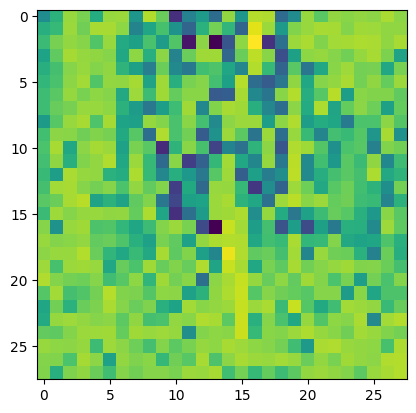

In [61]:
magic_sae.eval()
a,b = magic_sae(torch.Tensor(X_train[TRAIN_ID]))
c = torch.mean(b,axis=0)
plt.imshow(c.detach().numpy().reshape(28,28))

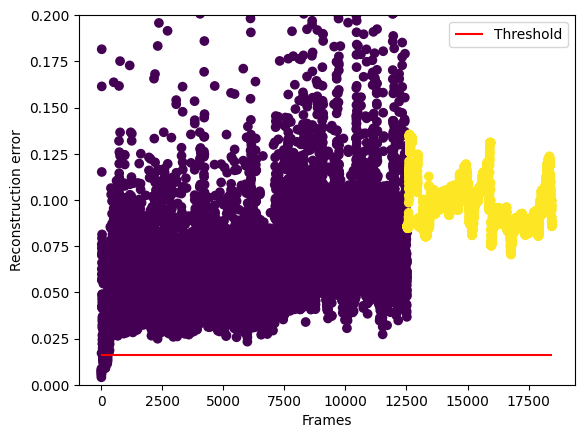

In [62]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y_test)
plt.hlines(y=THR.detach().numpy()*SIGMA,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

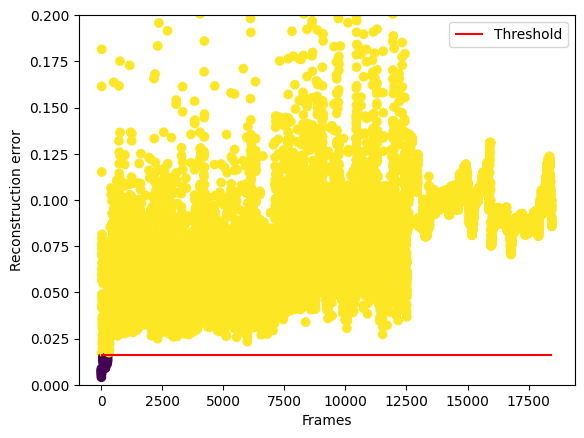

In [63]:
#plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR.detach().numpy()*SIGMA,xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [64]:
print("False Positives: ", FP)
print("False Negatives: ", FN)

False Positives:  12442
False Negatives:  0


In [65]:
TEST_ID = 10000

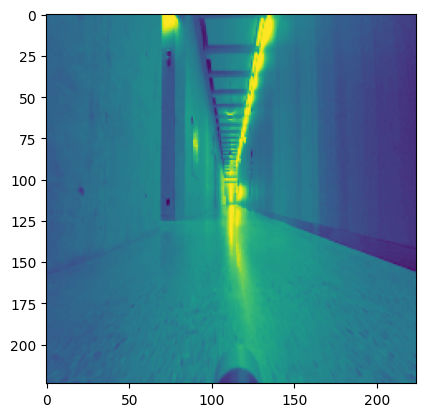

In [66]:
plt.imshow(X_test[TEST_ID])

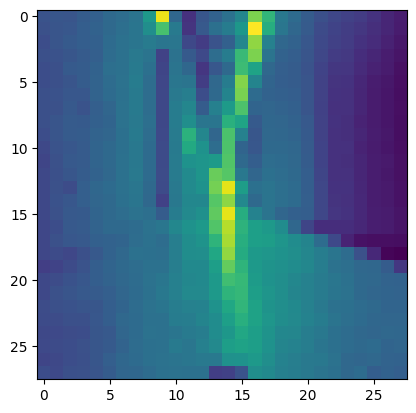

In [67]:
plt.imshow(X_test_lr[TEST_ID].reshape(28,28))

In [68]:
magic_sae.eval()
a,b = magic_sae(torch.Tensor(X_test_lr[TEST_ID]))

In [69]:
c = torch.mean(b,axis=0)

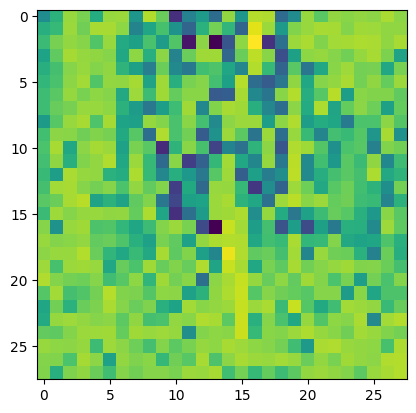

In [70]:
plt.imshow(c.detach().numpy().reshape(28,28))